### Hypo 2 on GSM not AMR with lesser amount of models

AMR-0 performs acutally worse in reconstruction by the models we set up

-> Need to prepare Dense-Dense-Dense model for comparison with every model in paper (https://stackoverflow.com/questions/50980113/evaluate-a-function-in-a-sliding-window-with-keras)

-> Maybe AMR-0 reconstruction needs far deeper layers? Or another method of reconstruction? How will it look with noise?

-> What are current observations?



##### Imports and initialization

In [1]:
%matplotlib inline

import os,sys
#path = os.path.realpath(os.path.join(os.getcwd(), ".."))
path = "/home/zantyr/Denoising"
sys.path.append(path)
os.chdir(path)

import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.io.wavfile as sio
import tempfile

from IPython.display import Image, Audio, display

import keras
from keras.utils.vis_utils import plot_model
from keras.layers         import Dropout, Input, Conv1D, Conv2D, AveragePooling2D, Flatten, Dense, Deconv2D, UpSampling2D, concatenate, BatchNormalization, Lambda, LeakyReLU, TimeDistributed, Reshape, LSTM, GaussianNoise
from keras.models         import Model
from keras.datasets.mnist import load_data
from keras.utils          import to_categorical
from keras.initializers   import Orthogonal
from keras.regularizers   import L1L2, l2
from keras.callbacks      import Callback
import keras.backend as K
import tensorflow as tf

import loaders
from loaders.transform import AddGaussianNoise, Windowing, GSMize, MixReverb, MixNoise, ConstantQTransform, Transcript, LengthOfWindow, Length, Lengthen, Null, DivisiblePad
from loaders.dataset import Dataset, enable_multiprocessing, disable_multiprocessing
from loaders.feature import NormalizedLogPowerRFFT, Trim
from loaders.experiment import SingleExperiment
from loaders.measures import MSE
from loaders.schedule import Schedule
from loaders.estimator import DefaultVisualizeTransform, Estimator
from loaders.extras import LossHistory, set_device, delog_griffin_lim, get_stft
from loaders.custom import identity_loss
set_device()               # switches to CPU if GPU busy
enable_multiprocessing()   # for faster preprocessing of data (multicore)

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Process ForkPoolWorker-9:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-8:
Process ForkPoolWorker-2:
  File "/usr/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Process ForkPoolWorker-3:
  File "/usr/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
Traceback (most

##### Model definition

In [2]:
model_callbacks = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, 129, 15)     225       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1935)        0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 2048)        3964928   
_________________________________________________________________
hidden (Dense)               (None, None, 2048)        4196352   
_________________________________________________________________
dense_2 (Dense)              (None, None, 257)         526593    
Total para

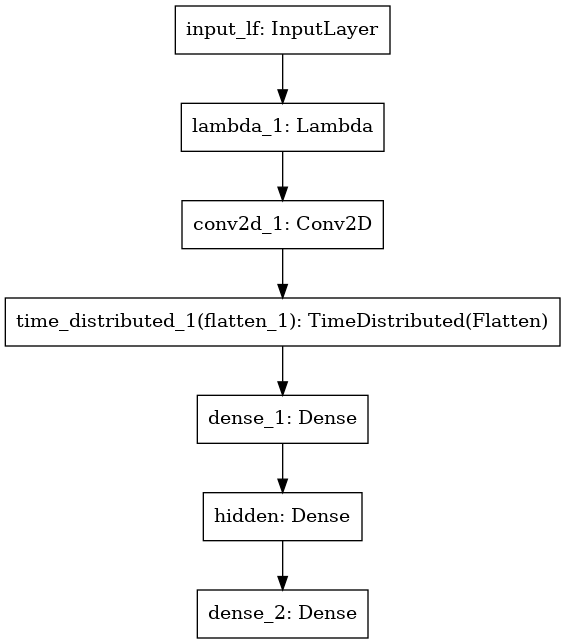

In [3]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    lyr = Lambda(K.expand_dims)(input_lower)
    windowing = Conv2D(15, (15, 1), padding='same', use_bias=False)
    lyr = windowing(lyr)
    windowing.set_weights([np.eye(15).reshape(15, 1, 1, 15)])
    windowing.trainable = False
    lyr = TimeDistributed(Flatten())(lyr)
    lyr = Dense(2048)(lyr)
    lyr = Dense(2048, name='hidden')(lyr)
    lf_and_hf = Dense(257)(lyr)
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, 129, 16 160         lambda_2[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, 129, 16 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

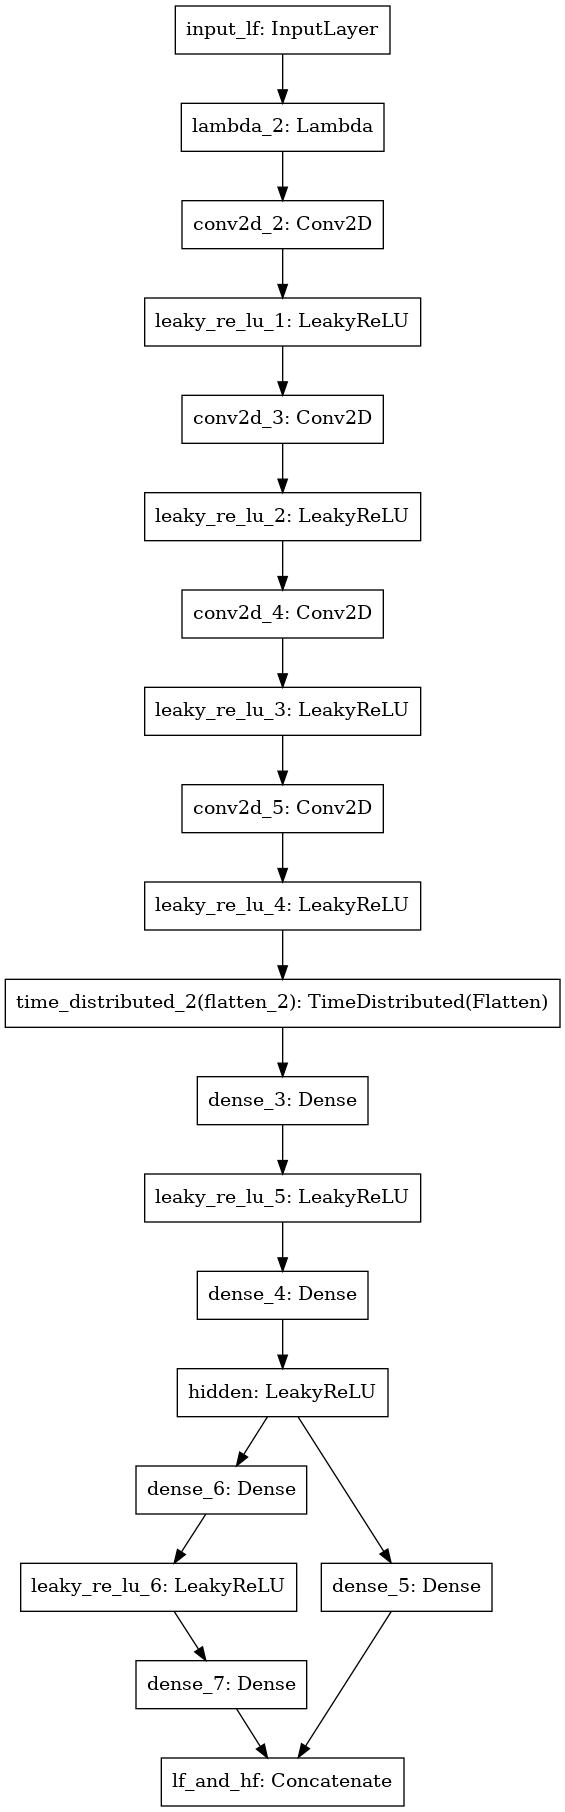

In [4]:
def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = LeakyReLU(0.01)(Conv2D(16, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    hidden = layer = LeakyReLU(0.01, name='hidden')(Dense(512)(layer))
    layer = Dense(128)(layer)
    lower = LeakyReLU(0.01)(Dense(256)(hidden))
    lower = Dense(129)(lower)
    lf_and_hf = concatenate([lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, None, 129, 16 160         lambda_3[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, None, 129, 20 1620        conv2d_6[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

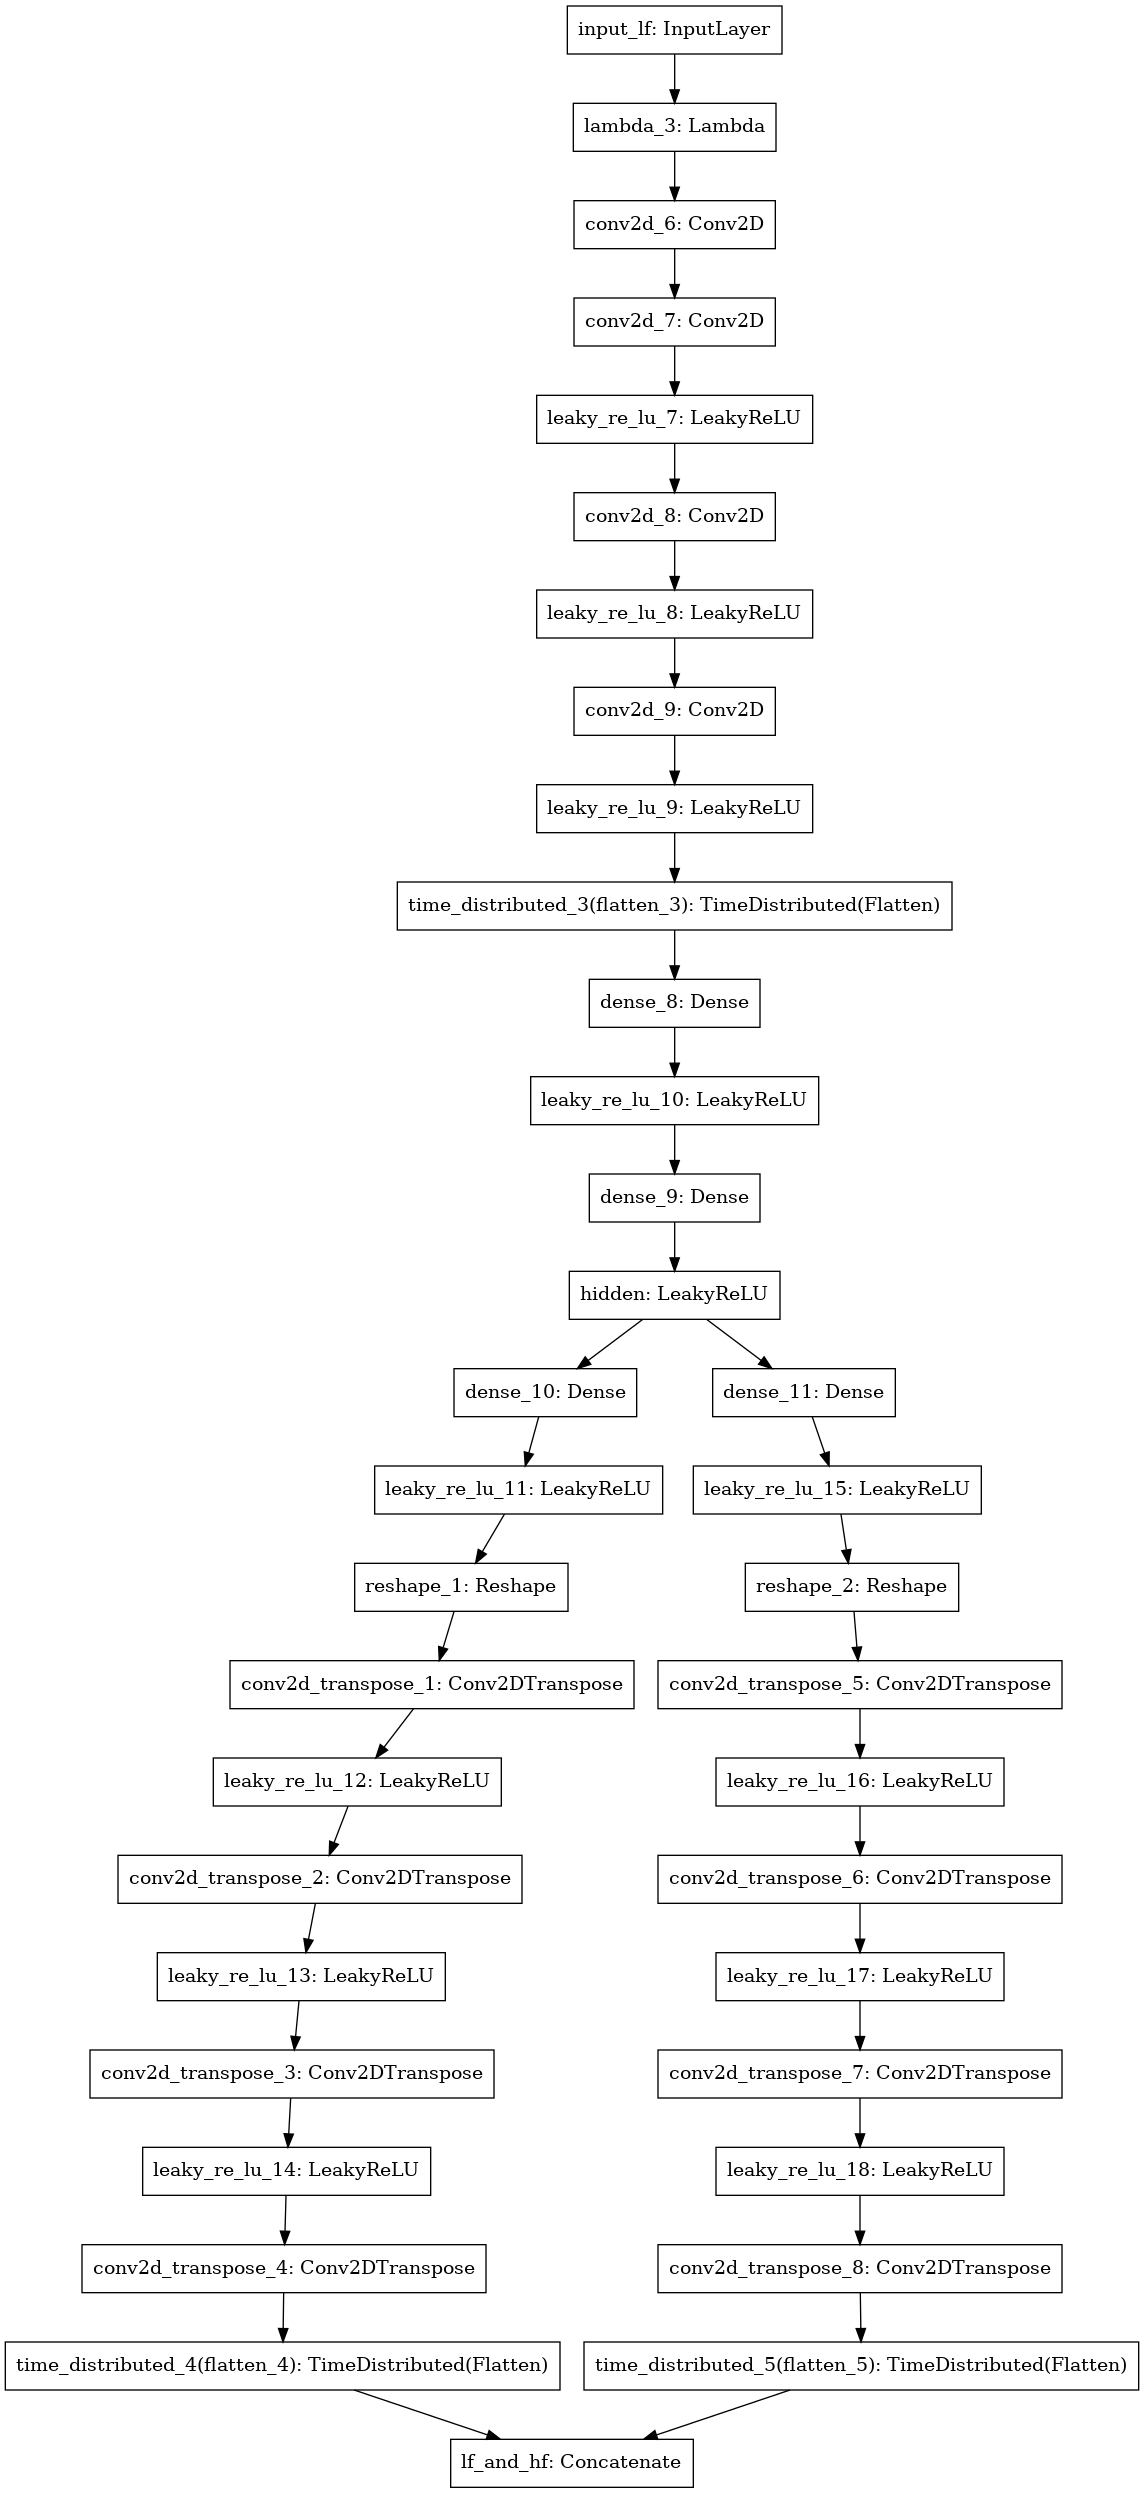

In [5]:
# baseline autoencoder

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = Conv2D(16, kernel_size=(9,1), padding='same', activation='tanh')(layer)
    layer = LeakyReLU(0.01)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    hidden = layer = LeakyReLU(0.01, name='hidden')(Dense(96)(layer))
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    lower = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1032)(hidden))
    layer = Reshape((-1, 129,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, None, 129, 16 160         lambda_4[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, None, 129, 20 1620        conv2d_10[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

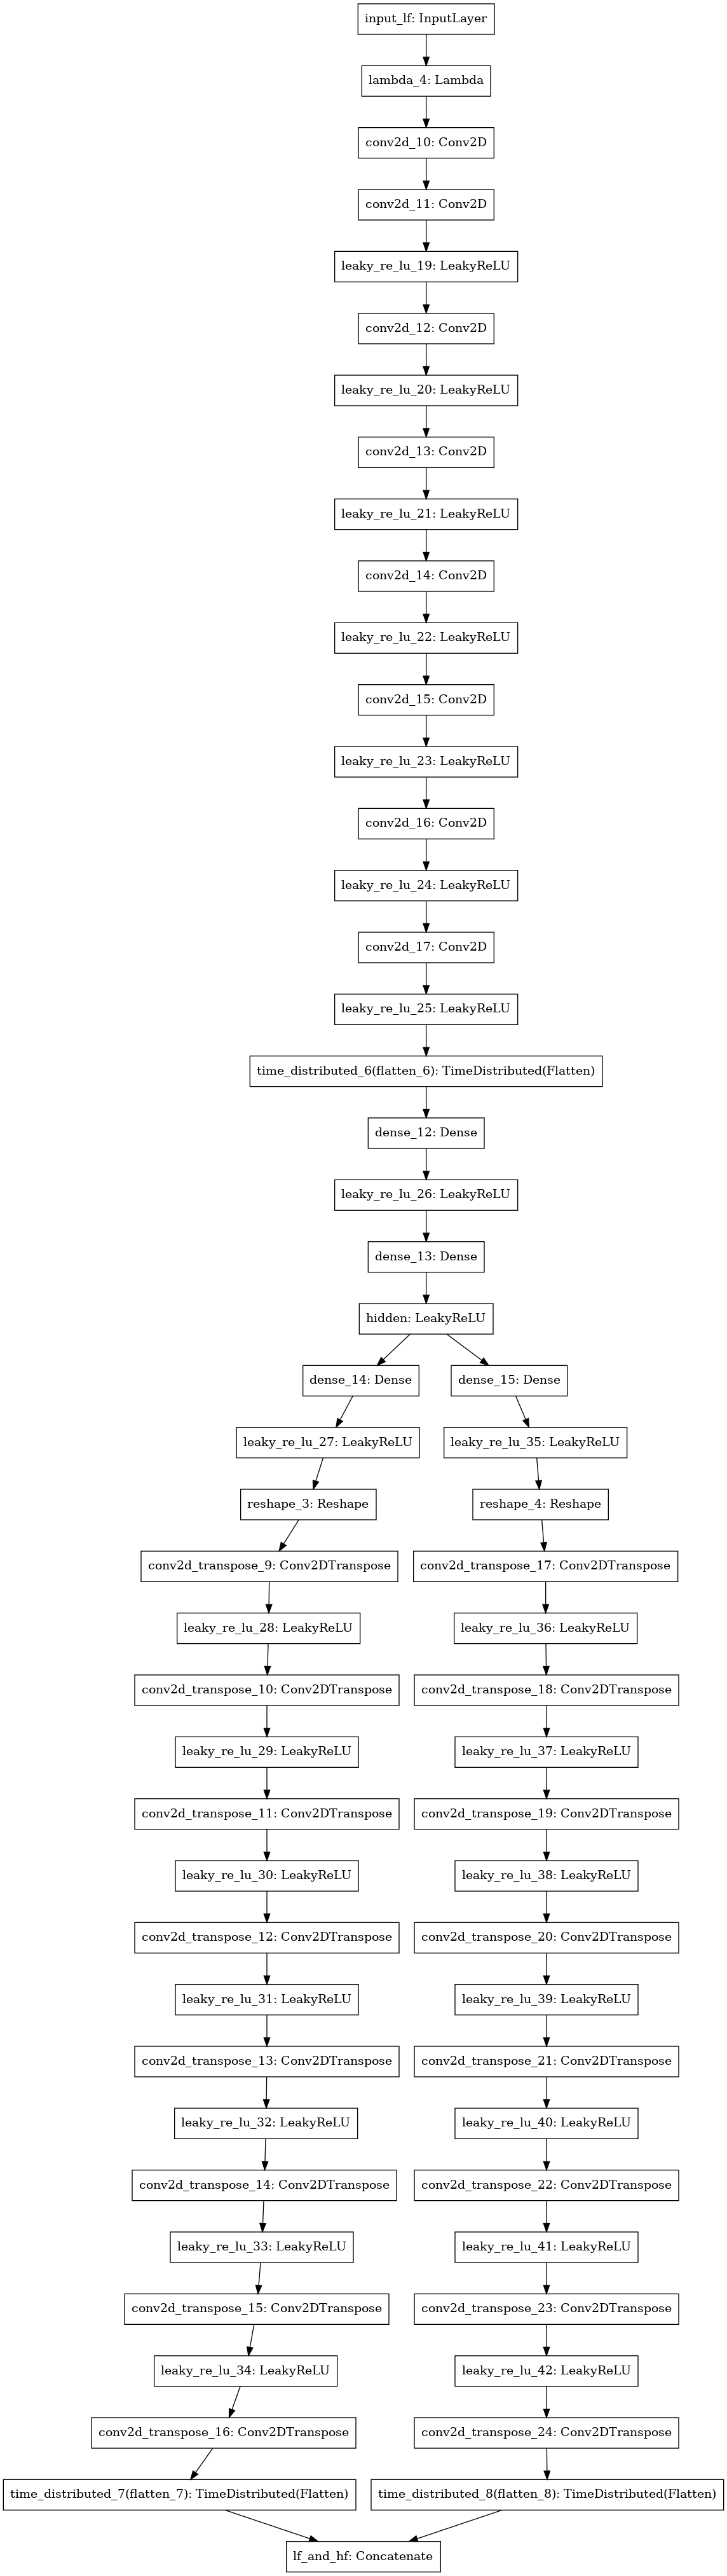

In [6]:
# baseline autoencoder - 4 encoding

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = Conv2D(16, kernel_size=(9,1), padding='same', activation='tanh')(layer)
    layer = LeakyReLU(0.01)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(42, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    hidden = layer = LeakyReLU(0.01, name='hidden')(Dense(96)(layer))
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(42, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    lower = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1032)(hidden))
    layer = Reshape((-1, 129,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(48, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(42, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(36, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(32, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, None, 129, 16 160         lambda_5[0][0]                   
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, None, 129, 20 1620        conv2d_18[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

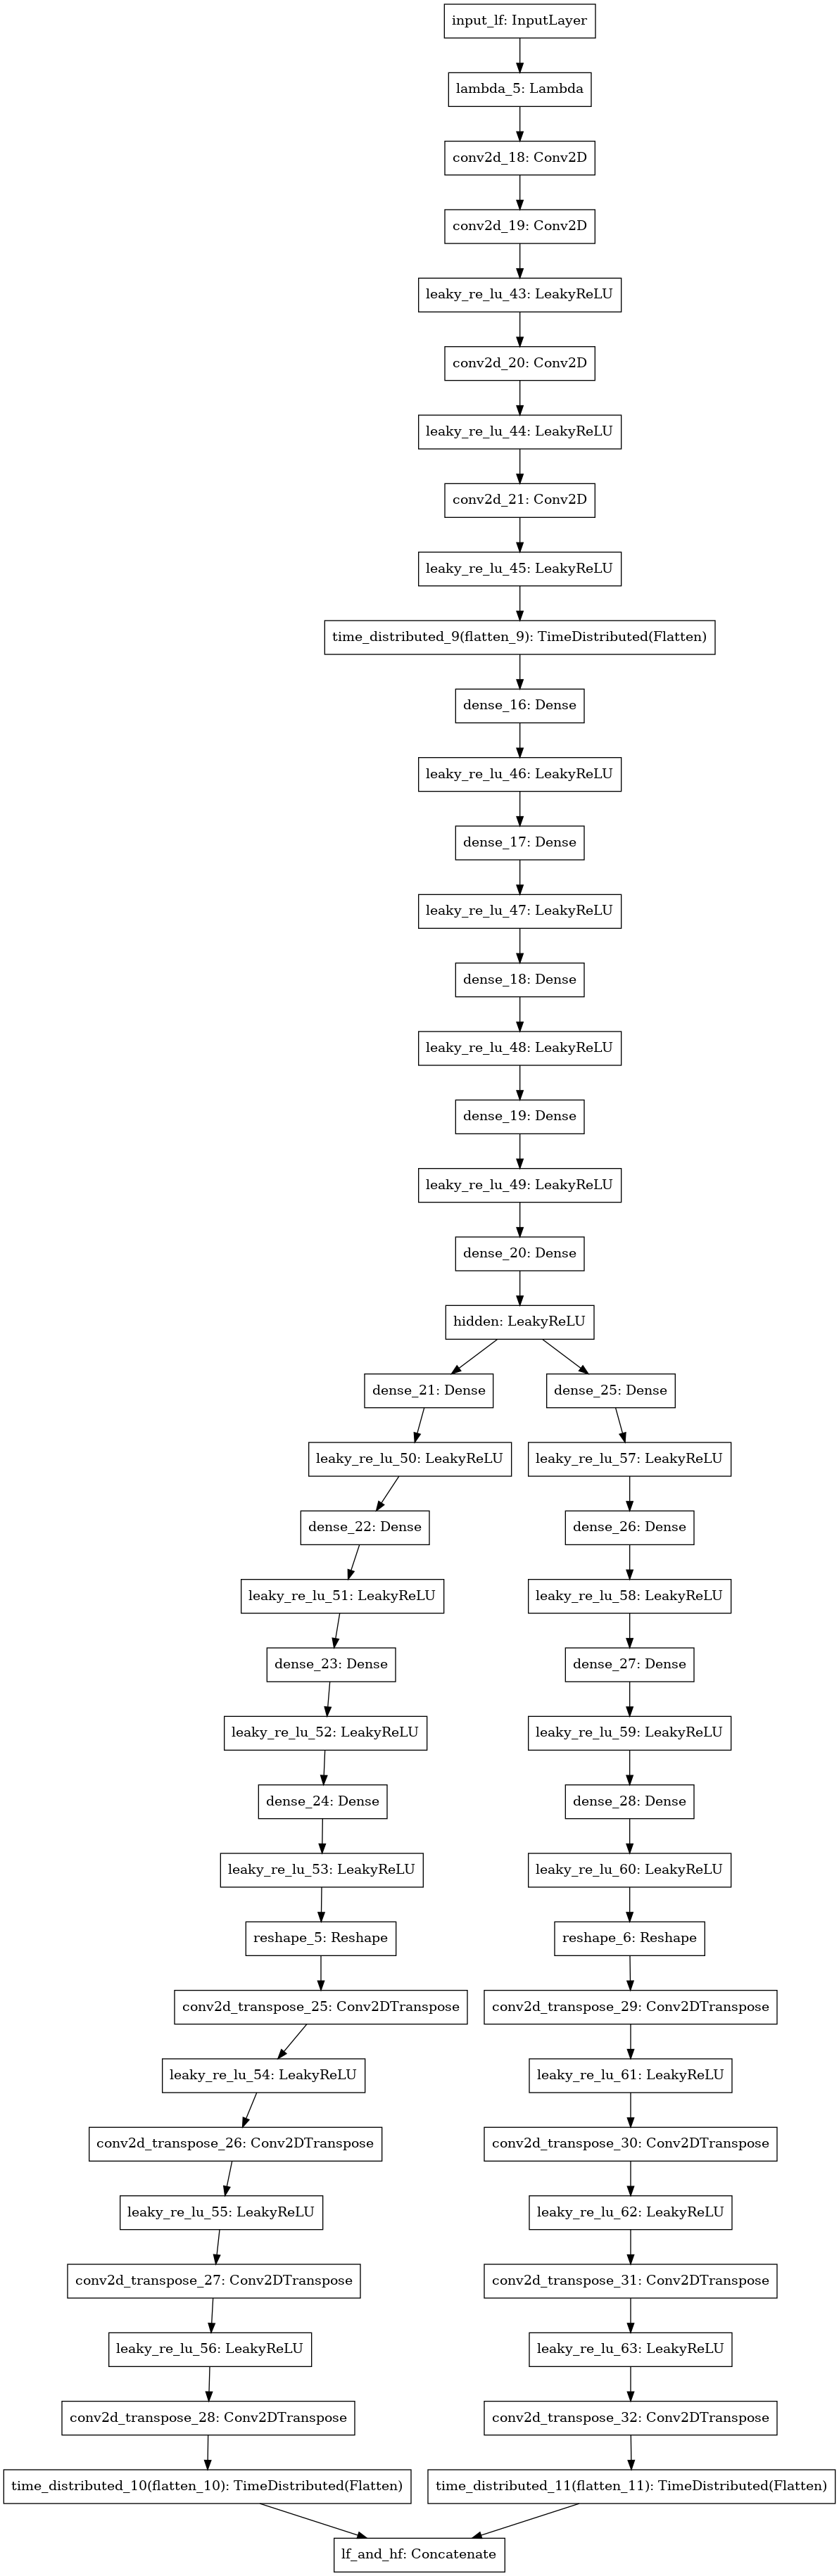

In [7]:
# baseline autoencoder - deeped mid representation - 4 layers

def mk_model():
    input_lower = Input((None, 129), name="input_lf")
    layer = Lambda(lambda x: K.expand_dims(x))(input_lower)
    layer = Conv2D(16, kernel_size=(9,1), padding='same', activation='tanh')(layer)
    layer = LeakyReLU(0.01)(Conv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Conv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    layer = LeakyReLU(0.01)(Dense(512)(layer))
    layer = LeakyReLU(0.01)(Dense(256)(layer))
    layer = LeakyReLU(0.01)(Dense(192)(layer))
    hidden = layer = LeakyReLU(0.01, name='hidden')(Dense(96)(layer))
    layer = LeakyReLU(0.01)(Dense(192)(layer))
    layer = LeakyReLU(0.01)(Dense(256)(layer))
    layer = LeakyReLU(0.01)(Dense(512)(layer))
    layer = LeakyReLU(0.01)(Dense(1024)(layer))
    layer = Reshape((-1, 128,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    lower = TimeDistributed(Flatten())(layer)
    layer = LeakyReLU(0.01)(Dense(192)(hidden))
    layer = LeakyReLU(0.01)(Dense(256)(layer))
    layer = LeakyReLU(0.01)(Dense(512)(layer))
    layer = LeakyReLU(0.01)(Dense(1032)(layer))
    layer = Reshape((-1, 129,8))(layer)
    layer = LeakyReLU(0.01)(Deconv2D(28, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(24, kernel_size=(9,1), padding='same', activation='linear')(layer))
    layer = LeakyReLU(0.01)(Deconv2D(20, kernel_size=(1,5), padding='same', activation='linear')(layer))
    layer = Deconv2D(1, kernel_size=(9,1), padding='same', activation='linear')(layer)
    layer = TimeDistributed(Flatten())(layer)
    lf_and_hf = concatenate([lower, layer], name="lf_and_hf")
    mdl = Model(input_lower, lf_and_hf)
    mdl.summary()
    mdl.compile('adam', 'mse')
    return mdl

temp = tempfile.mktemp() + ".png"
mdl = mk_model()
model_callbacks.append(mk_model)
plot_model(mdl, to_file=temp)
Image(filename=temp)

##### Data loading

In [12]:
TRAIN = 9000
VALID = 80
TEST = 80

import numpy as np
import scipy.io.wavfile as sio
import scipy.signal as ss
import gc

import tempfile
import subprocess

tempnam = tempfile.mktemp

log_fft_source = log_fft_target = phase = train = test = valid = experiment = None
gc.collect()

dataset = Dataset.from_folder("DAE-libri",
                              verbose = False,
                              dataset_pad = 8,
                              trim_lengths = 160000,
                              cache = "cache",
                              ram_cache_size = None,
                              filter=lambda x:x.endswith(".wav") and not x.endswith(".gsm.wav"))

import random
noises = [os.path.join("./NoiseCut", x) for x in os.listdir("./NoiseCut")]

log_fft_source = np.zeros([TRAIN + VALID + TEST, 1248, 129], np.float32)
log_fft_target = np.zeros([TRAIN + VALID + TEST, 1248, 257], np.float32)
phase = np.zeros([TEST, 1248, 129], np.float32)

SNR = 5 # dB
SNR /= 10. # B
SNR = np.log(10) * SNR

# envelope_filter_base = ss.butter(6, (20. / 8000.))
# envelope_filter = lambda signal: ss.lfilter(envelope_filter_base[0], envelope_filter_base[1], signal)

for ix, file in enumerate(dataset.files[:TRAIN + VALID + TEST]):
    print(ix)
    noise = sio.read(random.choice(noises))[1]
    data = sio.read(dataset.root + "/" + file)[1] # .astype(np.float32) to generate noise in the experiment...
    data = data[:176000]
    noise = noise[:len(data)]
    if len(noise) < len(data):
        print("NOISE TOO SHORT:", len(noise))
        noise = np.pad(noise, ((0, len(data) - len(noise)),),'constant')
    log_power_of_signal = np.log((data.astype(np.float32) ** 2).max())
    log_power_of_noise = np.log((noise.astype(np.float32) ** 2).max())
    print("Clean // noise power mean before gain:", np.sqrt(np.exp(log_power_of_signal)), np.sqrt(np.exp(log_power_of_noise)))
    print("Clean // noise power mean before gain (log):", log_power_of_signal, log_power_of_noise)
    gain_of_noise = np.sqrt(np.exp(log_power_of_signal - SNR - log_power_of_noise))   # SNR was miscalculated...
    print("Noise difference - logpower:", log_power_of_signal - log_power_of_noise)
    print("Noise gain - multiplicatively:", gain_of_noise)
    if np.isnan(gain_of_noise):
        print("NAN gain - generating some random white noise")
        noise = np.random.normal(0, 1500, size=data.shape)
    else:
        noise = noise * gain_of_noise
    noised = data + noise
    print("Clean // noise peaks:", np.abs(data).max(), np.abs(noise).max())
    if np.abs(noised).max() >= 2**15 - 1:
        noised = noised / (np.abs(noised).max() / (2 ** 15 - 1))
    noised = noised.astype(np.int16)
    print("Amplitude of clean recording: ", np.abs(data).max())
    print("Amplitude of noised recording: ", np.abs(noised).max())
    oldname = tempnam() + '.oldwav'
    sio.write(oldname, 16000, noised)
    tmpname = tempnam() + '.amr-nb'
    print(oldname)
    newname = dataset.root + "/" + file + ".gsm.wav"
    subprocess.Popen(['sox', oldname, '-C', '7', '-r',  '8000', tmpname]).communicate()
    subprocess.Popen(['sox', tmpname, '-r', '16000', "-e", "signed", '-b', '16',  newname]).communicate()
    list(map(os.remove, [oldname, tmpname]))
    # display(Audio(noised, rate=16000))
    # input = sio.read(newname)[1]
    # print("New name: ", newname)
    # display(Audio(input, rate=16000))
    
window = np.hamming(512)
for ix, file in enumerate(dataset.files[:TRAIN + VALID + TEST]):
    print(ix)
    r = sio.read(dataset.root + "/" + file)[1].astype(np.float32)
    r /= 2**15
    for time in range(1248):
        win = r[128 * time : 128 * time + 512]
        if len(win) != 512:
            break
        fft = np.fft.rfft(window * win) / 512
        log_fft_target[ix, time, :] = -np.log(np.abs(fft) ** 2 + 2e-12)
    r = sio.read(dataset.root + "/" + file + ".gsm.wav")[1].astype(np.float32)
    r /= 2**15
    for time in range(1248):
        win = r[128 * time : 128 * time + 512]
        if len(win) != 512:
            break
        fft = np.fft.rfft(window * win) / 512
        log_fft_source[ix, time, :] = -np.log(np.abs(fft) ** 2 + 2e-12)[:129]
        if ix >= TRAIN+VALID:
            phase[ix - TRAIN - VALID, time, :] = np.angle(fft)[:129]


0
Clean // noise power mean before gain: 18152.998 9573.003
Clean // noise power mean before gain (log): 19.613182 18.333405
Noise difference - logpower: 1.2797775
Noise gain - multiplicatively: 1.0663509470447927
Clean // noise peaks: 18153 10208.1776160598
Amplitude of clean recording:  18153
Amplitude of noised recording:  18143
/tmp/tmpz8b472q0.oldwav
1
Clean // noise power mean before gain: 16891.0 26323.99
Clean // noise power mean before gain (log): 19.469072 20.356472
Noise difference - logpower: -0.8873997
Noise gain - multiplicatively: 0.360830806712896
Clean // noise peaks: 16891 9498.510155910275
Amplitude of clean recording:  16891
Amplitude of noised recording:  17149
/tmp/tmpl76kv16o.oldwav
2
Clean // noise power mean before gain: 17380.008 4063.001
Clean // noise power mean before gain (log): 19.526152 16.619354
Noise difference - logpower: 2.9067974
Noise gain - multiplicatively: 2.4054871284996366
Clean // noise peaks: 17380 9773.494203094024
Amplitude of clean record

24
Clean // noise power mean before gain: 13714.002 16822.998
Clean // noise power mean before gain (log): 19.052345 19.461004
Noise difference - logpower: -0.40865898
Noise gain - multiplicatively: 0.4584171214091418
Clean // noise peaks: 13714 7711.951233465993
Amplitude of clean recording:  13714
Amplitude of noised recording:  15094
/tmp/tmpqk9epy38.oldwav
25
Clean // noise power mean before gain: 18046.996 10613.997
Clean // noise power mean before gain (log): 19.601469 18.539858
Noise difference - logpower: 1.0616112
Noise gain - multiplicatively: 0.9561497982458672
Clean // noise peaks: 18047 10148.573958581635
Amplitude of clean recording:  18047
Amplitude of noised recording:  17812
/tmp/tmp41ntazw7.oldwav
26
Clean // noise power mean before gain: 13233.997 14183.999
Clean // noise power mean before gain (log): 18.981089 19.11974
Noise difference - logpower: -0.1386509
Noise gain - multiplicatively: 0.5246773795994031
Clean // noise peaks: 13234 7442.023952237933
Amplitude of 

Amplitude of clean recording:  14848
Amplitude of noised recording:  16258
/tmp/tmpt4bm8zf3.oldwav
47
Clean // noise power mean before gain: 19212.008 16444.0
Clean // noise power mean before gain (log): 19.726582 19.415432
Noise difference - logpower: 0.3111496
Noise gain - multiplicatively: 0.6569998592922961
Clean // noise peaks: 19212 10803.705686202517
Amplitude of clean recording:  19212
Amplitude of noised recording:  18894
/tmp/tmpp34g8tal.oldwav
48
Clean // noise power mean before gain: 10980.004 16822.998
Clean // noise power mean before gain (log): 18.607662 19.461004
Noise difference - logpower: -0.85334206
Noise gain - multiplicatively: 0.36702794060539784
Clean // noise peaks: 10980 6174.511044804608
Amplitude of clean recording:  10980
Amplitude of noised recording:  12965
/tmp/tmpjmt8ksx8.oldwav
49
Clean // noise power mean before gain: 20443.998 11734.001
Clean // noise power mean before gain (log): 19.85089 18.740492
Noise difference - logpower: 1.1103973
Noise gain -

Clean // noise power mean before gain: 18775.0 16444.0
Clean // noise power mean before gain (log): 19.680563 19.415432
Noise difference - logpower: 0.265131
Noise gain - multiplicatively: 0.6420553430393112
Clean // noise peaks: 18775 10557.958060938434
Amplitude of clean recording:  18775
Amplitude of noised recording:  18383
/tmp/tmpmg619sx7.oldwav
71
Clean // noise power mean before gain: 11199.0 28947.998
Clean // noise power mean before gain (log): 18.64716 20.546513
Noise difference - logpower: -1.899353
Noise gain - multiplicatively: 0.21755082297037737
Clean // noise peaks: 11199 6297.661223346484
Amplitude of clean recording:  11199
Amplitude of noised recording:  11272
/tmp/tmpqar1lvyn.oldwav
72
Clean // noise power mean before gain: 16156.994 14077.001
Clean // noise power mean before gain (log): 19.380217 19.104595
Noise difference - logpower: 0.2756214
Noise gain - multiplicatively: 0.6454319049810517
Clean // noise peaks: 16157 9085.744926418265
Amplitude of clean record

94
Clean // noise power mean before gain: 20293.996 8559.999
Clean // noise power mean before gain (log): 19.83616 18.10971
Noise difference - logpower: 1.72645
Noise gain - multiplicatively: 1.3331955238090105
Clean // noise peaks: 20294 11412.15368380513
Amplitude of clean recording:  20294
Amplitude of noised recording:  20143
/tmp/tmpt47qt56g.oldwav
95
Clean // noise power mean before gain: 8939.996 32567.01
Clean // noise power mean before gain (log): 18.19658 20.78211
Noise difference - logpower: -2.5855293
Noise gain - multiplicatively: 0.15436876872564498
Clean // noise peaks: 8940 5027.32769108808
Amplitude of clean recording:  8940
Amplitude of noised recording:  9765
/tmp/tmpd9frd46n.oldwav
96
Clean // noise power mean before gain: 15932.996 4063.001
Clean // noise power mean before gain (log): 19.352295 16.619354
Noise difference - logpower: 2.7329407
Noise gain - multiplicatively: 2.2052129135394103
Clean // noise peaks: 15933 8959.780067710624
Amplitude of clean recording

118
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 15985.992 10709.003
Clean // noise power mean before gain (log): 19.358936 18.55768
Noise difference - logpower: 0.8012562
Noise gain - multiplicatively: 0.8394417567724315
Clean // noise peaks: 15986 8989.58177327597
Amplitude of clean recording:  15986
Amplitude of noised recording:  15960
/tmp/tmpa3htovx0.oldwav
119
Clean // noise power mean before gain: 31167.992 12951.001
Clean // noise power mean before gain (log): 20.694294 18.937857
Noise difference - logpower: 1.7564373
Noise gain - multiplicatively: 1.3533356240195202
Clean // noise peaks: 31168 17527.049666676805
Amplitude of clean recording:  31168
Amplitude of noised recording:  31393
/tmp/tmptvkc79gc.oldwav
120
Clean // noise power mean before gain: 17997.994 4812.998
Clean // noise power mean before gain (log): 19.596031 16.95815
Noise difference - logpower: 2.6378803
Noise gain - multiplicatively: 2.102850676927844
Clean // noise peaks: 17998 10121.02030

Clean // noise power mean before gain: 15438.004 4063.001
Clean // noise power mean before gain (log): 19.289175 16.619354
Noise difference - logpower: 2.6698208
Noise gain - multiplicatively: 2.136703283567518
Clean // noise peaks: 15438 8681.425441134827
Amplitude of clean recording:  15438
Amplitude of noised recording:  17114
/tmp/tmp12a1s3x5.oldwav
142
Clean // noise power mean before gain: 22188.998 32734.002
Clean // noise power mean before gain (log): 20.014704 20.79234
Noise difference - logpower: -0.7776356
Noise gain - multiplicatively: 0.38118743844071706
Clean // noise peaks: 22189 12477.789609918433
Amplitude of clean recording:  22189
Amplitude of noised recording:  22242
/tmp/tmpytk0jp98.oldwav
143
Clean // noise power mean before gain: 13626.005 16822.998
Clean // noise power mean before gain (log): 19.03947 19.461004
Noise difference - logpower: -0.42153358
Noise gain - multiplicatively: 0.4554756299153072
Clean // noise peaks: 13626 7662.466522065213
Amplitude of cle

164
Clean // noise power mean before gain: 30721.994 26303.99
Clean // noise power mean before gain (log): 20.665468 20.354952
Noise difference - logpower: 0.31051636
Noise gain - multiplicatively: 0.6567918730082881
Clean // noise peaks: 30722 17276.253427610012
Amplitude of clean recording:  30722
Amplitude of noised recording:  32767
/tmp/tmpljv23qtb.oldwav
165
Clean // noise power mean before gain: 16607.004 32567.01
Clean // noise power mean before gain (log): 19.43516 20.78211
Noise difference - logpower: -1.3469505
Noise gain - multiplicatively: 0.28675659080117577
Clean // noise peaks: 16607 9338.801892621892
Amplitude of clean recording:  16607
Amplitude of noised recording:  16565
/tmp/tmpfp9iz5kv.oldwav
166
Clean // noise power mean before gain: 24499.994 31147.996
Clean // noise power mean before gain (log): 20.212856 20.69301
Noise difference - logpower: -0.48015404
Noise gain - multiplicatively: 0.44231928563880685
Clean // noise peaks: 24500 13777.361109077556
Amplitude 

188
Clean // noise power mean before gain: 12905.001 31147.996
Clean // noise power mean before gain (log): 18.93074 20.69301
Noise difference - logpower: -1.76227
Noise gain - multiplicatively: 0.23298498719636085
Clean // noise peaks: 12905 7257.0163811922475
Amplitude of clean recording:  12905
Amplitude of noised recording:  17466
/tmp/tmpdeo1q_31.oldwav
189
Clean // noise power mean before gain: 16647.996 27012.006
Clean // noise power mean before gain (log): 19.44009 20.408073
Noise difference - logpower: -0.96798325
Noise gain - multiplicatively: 0.3465812860209979
Clean // noise peaks: 16648 9361.853697999195
Amplitude of clean recording:  16648
Amplitude of noised recording:  18545
/tmp/tmp6pt6e_ji.oldwav
190
Clean // noise power mean before gain: 24087.01 10679.997
Clean // noise power mean before gain (log): 20.178856 18.552256
Noise difference - logpower: 1.6266003
Noise gain - multiplicatively: 1.268270117189613
Clean // noise peaks: 24087 13545.124851585066
Amplitude of c

212
Clean // noise power mean before gain: 17645.0 15315.994
Clean // noise power mean before gain (log): 19.556416 19.273306
Noise difference - logpower: 0.28310966
Noise gain - multiplicatively: 0.6478530125854989
Clean // noise peaks: 17645 9922.5167407595
Amplitude of clean recording:  17645
Amplitude of noised recording:  19367
/tmp/tmpc9n77tcg.oldwav
213
Clean // noise power mean before gain: 12917.006 6583.0
Clean // noise power mean before gain (log): 18.9326 17.584492
Noise difference - logpower: 1.3481083
Noise gain - multiplicatively: 1.103412745125128
Clean // noise peaks: 12917 7263.766101158718
Amplitude of clean recording:  12917
Amplitude of noised recording:  12931
/tmp/tmpw5l7v0jo.oldwav
214
Clean // noise power mean before gain: 16597.994 10370.003
Clean // noise power mean before gain (log): 19.434074 18.493345
Noise difference - logpower: 0.94072914
Noise gain - multiplicatively: 0.9000709345195376
Clean // noise peaks: 16598 9333.735590967604
Amplitude of clean re

235
Clean // noise power mean before gain: 15114.996 32567.01
Clean // noise power mean before gain (log): 19.246885 20.78211
Noise difference - logpower: -1.5352249
Noise gain - multiplicatively: 0.26099377291066245
Clean // noise peaks: 15115 8499.784202381545
Amplitude of clean recording:  15115
Amplitude of noised recording:  15633
/tmp/tmpmvwhw5s8.oldwav
236
Clean // noise power mean before gain: 20048.996 15315.994
Clean // noise power mean before gain (log): 19.811869 19.273306
Noise difference - logpower: 0.5385628
Noise gain - multiplicatively: 0.7361179713633531
Clean // noise peaks: 20049 11274.382849401116
Amplitude of clean recording:  20049
Amplitude of noised recording:  23668
/tmp/tmpd3awc6rc.oldwav
237
Clean // noise power mean before gain: 13028.997 31147.996
Clean // noise power mean before gain (log): 18.949865 20.69301
Noise difference - logpower: -1.743145
Noise gain - multiplicatively: 0.23522359061457826
Clean // noise peaks: 13029 7326.744400462883
Amplitude of

258
Clean // noise power mean before gain: 19072.992 16822.998
Clean // noise power mean before gain (log): 19.712057 19.461004
Noise difference - logpower: 0.25105286
Noise gain - multiplicatively: 0.6375517396383461
Clean // noise peaks: 19073 10725.532915935897
Amplitude of clean recording:  19073
Amplitude of noised recording:  21548
/tmp/tmpd5vea52d.oldwav
259
Clean // noise power mean before gain: 16704.008 15315.994
Clean // noise power mean before gain (log): 19.446808 19.273306
Noise difference - logpower: 0.17350197
Noise gain - multiplicatively: 0.6133035432243894
Clean // noise peaks: 16704 9393.357068024749
Amplitude of clean recording:  16704
Amplitude of noised recording:  21315
/tmp/tmpq7_uctwt.oldwav
260
Clean // noise power mean before gain: 17816.002 28947.998
Clean // noise power mean before gain (log): 19.575705 20.546513
Noise difference - logpower: -0.970808
Noise gain - multiplicatively: 0.34609212302839293
Clean // noise peaks: 17816 10018.674777425918
Amplitud

281
Clean // noise power mean before gain: 24299.992 10709.003
Clean // noise power mean before gain (log): 20.196463 18.55768
Noise difference - logpower: 1.6387825
Noise gain - multiplicatively: 1.2760188752920791
Clean // noise peaks: 24300 13664.886135502875
Amplitude of clean recording:  24300
Amplitude of noised recording:  24305
/tmp/tmp93qsuk4d.oldwav
282
Clean // noise power mean before gain: 18141.006 1677.9999
Clean // noise power mean before gain (log): 19.61186 14.850716
Noise difference - logpower: 4.7611446
Noise gain - multiplicatively: 6.079521825613886
Clean // noise peaks: 18141 10201.437623380101
Amplitude of clean recording:  18141
Amplitude of noised recording:  21411
/tmp/tmp_wb7uvrp.oldwav
283
Clean // noise power mean before gain: 16800.006 8559.999
Clean // noise power mean before gain (log): 19.45827 18.10971
Noise difference - logpower: 1.3485584
Noise gain - multiplicatively: 1.1036611150233504
Clean // noise peaks: 16800 9447.339144599879
Amplitude of clea

304
Clean // noise power mean before gain: 13694.999 4063.001
Clean // noise power mean before gain (log): 19.049572 16.619354
Noise difference - logpower: 2.4302177
Noise gain - multiplicatively: 1.8954619808918987
Clean // noise peaks: 13695 7701.262028363784
Amplitude of clean recording:  13695
Amplitude of noised recording:  14460
/tmp/tmp8x3u05so.oldwav
305
Clean // noise power mean before gain: 17088.002 9573.003
Clean // noise power mean before gain (log): 19.492264 18.333405
Noise difference - logpower: 1.1588593
Noise gain - multiplicatively: 1.0037905191313252
Clean // noise peaks: 17088 9609.286639644177
Amplitude of clean recording:  17088
Amplitude of noised recording:  18018
/tmp/tmpxqvno67c.oldwav
306
Clean // noise power mean before gain: 24433.004 31114.002
Clean // noise power mean before gain (log): 20.20738 20.690826
Noise difference - logpower: -0.48344612
Noise gain - multiplicatively: 0.441591808467882
Clean // noise peaks: 24433 13739.68752866968
Amplitude of cl

327
Clean // noise power mean before gain: 18787.0 1677.9999
Clean // noise power mean before gain (log): 19.68184 14.850716
Noise difference - logpower: 4.8311253
Noise gain - multiplicatively: 6.2960116182467685
Clean // noise peaks: 18787 10564.707495418077
Amplitude of clean recording:  18787
Amplitude of noised recording:  21451
/tmp/tmp8usf6ldc.oldwav
328
Clean // noise power mean before gain: 21613.994 26323.99
Clean // noise power mean before gain (log): 19.962193 20.356472
Noise difference - logpower: -0.39427948
Noise gain - multiplicatively: 0.46172490302917985
Clean // noise peaks: 21614 12154.44634734013
Amplitude of clean recording:  21614
Amplitude of noised recording:  23412
/tmp/tmpippe5593.oldwav
329
Clean // noise power mean before gain: 20095.99 12951.001
Clean // noise power mean before gain (log): 19.816551 18.937857
Noise difference - logpower: 0.87869453
Noise gain - multiplicatively: 0.872581686233537
Clean // noise peaks: 20096 11300.805418410539
Amplitude of 

350
Clean // noise power mean before gain: 20538.992 16444.0
Clean // noise power mean before gain (log): 19.86016 19.415432
Noise difference - logpower: 0.44472885
Noise gain - multiplicatively: 0.7023792015920335
Clean // noise peaks: 20539 11549.923590979399
Amplitude of clean recording:  20539
Amplitude of noised recording:  21132
/tmp/tmpufho_zqq.oldwav
351
Clean // noise power mean before gain: 15967.998 11325.004
Clean // noise power mean before gain (log): 19.356684 18.669537
Noise difference - logpower: 0.68714714
Noise gain - multiplicatively: 0.7928884758426205
Clean // noise peaks: 15968 8979.461988917677
Amplitude of clean recording:  15968
Amplitude of noised recording:  15966
/tmp/tmp94oesrig.oldwav
352
Clean // noise power mean before gain: 11609.003 1677.9999
Clean // noise power mean before gain (log): 18.719072 14.850716
Noise difference - logpower: 3.8683567
Noise gain - multiplicatively: 3.8904781939354356
Clean // noise peaks: 11609 6528.222409423661
Amplitude of 

Clean // noise power mean before gain: 23728.008 15315.994
Clean // noise power mean before gain (log): 20.148823 19.273306
Noise difference - logpower: 0.8755169
Noise gain - multiplicatively: 0.8711964105367409
Clean // noise peaks: 23728 13343.244223780724
Amplitude of clean recording:  23728
Amplitude of noised recording:  27146
/tmp/tmphtid9ml2.oldwav
374
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 21033.0 10709.003
Clean // noise power mean before gain (log): 19.907696 18.55768
Noise difference - logpower: 1.3500156
Noise gain - multiplicatively: 1.1044655434541197
Clean // noise peaks: 21033 11827.721504850168
Amplitude of clean recording:  21033
Amplitude of noised recording:  21782
/tmp/tmp18t2v6i7.oldwav
375
Clean // noise power mean before gain: 21713.99 1677.9999
Clean // noise power mean before gain (log): 19.971424 14.850716
Noise difference - logpower: 5.1207085
Noise gain - multiplicatively: 7.276921919479647
Clean // noise peaks: 21714 12210.67498088

Clean // noise power mean before gain: 9601.997 16822.998
Clean // noise power mean before gain (log): 18.339453 19.461004
Noise difference - logpower: -1.1215515
Noise gain - multiplicatively: 0.3209653742390703
Clean // noise peaks: 9602 5399.600490823879
Amplitude of clean recording:  9602
Amplitude of noised recording:  12709
/tmp/tmp8rmf_ul8.oldwav
397
Clean // noise power mean before gain: 21532.008 32734.002
Clean // noise power mean before gain (log): 19.954592 20.79234
Noise difference - logpower: -0.8377476
Noise gain - multiplicatively: 0.3699009321376885
Clean // noise peaks: 21532 12108.337112595094
Amplitude of clean recording:  21532
Amplitude of noised recording:  21746
/tmp/tmpe0ry2zfk.oldwav
398
Clean // noise power mean before gain: 15277.001 32567.01
Clean // noise power mean before gain (log): 19.268208 20.78211
Noise difference - logpower: -1.5139027
Noise gain - multiplicatively: 0.2637911452684865
Clean // noise peaks: 15277 8590.886227958801
Amplitude of clean 

Clean // noise power mean before gain: 17569.992 28947.998
Clean // noise power mean before gain (log): 19.547895 20.546513
Noise difference - logpower: -0.9986172
Noise gain - multiplicatively: 0.3413131620447196
Clean // noise peaks: 17570 9880.333414870543
Amplitude of clean recording:  17570
Amplitude of noised recording:  18236
/tmp/tmp7pnn6fq5.oldwav
420
Clean // noise power mean before gain: 29484.002 32734.002
Clean // noise power mean before gain (log): 20.583206 20.79234
Noise difference - logpower: -0.20913315
Noise gain - multiplicatively: 0.5065091717588082
Clean // noise peaks: 29484 16580.071228352826
Amplitude of clean recording:  29484
Amplitude of noised recording:  29494
/tmp/tmpmi3q1hta.oldwav
421
Clean // noise power mean before gain: 20909.002 15315.994
Clean // noise power mean before gain (log): 19.89587 19.273306
Noise difference - logpower: 0.6225643
Noise gain - multiplicatively: 0.7676939596048753
Clean // noise peaks: 20909 11758.00068530827
Amplitude of cl

Clean // noise power mean before gain: 17967.006 8559.999
Clean // noise power mean before gain (log): 19.592585 18.10971
Noise difference - logpower: 1.4828739
Noise gain - multiplicatively: 1.1803260160008773
Clean // noise peaks: 17967 10103.590696967509
Amplitude of clean recording:  17967
Amplitude of noised recording:  18080
/tmp/tmpdttpv1xr.oldwav
443
Clean // noise power mean before gain: 16674.006 26303.99
Clean // noise power mean before gain (log): 19.443213 20.354952
Noise difference - logpower: -0.91173935
Noise gain - multiplicatively: 0.35646616661717706
Clean // noise peaks: 16674 9376.486046698225
Amplitude of clean recording:  16674
Amplitude of noised recording:  17376
/tmp/tmprtwa95mw.oldwav
444
Clean // noise power mean before gain: 10919.001 32734.002
Clean // noise power mean before gain (log): 18.59652 20.79234
Noise difference - logpower: -2.1958199
Noise gain - multiplicatively: 0.18757881023723152
Clean // noise peaks: 10919 6140.204774305536
Amplitude of cle

465
Clean // noise power mean before gain: 20444.992 10613.997
Clean // noise power mean before gain (log): 19.850986 18.539858
Noise difference - logpower: 1.3111286
Noise gain - multiplicatively: 1.0831982796004302
Clean // noise peaks: 20445 11497.066539678966
Amplitude of clean recording:  20445
Amplitude of noised recording:  20514
/tmp/tmpkz1dtq5x.oldwav
466
Clean // noise power mean before gain: 18577.992 16822.998
Clean // noise power mean before gain (log): 19.659466 19.461004
Noise difference - logpower: 0.19846153
Noise gain - multiplicatively: 0.621005396573396
Clean // noise peaks: 18578 10447.173786554242
Amplitude of clean recording:  18578
Amplitude of noised recording:  22671
/tmp/tmps_8w5gra.oldwav
467
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 15599.007 10709.003
Clean // noise power mean before gain (log): 19.309925 18.55768
Noise difference - logpower: 0.75224495
Noise gain - multiplicatively: 0.8191207266723709
Clean // noise peaks: 15599 8771.

Clean // noise power mean before gain: 19091.99 10613.997
Clean // noise power mean before gain (log): 19.714048 18.539858
Noise difference - logpower: 1.1741905
Noise gain - multiplicatively: 1.0115147778659719
Clean // noise peaks: 19092 10736.217852269425
Amplitude of clean recording:  19092
Amplitude of noised recording:  20509
/tmp/tmpcof4_gnj.oldwav
489
Clean // noise power mean before gain: 15020.0 8559.999
Clean // noise power mean before gain (log): 19.234276 18.10971
Noise difference - logpower: 1.1245651
Noise gain - multiplicatively: 0.9867251869503453
Clean // noise peaks: 15020 8446.367600294956
Amplitude of clean recording:  15020
Amplitude of noised recording:  16411
/tmp/tmpvo__ay9o.oldwav
490
Clean // noise power mean before gain: 16328.999 9573.003
Clean // noise power mean before gain (log): 19.401396 18.333405
Noise difference - logpower: 1.0679913
Noise gain - multiplicatively: 0.9592048251499995
Clean // noise peaks: 16329 9182.467791160945
Amplitude of clean rec

511
Clean // noise power mean before gain: 16360.003 10613.997
Clean // noise power mean before gain (log): 19.40519 18.539858
Noise difference - logpower: 0.86533165
Noise gain - multiplicatively: 0.8667710155260885
Clean // noise peaks: 16360 9199.907558793902
Amplitude of clean recording:  16360
Amplitude of noised recording:  16769
/tmp/tmpnapzt6xt.oldwav
512
Clean // noise power mean before gain: 21875.01 1677.9999
Clean // noise power mean before gain (log): 19.9862 14.850716
Noise difference - logpower: 5.1354847
Noise gain - multiplicatively: 7.330883747590272
Clean // noise peaks: 21875 12301.222928456476
Amplitude of clean recording:  21875
Amplitude of noised recording:  23561
/tmp/tmp9rjm8p3r.oldwav
513
Clean // noise power mean before gain: 19278.008 26323.99
Clean // noise power mean before gain (log): 19.73344 20.356472
Noise difference - logpower: -0.6230316
Noise gain - multiplicatively: 0.41182281560161504
Clean // noise peaks: 19278 10840.823797896914
Amplitude of cl

534
Clean // noise power mean before gain: 32672.002 10613.997
Clean // noise power mean before gain (log): 20.788548 18.539858
Noise difference - logpower: 2.2486897
Noise gain - multiplicatively: 1.7309987472792947
Clean // noise peaks: 32672 18372.820703622434
Amplitude of clean recording:  32672
Amplitude of noised recording:  32767
/tmp/tmpzhsucjru.oldwav
535
Clean // noise power mean before gain: 16299.003 10613.997
Clean // noise power mean before gain (log): 19.397718 18.539858
Noise difference - logpower: 0.85786057
Noise gain - multiplicatively: 0.8635391957932582
Clean // noise peaks: 16299 9165.605024149643
Amplitude of clean recording:  16299
Amplitude of noised recording:  17134
/tmp/tmp2w0pahm1.oldwav
536
Clean // noise power mean before gain: 27500.988 32734.002
Clean // noise power mean before gain (log): 20.443954 20.79234
Noise difference - logpower: -0.34838486
Noise gain - multiplicatively: 0.4724427507431896
Clean // noise peaks: 27501 15464.941002827569
Amplitude

NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 26157.0 10709.003
Clean // noise power mean before gain (log): 20.343744 18.55768
Noise difference - logpower: 1.7860641
Noise gain - multiplicatively: 1.3735323795081464
Clean // noise peaks: 26157 14709.15825215274
Amplitude of clean recording:  26157
Amplitude of noised recording:  26529
/tmp/tmphvtz5d4d.oldwav
558
Clean // noise power mean before gain: 15949.993 10679.997
Clean // noise power mean before gain (log): 19.354427 18.552256
Noise difference - logpower: 0.8021717
Noise gain - multiplicatively: 0.8398261106782527
Clean // noise peaks: 15950 8969.342862043739
Amplitude of clean recording:  15950
Amplitude of noised recording:  16982
/tmp/tmpqx2yhe_b.oldwav
559
Clean // noise power mean before gain: 26322.008 16444.0
Clean // noise power mean before gain (log): 20.356321 19.415432
Noise difference - logpower: 0.94088936
Noise gain - multiplicatively: 0.9001430408684582
Clean // noise peaks: 26322 14801.952164040

580
Clean // noise power mean before gain: 21562.01 10613.997
Clean // noise power mean before gain (log): 19.957376 18.539858
Noise difference - logpower: 1.4175186
Noise gain - multiplicatively: 1.1423791194146344
Clean // noise peaks: 21562 12125.21197346693
Amplitude of clean recording:  21562
Amplitude of noised recording:  21827
/tmp/tmpc_6y1ivn.oldwav
581
Clean // noise power mean before gain: 18451.004 27012.006
Clean // noise power mean before gain (log): 19.645748 20.408073
Noise difference - logpower: -0.7623253
Noise gain - multiplicatively: 0.3841166806533608
Clean // noise peaks: 18451 10375.759777808582
Amplitude of clean recording:  18451
Amplitude of noised recording:  20417
/tmp/tmposx_joc5.oldwav
582
Clean // noise power mean before gain: 16880.998 6583.0
Clean // noise power mean before gain (log): 19.467888 17.584492
Noise difference - logpower: 1.8833961
Noise gain - multiplicatively: 1.442029939445818
Clean // noise peaks: 16881 9492.88309137182
Amplitude of clea

603
Clean // noise power mean before gain: 26976.994 16822.998
Clean // noise power mean before gain (log): 20.40548 19.461004
Noise difference - logpower: 0.9444752
Noise gain - multiplicatively: 0.9017583618989564
Clean // noise peaks: 26977 15170.280922226144
Amplitude of clean recording:  26977
Amplitude of noised recording:  32767
/tmp/tmpdq2ew9uk.oldwav
604
Clean // noise power mean before gain: 12546.999 16444.0
Clean // noise power mean before gain (log): 18.874474 19.415432
Noise difference - logpower: -0.5409584
Noise gain - multiplicatively: 0.4290741738771319
Clean // noise peaks: 12547 7055.695715235557
Amplitude of clean recording:  12547
Amplitude of noised recording:  14358
/tmp/tmp3qsoaxwm.oldwav
605
Clean // noise power mean before gain: 20462.002 31147.996
Clean // noise power mean before gain (log): 19.85265 20.69301
Noise difference - logpower: -0.84036064
Noise gain - multiplicatively: 0.3694179596408672
Clean // noise peaks: 20462 11506.630606893732
Amplitude of 

626
Clean // noise power mean before gain: 10763.001 26303.99
Clean // noise power mean before gain (log): 18.56774 20.354952
Noise difference - logpower: -1.7872124
Noise gain - multiplicatively: 0.23009742813587172
Clean // noise peaks: 10763 6052.48274968597
Amplitude of clean recording:  10763
Amplitude of noised recording:  11864
/tmp/tmpqt5nguxu.oldwav
627
Clean // noise power mean before gain: 19697.002 1677.9999
Clean // noise power mean before gain (log): 19.776443 14.850716
Noise difference - logpower: 4.925728
Noise gain - multiplicatively: 6.600976871219058
Clean // noise peaks: 19697 11076.439189905579
Amplitude of clean recording:  19697
Amplitude of noised recording:  21036
/tmp/tmpkegmqltb.oldwav
628
Clean // noise power mean before gain: 31095.996 8559.999
Clean // noise power mean before gain (log): 20.689669 18.10971
Noise difference - logpower: 2.579958
Noise gain - multiplicatively: 2.042823067383313
Clean // noise peaks: 31096 17486.56545680116
Amplitude of clean 

649
Clean // noise power mean before gain: 23880.994 12828.004
Clean // noise power mean before gain (log): 20.161676 18.918772
Noise difference - logpower: 1.2429047
Noise gain - multiplicatively: 1.0468713592505803
Clean // noise peaks: 23881 13429.265796466443
Amplitude of clean recording:  23881
Amplitude of noised recording:  28594
/tmp/tmpb5settxh.oldwav
650
Clean // noise power mean before gain: 21646.008 12828.004
Clean // noise power mean before gain (log): 19.965153 18.918772
Noise difference - logpower: 1.046381
Noise gain - multiplicatively: 0.948896285164321
Clean // noise peaks: 21646 12172.44154608791
Amplitude of clean recording:  21646
Amplitude of noised recording:  26898
/tmp/tmp7mn1hdm_.oldwav
651
Clean // noise power mean before gain: 14609.997 9573.003
Clean // noise power mean before gain (log): 19.178923 18.333405
Noise difference - logpower: 0.8455181
Noise gain - multiplicatively: 0.8582265095788062
Clean // noise peaks: 14610 8215.802376197911
Amplitude of cl

Clean // noise peaks: 14474 8139.332013509758
Amplitude of clean recording:  14474
Amplitude of noised recording:  15692
/tmp/tmpugczdedg.oldwav
673
Clean // noise power mean before gain: 11686.003 11325.004
Clean // noise power mean before gain (log): 18.732294 18.669537
Noise difference - logpower: 0.06275749
Noise gain - multiplicatively: 0.5802666572505794
Clean // noise peaks: 11686 6571.519893362811
Amplitude of clean recording:  11686
Amplitude of noised recording:  11706
/tmp/tmpkxf9xkdv.oldwav
674
Clean // noise power mean before gain: 18296.996 12828.004
Clean // noise power mean before gain (log): 19.628984 18.918772
Noise difference - logpower: 0.7102127
Noise gain - multiplicatively: 0.8020856193746781
Clean // noise peaks: 18297 10289.154325338372
Amplitude of clean recording:  18297
Amplitude of noised recording:  19423
/tmp/tmp5vb_l_j1.oldwav
675
Clean // noise power mean before gain: 17138.008 6583.0
Clean // noise power mean before gain (log): 19.498108 17.584492
Nois

NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 19221.006 10709.003
Clean // noise power mean before gain (log): 19.727518 18.55768
Noise difference - logpower: 1.169838
Noise gain - multiplicatively: 1.0093158272792522
Clean // noise peaks: 19221 10808.763194333511
Amplitude of clean recording:  19221
Amplitude of noised recording:  19204
/tmp/tmpyrgm2w52.oldwav
697
Clean // noise power mean before gain: 26969.996 11734.001
Clean // noise power mean before gain (log): 20.40496 18.740492
Noise difference - logpower: 1.6644688
Noise gain - multiplicatively: 1.2925126432715524
Clean // noise peaks: 26970 15166.343356148396
Amplitude of clean recording:  26970
Amplitude of noised recording:  26801
/tmp/tmp5bgc3of5.oldwav
698
Clean // noise power mean before gain: 19287.992 12828.004
Clean // noise power mean before gain (log): 19.734476 18.918772
Noise difference - logpower: 0.81570435
Noise gain - multiplicatively: 0.8455279106241269
Clean // noise peaks: 19288 10846.43203

719
Clean // noise power mean before gain: 12326.998 1677.9999
Clean // noise power mean before gain (log): 18.839094 14.850716
Noise difference - logpower: 3.9883785
Noise gain - multiplicatively: 4.1310970000220415
Clean // noise peaks: 12327 6931.980766036985
Amplitude of clean recording:  12327
Amplitude of noised recording:  13198
/tmp/tmphks9zjcm.oldwav
720
Clean // noise power mean before gain: 17560.996 15315.994
Clean // noise power mean before gain (log): 19.546871 19.273306
Noise difference - logpower: 0.2735653
Noise gain - multiplicatively: 0.6447687026321004
Clean // noise peaks: 17561 9875.277449513249
Amplitude of clean recording:  17561
Amplitude of noised recording:  20987
/tmp/tmp_sg46er7.oldwav
721
Clean // noise power mean before gain: 31170.014 8559.999
Clean // noise power mean before gain (log): 20.694424 18.10971
Noise difference - logpower: 2.584713
Noise gain - multiplicatively: 2.0476856779611765
Clean // noise peaks: 31170 17528.18940334767
Amplitude of cle

Clean // noise power mean before gain: 22757.998 1677.9999
Clean // noise power mean before gain (log): 20.065344 14.850716
Noise difference - logpower: 5.214628
Noise gain - multiplicatively: 7.626796006193536
Clean // noise peaks: 22758 12797.763698392753
Amplitude of clean recording:  22758
Amplitude of noised recording:  26534
/tmp/tmp7u59gwuc.oldwav
743
Clean // noise power mean before gain: 27754.002 26303.99
Clean // noise power mean before gain (log): 20.46227 20.354952
Noise difference - logpower: 0.10731888
Noise gain - multiplicatively: 0.5933405068968596
Clean // noise peaks: 27754 15607.228693414994
Amplitude of clean recording:  27754
Amplitude of noised recording:  31851
/tmp/tmp1yo0orqb.oldwav
744
Clean // noise power mean before gain: 17357.0 1677.9999
Clean // noise power mean before gain (log): 19.523502 14.850716
Noise difference - logpower: 4.6727867
Noise gain - multiplicatively: 5.816781390463806
Clean // noise peaks: 17357 9760.559173198266
Amplitude of clean re

765
Clean // noise power mean before gain: 18408.996 1677.9999
Clean // noise power mean before gain (log): 19.64119 14.850716
Noise difference - logpower: 4.790474
Noise gain - multiplicatively: 6.169332798877757
Clean // noise peaks: 18409 10352.140436516876
Amplitude of clean recording:  18409
Amplitude of noised recording:  21882
/tmp/tmpjylyin6u.oldwav
766
Clean // noise power mean before gain: 20051.004 8559.999
Clean // noise power mean before gain (log): 19.812069 18.10971
Noise difference - logpower: 1.7023582
Noise gain - multiplicatively: 1.3172323747452295
Clean // noise peaks: 20051 11275.509127819165
Amplitude of clean recording:  20051
Amplitude of noised recording:  20882
/tmp/tmpgnu4xmdi.oldwav
767
Clean // noise power mean before gain: 20589.002 9573.003
Clean // noise power mean before gain (log): 19.865025 18.333405
Noise difference - logpower: 1.53162
Noise gain - multiplicatively: 1.209447615876297
Clean // noise peaks: 20589 11578.04202678379
Amplitude of clean r

788
Clean // noise power mean before gain: 24610.994 16822.998
Clean // noise power mean before gain (log): 20.221897 19.461004
Noise difference - logpower: 0.76089287
Noise gain - multiplicatively: 0.8226702398427317
Clean // noise peaks: 24611 13839.781444874276
Amplitude of clean recording:  24611
Amplitude of noised recording:  27046
/tmp/tmp8wlsdlqh.oldwav
789
Clean // noise power mean before gain: 18387.994 1677.9999
Clean // noise power mean before gain (log): 19.638906 14.850716
Noise difference - logpower: 4.788191
Noise gain - multiplicatively: 6.162294226591851
Clean // noise peaks: 18388 10340.329712221126
Amplitude of clean recording:  18388
Amplitude of noised recording:  22904
/tmp/tmp9pyi_v1a.oldwav
790
Clean // noise power mean before gain: 12448.004 26323.99
Clean // noise power mean before gain (log): 18.858631 20.356472
Noise difference - logpower: -1.4978409
Noise gain - multiplicatively: 0.26591815276460673
Clean // noise peaks: 12448 7000.029453375508
Amplitude o

Clean // noise power mean before gain: 10081.999 12951.001
Clean // noise power mean before gain (log): 18.437014 18.937857
Noise difference - logpower: -0.50084305
Noise gain - multiplicatively: 0.4377672960717345
Clean // noise peaks: 10082 5669.524251425033
Amplitude of clean recording:  10082
Amplitude of noised recording:  11706
/tmp/tmp8oc4kow3.oldwav
812
Clean // noise power mean before gain: 22574.994 12951.001
Clean // noise power mean before gain (log): 20.049196 18.937857
Noise difference - logpower: 1.1113396
Noise gain - multiplicatively: 0.9802217193201821
Clean // noise peaks: 22575 12694.851486915679
Amplitude of clean recording:  22575
Amplitude of noised recording:  22721
/tmp/tmpg3jbe9m1.oldwav
813
Clean // noise power mean before gain: 31251.988 32734.002
Clean // noise power mean before gain (log): 20.699677 20.79234
Noise difference - logpower: -0.09266281
Noise gain - multiplicatively: 0.5368816075521221
Clean // noise peaks: 31252 17574.282541611166
Amplitude of

834
Clean // noise power mean before gain: 11654.994 26303.99
Clean // noise power mean before gain (log): 18.72698 20.354952
Noise difference - logpower: -1.6279716
Noise gain - multiplicatively: 0.24916695683435905
Clean // noise peaks: 11655 6554.0876325709805
Amplitude of clean recording:  11655
Amplitude of noised recording:  13335
/tmp/tmp5bkli9aa.oldwav
835
Clean // noise power mean before gain: 14323.999 12951.001
Clean // noise power mean before gain (log): 19.139383 18.937857
Noise difference - logpower: 0.20152664
Noise gain - multiplicatively: 0.6219578509247146
Clean // noise peaks: 14324 8054.976127325978
Amplitude of clean recording:  14324
Amplitude of noised recording:  17200
/tmp/tmp9fvhuc3b.oldwav
836
Clean // noise power mean before gain: 14349.006 31147.996
Clean // noise power mean before gain (log): 19.142872 20.69301
Noise difference - logpower: -1.5501385
Noise gain - multiplicatively: 0.2590548379897838
Clean // noise peaks: 14349 8069.040093705786
Amplitude o

Clean // noise power mean before gain: 12680.996 26323.99
Clean // noise power mean before gain (log): 18.89572 20.356472
Noise difference - logpower: -1.4607525
Noise gain - multiplicatively: 0.2708953982746733
Clean // noise peaks: 12681 7131.0504641825
Amplitude of clean recording:  12681
Amplitude of noised recording:  15590
/tmp/tmpfbaalqev.oldwav
858
Clean // noise power mean before gain: 12789.001 28947.998
Clean // noise power mean before gain (log): 18.912682 20.546513
Noise difference - logpower: -1.633831
Noise gain - multiplicatively: 0.24843804378059867
Clean // noise peaks: 12789 7191.7844913607705
Amplitude of clean recording:  12789
Amplitude of noised recording:  12564
/tmp/tmpvsi05y58.oldwav
859
Clean // noise power mean before gain: 24686.004 15315.994
Clean // noise power mean before gain (log): 20.227983 19.273306
Noise difference - logpower: 0.9546776
Noise gain - multiplicatively: 0.9063701680692248
Clean // noise peaks: 24686 13881.965494148246
Amplitude of clea

Clean // noise power mean before gain: 17364.998 13979.006
Clean // noise power mean before gain (log): 19.524424 19.090624
Noise difference - logpower: 0.43379974
Noise gain - multiplicatively: 0.6985514805526587
Clean // noise peaks: 17365 9765.051146645616
Amplitude of clean recording:  17365
Amplitude of noised recording:  16850
/tmp/tmphuw1x5ra.oldwav
881
Clean // noise power mean before gain: 8579.0 28947.998
Clean // noise power mean before gain (log): 18.114145 20.546513
Noise difference - logpower: -2.4323673
Noise gain - multiplicatively: 0.16665492267461574
Clean // noise peaks: 8579 4824.326701584776
Amplitude of clean recording:  8579
Amplitude of noised recording:  8720
/tmp/tmpxf2g3pvk.oldwav
882
Clean // noise power mean before gain: 13852.005 31147.996
Clean // noise power mean before gain (log): 19.07237 20.69301
Noise difference - logpower: -1.6206398
Noise gain - multiplicatively: 0.2500820603045119
Clean // noise peaks: 13852 7789.556014364937
Amplitude of clean re

903
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 16743.002 10709.003
Clean // noise power mean before gain (log): 19.451471 18.55768
Noise difference - logpower: 0.8937912
Noise gain - multiplicatively: 0.879193144033439
Clean // noise peaks: 16743 9415.279379454098
Amplitude of clean recording:  16743
Amplitude of noised recording:  16671
/tmp/tmpye_33swh.oldwav
904
Clean // noise power mean before gain: 24662.99 4063.001
Clean // noise power mean before gain (log): 20.226118 16.619354
Noise difference - logpower: 3.6067638
Noise gain - multiplicatively: 3.4134914278115467
Clean // noise peaks: 24663 13869.015671198315
Amplitude of clean recording:  24663
Amplitude of noised recording:  27718
/tmp/tmpl_o8ibh7.oldwav
905
Clean // noise power mean before gain: 12276.996 6583.0
Clean // noise power mean before gain (log): 18.830965 17.584492
Noise difference - logpower: 1.2464733
Noise gain - multiplicatively: 1.0487409851318028
Clean // noise peaks: 12277 6903.86190512

926
Clean // noise power mean before gain: 15910.994 10613.997
Clean // noise power mean before gain (log): 19.349531 18.539858
Noise difference - logpower: 0.8096733
Noise gain - multiplicatively: 0.8429820463100501
Clean // noise peaks: 15911 8947.411439534872
Amplitude of clean recording:  15911
Amplitude of noised recording:  15576
/tmp/tmpbgbml_c6.oldwav
927
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 13943.005 10709.003
Clean // noise power mean before gain (log): 19.085466 18.55768
Noise difference - logpower: 0.52778625
Noise gain - multiplicatively: 0.7321622432418895
Clean // noise peaks: 13943 7840.725462877394
Amplitude of clean recording:  13943
Amplitude of noised recording:  13979
/tmp/tmpg45e7zdw.oldwav
928
Clean // noise power mean before gain: 25772.996 1677.9999
Clean // noise power mean before gain (log): 20.314165 14.850716
Noise difference - logpower: 5.4634495
Noise gain - multiplicatively: 8.637200082983252
Clean // noise peaks: 25773 14493.22

949
Clean // noise power mean before gain: 17856.008 26303.99
Clean // noise power mean before gain (log): 19.58019 20.354952
Noise difference - logpower: -0.7747612
Noise gain - multiplicatively: 0.381735670007401
Clean // noise peaks: 17856 10041.175063874676
Amplitude of clean recording:  17856
Amplitude of noised recording:  20091
/tmp/tmp1e27_to1.oldwav
950
Clean // noise power mean before gain: 14786.995 15315.994
Clean // noise power mean before gain (log): 19.203007 19.273306
Noise difference - logpower: -0.07029915
Noise gain - multiplicatively: 0.5429186166546741
Clean // noise peaks: 14787 8315.341532682989
Amplitude of clean recording:  14787
Amplitude of noised recording:  19725
/tmp/tmp_xpk_ssh.oldwav
951
Clean // noise power mean before gain: 15749.999 11734.001
Clean // noise power mean before gain (log): 19.329191 18.740492
Noise difference - logpower: 0.58869934
Noise gain - multiplicatively: 0.7548044251407291
Clean // noise peaks: 15750 8856.875124601314
Amplitude o

972
Clean // noise power mean before gain: 20013.006 16444.0
Clean // noise power mean before gain (log): 19.808275 19.415432
Noise difference - logpower: 0.39284325
Noise gain - multiplicatively: 0.684391846754112
Clean // noise peaks: 20013 11254.139528024618
Amplitude of clean recording:  20013
Amplitude of noised recording:  20257
/tmp/tmpe769mxw_.oldwav
973
Clean // noise power mean before gain: 19623.0 27012.006
Clean // noise power mean before gain (log): 19.768915 20.408073
Noise difference - logpower: -0.63915825
Noise gain - multiplicatively: 0.40851550980693696
Clean // noise peaks: 19623 11034.820950904981
Amplitude of clean recording:  19623
Amplitude of noised recording:  21868
/tmp/tmp1pf_v359.oldwav
974
Clean // noise power mean before gain: 18527.0 11734.001
Clean // noise power mean before gain (log): 19.653969 18.740492
Noise difference - logpower: 0.91347694
Noise gain - multiplicatively: 0.8878896592928728
Clean // noise peaks: 18527 10418.49726214257
Amplitude of 

995
Clean // noise power mean before gain: 18186.008 11734.001
Clean // noise power mean before gain (log): 19.616816 18.740492
Noise difference - logpower: 0.8763237
Noise gain - multiplicatively: 0.871547925755597
Clean // noise peaks: 18186 10226.743360816175
Amplitude of clean recording:  18186
Amplitude of noised recording:  18498
/tmp/tmppfxn9vfs.oldwav
996
Clean // noise power mean before gain: 18588.004 11325.004
Clean // noise power mean before gain (log): 19.660543 18.669537
Noise difference - logpower: 0.99100685
Noise gain - multiplicatively: 0.9229844908033941
Clean // noise peaks: 18588 10452.799358348439
Amplitude of clean recording:  18588
Amplitude of noised recording:  18853
/tmp/tmpdwhjt9j1.oldwav
997
Clean // noise power mean before gain: 11958.999 26323.99
Clean // noise power mean before gain (log): 18.778479 20.356472
Noise difference - logpower: -1.5779934
Noise gain - multiplicatively: 0.2554718709008628
Clean // noise peaks: 11959 6725.041529594313
Amplitude o

1018
Clean // noise power mean before gain: 15871.999 4063.001
Clean // noise power mean before gain (log): 19.344624 16.619354
Noise difference - logpower: 2.7252693
Noise gain - multiplicatively: 2.196770627955324
Clean // noise peaks: 15872 8925.479061382483
Amplitude of clean recording:  15872
Amplitude of noised recording:  18013
/tmp/tmpdjxucp1c.oldwav
1019
Clean // noise power mean before gain: 16266.998 11325.004
Clean // noise power mean before gain (log): 19.393787 18.669537
Noise difference - logpower: 0.7242508
Noise gain - multiplicatively: 0.80773529727246
Clean // noise peaks: 16267 9147.60224161061
Amplitude of clean recording:  16267
Amplitude of noised recording:  16276
/tmp/tmpilptuk50.oldwav
1020
Clean // noise power mean before gain: 26747.996 6562.9976
Clean // noise power mean before gain (log): 20.38843 17.578405
Noise difference - logpower: 2.8100243
Noise gain - multiplicatively: 2.2918649103756237
Clean // noise peaks: 26748 15041.509406795218
Amplitude of cl

Clean // noise power mean before gain: 12315.999 3444.001
Clean // noise power mean before gain (log): 18.837309 16.288778
Noise difference - logpower: 2.5485306
Noise gain - multiplicatively: 2.0109736666655875
Clean // noise peaks: 12316 6925.793307996283
Amplitude of clean recording:  12316
Amplitude of noised recording:  12239
/tmp/tmps7mbpg3m.oldwav
1042
Clean // noise power mean before gain: 18494.994 9573.003
Clean // noise power mean before gain (log): 19.65051 18.333405
Noise difference - logpower: 1.3171062
Noise gain - multiplicatively: 1.0864406021376571
Clean // noise peaks: 18495 10400.495884263792
Amplitude of clean recording:  18495
Amplitude of noised recording:  20122
/tmp/tmpj22j18aj.oldwav
1043
Clean // noise power mean before gain: 19033.996 26303.99
Clean // noise power mean before gain (log): 19.707964 20.354952
Noise difference - logpower: -0.6469879
Noise gain - multiplicatively: 0.40691936613654944
Clean // noise peaks: 19034 10703.607006855796
Amplitude of cl

1064
Clean // noise power mean before gain: 17724.994 6583.0
Clean // noise power mean before gain (log): 19.565462 17.584492
Noise difference - logpower: 1.9809704
Noise gain - multiplicatively: 1.5141268226167632
Clean // noise peaks: 17725 9967.496873286153
Amplitude of clean recording:  17725
Amplitude of noised recording:  17650
/tmp/tmp6wuxttz_.oldwav
1065
Clean // noise power mean before gain: 18993.0 11325.004
Clean // noise power mean before gain (log): 19.703651 18.669537
Noise difference - logpower: 1.0341148
Noise gain - multiplicatively: 0.9430944385623272
Clean // noise peaks: 18993 10680.544516718355
Amplitude of clean recording:  18993
Amplitude of noised recording:  19008
/tmp/tmpqaye4qjd.oldwav
1066
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 24117.006 10709.003
Clean // noise power mean before gain (log): 20.181345 18.55768
Noise difference - logpower: 1.6236649
Noise gain - multiplicatively: 1.266410036443828
Clean // noise peaks: 24117 13561.9850

1087
Clean // noise power mean before gain: 11524.001 16822.998
Clean // noise power mean before gain (log): 18.704374 19.461004
Noise difference - logpower: -0.75662994
Noise gain - multiplicatively: 0.38521207770616134
Clean // noise peaks: 11524 6480.422783250752
Amplitude of clean recording:  11524
Amplitude of noised recording:  11806
/tmp/tmp9rz2ccke.oldwav
1088
Clean // noise power mean before gain: 18378.002 26303.99
Clean // noise power mean before gain (log): 19.63782 20.354952
Noise difference - logpower: -0.71713257
Noise gain - multiplicatively: 0.3928951261016147
Clean // noise peaks: 18378 10334.713396976873
Amplitude of clean recording:  18378
Amplitude of noised recording:  18622
/tmp/tmprt5j0sp5.oldwav
1089
Clean // noise power mean before gain: 4503.0015 7292.0005
Clean // noise power mean before gain (log): 16.824999 17.789066
Noise difference - logpower: -0.96406746
Noise gain - multiplicatively: 0.3472605199404286
Clean // noise peaks: 4503 2532.2237114056056
Ampl

Clean // noise power mean before gain: 10211.004 32567.01
Clean // noise power mean before gain (log): 18.462442 20.78211
Noise difference - logpower: -2.3196678
Noise gain - multiplicatively: 0.1763155165370357
Clean // noise peaks: 10211 5742.067427061642
Amplitude of clean recording:  10211
Amplitude of noised recording:  9751
/tmp/tmpvkuqnv5c.oldwav
1111
Clean // noise power mean before gain: 13661.995 6287.9976
Clean // noise power mean before gain (log): 19.044746 17.492796
Noise difference - logpower: 1.5519505
Noise gain - multiplicatively: 1.2218046097060473
Clean // noise peaks: 13662 7682.707385831625
Amplitude of clean recording:  13662
Amplitude of noised recording:  17097
/tmp/tmpif4cj0s7.oldwav
1112
Clean // noise power mean before gain: 22774.0 1677.9999
Clean // noise power mean before gain (log): 20.06675 14.850716
Noise difference - logpower: 5.216034
Noise gain - multiplicatively: 7.632158444856762
Clean // noise peaks: 22774 12806.761870469645
Amplitude of clean re

1133
Clean // noise power mean before gain: 14813.997 32567.01
Clean // noise power mean before gain (log): 19.206656 20.78211
Noise difference - logpower: -1.5754547
Noise gain - multiplicatively: 0.25579635759556074
Clean // noise peaks: 14814 8330.519977814627
Amplitude of clean recording:  14814
Amplitude of noised recording:  15997
/tmp/tmpna4euhvx.oldwav
1134
Clean // noise power mean before gain: 8193.996 12828.004
Clean // noise power mean before gain (log): 18.022314 18.918772
Noise difference - logpower: -0.8964577
Noise gain - multiplicatively: 0.359200299302092
Clean // noise peaks: 8194 4607.821439447236
Amplitude of clean recording:  8194
Amplitude of noised recording:  10126
/tmp/tmpni54ox0n.oldwav
1135
Clean // noise power mean before gain: 31705.016 4063.001
Clean // noise power mean before gain (log): 20.72846 16.619354
Noise difference - logpower: 4.109106
Noise gain - multiplicatively: 4.388145755369117
Clean // noise peaks: 31705 17829.036204064723
Amplitude of cle

1156
Clean // noise power mean before gain: 12881.995 13979.006
Clean // noise power mean before gain (log): 18.927172 19.090624
Noise difference - logpower: -0.16345215
Noise gain - multiplicatively: 0.5182112260886714
Clean // noise peaks: 12882 7244.074729493538
Amplitude of clean recording:  12882
Amplitude of noised recording:  12548
/tmp/tmpysko5csr.oldwav
1157
Clean // noise power mean before gain: 15676.003 9573.003
Clean // noise power mean before gain (log): 19.319773 18.333405
Noise difference - logpower: 0.9863682
Noise gain - multiplicatively: 0.9208462603000618
Clean // noise peaks: 15676 8815.261249852492
Amplitude of clean recording:  15676
Amplitude of noised recording:  16862
/tmp/tmprark35np.oldwav
1158
Clean // noise power mean before gain: 14721.005 8559.999
Clean // noise power mean before gain (log): 19.194061 18.10971
Noise difference - logpower: 1.0843506
Noise gain - multiplicatively: 0.9670829753015866
Clean // noise peaks: 14721 8278.230268581581
Amplitude o

1179
Clean // noise power mean before gain: 15887.007 31147.996
Clean // noise power mean before gain (log): 19.346514 20.69301
Noise difference - logpower: -1.3464966
Noise gain - multiplicatively: 0.2868216846183925
Clean // noise peaks: 15887 8933.92183249369
Amplitude of clean recording:  15887
Amplitude of noised recording:  15608
/tmp/tmp5r8iomoz.oldwav
1180
Clean // noise power mean before gain: 15690.002 6583.0
Clean // noise power mean before gain (log): 19.321558 17.584492
Noise difference - logpower: 1.7370663
Noise gain - multiplicatively: 1.3402911429376747
Clean // noise peaks: 15690 8823.136593958712
Amplitude of clean recording:  15690
Amplitude of noised recording:  15657
/tmp/tmpkipi1un8.oldwav
1181
Clean // noise power mean before gain: 22352.006 14357.0
Clean // noise power mean before gain (log): 20.029343 19.143986
Noise difference - logpower: 0.8853569
Noise gain - multiplicatively: 0.8754932635312697
Clean // noise peaks: 22352 12569.45678451844
Amplitude of cle

1202
Clean // noise power mean before gain: 19943.006 6583.0
Clean // noise power mean before gain (log): 19.801268 17.584492
Noise difference - logpower: 2.216776
Noise gain - multiplicatively: 1.703596617960567
Clean // noise peaks: 19943 11214.776536034413
Amplitude of clean recording:  19943
Amplitude of noised recording:  19764
/tmp/tmpx4v7affw.oldwav
1203
Clean // noise power mean before gain: 26261.004 32567.01
Clean // noise power mean before gain (log): 20.35168 20.78211
Noise difference - logpower: -0.43042946
Noise gain - multiplicatively: 0.4534542019279358
Clean // noise peaks: 26261 14767.642994187085
Amplitude of clean recording:  26261
Amplitude of noised recording:  32767
/tmp/tmpu94hqr80.oldwav
1204
Clean // noise power mean before gain: 24416.002 32734.002
Clean // noise power mean before gain (log): 20.205988 20.79234
Noise difference - logpower: -0.5863514
Noise gain - multiplicatively: 0.4194453773151183
Clean // noise peaks: 24416 13730.124981033081
Amplitude of 

1225
Clean // noise power mean before gain: 18061.992 4063.001
Clean // noise power mean before gain (log): 19.60313 16.619354
Noise difference - logpower: 2.983776
Noise gain - multiplicatively: 2.4998776058511196
Clean // noise peaks: 18062 10157.0027125731
Amplitude of clean recording:  18062
Amplitude of noised recording:  19749
/tmp/tmp7ta8tlh9.oldwav
1226
Clean // noise power mean before gain: 20099.996 6583.0
Clean // noise power mean before gain (log): 19.81695 17.584492
Noise difference - logpower: 2.232458
Noise gain - multiplicatively: 1.7170072151035543
Clean // noise peaks: 20100 11303.058497026697
Amplitude of clean recording:  20100
Amplitude of noised recording:  20142
/tmp/tmp1kg3jrlw.oldwav
1227
Clean // noise power mean before gain: 18647.004 12951.001
Clean // noise power mean before gain (log): 19.666882 18.937857
Noise difference - logpower: 0.7290249
Noise gain - multiplicatively: 0.8096657023073158
Clean // noise peaks: 18647 10485.980510582047
Amplitude of clea

1248
Clean // noise power mean before gain: 19111.994 31147.996
Clean // noise power mean before gain (log): 19.716143 20.69301
Noise difference - logpower: -0.9768677
Noise gain - multiplicatively: 0.345045111979166
Clean // noise peaks: 19112 10747.465147927061
Amplitude of clean recording:  19112
Amplitude of noised recording:  20224
/tmp/tmpevg2viry.oldwav
1249
Clean // noise power mean before gain: 17575.002 31147.996
Clean // noise power mean before gain (log): 19.548466 20.69301
Noise difference - logpower: -1.1445446
Noise gain - multiplicatively: 0.3172965117575924
Clean // noise peaks: 17575 9883.151748225488
Amplitude of clean recording:  17575
Amplitude of noised recording:  19558
/tmp/tmpcpfuhqhu.oldwav
1250
Clean // noise power mean before gain: 15542.001 12828.004
Clean // noise power mean before gain (log): 19.302603 18.918772
Noise difference - logpower: 0.38383102
Noise gain - multiplicatively: 0.681314838902142
Clean // noise peaks: 15542 8739.906753436677
Amplitude 

1271
Clean // noise power mean before gain: 20557.0 8292.0
Clean // noise power mean before gain (log): 19.861914 18.046093
Noise difference - logpower: 1.8158207
Noise gain - multiplicatively: 1.3941209506356875
Clean // noise peaks: 20557 11560.05092267112
Amplitude of clean recording:  20557
Amplitude of noised recording:  20819
/tmp/tmpz6spdi66.oldwav
1272
Clean // noise power mean before gain: 15087.0 10613.997
Clean // noise power mean before gain (log): 19.243177 18.539858
Noise difference - logpower: 0.70331955
Noise gain - multiplicatively: 0.7993259264208946
Clean // noise peaks: 15087 8484.045383031376
Amplitude of clean recording:  15087
Amplitude of noised recording:  15365
/tmp/tmpxzmta5lh.oldwav
1273
Clean // noise power mean before gain: 17886.004 10370.003
Clean // noise power mean before gain (log): 19.583548 18.493345
Noise difference - logpower: 1.0902023
Noise gain - multiplicatively: 0.9699166805860714
Clean // noise peaks: 17886 10058.03597767756
Amplitude of cle

1294
Clean // noise power mean before gain: 8451.998 4063.001
Clean // noise power mean before gain (log): 18.084316 16.619354
Noise difference - logpower: 1.464962
Noise gain - multiplicatively: 1.1698022641878967
Clean // noise peaks: 8452 4752.906599395425
Amplitude of clean recording:  8452
Amplitude of noised recording:  9406
/tmp/tmpwjo7tuab.oldwav
1295
Clean // noise power mean before gain: 14626.002 26323.99
Clean // noise power mean before gain (log): 19.181112 20.356472
Noise difference - logpower: -1.1753597
Noise gain - multiplicatively: 0.31244521529683567
Clean // noise peaks: 14626 8224.807847473901
Amplitude of clean recording:  14626
Amplitude of noised recording:  14236
/tmp/tmpgl7h_78v.oldwav
1296
Clean // noise power mean before gain: 16475.992 8559.999
Clean // noise power mean before gain (log): 19.41932 18.10971
Noise difference - logpower: 1.3096085
Noise gain - multiplicatively: 1.0823752767654757
Clean // noise peaks: 16476 9265.132369112473
Amplitude of clean

1317
Clean // noise power mean before gain: 20560.0 15315.994
Clean // noise power mean before gain (log): 19.862206 19.273306
Noise difference - logpower: 0.5888996
Noise gain - multiplicatively: 0.7548800118725224
Clean // noise peaks: 20560 11561.742261839554
Amplitude of clean recording:  20560
Amplitude of noised recording:  25046
/tmp/tmpzta6m6i4.oldwav
1318
Clean // noise power mean before gain: 20660.006 12828.004
Clean // noise power mean before gain (log): 19.87191 18.918772
Noise difference - logpower: 0.95313835
Noise gain - multiplicatively: 0.905672880191299
Clean // noise peaks: 20660 11617.971707093984
Amplitude of clean recording:  20660
Amplitude of noised recording:  20451
/tmp/tmpx9riep6l.oldwav
1319
Clean // noise power mean before gain: 11199.0 11734.001
Clean // noise power mean before gain (log): 18.64716 18.740492
Noise difference - logpower: -0.09333229
Noise gain - multiplicatively: 0.5367019220475089
Clean // noise peaks: 11199 6297.6603533054695
Amplitude o

1340
Clean // noise power mean before gain: 30575.994 11325.004
Clean // noise power mean before gain (log): 20.655941 18.669537
Noise difference - logpower: 1.9864044
Noise gain - multiplicatively: 1.5182463264901627
Clean // noise peaks: 30576 17194.13964750109
Amplitude of clean recording:  30576
Amplitude of noised recording:  30613
/tmp/tmpiofwwdc4.oldwav
1341
Clean // noise power mean before gain: 14050.994 6562.9976
Clean // noise power mean before gain (log): 19.100897 17.578405
Noise difference - logpower: 1.5224915
Noise gain - multiplicatively: 1.203939930812839
Clean // noise peaks: 14051 7901.4577659246615
Amplitude of clean recording:  14051
Amplitude of noised recording:  14772
/tmp/tmpyjg0op51.oldwav
1342
Clean // noise power mean before gain: 13119.994 13979.006
Clean // noise power mean before gain (log): 18.963785 19.090624
Noise difference - logpower: -0.12683868
Noise gain - multiplicatively: 0.5277853482765933
Clean // noise peaks: 13120 7377.911383558498
Amplitud

1363
Clean // noise power mean before gain: 30266.008 32734.002
Clean // noise power mean before gain (log): 20.635561 20.79234
Noise difference - logpower: -0.15677834
Noise gain - multiplicatively: 0.5199433368011578
Clean // noise peaks: 30266 17019.8251868491
Amplitude of clean recording:  30266
Amplitude of noised recording:  30173
/tmp/tmpkzbe94jw.oldwav
1364
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 21891.998 10709.003
Clean // noise power mean before gain (log): 19.987753 18.55768
Noise difference - logpower: 1.4300728
Noise gain - multiplicatively: 1.149572482561903
Clean // noise peaks: 21892 12310.771715755418
Amplitude of clean recording:  21892
Amplitude of noised recording:  21900
/tmp/tmpztv7vz4d.oldwav
1365
Clean // noise power mean before gain: 24999.992 10613.997
Clean // noise power mean before gain (log): 20.253262 18.539858
Noise difference - logpower: 1.7134037
Noise gain - multiplicatively: 1.3245272159898738
Clean // noise peaks: 25000 14058

1386
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 3636.0015 10709.003
Clean // noise power mean before gain (log): 16.39728 18.55768
Noise difference - logpower: -2.1604004
Noise gain - multiplicatively: 0.19093037072832988
Clean // noise peaks: 3636 2044.6733401296847
Amplitude of clean recording:  3636
Amplitude of noised recording:  3635
/tmp/tmp90141h8y.oldwav
1387
Clean // noise power mean before gain: 12865.003 26303.99
Clean // noise power mean before gain (log): 18.924532 20.354952
Noise difference - logpower: -1.4304199
Noise gain - multiplicatively: 0.27503518771166297
Clean // noise peaks: 12865 7234.525577567582
Amplitude of clean recording:  12865
Amplitude of noised recording:  14540
/tmp/tmph5cp6ms6.oldwav
1388
Clean // noise power mean before gain: 9584.002 10613.997
Clean // noise power mean before gain (log): 18.335701 18.539858
Noise difference - logpower: -0.20415688
Noise gain - multiplicatively: 0.5077710047663089
Clean // noise peaks: 9584 5389.

1409
Clean // noise power mean before gain: 28811.006 1677.9999
Clean // noise power mean before gain (log): 20.537025 14.850716
Noise difference - logpower: 5.68631
Noise gain - multiplicatively: 9.655315898399845
Clean // noise peaks: 28811 16201.62007751494
Amplitude of clean recording:  28811
Amplitude of noised recording:  26831
/tmp/tmpkkemus_4.oldwav
1410
Clean // noise power mean before gain: 19408.002 27012.006
Clean // noise power mean before gain (log): 19.746881 20.408073
Noise difference - logpower: -0.66119194
Noise gain - multiplicatively: 0.40403965762425886
Clean // noise peaks: 19408 10913.91923174648
Amplitude of clean recording:  19408
Amplitude of noised recording:  23745
/tmp/tmpxjb_l6jx.oldwav
1411
Clean // noise power mean before gain: 13639.994 11734.001
Clean // noise power mean before gain (log): 19.041523 18.740492
Noise difference - logpower: 0.3010311
Noise gain - multiplicatively: 0.653684331946892
Clean // noise peaks: 13640 7670.331951064831
Amplitude o

1432
Clean // noise power mean before gain: 10010.001 11734.001
Clean // noise power mean before gain (log): 18.42268 18.740492
Noise difference - logpower: -0.31781197
Noise gain - multiplicatively: 0.47972020263325005
Clean // noise peaks: 10010 5629.036857698556
Amplitude of clean recording:  10010
Amplitude of noised recording:  9972
/tmp/tmpvirzarno.oldwav
1433
Clean // noise power mean before gain: 24015.012 32734.002
Clean // noise power mean before gain (log): 20.172869 20.79234
Noise difference - logpower: -0.6194706
Noise gain - multiplicatively: 0.41255672339308286
Clean // noise peaks: 24015 13504.631783549174
Amplitude of clean recording:  24015
Amplitude of noised recording:  23726
/tmp/tmpsnp87ofk.oldwav
1434
Clean // noise power mean before gain: 15945.005 28947.998
Clean // noise power mean before gain (log): 19.353802 20.546513
Noise difference - logpower: -1.1927109
Noise gain - multiplicatively: 0.30974629757788485
Clean // noise peaks: 15945 8966.535822284612
Ampli

1455
Clean // noise power mean before gain: 15125.003 13979.006
Clean // noise power mean before gain (log): 19.248209 19.090624
Noise difference - logpower: 0.15758514
Noise gain - multiplicatively: 0.6084419916169503
Clean // noise peaks: 15125 8505.41060081335
Amplitude of clean recording:  15125
Amplitude of noised recording:  15528
/tmp/tmp120z0kds.oldwav
1456
Clean // noise power mean before gain: 20397.998 28947.998
Clean // noise power mean before gain (log): 19.846384 20.546513
Noise difference - logpower: -0.70012856
Noise gain - multiplicatively: 0.39624976339650514
Clean // noise peaks: 20398 11470.638150802031
Amplitude of clean recording:  20398
Amplitude of noised recording:  20751
/tmp/tmpgkgz1pqc.oldwav
1457
Clean // noise power mean before gain: 14447.995 4812.998
Clean // noise power mean before gain (log): 19.156622 16.95815
Noise difference - logpower: 2.198471
Noise gain - multiplicatively: 1.6880757342336339
Clean // noise peaks: 14448 8124.70850886648
Amplitude 

1478
Clean // noise power mean before gain: 26236.998 9573.003
Clean // noise power mean before gain (log): 20.349852 18.333405
Noise difference - logpower: 2.016447
Noise gain - multiplicatively: 1.5412245462898755
Clean // noise peaks: 26237 14754.142581632977
Amplitude of clean recording:  26237
Amplitude of noised recording:  27934
/tmp/tmplnmwhvs4.oldwav
1479
Clean // noise power mean before gain: 22613.004 32734.002
Clean // noise power mean before gain (log): 20.05256 20.79234
Noise difference - logpower: -0.7397785
Noise gain - multiplicatively: 0.38847147605143695
Clean // noise peaks: 22613 12716.225297067736
Amplitude of clean recording:  22613
Amplitude of noised recording:  22755
/tmp/tmppfxodkok.oldwav
1480
Clean // noise power mean before gain: 14341.003 11325.004
Clean // noise power mean before gain (log): 19.141756 18.669537
Noise difference - logpower: 0.47221947
Noise gain - multiplicatively: 0.7121002765277746
Clean // noise peaks: 14341 8064.535631677048
Amplitude

1501
Clean // noise power mean before gain: 17751.994 26303.99
Clean // noise power mean before gain (log): 19.568506 20.354952
Noise difference - logpower: -0.7864456
Noise gain - multiplicatively: 0.37951199241226885
Clean // noise peaks: 17752 9982.68344841232
Amplitude of clean recording:  17752
Amplitude of noised recording:  19735
/tmp/tmp9j_c945f.oldwav
1502
Clean // noise power mean before gain: 14116.996 9573.003
Clean // noise power mean before gain (log): 19.11027 18.333405
Noise difference - logpower: 0.776865
Noise gain - multiplicatively: 0.8292664447320932
Clean // noise peaks: 14117 7938.567675420329
Amplitude of clean recording:  14117
Amplitude of noised recording:  16287
/tmp/tmp8768m9lj.oldwav
1503
Clean // noise power mean before gain: 20421.004 12951.001
Clean // noise power mean before gain (log): 19.848639 18.937857
Noise difference - logpower: 0.91078186
Noise gain - multiplicatively: 0.8866939966387626
Clean // noise peaks: 20421 11483.573950468613
Amplitude o

1524
Clean // noise power mean before gain: 10198.002 12951.001
Clean // noise power mean before gain (log): 18.459894 18.937857
Noise difference - logpower: -0.4779625
Noise gain - multiplicatively: 0.44280423228088545
Clean // noise peaks: 10198 5734.757612269747
Amplitude of clean recording:  10198
Amplitude of noised recording:  11961
/tmp/tmpr00rd6us.oldwav
1525
Clean // noise power mean before gain: 13681.997 8559.999
Clean // noise power mean before gain (log): 19.047672 18.10971
Noise difference - logpower: 0.9379616
Noise gain - multiplicatively: 0.8988262944254065
Clean // noise peaks: 13682 7693.95308028148
Amplitude of clean recording:  13682
Amplitude of noised recording:  13937
/tmp/tmp5lp1gtcx.oldwav
1526
Clean // noise power mean before gain: 16393.004 16444.0
Clean // noise power mean before gain (log): 19.40922 19.415432
Noise difference - logpower: -0.0062122345
Noise gain - multiplicatively: 0.5605973370186433
Clean // noise peaks: 16393 9218.462609934571
Amplitude 

1547
Clean // noise power mean before gain: 16787.002 10613.997
Clean // noise power mean before gain (log): 19.45672 18.539858
Noise difference - logpower: 0.9168625
Noise gain - multiplicatively: 0.8893939268004312
Clean // noise peaks: 16787 9440.027139059777
Amplitude of clean recording:  16787
Amplitude of noised recording:  17059
/tmp/tmpapzvnl9u.oldwav
1548
Clean // noise power mean before gain: 10601.999 9573.003
Clean // noise power mean before gain (log): 18.537596 18.333405
Noise difference - logpower: 0.20419121
Noise gain - multiplicatively: 0.6227870270346478
Clean // noise peaks: 10602 5961.940209802684
Amplitude of clean recording:  10602
Amplitude of noised recording:  10788
/tmp/tmpeoqrblsu.oldwav
1549
Clean // noise power mean before gain: 16603.996 15315.994
Clean // noise power mean before gain (log): 19.434797 19.273306
Noise difference - logpower: 0.1614914
Noise gain - multiplicatively: 0.609631516148738
Clean // noise peaks: 16604 9337.116301334072
Amplitude of

1570
Clean // noise power mean before gain: 19561.994 1677.9999
Clean // noise power mean before gain (log): 19.762688 14.850716
Noise difference - logpower: 4.911972
Noise gain - multiplicatively: 6.555731791784576
Clean // noise peaks: 19562 11000.517946614518
Amplitude of clean recording:  19562
Amplitude of noised recording:  24701
/tmp/tmp5m4ny__o.oldwav
1571
Clean // noise power mean before gain: 14890.995 13979.006
Clean // noise power mean before gain (log): 19.217024 19.090624
Noise difference - logpower: 0.1264
Noise gain - multiplicatively: 0.5990283960083299
Clean // noise peaks: 14891 8373.817947800444
Amplitude of clean recording:  14891
Amplitude of noised recording:  19507
/tmp/tmpxmigzss7.oldwav
1572
Clean // noise power mean before gain: 16167.999 32567.01
Clean // noise power mean before gain (log): 19.381578 20.78211
Noise difference - logpower: -1.4005318
Noise gain - multiplicatively: 0.27917619933903404
Clean // noise peaks: 16168 9091.93128387432
Amplitude of cl

1593
Clean // noise power mean before gain: 30693.998 5411.9976
Clean // noise power mean before gain (log): 20.663645 17.192747
Noise difference - logpower: 3.4708977
Noise gain - multiplicatively: 3.189303530720444
Clean // noise peaks: 30694 17260.51070825904
Amplitude of clean recording:  30694
Amplitude of noised recording:  32569
/tmp/tmpcl1w3o76.oldwav
1594
Clean // noise power mean before gain: 13472.999 16822.998
Clean // noise power mean before gain (log): 19.016886 19.461004
Noise difference - logpower: -0.4441185
Noise gain - multiplicatively: 0.45036112271319595
Clean // noise peaks: 13473 7576.425167404095
Amplitude of clean recording:  13473
Amplitude of noised recording:  15485
/tmp/tmpi1bwbhur.oldwav
1595
Clean // noise power mean before gain: 17433.992 9573.003
Clean // noise power mean before gain (log): 19.532354 18.333405
Noise difference - logpower: 1.1989498
Noise gain - multiplicatively: 1.0241148040599457
Clean // noise peaks: 17434 9803.85101926586
Amplitude o

1616
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 15795.004 10709.003
Clean // noise power mean before gain (log): 19.334898 18.55768
Noise difference - logpower: 0.77721786
Noise gain - multiplicatively: 0.8294127649096423
Clean // noise peaks: 15795 8882.18129941736
Amplitude of clean recording:  15795
Amplitude of noised recording:  16052
/tmp/tmprszbohoz.oldwav
1617
Clean // noise power mean before gain: 12221.996 26323.99
Clean // noise power mean before gain (log): 18.821985 20.356472
Noise difference - logpower: -1.5344868
Noise gain - multiplicatively: 0.26109011617180017
Clean // noise peaks: 12222 6872.936218106468
Amplitude of clean recording:  12222
Amplitude of noised recording:  14283
/tmp/tmpopq578bc.oldwav
1618
Clean // noise power mean before gain: 22421.006 8292.0
Clean // noise power mean before gain (log): 20.035507 18.046093
Noise difference - logpower: 1.9894142
Noise gain - multiplicatively: 1.5205328525214186
Clean // noise peaks: 22421 12608.2

1639
Clean // noise power mean before gain: 23974.004 10613.997
Clean // noise power mean before gain (log): 20.16945 18.539858
Noise difference - logpower: 1.6295929
Noise gain - multiplicatively: 1.2701692693036684
Clean // noise peaks: 23974 13481.576624389136
Amplitude of clean recording:  23974
Amplitude of noised recording:  25049
/tmp/tmpxd6ozx47.oldwav
1640
Clean // noise power mean before gain: 19940.002 13979.006
Clean // noise power mean before gain (log): 19.800966 19.090624
Noise difference - logpower: 0.7103424
Noise gain - multiplicatively: 0.8021376361962249
Clean // noise peaks: 19940 11213.082016387028
Amplitude of clean recording:  19940
Amplitude of noised recording:  20485
/tmp/tmp4sq56gnt.oldwav
1641
Clean // noise power mean before gain: 15471.003 32567.01
Clean // noise power mean before gain (log): 19.293446 20.78211
Noise difference - logpower: -1.4886646
Noise gain - multiplicatively: 0.26714102225245395
Clean // noise peaks: 15471 8699.981671695668
Amplitude

1662
Clean // noise power mean before gain: 15674.0 15315.994
Clean // noise power mean before gain (log): 19.319517 19.273306
Noise difference - logpower: 0.046211243
Noise gain - multiplicatively: 0.5754858422466118
Clean // noise peaks: 15674 8814.141159849107
Amplitude of clean recording:  15674
Amplitude of noised recording:  20362
/tmp/tmpvlyzzsoa.oldwav
1663
Clean // noise power mean before gain: 29935.0 11325.004
Clean // noise power mean before gain (log): 20.613567 18.669537
Noise difference - logpower: 1.9440308
Noise gain - multiplicatively: 1.4864178644554382
Clean // noise peaks: 29935 16833.682314957838
Amplitude of clean recording:  29935
Amplitude of noised recording:  29932
/tmp/tmp4rz5bivx.oldwav
1664
Clean // noise power mean before gain: 11487.001 32734.002
Clean // noise power mean before gain (log): 18.697943 20.79234
Noise difference - logpower: -2.0943966
Noise gain - multiplicatively: 0.19733656250751602
Clean // noise peaks: 11487 6459.61503712103
Amplitude o

1685
Clean // noise power mean before gain: 15587.007 15315.994
Clean // noise power mean before gain (log): 19.308386 19.273306
Noise difference - logpower: 0.035079956
Noise gain - multiplicatively: 0.572291790041055
Clean // noise peaks: 15587 8765.221056268798
Amplitude of clean recording:  15587
Amplitude of noised recording:  19164
/tmp/tmpbn1tup5a.oldwav
1686
Clean // noise power mean before gain: 31465.006 10613.997
Clean // noise power mean before gain (log): 20.713263 18.539858
Noise difference - logpower: 2.1734047
Noise gain - multiplicatively: 1.6670507939047474
Clean // noise peaks: 31465 17694.077126504988
Amplitude of clean recording:  31465
Amplitude of noised recording:  32767
/tmp/tmp8nwm0pzq.oldwav
1687
Clean // noise power mean before gain: 16299.003 8559.999
Clean // noise power mean before gain (log): 19.397718 18.10971
Noise difference - logpower: 1.2880077
Noise gain - multiplicatively: 1.0707481340496872
Clean // noise peaks: 16299 9165.604027465322
Amplitude 

1708
Clean // noise power mean before gain: 15472.995 8559.999
Clean // noise power mean before gain (log): 19.293703 18.10971
Noise difference - logpower: 1.1839924
Noise gain - multiplicatively: 1.0164843110507853
Clean // noise peaks: 15473 8701.105702594723
Amplitude of clean recording:  15473
Amplitude of noised recording:  15148
/tmp/tmpenn10upr.oldwav
1709
Clean // noise power mean before gain: 17636.992 26323.99
Clean // noise power mean before gain (log): 19.555508 20.356472
Noise difference - logpower: -0.80096436
Noise gain - multiplicatively: 0.37676695054940845
Clean // noise peaks: 17637 9918.013206262629
Amplitude of clean recording:  17637
Amplitude of noised recording:  17142
/tmp/tmpjms6otzo.oldwav
1710
Clean // noise power mean before gain: 14983.003 26303.99
Clean // noise power mean before gain (log): 19.229343 20.354952
Noise difference - logpower: -1.1256084
Noise gain - multiplicatively: 0.32031496701148826
Clean // noise peaks: 14983 8425.564892270188
Amplitude

1731
Clean // noise power mean before gain: 14315.0 15315.994
Clean // noise power mean before gain (log): 19.138126 19.273306
Noise difference - logpower: -0.13517952
Noise gain - multiplicatively: 0.5255888462222877
Clean // noise peaks: 14315 8049.918768740559
Amplitude of clean recording:  14315
Amplitude of noised recording:  19465
/tmp/tmp_ujxme1i.oldwav
1732
Clean // noise power mean before gain: 16384.0 15315.994
Clean // noise power mean before gain (log): 19.408121 19.273306
Noise difference - logpower: 0.13481522
Noise gain - multiplicatively: 0.6015541845685899
Clean // noise peaks: 16384 9213.403890852524
Amplitude of clean recording:  16384
Amplitude of noised recording:  17765
/tmp/tmpq0h_ndxt.oldwav
1733
Clean // noise power mean before gain: 16894.994 12828.004
Clean // noise power mean before gain (log): 19.469545 18.918772
Noise difference - logpower: 0.5507736
Noise gain - multiplicatively: 0.7406260307380577
Clean // noise peaks: 16895 9500.750722307803
Amplitude o

1754
Clean // noise power mean before gain: 21993.994 26303.99
Clean // noise power mean before gain (log): 19.99705 20.354952
Noise difference - logpower: -0.35790253
Noise gain - multiplicatively: 0.47019981483524015
Clean // noise peaks: 21994 12368.135929426157
Amplitude of clean recording:  21994
Amplitude of noised recording:  22846
/tmp/tmpv0ng4_7g.oldwav
1755
Clean // noise power mean before gain: 20605.992 25632.006
Clean // noise power mean before gain (log): 19.866674 20.303194
Noise difference - logpower: -0.43651962
Noise gain - multiplicatively: 0.4520754968583721
Clean // noise peaks: 20606 11587.599135473794
Amplitude of clean recording:  20606
Amplitude of noised recording:  28366
/tmp/tmp2wns7gge.oldwav
1756
Clean // noise power mean before gain: 11993.994 16822.998
Clean // noise power mean before gain (log): 18.784323 19.461004
Noise difference - logpower: -0.6766815
Noise gain - multiplicatively: 0.40092254196098087
Clean // noise peaks: 11994 6744.7199234095815
Am

1777
Clean // noise power mean before gain: 20212.004 13979.006
Clean // noise power mean before gain (log): 19.828064 19.090624
Noise difference - logpower: 0.7374401
Noise gain - multiplicatively: 0.8130796379106194
Clean // noise peaks: 20212 11366.040258352548
Amplitude of clean recording:  20212
Amplitude of noised recording:  19735
/tmp/tmpunebdtc_.oldwav
1778
Clean // noise power mean before gain: 21654.0 8559.999
Clean // noise power mean before gain (log): 19.96589 18.10971
Noise difference - logpower: 1.8561802
Noise gain - multiplicatively: 1.4225397384526692
Clean // noise peaks: 21654 12176.94016115485
Amplitude of clean recording:  21654
Amplitude of noised recording:  22416
/tmp/tmpvqhvu3w_.oldwav
1779
Clean // noise power mean before gain: 19898.0 32567.01
Clean // noise power mean before gain (log): 19.79675 20.78211
Noise difference - logpower: -0.9853611
Noise gain - multiplicatively: 0.3435829118232031
Clean // noise peaks: 19898 11189.464689346256
Amplitude of clea

1800
Clean // noise power mean before gain: 27639.0 16444.0
Clean // noise power mean before gain (log): 20.453966 19.415432
Noise difference - logpower: 1.0385342
Noise gain - multiplicatively: 0.9451806638966019
Clean // noise peaks: 27639 15542.550837115723
Amplitude of clean recording:  27639
Amplitude of noised recording:  30143
/tmp/tmp9gupp8ys.oldwav
1801
Clean // noise power mean before gain: 14892.003 11325.004
Clean // noise power mean before gain (log): 19.21716 18.669537
Noise difference - logpower: 0.5476227
Noise gain - multiplicatively: 0.7394601153406177
Clean // noise peaks: 14892 8374.385806232496
Amplitude of clean recording:  14892
Amplitude of noised recording:  14906
/tmp/tmp8rkejia4.oldwav
1802
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 14620.005 10709.003
Clean // noise power mean before gain (log): 19.180292 18.55768
Noise difference - logpower: 0.622612
Noise gain - multiplicatively: 0.767712263073372
Clean // noise peaks: 14620 8221.430625

1823
Clean // noise power mean before gain: 31459.994 16822.998
Clean // noise power mean before gain (log): 20.712944 19.461004
Noise difference - logpower: 1.2519398
Noise gain - multiplicatively: 1.0516113569813474
Clean // noise peaks: 31460 17691.257858497207
Amplitude of clean recording:  31460
Amplitude of noised recording:  32568
/tmp/tmpg72unw4d.oldwav
1824
Clean // noise power mean before gain: 12929.996 11325.004
Clean // noise power mean before gain (log): 18.93461 18.669537
Noise difference - logpower: 0.26507378
Noise gain - multiplicatively: 0.6420369739513734
Clean // noise peaks: 12930 7271.068729999303
Amplitude of clean recording:  12930
Amplitude of noised recording:  13506
/tmp/tmpzy20tbeu.oldwav
1825
Clean // noise power mean before gain: 7713.001 9573.003
Clean // noise power mean before gain (log): 17.901325 18.333405
Noise difference - logpower: -0.43207932
Noise gain - multiplicatively: 0.45308028897829483
Clean // noise peaks: 7713 4337.3376063892165
Amplitud

1846
Clean // noise power mean before gain: 18079.002 31147.996
Clean // noise power mean before gain (log): 19.605013 20.69301
Noise difference - logpower: -1.0879974
Noise gain - multiplicatively: 0.32639564728329346
Clean // noise peaks: 18079 10166.571621580024
Amplitude of clean recording:  18079
Amplitude of noised recording:  18842
/tmp/tmpyx0vche4.oldwav
1847
Clean // noise power mean before gain: 13071.997 28947.998
Clean // noise power mean before gain (log): 18.956455 20.546513
Noise difference - logpower: -1.5900574
Noise gain - multiplicatively: 0.25393550544615157
Clean // noise peaks: 13072 7350.925011655196
Amplitude of clean recording:  13072
Amplitude of noised recording:  13200
/tmp/tmp7e5xhsdg.oldwav
1848
Clean // noise power mean before gain: 21433.996 16822.998
Clean // noise power mean before gain (log): 19.945467 19.461004
Noise difference - logpower: 0.48446274
Noise gain - multiplicatively: 0.7164728648560947
Clean // noise peaks: 21434 12053.223005474081
Ampl

1869
Clean // noise power mean before gain: 17020.992 4063.001
Clean // noise power mean before gain (log): 19.484406 16.619354
Noise difference - logpower: 2.8650513
Noise gain - multiplicatively: 2.355797618227489
Clean // noise peaks: 17021 9571.605722858289
Amplitude of clean recording:  17021
Amplitude of noised recording:  22149
/tmp/tmpi0dqia6g.oldwav
1870
Clean // noise power mean before gain: 23334.0 15315.994
Clean // noise power mean before gain (log): 20.115334 19.273306
Noise difference - logpower: 0.84202766
Noise gain - multiplicatively: 0.8567300183137614
Clean // noise peaks: 23334 13121.676960493569
Amplitude of clean recording:  23334
Amplitude of noised recording:  27980
/tmp/tmp9jssuds3.oldwav
1871
Clean // noise power mean before gain: 26124.99 11325.004
Clean // noise power mean before gain (log): 20.341295 18.669537
Noise difference - logpower: 1.6717587
Noise gain - multiplicatively: 1.2972323748412338
Clean // noise peaks: 26125 14691.156645076973
Amplitude of

1892
Clean // noise power mean before gain: 14324.996 28947.998
Clean // noise power mean before gain (log): 19.139523 20.546513
Noise difference - logpower: -1.40699
Noise gain - multiplicatively: 0.27827615393078114
Clean // noise peaks: 14325 8055.538103988252
Amplitude of clean recording:  14325
Amplitude of noised recording:  15515
/tmp/tmpvqxqmb5n.oldwav
1893
Clean // noise power mean before gain: 11215.0 16822.998
Clean // noise power mean before gain (log): 18.650015 19.461004
Noise difference - logpower: -0.8109894
Noise gain - multiplicatively: 0.37488312689939224
Clean // noise peaks: 11215 6306.658843828475
Amplitude of clean recording:  11215
Amplitude of noised recording:  15068
/tmp/tmpgr3apszq.oldwav
1894
Clean // noise power mean before gain: 14629.001 32567.01
Clean // noise power mean before gain (log): 19.181522 20.78211
Noise difference - logpower: -1.6005878
Noise gain - multiplicatively: 0.25260198882688073
Clean // noise peaks: 14629 8226.488970125025
Amplitude 

1915
Clean // noise power mean before gain: 14717.004 26323.99
Clean // noise power mean before gain (log): 19.193518 20.356472
Noise difference - logpower: -1.1629543
Noise gain - multiplicatively: 0.3143892414023752
Clean // noise peaks: 14717 8275.982390676125
Amplitude of clean recording:  14717
Amplitude of noised recording:  16306
/tmp/tmp_7du_j_i.oldwav
1916
Clean // noise power mean before gain: 25537.992 1677.9999
Clean // noise power mean before gain (log): 20.295845 14.850716
Noise difference - logpower: 5.4451294
Noise gain - multiplicatively: 8.558444223269294
Clean // noise peaks: 25538 14361.069406645876
Amplitude of clean recording:  25538
Amplitude of noised recording:  30279
/tmp/tmpr0ni6y5u.oldwav
1917
Clean // noise power mean before gain: 28421.006 32567.01
Clean // noise power mean before gain (log): 20.509768 20.78211
Noise difference - logpower: -0.27234268
Noise gain - multiplicatively: 0.49075138962668324
Clean // noise peaks: 28421 15982.300505972193
Amplitud

1938
Clean // noise power mean before gain: 20213.006 31147.996
Clean // noise power mean before gain (log): 19.828163 20.69301
Noise difference - logpower: -0.8648472
Noise gain - multiplicatively: 0.36492265029315546
Clean // noise peaks: 20213 11366.610711331206
Amplitude of clean recording:  20213
Amplitude of noised recording:  23373
/tmp/tmpi0_7avl5.oldwav
1939
Clean // noise power mean before gain: 18136.006 11325.004
Clean // noise power mean before gain (log): 19.61131 18.669537
Noise difference - logpower: 0.94177246
Noise gain - multiplicatively: 0.9005405878781952
Clean // noise peaks: 18136 10198.622157720562
Amplitude of clean recording:  18136
Amplitude of noised recording:  18130
/tmp/tmp2b6jhjd4.oldwav
1940
Clean // noise power mean before gain: 12419.0 6583.0
Clean // noise power mean before gain (log): 18.853966 17.584492
Noise difference - logpower: 1.269474
Noise gain - multiplicatively: 1.0608715014673569
Clean // noise peaks: 12419 6983.7170941596105
Amplitude of

1961
Clean // noise power mean before gain: 29899.992 12951.001
Clean // noise power mean before gain (log): 20.611227 18.937857
Noise difference - logpower: 1.6733704
Noise gain - multiplicatively: 1.2982781770995826
Clean // noise peaks: 29900 16814.000671616694
Amplitude of clean recording:  29900
Amplitude of noised recording:  31461
/tmp/tmpo1eq9frl.oldwav
1962
Clean // noise power mean before gain: 16771.992 16444.0
Clean // noise power mean before gain (log): 19.454931 19.415432
Noise difference - logpower: 0.039499283
Noise gain - multiplicatively: 0.5735577604276486
Clean // noise peaks: 16772 9431.583812472254
Amplitude of clean recording:  16772
Amplitude of noised recording:  18256
/tmp/tmp0zrf0za3.oldwav
1963
Clean // noise power mean before gain: 6089.0 28947.998
Clean // noise power mean before gain (log): 17.428478 20.546513
Noise difference - logpower: -3.1180344
Noise gain - multiplicatively: 0.11828439174138768
Clean // noise peaks: 6089 3424.0965721296902
Amplitude 

1984
Clean // noise power mean before gain: 26574.994 12951.001
Clean // noise power mean before gain (log): 20.375452 18.937857
Noise difference - logpower: 1.4375954
Noise gain - multiplicatively: 1.1539045016597997
Clean // noise peaks: 26575 14944.217200996067
Amplitude of clean recording:  26575
Amplitude of noised recording:  29985
/tmp/tmpmk5y042s.oldwav
1985
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 22952.99 10709.003
Clean // noise power mean before gain (log): 20.082407 18.55768
Noise difference - logpower: 1.5247269
Noise gain - multiplicatively: 1.2052863343586129
Clean // noise peaks: 22953 12907.411354646385
Amplitude of clean recording:  22953
Amplitude of noised recording:  22971
/tmp/tmpvqhfolq7.oldwav
1986
Clean // noise power mean before gain: 15551.994 10613.997
Clean // noise power mean before gain (log): 19.303888 18.539858
Noise difference - logpower: 0.76403046
Noise gain - multiplicatively: 0.8239618530578369
Clean // noise peaks: 15552 874

2007
Clean // noise power mean before gain: 16454.998 26323.99
Clean // noise power mean before gain (log): 19.416769 20.356472
Noise difference - logpower: -0.939703
Noise gain - multiplicatively: 0.35151680232915916
Clean // noise peaks: 16455 9253.328304512786
Amplitude of clean recording:  16455
Amplitude of noised recording:  19515
/tmp/tmp7tecllmj.oldwav
2008
Clean // noise power mean before gain: 24570.002 10613.997
Clean // noise power mean before gain (log): 20.218563 18.539858
Noise difference - logpower: 1.6787052
Noise gain - multiplicatively: 1.3017458622870262
Clean // noise peaks: 24570 13816.730582314496
Amplitude of clean recording:  24570
Amplitude of noised recording:  25430
/tmp/tmp9o6_sfkx.oldwav
2009
Clean // noise power mean before gain: 12689.004 4063.001
Clean // noise power mean before gain (log): 18.896982 16.619354
Noise difference - logpower: 2.277628
Noise gain - multiplicatively: 1.75622689690224
Clean // noise peaks: 12689 7135.549882113802
Amplitude of 

2030
Clean // noise power mean before gain: 27118.014 26323.99
Clean // noise power mean before gain (log): 20.415907 20.356472
Noise difference - logpower: 0.05943489
Noise gain - multiplicatively: 0.5793034601718887
Clean // noise peaks: 27118 15249.584285564799
Amplitude of clean recording:  27118
Amplitude of noised recording:  27998
/tmp/tmp0hx29ffd.oldwav
2031
Clean // noise power mean before gain: 13406.005 32567.01
Clean // noise power mean before gain (log): 19.006916 20.78211
Noise difference - logpower: -1.7751942
Noise gain - multiplicatively: 0.23148426968394417
Clean // noise peaks: 13406 7538.74821079701
Amplitude of clean recording:  13406
Amplitude of noised recording:  14302
/tmp/tmp0oaemgqy.oldwav
2032
Clean // noise power mean before gain: 15443.997 27012.006
Clean // noise power mean before gain (log): 19.289951 20.408073
Noise difference - logpower: -1.1181221
Noise gain - multiplicatively: 0.3215162077510798
Clean // noise peaks: 15444 8684.795803772167
Amplitude

2053
Clean // noise power mean before gain: 15866.007 31147.996
Clean // noise power mean before gain (log): 19.343868 20.69301
Noise difference - logpower: -1.3491421
Noise gain - multiplicatively: 0.2864425431122306
Clean // noise peaks: 15866 8922.112332859759
Amplitude of clean recording:  15866
Amplitude of noised recording:  15780
/tmp/tmpo2di54_1.oldwav
2054
Clean // noise power mean before gain: 15457.995 1677.9999
Clean // noise power mean before gain (log): 19.291763 14.850716
Noise difference - logpower: 4.4410477
Noise gain - multiplicatively: 5.180375588006401
Clean // noise peaks: 15458 8692.67023667474
Amplitude of clean recording:  15458
Amplitude of noised recording:  19976
/tmp/tmp5rw8r_o6.oldwav
2055
Clean // noise power mean before gain: 16264.005 32734.002
Clean // noise power mean before gain (log): 19.39342 20.79234
Noise difference - logpower: -1.39892
Noise gain - multiplicatively: 0.2794012654917206
Clean // noise peaks: 16264 9145.921024605983
Amplitude of cl

2076
Clean // noise power mean before gain: 26529.012 11325.004
Clean // noise power mean before gain (log): 20.371988 18.669537
Noise difference - logpower: 1.7024517
Noise gain - multiplicatively: 1.317293930507012
Clean // noise peaks: 26529 14918.35376299191
Amplitude of clean recording:  26529
Amplitude of noised recording:  26467
/tmp/tmpz3rnu6ma.oldwav
2077
Clean // noise power mean before gain: 18696.008 18721.004
Clean // noise power mean before gain (log): 19.67213 19.674803
Noise difference - logpower: -0.0026721954
Noise gain - multiplicatively: 0.5615904839397654
Clean // noise peaks: 18696 10513.535449836349
Amplitude of clean recording:  18696
Amplitude of noised recording:  19815
/tmp/tmpni0yak7k.oldwav
2078
Clean // noise power mean before gain: 12991.006 16444.0
Clean // noise power mean before gain (log): 18.944025 19.415432
Noise difference - logpower: -0.47140694
Noise gain - multiplicatively: 0.4442580278371204
Clean // noise peaks: 12991 7305.3790097536075
Amplit

2099
Clean // noise power mean before gain: 20215.994 32567.01
Clean // noise power mean before gain (log): 19.828459 20.78211
Noise difference - logpower: -0.9536514
Noise gain - multiplicatively: 0.3490737757242263
Clean // noise peaks: 20216 11368.285654010879
Amplitude of clean recording:  20216
Amplitude of noised recording:  20643
/tmp/tmp6u7rgdy3.oldwav
2100
Clean // noise power mean before gain: 10504.997 4501.0005
Clean // noise power mean before gain (log): 18.519213 16.82411
Noise difference - logpower: 1.6951027
Noise gain - multiplicatively: 1.3124624067230115
Clean // noise peaks: 10505 5907.393292660275
Amplitude of clean recording:  10505
Amplitude of noised recording:  11914
/tmp/tmp4zp08915.oldwav
2101
Clean // noise power mean before gain: 17581.994 1677.9999
Clean // noise power mean before gain (log): 19.549261 14.850716
Noise difference - logpower: 4.6985455
Noise gain - multiplicatively: 5.892182396266929
Clean // noise peaks: 17582 9887.082060935907
Amplitude of

2122
Clean // noise power mean before gain: 19334.992 11734.001
Clean // noise power mean before gain (log): 19.739344 18.740492
Noise difference - logpower: 0.9988518
Noise gain - multiplicatively: 0.9266119725023038
Clean // noise peaks: 19335 10872.864885342033
Amplitude of clean recording:  19335
Amplitude of noised recording:  19837
/tmp/tmprcnyn4_b.oldwav
2123
Clean // noise power mean before gain: 13288.999 26323.99
Clean // noise power mean before gain (log): 18.989384 20.356472
Noise difference - logpower: -1.3670883
Noise gain - multiplicatively: 0.2838837566490075
Clean // noise peaks: 13289 7472.956010028473
Amplitude of clean recording:  13289
Amplitude of noised recording:  13689
/tmp/tmp7rgmkjbz.oldwav
2124
Clean // noise power mean before gain: 19189.998 11734.001
Clean // noise power mean before gain (log): 19.724289 18.740492
Noise difference - logpower: 0.9837971
Noise gain - multiplicatively: 0.919663224238073
Clean // noise peaks: 19190 10791.328273209549
Amplitude

Clean // noise power mean before gain: 16207.999 28947.998
Clean // noise power mean before gain (log): 19.38652 20.546513
Noise difference - logpower: -1.1599922
Noise gain - multiplicatively: 0.31485521452278925
Clean // noise peaks: 16208 9114.428750005703
Amplitude of clean recording:  16208
Amplitude of noised recording:  17050
/tmp/tmpkv8oip_l.oldwav
2146
Clean // noise power mean before gain: 18403.994 8559.999
Clean // noise power mean before gain (log): 19.640646 18.10971
Noise difference - logpower: 1.5309353
Noise gain - multiplicatively: 1.2090336092848093
Clean // noise peaks: 18404 10349.327695477967
Amplitude of clean recording:  18404
Amplitude of noised recording:  19072
/tmp/tmpf5273n_8.oldwav
2147
Clean // noise power mean before gain: 27646.012 26303.99
Clean // noise power mean before gain (log): 20.454473 20.354952
Noise difference - logpower: 0.09952164
Noise gain - multiplicatively: 0.5910318006796421
Clean // noise peaks: 27646 15546.500485077306
Amplitude of c

2168
Clean // noise power mean before gain: 14812.005 6583.0
Clean // noise power mean before gain (log): 19.206387 17.584492
Noise difference - logpower: 1.6218948
Noise gain - multiplicatively: 1.2652897470009599
Clean // noise peaks: 14812 8329.402404507318
Amplitude of clean recording:  14812
Amplitude of noised recording:  14805
/tmp/tmpf94o5izw.oldwav
2169
Clean // noise power mean before gain: 8946.999 26323.99
Clean // noise power mean before gain (log): 18.198147 20.356472
Noise difference - logpower: -2.1583252
Noise gain - multiplicatively: 0.19112858244772943
Clean // noise peaks: 8947 5031.268804354029
Amplitude of clean recording:  8947
Amplitude of noised recording:  11659
/tmp/tmpf78oriwc.oldwav
2170
Clean // noise power mean before gain: 12546.006 1677.9999
Clean // noise power mean before gain (log): 18.874315 14.850716
Noise difference - logpower: 4.0235996
Noise gain - multiplicatively: 4.204492258587412
Clean // noise peaks: 12546 7055.138009909678
Amplitude of cle

Clean // noise power mean before gain: 14951.999 1677.9999
Clean // noise power mean before gain (log): 19.2252 14.850716
Noise difference - logpower: 4.374485
Noise gain - multiplicatively: 5.010803265530202
Clean // noise peaks: 14952 8408.127879559679
Amplitude of clean recording:  14952
Amplitude of noised recording:  15896
/tmp/tmptrxa08po.oldwav
2192
Clean // noise power mean before gain: 11081.001 1677.9999
Clean // noise power mean before gain (log): 18.625975 14.850716
Noise difference - logpower: 3.775259
Noise gain - multiplicatively: 3.713531221740641
Clean // noise peaks: 11081 6231.305390080795
Amplitude of clean recording:  11081
Amplitude of noised recording:  11634
/tmp/tmpp6rwfuil.oldwav
2193
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 15701.992 10709.003
Clean // noise power mean before gain (log): 19.323086 18.55768
Noise difference - logpower: 0.76540565
Noise gain - multiplicatively: 0.8245286033803043
Clean // noise peaks: 15702 8829.8768135996

2214
Clean // noise power mean before gain: 15983.995 13979.006
Clean // noise power mean before gain (log): 19.358686 19.090624
Noise difference - logpower: 0.2680626
Noise gain - multiplicatively: 0.6429971561924253
Clean // noise peaks: 15984 8988.457246413913
Amplitude of clean recording:  15984
Amplitude of noised recording:  16789
/tmp/tmpvo805cj7.oldwav
2215
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 17520.998 10709.003
Clean // noise power mean before gain (log): 19.54231 18.55768
Noise difference - logpower: 0.9846306
Noise gain - multiplicatively: 0.9200465789841151
Clean // noise peaks: 17521 9852.778814340889
Amplitude of clean recording:  17521
Amplitude of noised recording:  17521
/tmp/tmpp3df8g85.oldwav
2216
Clean // noise power mean before gain: 14311.997 16822.998
Clean // noise power mean before gain (log): 19.137707 19.461004
Noise difference - logpower: -0.3232975
Noise gain - multiplicatively: 0.4784062444964604
Clean // noise peaks: 14312 8048.

2237
Clean // noise power mean before gain: 13993.999 26303.99
Clean // noise power mean before gain (log): 19.092768 20.354952
Noise difference - logpower: -1.2621841
Noise gain - multiplicatively: 0.29917148403852706
Clean // noise peaks: 13994 7869.406716149416
Amplitude of clean recording:  13994
Amplitude of noised recording:  17645
/tmp/tmphi823kmi.oldwav
2238
Clean // noise power mean before gain: 28140.004 12951.001
Clean // noise power mean before gain (log): 20.489895 18.937857
Noise difference - logpower: 1.5520382
Noise gain - multiplicatively: 1.2218582102508337
Clean // noise peaks: 28140 15824.285680958548
Amplitude of clean recording:  28140
Amplitude of noised recording:  31263
/tmp/tmpb17s_j2_.oldwav
2239
Clean // noise power mean before gain: 16600.006 28947.998
Clean // noise power mean before gain (log): 19.434317 20.546513
Noise difference - logpower: -1.112196
Noise gain - multiplicatively: 0.32247029433997326
Clean // noise peaks: 16600 9334.870080553546
Amplitu

Clean // noise power mean before gain: 13990.996 4191.9985
Clean // noise power mean before gain (log): 19.092339 16.681866
Noise difference - logpower: 2.4104729
Noise gain - multiplicatively: 1.8768412201811506
Clean // noise peaks: 13991 7867.718394999383
Amplitude of clean recording:  13991
Amplitude of noised recording:  16057
/tmp/tmpbj9toll1.oldwav
2261
Clean // noise power mean before gain: 17380.008 11734.001
Clean // noise power mean before gain (log): 19.526152 18.740492
Noise difference - logpower: 0.7856598
Noise gain - multiplicatively: 0.8329210841407593
Clean // noise peaks: 17380 9773.496001307669
Amplitude of clean recording:  17380
Amplitude of noised recording:  17628
/tmp/tmpb5g6_wu0.oldwav
2262
Clean // noise power mean before gain: 17447.998 16444.0
Clean // noise power mean before gain (log): 19.53396 19.415432
Noise difference - logpower: 0.118528366
Noise gain - multiplicatively: 0.5966753653015235
Clean // noise peaks: 17448 9811.729707018254
Amplitude of cle

Clean // noise power mean before gain: 17623.996 27012.006
Clean // noise power mean before gain (log): 19.554033 20.408073
Noise difference - logpower: -0.85404015
Noise gain - multiplicatively: 0.3668998537666694
Clean // noise peaks: 17624 9910.698849945273
Amplitude of clean recording:  17624
Amplitude of noised recording:  18863
/tmp/tmpq149adwe.oldwav
2284
Clean // noise power mean before gain: 23401.01 14357.0
Clean // noise power mean before gain (log): 20.121069 19.143986
Noise difference - logpower: 0.9770832
Noise gain - multiplicatively: 0.9165811519160728
Clean // noise peaks: 23401 13159.355598059057
Amplitude of clean recording:  23401
Amplitude of noised recording:  26371
/tmp/tmpyx0b5ebh.oldwav
2285
Clean // noise power mean before gain: 17751.994 32734.002
Clean // noise power mean before gain (log): 19.568506 20.79234
Noise difference - logpower: -1.2238331
Noise gain - multiplicatively: 0.3049636117281013
Clean // noise peaks: 17752 9982.67886630767
Amplitude of cle

2306
Clean // noise power mean before gain: 15899.996 10613.997
Clean // noise power mean before gain (log): 19.348148 18.539858
Noise difference - logpower: 0.8082905
Noise gain - multiplicatively: 0.8423993982718326
Clean // noise peaks: 15900 8941.22721325723
Amplitude of clean recording:  15900
Amplitude of noised recording:  16715
/tmp/tmpficboifp.oldwav
2307
Clean // noise power mean before gain: 12322.002 10709.003
Clean // noise power mean before gain (log): 18.838284 18.55768
Noise difference - logpower: 0.2806034
Noise gain - multiplicatively: 0.6470416782610847
Clean // noise peaks: 12322 6929.169332497956
Amplitude of clean recording:  12322
Amplitude of noised recording:  12296
/tmp/tmpn_s3bhx3.oldwav
2308
Clean // noise power mean before gain: 10263.998 16822.998
Clean // noise power mean before gain (log): 18.472795 19.461004
Noise difference - logpower: -0.9882088
Noise gain - multiplicatively: 0.34309405429775075
Clean // noise peaks: 10264 5771.871275451061
Amplitude 

2329
Clean // noise power mean before gain: 10874.005 8231.003
Clean // noise power mean before gain (log): 18.58826 18.031326
Noise difference - logpower: 0.55693436
Noise gain - multiplicatively: 0.7429109488818897
Clean // noise peaks: 10874 6114.900020246834
Amplitude of clean recording:  10874
Amplitude of noised recording:  14441
/tmp/tmp4_f96pob.oldwav
2330
Clean // noise power mean before gain: 18207.006 32567.01
Clean // noise power mean before gain (log): 19.619123 20.78211
Noise difference - logpower: -1.1629868
Noise gain - multiplicatively: 0.31438414441962964
Clean // noise peaks: 18207 10238.548431314079
Amplitude of clean recording:  18207
Amplitude of noised recording:  18232
/tmp/tmp_1kxwcim.oldwav
2331
Clean // noise power mean before gain: 15931.006 4063.001
Clean // noise power mean before gain (log): 19.352045 16.619354
Noise difference - logpower: 2.7326908
Noise gain - multiplicatively: 2.2049374305537586
Clean // noise peaks: 15931 8958.66078033992
Amplitude of

Clean // noise power mean before gain: 12917.006 12951.001
Clean // noise power mean before gain (log): 18.9326 18.937857
Noise difference - logpower: -0.005256653
Noise gain - multiplicatively: 0.5608652492849214
Clean // noise peaks: 12917 7263.765843489017
Amplitude of clean recording:  12917
Amplitude of noised recording:  15570
/tmp/tmp7ngzaooe.oldwav
2353
Clean // noise power mean before gain: 7520.0015 9573.003
Clean // noise power mean before gain (log): 17.850643 18.333405
Noise difference - logpower: -0.48276138
Noise gain - multiplicatively: 0.44174302173279767
Clean // noise peaks: 7520 4228.805947048072
Amplitude of clean recording:  7520
Amplitude of noised recording:  9585
/tmp/tmp7juxzjzg.oldwav
2354
Clean // noise power mean before gain: 10085.999 4501.0005
Clean // noise power mean before gain (log): 18.437807 16.82411
Noise difference - logpower: 1.613697
Noise gain - multiplicatively: 1.2601140752178785
Clean // noise peaks: 10086 5671.773452555672
Amplitude of clea

Clean // noise power mean before gain: 19576.998 12951.001
Clean // noise power mean before gain (log): 19.764221 18.937857
Noise difference - logpower: 0.8263645
Noise gain - multiplicatively: 0.850046678908609
Clean // noise peaks: 19577 11008.954538545395
Amplitude of clean recording:  19577
Amplitude of noised recording:  20761
/tmp/tmpg1yqyhk_.oldwav
2376
Clean // noise power mean before gain: 15462.006 1677.9999
Clean // noise power mean before gain (log): 19.292282 14.850716
Noise difference - logpower: 4.4415665
Noise gain - multiplicatively: 5.1817195487023255
Clean // noise peaks: 15462 8694.925402722502
Amplitude of clean recording:  15462
Amplitude of noised recording:  16638
/tmp/tmp0umiwp8x.oldwav
2377
Clean // noise power mean before gain: 20624.0 26303.99
Clean // noise power mean before gain (log): 19.868422 20.354952
Noise difference - logpower: -0.4865303
Noise gain - multiplicatively: 0.4409113583441216
Clean // noise peaks: 20624 11597.732369883774
Amplitude of cle

Clean // noise power mean before gain: 13555.005 6583.0
Clean // noise power mean before gain (log): 19.029022 17.584492
Noise difference - logpower: 1.4445305
Noise gain - multiplicatively: 1.15791267982205
Clean // noise peaks: 13555 7622.539171268555
Amplitude of clean recording:  13555
Amplitude of noised recording:  14589
/tmp/tmp7jx_coar.oldwav
2399
Clean // noise power mean before gain: 17216.0 9573.003
Clean // noise power mean before gain (log): 19.507189 18.333405
Noise difference - logpower: 1.1737843
Noise gain - multiplicatively: 1.0113093270770583
Clean // noise peaks: 17216 9681.26418810868
Amplitude of clean recording:  17216
Amplitude of noised recording:  18217
/tmp/tmpt6xnehpr.oldwav
2400
Clean // noise power mean before gain: 13636.001 12951.001
Clean // noise power mean before gain (log): 19.040937 18.937857
Noise difference - logpower: 0.10308075
Noise gain - multiplicatively: 0.5920845114301182
Clean // noise peaks: 13636 7668.0865075314605
Amplitude of clean rec

Clean // noise power mean before gain: 21043.994 12828.004
Clean // noise power mean before gain (log): 19.908741 18.918772
Noise difference - logpower: 0.98996925
Noise gain - multiplicatively: 0.9225057717213745
Clean // noise peaks: 21044 11833.904039641791
Amplitude of clean recording:  21044
Amplitude of noised recording:  25888
/tmp/tmplrxuack_.oldwav
2422
Clean // noise power mean before gain: 17391.0 4063.001
Clean // noise power mean before gain (log): 19.527416 16.619354
Noise difference - logpower: 2.908062
Noise gain - multiplicatively: 2.407008565447835
Clean // noise peaks: 17391 9779.675801414554
Amplitude of clean recording:  17391
Amplitude of noised recording:  18649
/tmp/tmpzokxlfsn.oldwav
2423
Clean // noise power mean before gain: 22229.008 32734.002
Clean // noise power mean before gain (log): 20.018307 20.79234
Noise difference - logpower: -0.7740326
Noise gain - multiplicatively: 0.3818747630164861
Clean // noise peaks: 22229 12500.288492581656
Amplitude of clea

2444
Clean // noise power mean before gain: 6953.001 18763.008
Clean // noise power mean before gain (log): 17.693857 19.679285
Noise difference - logpower: -1.9854279
Noise gain - multiplicatively: 0.20838661440435727
Clean // noise peaks: 6953 3909.9580460689554
Amplitude of clean recording:  6953
Amplitude of noised recording:  7387
/tmp/tmpbdiy6gwy.oldwav
2445
Clean // noise power mean before gain: 11196.0 11734.001
Clean // noise power mean before gain (log): 18.646624 18.740492
Noise difference - logpower: -0.093868256
Noise gain - multiplicatively: 0.5365581146036544
Clean // noise peaks: 11196 6295.972916759281
Amplitude of clean recording:  11196
Amplitude of noised recording:  11797
/tmp/tmpdqtpg4ug.oldwav
2446
Clean // noise power mean before gain: 16905.004 12828.004
Clean // noise power mean before gain (log): 19.47073 18.918772
Noise difference - logpower: 0.5519581
Noise gain - multiplicatively: 0.7410647828973546
Clean // noise peaks: 16905 9506.379035007265
Amplitude o

2467
Clean // noise power mean before gain: 22126.006 1677.9999
Clean // noise power mean before gain (log): 20.009018 14.850716
Noise difference - logpower: 5.1583023
Noise gain - multiplicatively: 7.414999293543672
Clean // noise peaks: 22126 12442.368814566282
Amplitude of clean recording:  22126
Amplitude of noised recording:  30193
/tmp/tmpl1_z8dpe.oldwav
2468
Clean // noise power mean before gain: 12127.995 1281.9999
Clean // noise power mean before gain (log): 18.806543 14.312353
Noise difference - logpower: 4.49419
Noise gain - multiplicatively: 5.319869828801024
Clean // noise peaks: 12128 6820.073120522913
Amplitude of clean recording:  12128
Amplitude of noised recording:  13641
/tmp/tmp2ehjhhv2.oldwav
2469
Clean // noise power mean before gain: 11095.002 11325.004
Clean // noise power mean before gain (log): 18.6285 18.669537
Noise difference - logpower: -0.041036606
Noise gain - multiplicatively: 0.550920603129374
Clean // noise peaks: 11095 6239.17583044016
Amplitude of c

2490
Clean // noise power mean before gain: 14462.002 13979.006
Clean // noise power mean before gain (log): 19.15856 19.090624
Noise difference - logpower: 0.06793594
Noise gain - multiplicatively: 0.5817710453922578
Clean // noise peaks: 14462 8132.577443538371
Amplitude of clean recording:  14462
Amplitude of noised recording:  15832
/tmp/tmpxouvn37l.oldwav
2491
Clean // noise power mean before gain: 24799.006 10613.997
Clean // noise power mean before gain (log): 20.237118 18.539858
Noise difference - logpower: 1.6972599
Noise gain - multiplicatively: 1.3138787998202326
Clean // noise peaks: 24799 13945.509581291948
Amplitude of clean recording:  24799
Amplitude of noised recording:  25729
/tmp/tmpahvhogw9.oldwav
2492
Clean // noise power mean before gain: 15916.002 1677.9999
Clean // noise power mean before gain (log): 19.35016 14.850716
Noise difference - logpower: 4.499445
Noise gain - multiplicatively: 5.3338654876337595
Clean // noise peaks: 15916 8950.226288249449
Amplitude o

Clean // noise power mean before gain: 18789.992 11734.001
Clean // noise power mean before gain (log): 19.68216 18.740492
Noise difference - logpower: 0.94166756
Noise gain - multiplicatively: 0.9004933538833422
Clean // noise peaks: 18790 10566.389014467137
Amplitude of clean recording:  18790
Amplitude of noised recording:  18484
/tmp/tmpvufhqduf.oldwav
2514
Clean // noise power mean before gain: 23875.006 16444.0
Clean // noise power mean before gain (log): 20.161175 19.415432
Noise difference - logpower: 0.7457428
Noise gain - multiplicatively: 0.816462027304236
Clean // noise peaks: 23875 13425.901576990856
Amplitude of clean recording:  23875
Amplitude of noised recording:  26604
/tmp/tmpgr_bh2el.oldwav
2515
Clean // noise power mean before gain: 18910.006 7367.002
Clean // noise power mean before gain (log): 19.694893 17.809532
Noise difference - logpower: 1.8853607
Noise gain - multiplicatively: 1.4434471190929405
Clean // noise peaks: 18910 10633.874926357694
Amplitude of cle

Clean // noise power mean before gain: 14415.006 4063.001
Clean // noise power mean before gain (log): 19.15205 16.619354
Noise difference - logpower: 2.5326958
Noise gain - multiplicatively: 1.9951148385804003
Clean // noise peaks: 14415 8106.151589152167
Amplitude of clean recording:  14415
Amplitude of noised recording:  15485
/tmp/tmpwdwgpbla.oldwav
2537
Clean // noise power mean before gain: 30996.01 6583.0
Clean // noise power mean before gain (log): 20.683228 17.584492
Noise difference - logpower: 3.0987358
Noise gain - multiplicatively: 2.6477802074860732
Clean // noise peaks: 30996 17430.33710588082
Amplitude of clean recording:  30996
Amplitude of noised recording:  32181
/tmp/tmpazz5ef_2.oldwav
2538
Clean // noise power mean before gain: 14922.0 16444.0
Clean // noise power mean before gain (log): 19.221184 19.415432
Noise difference - logpower: -0.1942482
Noise gain - multiplicatively: 0.51029291603
Clean // noise peaks: 14922 8391.25671119732
Amplitude of clean recording: 

Clean // noise power mean before gain: 5874.9985 14183.999
Clean // noise power mean before gain (log): 17.356922 19.11974
Noise difference - logpower: -1.7628174
Noise gain - multiplicatively: 0.23292122687636302
Clean // noise peaks: 5875 3303.754682014333
Amplitude of clean recording:  5875
Amplitude of noised recording:  6709
/tmp/tmp9on2czuq.oldwav
2560
Clean // noise power mean before gain: 22986.002 9573.003
Clean // noise power mean before gain (log): 20.085281 18.333405
Noise difference - logpower: 1.7518768
Noise gain - multiplicatively: 1.3502532160130358
Clean // noise peaks: 22986 12925.974036892792
Amplitude of clean recording:  22986
Amplitude of noised recording:  23056
/tmp/tmpk2hbw76l.oldwav
2561
Clean // noise power mean before gain: 17923.996 12951.001
Clean // noise power mean before gain (log): 19.587791 18.937857
Noise difference - logpower: 0.64993477
Noise gain - multiplicatively: 0.7782722432867747
Clean // noise peaks: 17924 10079.403822807019
Amplitude of cl

Clean // noise power mean before gain: 14300.004 10613.997
Clean // noise power mean before gain (log): 19.13603 18.539858
Noise difference - logpower: 0.59617233
Noise gain - multiplicatively: 0.7576300244674812
Clean // noise peaks: 14300 8041.485079697845
Amplitude of clean recording:  14300
Amplitude of noised recording:  14200
/tmp/tmp4vzyt2da.oldwav
2583
Clean // noise power mean before gain: 14881.001 9573.003
Clean // noise power mean before gain (log): 19.215681 18.333405
Noise difference - logpower: 0.88227654
Noise gain - multiplicatively: 0.8741458806714159
Clean // noise peaks: 14881 8368.198515667464
Amplitude of clean recording:  14881
Amplitude of noised recording:  15382
/tmp/tmpiaj_gcwn.oldwav
2584
Clean // noise power mean before gain: 26753.99 4191.9985
Clean // noise power mean before gain (log): 20.388878 16.681866
Noise difference - logpower: 3.7070122
Noise gain - multiplicatively: 3.5889504823446083
Clean // noise peaks: 26754 15044.880421988599
Amplitude of cl

Clean // noise power mean before gain: 12753.996 11325.004
Clean // noise power mean before gain (log): 18.9072 18.669537
Noise difference - logpower: 0.23766327
Noise gain - multiplicatively: 0.6332977180549466
Clean // noise peaks: 12754 7172.0966569722705
Amplitude of clean recording:  12754
Amplitude of noised recording:  12771
/tmp/tmpzkgin0wv.oldwav
2606
Clean // noise power mean before gain: 16520.0 12951.001
Clean // noise power mean before gain (log): 19.424654 18.937857
Noise difference - logpower: 0.48679733
Noise gain - multiplicatively: 0.7173096900590099
Clean // noise peaks: 16520 9289.877795954237
Amplitude of clean recording:  16520
Amplitude of noised recording:  19842
/tmp/tmp1rzhz8on.oldwav
2607
Clean // noise power mean before gain: 24175.012 26303.99
Clean // noise power mean before gain (log): 20.18615 20.354952
Noise difference - logpower: -0.16880226
Noise gain - multiplicatively: 0.5168268342906238
Clean // noise peaks: 24175 13594.613049180569
Amplitude of cl

2628
Clean // noise power mean before gain: 11338.999 1677.9999
Clean // noise power mean before gain (log): 18.672007 14.850716
Noise difference - logpower: 3.821291
Noise gain - multiplicatively: 3.799992950791707
Clean // noise peaks: 11339 6376.388171428484
Amplitude of clean recording:  11339
Amplitude of noised recording:  13493
/tmp/tmpcnsxbl_1.oldwav
2629
Clean // noise power mean before gain: 5611.001 28947.998
Clean // noise power mean before gain (log): 17.264969 20.546513
Noise difference - logpower: -3.2815437
Noise gain - multiplicatively: 0.10899882909120256
Clean // noise peaks: 5611 3155.2981045321317
Amplitude of clean recording:  5611
Amplitude of noised recording:  5663
/tmp/tmpd2qf6uai.oldwav
2630
Clean // noise power mean before gain: 11751.0 8559.999
Clean // noise power mean before gain (log): 18.743387 18.10971
Noise difference - logpower: 0.6336765
Noise gain - multiplicatively: 0.7719712205109192
Clean // noise peaks: 11751 6608.073647573468
Amplitude of clea

2651
Clean // noise power mean before gain: 15483.003 16822.998
Clean // noise power mean before gain (log): 19.294996 19.461004
Noise difference - logpower: -0.166008
Noise gain - multiplicatively: 0.5175494147036221
Clean // noise peaks: 15483 8706.733803559035
Amplitude of clean recording:  15483
Amplitude of noised recording:  18009
/tmp/tmp7irasbb0.oldwav
2652
Clean // noise power mean before gain: 15079.002 6583.0
Clean // noise power mean before gain (log): 19.242117 17.584492
Noise difference - logpower: 1.6576252
Noise gain - multiplicatively: 1.2880975030382338
Clean // noise peaks: 15079 8479.545862500692
Amplitude of clean recording:  15079
Amplitude of noised recording:  14987
/tmp/tmpbgf8zm_s.oldwav
2653
Clean // noise power mean before gain: 23018.994 26303.99
Clean // noise power mean before gain (log): 20.08815 20.354952
Noise difference - logpower: -0.26680183
Noise gain - multiplicatively: 0.49211286405998633
Clean // noise peaks: 23019 12944.536776233881
Amplitude o

2674
Clean // noise power mean before gain: 30525.998 13979.006
Clean // noise power mean before gain (log): 20.652668 19.090624
Noise difference - logpower: 1.5620441
Noise gain - multiplicatively: 1.2279864538408334
Clean // noise peaks: 30526 17166.02263824101
Amplitude of clean recording:  30526
Amplitude of noised recording:  29539
/tmp/tmpv63xamqm.oldwav
2675
Clean // noise power mean before gain: 11461.997 15315.994
Clean // noise power mean before gain (log): 18.693584 19.273306
Noise difference - logpower: -0.57972145
Noise gain - multiplicatively: 0.4208381341640014
Clean // noise peaks: 11462 6445.556862855846
Amplitude of clean recording:  11462
Amplitude of noised recording:  15745
/tmp/tmpctd_4dao.oldwav
2676
Clean // noise power mean before gain: 25103.99 13979.006
Clean // noise power mean before gain (log): 20.261564 19.090624
Noise difference - logpower: 1.1709404
Noise gain - multiplicatively: 1.0098723395067164
Clean // noise peaks: 25104 14117.005433964388
Amplitud

2697
Clean // noise power mean before gain: 16810.008 6583.0
Clean // noise power mean before gain (log): 19.45946 17.584492
Noise difference - logpower: 1.8749676
Noise gain - multiplicatively: 1.4359655991108051
Clean // noise peaks: 16810 9452.96153894643
Amplitude of clean recording:  16810
Amplitude of noised recording:  16911
/tmp/tmpilgzoqml.oldwav
2698
Clean // noise power mean before gain: 13351.995 4063.001
Clean // noise power mean before gain (log): 18.998842 16.619354
Noise difference - logpower: 2.379488
Noise gain - multiplicatively: 1.8479884485549323
Clean // noise peaks: 13352 7508.37706647869
Amplitude of clean recording:  13352
Amplitude of noised recording:  14786
/tmp/tmp856rhom7.oldwav
2699
Clean // noise power mean before gain: 16106.994 10613.997
Clean // noise power mean before gain (log): 19.374018 18.539858
Noise difference - logpower: 0.83415985
Noise gain - multiplicatively: 0.8533663430087793
Clean // noise peaks: 16107 9057.630364695184
Amplitude of clea

2720
Clean // noise power mean before gain: 20752.006 16822.998
Clean // noise power mean before gain (log): 19.880796 19.461004
Noise difference - logpower: 0.41979218
Noise gain - multiplicatively: 0.6936760698361306
Clean // noise peaks: 20752 11669.712522853226
Amplitude of clean recording:  20752
Amplitude of noised recording:  21951
/tmp/tmpcmbhyn9i.oldwav
2721
Clean // noise power mean before gain: 8747.997 32734.002
Clean // noise power mean before gain (log): 18.15316 20.79234
Noise difference - logpower: -2.6391792
Noise gain - multiplicatively: 0.15028288091921257
Clean // noise peaks: 8748 4919.359824009504
Amplitude of clean recording:  8748
Amplitude of noised recording:  8748
/tmp/tmpuw1lvscj.oldwav
2722
Clean // noise power mean before gain: 26802.998 6583.0
Clean // noise power mean before gain (log): 20.392538 17.584492
Noise difference - logpower: 2.8080463
Noise gain - multiplicatively: 2.289599467445126
Clean // noise peaks: 26803 15072.433294191265
Amplitude of cl

Clean // noise power mean before gain: 19186.996 12951.001
Clean // noise power mean before gain (log): 19.723976 18.937857
Noise difference - logpower: 0.78611946
Noise gain - multiplicatively: 0.8331125409840818
Clean // noise peaks: 19187 10789.640518284843
Amplitude of clean recording:  19187
Amplitude of noised recording:  21700
/tmp/tmpsnrinar3.oldwav
2744
Clean // noise power mean before gain: 17459.0 26303.99
Clean // noise power mean before gain (log): 19.535221 20.354952
Noise difference - logpower: -0.81973076
Noise gain - multiplicatively: 0.37324820466466274
Clean // noise peaks: 17459 9817.92077549929
Amplitude of clean recording:  17459
Amplitude of noised recording:  18250
/tmp/tmpmmuo9ntl.oldwav
2745
Clean // noise power mean before gain: 17006.0 28947.998
Clean // noise power mean before gain (log): 19.482643 20.546513
Noise difference - logpower: -1.0638695
Noise gain - multiplicatively: 0.33035712542855084
Clean // noise peaks: 17006 9563.17806690569
Amplitude of cl

2766
Clean // noise power mean before gain: 31806.014 10613.997
Clean // noise power mean before gain (log): 20.734821 18.539858
Noise difference - logpower: 2.1949635
Noise gain - multiplicatively: 1.685117769687582
Clean // noise peaks: 31806 17885.840007463998
Amplitude of clean recording:  31806
Amplitude of noised recording:  32766
/tmp/tmpq6c5ax3x.oldwav
2767
Clean // noise power mean before gain: 19693.002 4063.001
Clean // noise power mean before gain (log): 19.776037 16.619354
Noise difference - logpower: 3.156683
Noise gain - multiplicatively: 2.725618052953351
Clean // noise peaks: 19693 11074.186149149466
Amplitude of clean recording:  19693
Amplitude of noised recording:  18202
/tmp/tmp59edy565.oldwav
2768
Clean // noise power mean before gain: 12440.005 26303.99
Clean // noise power mean before gain (log): 18.857346 20.354952
Noise difference - logpower: -1.4976063
Noise gain - multiplicatively: 0.2659493473096059
Clean // noise peaks: 12440 6995.531631631874
Amplitude of

2789
Clean // noise power mean before gain: 25202.99 9573.003
Clean // noise power mean before gain (log): 20.269436 18.333405
Noise difference - logpower: 1.9360313
Noise gain - multiplicatively: 1.480484497718801
Clean // noise peaks: 25203 14172.67809666208
Amplitude of clean recording:  25203
Amplitude of noised recording:  27266
/tmp/tmpr4ataw8j.oldwav
2790
Clean // noise power mean before gain: 13445.005 26303.99
Clean // noise power mean before gain (log): 19.012726 20.354952
Noise difference - logpower: -1.342226
Noise gain - multiplicatively: 0.2874347826397404
Clean // noise peaks: 13445 7560.684522555732
Amplitude of clean recording:  13445
Amplitude of noised recording:  13869
/tmp/tmps88y4u8f.oldwav
2791
Clean // noise power mean before gain: 18752.006 32567.01
Clean // noise power mean before gain (log): 19.678112 20.78211
Noise difference - logpower: -1.1039982
Noise gain - multiplicatively: 0.3237947779213575
Clean // noise peaks: 18752 10545.02453256485
Amplitude of cl

2812
Clean // noise power mean before gain: 10105.005 11734.001
Clean // noise power mean before gain (log): 18.441572 18.740492
Noise difference - logpower: -0.29891968
Noise gain - multiplicatively: 0.4842731789772638
Clean // noise peaks: 10105 5682.4614821192135
Amplitude of clean recording:  10105
Amplitude of noised recording:  10335
/tmp/tmp3jygz1ti.oldwav
2813
Clean // noise power mean before gain: 18350.994 16822.998
Clean // noise power mean before gain (log): 19.634878 19.461004
Noise difference - logpower: 0.1738739
Noise gain - multiplicatively: 0.6134176077384296
Clean // noise peaks: 18351 10319.5244149836
Amplitude of clean recording:  18351
Amplitude of noised recording:  18649
/tmp/tmp_oempvqh.oldwav
2814
Clean // noise power mean before gain: 22215.994 1281.9999
Clean // noise power mean before gain (log): 20.017136 14.312353
Noise difference - logpower: 5.7047825
Noise gain - multiplicatively: 9.744908755779297
Clean // noise peaks: 22216 12492.973024909059
Amplitud

2835
Clean // noise power mean before gain: 15299.994 31147.996
Clean // noise power mean before gain (log): 19.271215 20.69301
Noise difference - logpower: -1.4217949
Noise gain - multiplicatively: 0.2762238423588301
Clean // noise peaks: 15300 8603.820241792839
Amplitude of clean recording:  15300
Amplitude of noised recording:  15583
/tmp/tmptz3q7f7j.oldwav
2836
Clean // noise power mean before gain: 31306.994 4063.001
Clean // noise power mean before gain (log): 20.703194 16.619354
Noise difference - logpower: 4.0838394
Noise gain - multiplicatively: 4.333057595683275
Clean // noise peaks: 31307 17605.21301126115
Amplitude of clean recording:  31307
Amplitude of noised recording:  32767
/tmp/tmphz1bm_go.oldwav
2837
Clean // noise power mean before gain: 29417.998 11325.004
Clean // noise power mean before gain (log): 20.578724 18.669537
Noise difference - logpower: 1.9091873
Noise gain - multiplicatively: 1.4607461768517271
Clean // noise peaks: 29418 16542.95045284581
Amplitude of

2858
Clean // noise power mean before gain: 21439.004 10613.997
Clean // noise power mean before gain (log): 19.945934 18.539858
Noise difference - logpower: 1.4060764
Noise gain - multiplicatively: 1.1358621230617174
Clean // noise peaks: 21439 12056.040574177068
Amplitude of clean recording:  21439
Amplitude of noised recording:  21463
/tmp/tmpeny_fe1e.oldwav
2859
Clean // noise power mean before gain: 15781.002 6583.0
Clean // noise power mean before gain (log): 19.333124 17.584492
Noise difference - logpower: 1.7486324
Noise gain - multiplicatively: 1.3480646108871166
Clean // noise peaks: 15781 8874.309333469888
Amplitude of clean recording:  15781
Amplitude of noised recording:  15902
/tmp/tmpnxgds7fz.oldwav
2860
Clean // noise power mean before gain: 19104.994 26323.99
Clean // noise power mean before gain (log): 19.71541 20.356472
Noise difference - logpower: -0.6410618
Noise gain - multiplicatively: 0.40812688320919566
Clean // noise peaks: 19105 10743.532073598866
Amplitude o

2881
Clean // noise power mean before gain: 21094.992 11734.001
Clean // noise power mean before gain (log): 19.913582 18.740492
Noise difference - logpower: 1.17309
Noise gain - multiplicatively: 1.0109583246614773
Clean // noise peaks: 21095 11862.584981577775
Amplitude of clean recording:  21095
Amplitude of noised recording:  21341
/tmp/tmp4qoi66t9.oldwav
2882
Clean // noise power mean before gain: 18514.0 31147.996
Clean // noise power mean before gain (log): 19.652565 20.69301
Noise difference - logpower: -1.0404453
Noise gain - multiplicatively: 0.33424903932415645
Clean // noise peaks: 18514 10411.189076868824
Amplitude of clean recording:  18514
Amplitude of noised recording:  19044
/tmp/tmpb6jxncrn.oldwav
2883
Clean // noise power mean before gain: 16085.994 13979.006
Clean // noise power mean before gain (log): 19.371408 19.090624
Noise difference - logpower: 0.2807846
Noise gain - multiplicatively: 0.6471003022845545
Clean // noise peaks: 16086 9045.815125635787
Amplitude o

2904
Clean // noise power mean before gain: 15116.005 9573.003
Clean // noise power mean before gain (log): 19.247019 18.333405
Noise difference - logpower: 0.9136143
Noise gain - multiplicatively: 0.8879506279306395
Clean // noise peaks: 15116 8500.351361180012
Amplitude of clean recording:  15116
Amplitude of noised recording:  17831
/tmp/tmpsk1tjxr3.oldwav
2905
Clean // noise power mean before gain: 14599.997 16822.998
Clean // noise power mean before gain (log): 19.177553 19.461004
Noise difference - logpower: -0.28345108
Noise gain - multiplicatively: 0.4880332142733052
Clean // noise peaks: 14600 8210.182763719813
Amplitude of clean recording:  14600
Amplitude of noised recording:  17675
/tmp/tmp3fswwzc0.oldwav
2906
Clean // noise power mean before gain: 22682.01 15315.994
Clean // noise power mean before gain (log): 20.058655 19.273306
Noise difference - logpower: 0.7853489
Noise gain - multiplicatively: 0.8327916175261195
Clean // noise peaks: 22682 12755.036414030046
Amplitude

2927
Clean // noise power mean before gain: 27492.99 26303.99
Clean // noise power mean before gain (log): 20.443373 20.354952
Noise difference - logpower: 0.08842087
Noise gain - multiplicatively: 0.587760433991309
Clean // noise peaks: 27493 15460.45045570739
Amplitude of clean recording:  27493
Amplitude of noised recording:  27805
/tmp/tmptvpw4d7n.oldwav
2928
Clean // noise power mean before gain: 19548.006 31147.996
Clean // noise power mean before gain (log): 19.761257 20.69301
Noise difference - logpower: -0.93175316
Noise gain - multiplicatively: 0.35291683223784337
Clean // noise peaks: 19548 10992.653490544346
Amplitude of clean recording:  19548
Amplitude of noised recording:  22380
/tmp/tmp49w7_2bq.oldwav
2929
Clean // noise power mean before gain: 30363.984 12951.001
Clean // noise power mean before gain (log): 20.642025 18.937857
Noise difference - logpower: 1.7041683
Noise gain - multiplicatively: 1.3184250583147776
Clean // noise peaks: 30364 17074.922930234687
Amplitud

Clean // noise power mean before gain: 15400.007 12951.001
Clean // noise power mean before gain (log): 19.284246 18.937857
Noise difference - logpower: 0.34638977
Noise gain - multiplicatively: 0.6686788439556559
Clean // noise peaks: 15400 8660.059708069699
Amplitude of clean recording:  15400
Amplitude of noised recording:  19367
/tmp/tmpwluy49nz.oldwav
2951
Clean // noise power mean before gain: 17931.998 10613.997
Clean // noise power mean before gain (log): 19.588684 18.539858
Noise difference - logpower: 1.0488262
Noise gain - multiplicatively: 0.9500571251839376
Clean // noise peaks: 17932 10083.906326702314
Amplitude of clean recording:  17932
Amplitude of noised recording:  18615
/tmp/tmp8yopf1sj.oldwav
2952
Clean // noise power mean before gain: 8837.999 25632.006
Clean // noise power mean before gain (log): 18.173632 20.303194
Noise difference - logpower: -2.1295624
Noise gain - multiplicatively: 0.19389714087254187
Clean // noise peaks: 8838 4969.971514844993
Amplitude of 

2973
Clean // noise power mean before gain: 19324.006 8559.999
Clean // noise power mean before gain (log): 19.738207 18.10971
Noise difference - logpower: 1.6284962
Noise gain - multiplicatively: 1.2694729467492527
Clean // noise peaks: 19324 10866.688424173602
Amplitude of clean recording:  19324
Amplitude of noised recording:  20302
/tmp/tmpl7x2_u1r.oldwav
2974
Clean // noise power mean before gain: 15132.001 28947.998
Clean // noise power mean before gain (log): 19.249134 20.546513
Noise difference - logpower: -1.2973785
Noise gain - multiplicatively: 0.2939529544668585
Clean // noise peaks: 15132 8509.35012590662
Amplitude of clean recording:  15132
Amplitude of noised recording:  15221
/tmp/tmpaoie8dz4.oldwav
2975
Clean // noise power mean before gain: 14959.003 32567.01
Clean // noise power mean before gain (log): 19.226137 20.78211
Noise difference - logpower: -1.555973
Noise gain - multiplicatively: 0.25830020125260517
Clean // noise peaks: 14959 8412.062654193593
Amplitude of

2996
Clean // noise power mean before gain: 15793.001 10613.997
Clean // noise power mean before gain (log): 19.334644 18.539858
Noise difference - logpower: 0.79478645
Noise gain - multiplicatively: 0.8367306648267426
Clean // noise peaks: 15793 8881.059276471045
Amplitude of clean recording:  15793
Amplitude of noised recording:  15993
/tmp/tmp_gf0x89m.oldwav
2997
Clean // noise power mean before gain: 15177.006 11734.001
Clean // noise power mean before gain (log): 19.255074 18.740492
Noise difference - logpower: 0.5145817
Noise gain - multiplicatively: 0.7273442202548059
Clean // noise peaks: 15177 8534.657080469893
Amplitude of clean recording:  15177
Amplitude of noised recording:  15267
/tmp/tmp2o52zkc6.oldwav
2998
Clean // noise power mean before gain: 21218.998 10613.997
Clean // noise power mean before gain (log): 19.925304 18.539858
Noise difference - logpower: 1.3854465
Noise gain - multiplicatively: 1.1242059913236326
Clean // noise peaks: 21219 11932.322391909036
Amplitud

Clean // noise power mean before gain: 20916.004 16444.0
Clean // noise power mean before gain (log): 19.89654 19.415432
Noise difference - logpower: 0.4811077
Noise gain - multiplicatively: 0.7152719797552117
Clean // noise peaks: 20916 11761.9324350947
Amplitude of clean recording:  20916
Amplitude of noised recording:  21619
/tmp/tmpootmv764.oldwav
3020
Clean // noise power mean before gain: 20644.998 4063.001
Clean // noise power mean before gain (log): 19.870457 16.619354
Noise difference - logpower: 3.2511024
Noise gain - multiplicatively: 2.857379512679608
Clean // noise peaks: 20645 11609.532960017248
Amplitude of clean recording:  20645
Amplitude of noised recording:  23182
/tmp/tmpo_v8_3jp.oldwav
3021
Clean // noise power mean before gain: 15063.996 15315.994
Clean // noise power mean before gain (log): 19.240126 19.273306
Noise difference - logpower: -0.033180237
Noise gain - multiplicatively: 0.5530889770064845
Clean // noise peaks: 15064 8471.110771831316
Amplitude of clea

Clean // noise power mean before gain: 17652.002 11325.004
Clean // noise power mean before gain (log): 19.557209 18.669537
Noise difference - logpower: 0.8876724
Noise gain - multiplicatively: 0.8765074621412831
Clean // noise peaks: 17652 9926.44700875003
Amplitude of clean recording:  17652
Amplitude of noised recording:  17683
/tmp/tmpva14b928.oldwav
3043
Clean // noise power mean before gain: 16538.0 12951.001
Clean // noise power mean before gain (log): 19.426832 18.937857
Noise difference - logpower: 0.48897552
Noise gain - multiplicatively: 0.7180913347887901
Clean // noise peaks: 16538 9300.00087684962
Amplitude of clean recording:  16538
Amplitude of noised recording:  19870
/tmp/tmpc9853fvg.oldwav
3044
Clean // noise power mean before gain: 14677.002 32567.01
Clean // noise power mean before gain (log): 19.188074 20.78211
Noise difference - logpower: -1.5940361
Noise gain - multiplicatively: 0.2534308372857644
Clean // noise peaks: 14677 8253.482077885488
Amplitude of clean 

Clean // noise power mean before gain: 14119.999 15315.994
Clean // noise power mean before gain (log): 19.110695 19.273306
Noise difference - logpower: -0.16261101
Noise gain - multiplicatively: 0.5184292162144788
Clean // noise peaks: 14120 7940.261875540958
Amplitude of clean recording:  14120
Amplitude of noised recording:  19170
/tmp/tmpoecb0et_.oldwav
3066
Clean // noise power mean before gain: 24949.998 10613.997
Clean // noise power mean before gain (log): 20.249258 18.539858
Noise difference - logpower: 1.7094002
Noise gain - multiplicatively: 1.3218784791795257
Clean // noise peaks: 24950 14030.418178011487
Amplitude of clean recording:  24950
Amplitude of noised recording:  24897
/tmp/tmpqy1gkjtt.oldwav
3067
Clean // noise power mean before gain: 13141.996 31147.996
Clean // noise power mean before gain (log): 18.967136 20.69301
Noise difference - logpower: -1.725874
Noise gain - multiplicatively: 0.23726366472939134
Clean // noise peaks: 13142 7390.288628991081
Amplitude of

Clean // noise power mean before gain: 15574.005 27012.006
Clean // noise power mean before gain (log): 19.306717 20.408073
Noise difference - logpower: -1.1013565
Noise gain - multiplicatively: 0.3242227412418788
Clean // noise peaks: 15574 8757.904686425629
Amplitude of clean recording:  15574
Amplitude of noised recording:  20019
/tmp/tmpxa_bffeg.oldwav
3089
Clean // noise power mean before gain: 17103.998 32734.002
Clean // noise power mean before gain (log): 19.494135 20.79234
Noise difference - logpower: -1.2982044
Noise gain - multiplicatively: 0.2938315943050764
Clean // noise peaks: 17104 9618.28340798237
Amplitude of clean recording:  17104
Amplitude of noised recording:  17069
/tmp/tmpiq6g6u9z.oldwav
3090
Clean // noise power mean before gain: 10449.004 11325.004
Clean // noise power mean before gain (log): 18.508524 18.669537
Noise difference - logpower: -0.16101265
Noise gain - multiplicatively: 0.5188436995982235
Clean // noise peaks: 10449 5875.904897949881
Amplitude of 

3111
Clean // noise power mean before gain: 26641.988 28947.998
Clean // noise power mean before gain (log): 20.380487 20.546513
Noise difference - logpower: -0.16602516
Noise gain - multiplicatively: 0.5175449725604273
Clean // noise peaks: 26642 14981.89186567925
Amplitude of clean recording:  26642
Amplitude of noised recording:  27152
/tmp/tmppcxymdv0.oldwav
3112
Clean // noise power mean before gain: 10666.998 26323.99
Clean // noise power mean before gain (log): 18.54982 20.356472
Noise difference - logpower: -1.8066521
Noise gain - multiplicatively: 0.22787175011297045
Clean // noise peaks: 10667 5998.495949973834
Amplitude of clean recording:  10667
Amplitude of noised recording:  10582
/tmp/tmprl1fd29o.oldwav
3113
Clean // noise power mean before gain: 20183.996 9573.003
Clean // noise power mean before gain (log): 19.82529 18.333405
Noise difference - logpower: 1.4918861
Noise gain - multiplicatively: 1.185656697518062
Clean // noise peaks: 20184 11350.291565340407
Amplitude 

3134
Clean // noise power mean before gain: 18173.006 26303.99
Clean // noise power mean before gain (log): 19.615385 20.354952
Noise difference - logpower: -0.7395668
Noise gain - multiplicatively: 0.38851260098299667
Clean // noise peaks: 18173 10219.435456256744
Amplitude of clean recording:  18173
Amplitude of noised recording:  19073
/tmp/tmp4v477o93.oldwav
3135
Clean // noise power mean before gain: 12954.002 1617.9999
Clean // noise power mean before gain (log): 18.93832 14.777892
Noise difference - logpower: 4.160428
Noise gain - multiplicatively: 4.502207132137195
Clean // noise peaks: 12954 7284.571139797981
Amplitude of clean recording:  12954
Amplitude of noised recording:  16790
/tmp/tmpswh1skae.oldwav
3136
Clean // noise power mean before gain: 14635.001 26303.99
Clean // noise power mean before gain (log): 19.182343 20.354952
Noise difference - logpower: -1.1726093
Noise gain - multiplicatively: 0.31287518502490325
Clean // noise peaks: 14635 8229.868866895054
Amplitude 

Clean // noise power mean before gain: 12856.994 10679.997
Clean // noise power mean before gain (log): 18.923286 18.552256
Noise difference - logpower: 0.3710308
Noise gain - multiplicatively: 0.6769682742005476
Clean // noise peaks: 12857 7230.021168461849
Amplitude of clean recording:  12857
Amplitude of noised recording:  14766
/tmp/tmpu8csiz7e.oldwav
3158
Clean // noise power mean before gain: 10838.999 1085.9998
Clean // noise power mean before gain (log): 18.581812 13.980513
Noise difference - logpower: 4.6012993
Noise gain - multiplicatively: 5.6125399422137034
Clean // noise peaks: 10839 6095.218377244082
Amplitude of clean recording:  10839
Amplitude of noised recording:  12958
/tmp/tmp603l2hfu.oldwav
3159
Clean // noise power mean before gain: 14036.998 32734.002
Clean // noise power mean before gain (log): 19.098904 20.79234
Noise difference - logpower: -1.6934357
Noise gain - multiplicatively: 0.24114325386185817
Clean // noise peaks: 14037 7893.583271914065
Amplitude of c

Clean // noise power mean before gain: 24583.01 13979.006
Clean // noise power mean before gain (log): 20.219622 19.090624
Noise difference - logpower: 1.1289978
Noise gain - multiplicatively: 0.9889145298412545
Clean // noise peaks: 24583 13824.036212650897
Amplitude of clean recording:  24583
Amplitude of noised recording:  25007
/tmp/tmpb4r1oboc.oldwav
3181
Clean // noise power mean before gain: 23751.01 32734.002
Clean // noise power mean before gain (log): 20.15076 20.79234
Noise difference - logpower: -0.6415787
Noise gain - multiplicatively: 0.40802141818403465
Clean // noise peaks: 23751 13356.17310283619
Amplitude of clean recording:  23751
Amplitude of noised recording:  24437
/tmp/tmpa5wkltlw.oldwav
3182
Clean // noise power mean before gain: 17504.998 31147.996
Clean // noise power mean before gain (log): 19.540483 20.69301
Noise difference - logpower: -1.1525269
Noise gain - multiplicatively: 0.3160326648424612
Clean // noise peaks: 17505 9843.785444512981
Amplitude of cle

3203
Clean // noise power mean before gain: 15307.0 26303.99
Clean // noise power mean before gain (log): 19.272131 20.354952
Noise difference - logpower: -1.0828209
Noise gain - multiplicatively: 0.327241542259947
Clean // noise peaks: 15307 8607.761527605646
Amplitude of clean recording:  15307
Amplitude of noised recording:  15799
/tmp/tmp3ywr5wdf.oldwav
3204
Clean // noise power mean before gain: 12641.005 31147.996
Clean // noise power mean before gain (log): 18.889402 20.69301
Noise difference - logpower: -1.803608
Noise gain - multiplicatively: 0.22821884963492584
Clean // noise peaks: 12641 7108.56072842867
Amplitude of clean recording:  12641
Amplitude of noised recording:  12358
/tmp/tmpcvagjpsw.oldwav
3205
Clean // noise power mean before gain: 13806.004 3828.9985
Clean // noise power mean before gain (log): 19.065718 16.500717
Noise difference - logpower: 2.5650005
Noise gain - multiplicatively: 2.027602364515993
Clean // noise peaks: 13806 7763.689453731737
Amplitude of cl

Clean // noise power mean before gain: 32106.992 8559.999
Clean // noise power mean before gain (log): 20.753658 18.10971
Noise difference - logpower: 2.6439476
Noise gain - multiplicatively: 2.1092396506676976
Clean // noise peaks: 32107 18055.091409715493
Amplitude of clean recording:  32107
Amplitude of noised recording:  32755
/tmp/tmpexew0iyc.oldwav
3227
Clean // noise power mean before gain: 15999.994 11325.004
Clean // noise power mean before gain (log): 19.360687 18.669537
Noise difference - logpower: 0.69115067
Noise gain - multiplicatively: 0.7944772398065882
Clean // noise peaks: 16000 8997.454740809611
Amplitude of clean recording:  16000
Amplitude of noised recording:  15985
/tmp/tmpi_nba4aq.oldwav
3228
Clean // noise power mean before gain: 27439.006 10613.997
Clean // noise power mean before gain (log): 20.439442 18.539858
Noise difference - logpower: 1.8995838
Noise gain - multiplicatively: 1.4537488517776946
Clean // noise peaks: 27439 15430.09031276845
Amplitude of cl

3249
Clean // noise power mean before gain: 14481.006 11734.001
Clean // noise power mean before gain (log): 19.161186 18.740492
Noise difference - logpower: 0.42069435
Noise gain - multiplicatively: 0.693989049338923
Clean // noise peaks: 14481 8143.267504942923
Amplitude of clean recording:  14481
Amplitude of noised recording:  15458
/tmp/tmpz2dxnp2z.oldwav
3250
Clean // noise power mean before gain: 21355.992 16444.0
Clean // noise power mean before gain (log): 19.938175 19.415432
Noise difference - logpower: 0.5227432
Noise gain - multiplicatively: 0.7303184108441264
Clean // noise peaks: 21356 12009.355947920814
Amplitude of clean recording:  21356
Amplitude of noised recording:  21366
/tmp/tmpej4snbjx.oldwav
3251
Clean // noise power mean before gain: 17636.0 32734.002
Clean // noise power mean before gain (log): 19.555395 20.79234
Noise difference - logpower: -1.2369442
Noise gain - multiplicatively: 0.30297094397202295
Clean // noise peaks: 17636 9917.450879980199
Amplitude of

NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 26384.008 10709.003
Clean // noise power mean before gain (log): 20.361027 18.55768
Noise difference - logpower: 1.8033466
Noise gain - multiplicatively: 1.3854528361467955
Clean // noise peaks: 26384 14836.814422296033
Amplitude of clean recording:  26384
Amplitude of noised recording:  26356
/tmp/tmpgqarck_r.oldwav
3273
Clean // noise power mean before gain: 15778.007 16822.998
Clean // noise power mean before gain (log): 19.332745 19.461004
Noise difference - logpower: -0.12825966
Noise gain - multiplicatively: 0.5274104966342756
Clean // noise peaks: 15778 8872.62678487842
Amplitude of clean recording:  15778
Amplitude of noised recording:  17607
/tmp/tmp843e7ox1.oldwav
3274
Clean // noise power mean before gain: 12154.001 27012.006
Clean // noise power mean before gain (log): 18.810827 20.408073
Noise difference - logpower: -1.5972462
Noise gain - multiplicatively: 0.25302439846836317
Clean // noise peaks: 12154 6834.6

3295
Clean // noise power mean before gain: 10061.002 12828.004
Clean // noise power mean before gain (log): 18.432844 18.918772
Noise difference - logpower: -0.48592758
Noise gain - multiplicatively: 0.44104425189247937
Clean // noise peaks: 10061 5657.7156632767255
Amplitude of clean recording:  10061
Amplitude of noised recording:  11795
/tmp/tmpp9qfslca.oldwav
3296
Clean // noise power mean before gain: 23531.01 28947.998
Clean // noise power mean before gain (log): 20.132149 20.546513
Noise difference - logpower: -0.41436386
Noise gain - multiplicatively: 0.45711137729382284
Clean // noise peaks: 23531 13232.460149901584
Amplitude of clean recording:  23531
Amplitude of noised recording:  23780
/tmp/tmpmdyn16aa.oldwav
3297
Clean // noise power mean before gain: 18948.004 16444.0
Clean // noise power mean before gain (log): 19.698908 19.415432
Noise difference - logpower: 0.28347588
Noise gain - multiplicatively: 0.6479716488761947
Clean // noise peaks: 18948 10655.245794120146
Amp

Clean // noise power mean before gain: 10844.996 9573.003
Clean // noise power mean before gain (log): 18.582918 18.333405
Noise difference - logpower: 0.24951363
Noise gain - multiplicatively: 0.637061258910646
Clean // noise peaks: 10845 6098.587431551614
Amplitude of clean recording:  10845
Amplitude of noised recording:  10852
/tmp/tmpl8c1d2a8.oldwav
3319
Clean // noise power mean before gain: 16031.993 10613.997
Clean // noise power mean before gain (log): 19.364683 18.539858
Noise difference - logpower: 0.8248253
Noise gain - multiplicatively: 0.8493927217664221
Clean // noise peaks: 16032 9015.454348828804
Amplitude of clean recording:  16032
Amplitude of noised recording:  16077
/tmp/tmp5_c8m3lf.oldwav
3320
Clean // noise power mean before gain: 16421.998 28947.998
Clean // noise power mean before gain (log): 19.412754 20.546513
Noise difference - logpower: -1.1337585
Noise gain - multiplicatively: 0.31901232336364954
Clean // noise peaks: 16422 9234.768736730926
Amplitude of c

3341
Clean // noise power mean before gain: 24752.012 27012.006
Clean // noise power mean before gain (log): 20.233324 20.408073
Noise difference - logpower: -0.17474937
Noise gain - multiplicatively: 0.515292303126826
Clean // noise peaks: 24752 13919.075692061822
Amplitude of clean recording:  24752
Amplitude of noised recording:  30404
/tmp/tmptlxx6t8m.oldwav
3342
Clean // noise power mean before gain: 18822.994 4063.001
Clean // noise power mean before gain (log): 19.685669 16.619354
Noise difference - logpower: 3.0663147
Noise gain - multiplicatively: 2.6052042404723608
Clean // noise peaks: 18823 10584.944829039201
Amplitude of clean recording:  18823
Amplitude of noised recording:  20761
/tmp/tmp92uhrphd.oldwav
3343
Clean // noise power mean before gain: 14522.994 10088.0
Clean // noise power mean before gain (log): 19.166977 18.438204
Noise difference - logpower: 0.7287731
Noise gain - multiplicatively: 0.8095637839476054
Clean // noise peaks: 14523 8166.879452463443
Amplitude 

Clean // noise power mean before gain: 29357.994 31147.996
Clean // noise power mean before gain (log): 20.57464 20.69301
Noise difference - logpower: -0.118370056
Noise gain - multiplicatively: 0.5300248952736568
Clean // noise peaks: 29358 16509.21543798386
Amplitude of clean recording:  29358
Amplitude of noised recording:  28600
/tmp/tmptpwe_855.oldwav
3365
Clean // noise power mean before gain: 11287.997 15315.994
Clean // noise power mean before gain (log): 18.66299 19.273306
Noise difference - logpower: -0.6103153
Noise gain - multiplicatively: 0.4144495873149761
Clean // noise peaks: 11288 6347.709879316174
Amplitude of clean recording:  11288
Amplitude of noised recording:  13339
/tmp/tmp841j3s91.oldwav
3366
Clean // noise power mean before gain: 13512.0 26303.99
Clean // noise power mean before gain (log): 19.022667 20.354952
Noise difference - logpower: -1.3322849
Noise gain - multiplicatively: 0.28886704837875377
Clean // noise peaks: 13512 7598.358840554739
Amplitude of cl

Clean // noise power mean before gain: 17683.004 11734.001
Clean // noise power mean before gain (log): 19.560719 18.740492
Noise difference - logpower: 0.82022667
Noise gain - multiplicatively: 0.847441949199958
Clean // noise peaks: 17683 9943.883831912306
Amplitude of clean recording:  17683
Amplitude of noised recording:  18145
/tmp/tmppvafexnv.oldwav
3388
Clean // noise power mean before gain: 21958.008 32567.01
Clean // noise power mean before gain (log): 19.993774 20.78211
Noise difference - logpower: -0.7883358
Noise gain - multiplicatively: 0.3791534883860897
Clean // noise peaks: 21958 12347.891656269783
Amplitude of clean recording:  21958
Amplitude of noised recording:  22307
/tmp/tmp86_ua11o.oldwav
3389
Clean // noise power mean before gain: 18443.0 16822.998
Clean // noise power mean before gain (log): 19.64488 19.461004
Noise difference - logpower: 0.18387604
Noise gain - multiplicatively: 0.616493034777993
Clean // noise peaks: 18443 10371.262324070176
Amplitude of clea

3410
Clean // noise power mean before gain: 11887.997 32734.002
Clean // noise power mean before gain (log): 18.76657 20.79234
Noise difference - logpower: -2.0257702
Noise gain - multiplicatively: 0.20422532365945284
Clean // noise peaks: 11888 6685.111744668529
Amplitude of clean recording:  11888
Amplitude of noised recording:  12263
/tmp/tmphy52sgjx.oldwav
3411
Clean // noise power mean before gain: 10618.999 4063.001
Clean // noise power mean before gain (log): 18.5408 16.619354
Noise difference - logpower: 1.9214458
Noise gain - multiplicatively: 1.4697269717406782
Clean // noise peaks: 10619 5971.500686182376
Amplitude of clean recording:  10619
Amplitude of noised recording:  11346
/tmp/tmp6zihde01.oldwav
3412
Clean // noise power mean before gain: 19496.992 12951.001
Clean // noise power mean before gain (log): 19.756031 18.937857
Noise difference - logpower: 0.81817436
Noise gain - multiplicatively: 0.8465727896449751
Clean // noise peaks: 19497 10963.964198692072
Amplitude o

Clean // noise power mean before gain: 26829.006 10613.997
Clean // noise power mean before gain (log): 20.394478 18.539858
Noise difference - logpower: 1.85462
Noise gain - multiplicatively: 1.4214304399907607
Clean // noise peaks: 26829 15087.062690061934
Amplitude of clean recording:  26829
Amplitude of noised recording:  26476
/tmp/tmp6j8e7jre.oldwav
3434
Clean // noise power mean before gain: 19212.008 15315.994
Clean // noise power mean before gain (log): 19.726582 19.273306
Noise difference - logpower: 0.45327568
Noise gain - multiplicatively: 0.7053871817306298
Clean // noise peaks: 19212 10803.710075386325
Amplitude of clean recording:  19212
Amplitude of noised recording:  20066
/tmp/tmp226w__w3.oldwav
3435
Clean // noise power mean before gain: 20038.998 12828.004
Clean // noise power mean before gain (log): 19.810871 18.918772
Noise difference - logpower: 0.8920994
Noise gain - multiplicatively: 0.8784497410058737
Clean // noise peaks: 20039 11268.753277623347
Amplitude of 

Clean // noise power mean before gain: 18306.998 16822.998
Clean // noise power mean before gain (log): 19.630077 19.461004
Noise difference - logpower: 0.1690731
Noise gain - multiplicatively: 0.6119469269994996
Clean // noise peaks: 18307 10294.783152912581
Amplitude of clean recording:  18307
Amplitude of noised recording:  21252
/tmp/tmpyvqznp_c.oldwav
3457
Clean // noise power mean before gain: 18394.992 27012.006
Clean // noise power mean before gain (log): 19.639668 20.408073
Noise difference - logpower: -0.7684059
Noise gain - multiplicatively: 0.3829506189337503
Clean // noise peaks: 18395 10344.262118638464
Amplitude of clean recording:  18395
Amplitude of noised recording:  19271
/tmp/tmp1bzw95ui.oldwav
3458
Clean // noise power mean before gain: 13011.005 16444.0
Clean // noise power mean before gain (log): 18.947102 19.415432
Noise difference - logpower: -0.46833038
Noise gain - multiplicatively: 0.4449419454902756
Clean // noise peaks: 13011 7316.625351642092
Amplitude of

Clean // noise power mean before gain: 15093.001 32734.002
Clean // noise power mean before gain (log): 19.243973 20.79234
Noise difference - logpower: -1.5483665
Noise gain - multiplicatively: 0.25928445280532925
Clean // noise peaks: 15093 8487.417278129647
Amplitude of clean recording:  15093
Amplitude of noised recording:  15093
/tmp/tmp1m_588vj.oldwav
3480
Clean // noise power mean before gain: 12336.994 11325.004
Clean // noise power mean before gain (log): 18.840715 18.669537
Noise difference - logpower: 0.17117882
Noise gain - multiplicatively: 0.6125915585584778
Clean // noise peaks: 12337 6937.5994006747615
Amplitude of clean recording:  12337
Amplitude of noised recording:  12488
/tmp/tmpqznghkd_.oldwav
3481
Clean // noise power mean before gain: 21440.006 32734.002
Clean // noise power mean before gain (log): 19.946028 20.79234
Noise difference - logpower: -0.84631157
Noise gain - multiplicatively: 0.3683204035290992
Clean // noise peaks: 21440 12056.600089121534
Amplitude 

3502
Clean // noise power mean before gain: 21600.004 12951.001
Clean // noise power mean before gain (log): 19.960897 18.937857
Noise difference - logpower: 1.0230408
Noise gain - multiplicatively: 0.937886923852702
Clean // noise peaks: 21600 12146.573550816343
Amplitude of clean recording:  21600
Amplitude of noised recording:  23359
/tmp/tmpap23by5b.oldwav
3503
Clean // noise power mean before gain: 18016.008 9573.003
Clean // noise power mean before gain (log): 19.598032 18.333405
Noise difference - logpower: 1.2646275
Noise gain - multiplicatively: 1.0583038183178002
Clean // noise peaks: 18016 10131.142452756301
Amplitude of clean recording:  18016
Amplitude of noised recording:  19400
/tmp/tmpkje84ujz.oldwav
3504
Clean // noise power mean before gain: 21944.004 1677.9999
Clean // noise power mean before gain (log): 19.992498 14.850716
Noise difference - logpower: 5.1417828
Noise gain - multiplicatively: 7.354005325639795
Clean // noise peaks: 21944 12340.020936423576
Amplitude 

3525
Clean // noise power mean before gain: 17012.992 16444.0
Clean // noise power mean before gain (log): 19.483465 19.415432
Noise difference - logpower: 0.06803322
Noise gain - multiplicatively: 0.5817993419056915
Clean // noise peaks: 17013 9567.108378297191
Amplitude of clean recording:  17013
Amplitude of noised recording:  19375
/tmp/tmpr64gc6bv.oldwav
3526
Clean // noise power mean before gain: 17687.002 32734.002
Clean // noise power mean before gain (log): 19.56117 20.79234
Noise difference - logpower: -1.2311687
Noise gain - multiplicatively: 0.3038471054408904
Clean // noise peaks: 17687 9946.131149502105
Amplitude of clean recording:  17687
Amplitude of noised recording:  17843
/tmp/tmpv0pxu7y9.oldwav
3527
Clean // noise power mean before gain: 14376.003 16444.0
Clean // noise power mean before gain (log): 19.146631 19.415432
Noise difference - logpower: -0.26880074
Noise gain - multiplicatively: 0.49162126722591365
Clean // noise peaks: 14376 8084.220118262924
Amplitude o

3548
Clean // noise power mean before gain: 17035.008 11325.004
Clean // noise power mean before gain (log): 19.486052 18.669537
Noise difference - logpower: 0.81651497
Noise gain - multiplicatively: 0.8458706823412793
Clean // noise peaks: 17035 9579.485477514987
Amplitude of clean recording:  17035
Amplitude of noised recording:  17050
/tmp/tmpwbfkvkw1.oldwav
3549
Clean // noise power mean before gain: 25401.0 4063.001
Clean // noise power mean before gain (log): 20.285088 16.619354
Noise difference - logpower: 3.6657333
Noise gain - multiplicatively: 3.515635816216332
Clean // noise peaks: 25401 14284.028321286956
Amplitude of clean recording:  25401
Amplitude of noised recording:  27738
/tmp/tmpup7rrqyr.oldwav
3550
Clean // noise power mean before gain: 23561.998 10444.003
Clean // noise power mean before gain (log): 20.13478 18.507566
Noise difference - logpower: 1.6272144
Noise gain - multiplicatively: 1.2686596413518247
Clean // noise peaks: 23562 13249.881294278457
Amplitude of

3571
Clean // noise power mean before gain: 18363.004 15315.994
Clean // noise power mean before gain (log): 19.636187 19.273306
Noise difference - logpower: 0.3628807
Noise gain - multiplicatively: 0.6742152076473258
Clean // noise peaks: 18363 10326.280120326443
Amplitude of clean recording:  18363
Amplitude of noised recording:  22448
/tmp/tmps_7hetbh.oldwav
3572
Clean // noise power mean before gain: 19656.994 4063.001
Clean // noise power mean before gain (log): 19.772377 16.619354
Noise difference - logpower: 3.1530228
Noise gain - multiplicatively: 2.7206344582249202
Clean // noise peaks: 19657 11053.93780376785
Amplitude of clean recording:  19657
Amplitude of noised recording:  23596
/tmp/tmpac_3sd3r.oldwav
3573
Clean // noise power mean before gain: 27659.988 8559.999
Clean // noise power mean before gain (log): 20.455484 18.10971
Noise difference - logpower: 2.3457737
Noise gain - multiplicatively: 1.8170977314035301
Clean // noise peaks: 27660 15554.356580814218
Amplitude o

3594
Clean // noise power mean before gain: 29590.988 26303.99
Clean // noise power mean before gain (log): 20.59045 20.354952
Noise difference - logpower: 0.23549843
Noise gain - multiplicatively: 0.63261259458056
Clean // noise peaks: 29591 16640.24168784705
Amplitude of clean recording:  29591
Amplitude of noised recording:  32767
/tmp/tmpo14smgae.oldwav
3595
Clean // noise power mean before gain: 16987.004 6583.0
Clean // noise power mean before gain (log): 19.480408 17.584492
Noise difference - logpower: 1.895916
Noise gain - multiplicatively: 1.4510852420837355
Clean // noise peaks: 16987 9552.49414863723
Amplitude of clean recording:  16987
Amplitude of noised recording:  17136
/tmp/tmpwyncerrk.oldwav
3596
Clean // noise power mean before gain: 7570.9985 31147.996
Clean // noise power mean before gain (log): 17.86416 20.69301
Noise difference - logpower: -2.8288498
Noise gain - multiplicatively: 0.13668569724816063
Clean // noise peaks: 7571 4257.486097885707
Amplitude of clean 

3617
Clean // noise power mean before gain: 11497.994 28947.998
Clean // noise power mean before gain (log): 18.699856 20.546513
Noise difference - logpower: -1.8466568
Noise gain - multiplicatively: 0.22335905887493887
Clean // noise peaks: 11498 6465.79803631173
Amplitude of clean recording:  11498
Amplitude of noised recording:  11674
/tmp/tmpyfzatk2f.oldwav
3618
Clean // noise power mean before gain: 17405.004 11325.004
Clean // noise power mean before gain (log): 19.529026 18.669537
Noise difference - logpower: 0.85948944
Noise gain - multiplicatively: 0.8642427812877128
Clean // noise peaks: 17405 9787.549498083348
Amplitude of clean recording:  17405
Amplitude of noised recording:  17417
/tmp/tmp2a1327g5.oldwav
3619
Clean // noise power mean before gain: 14492.997 32734.002
Clean // noise power mean before gain (log): 19.162842 20.79234
Noise difference - logpower: -1.6294975
Noise gain - multiplicatively: 0.24897693003126517
Clean // noise peaks: 14493 8150.010827643434
Amplitu

3640
Clean // noise power mean before gain: 23582.994 9573.003
Clean // noise power mean before gain (log): 20.136562 18.333405
Noise difference - logpower: 1.8031578
Noise gain - multiplicatively: 1.385322036513679
Clean // noise peaks: 23583 13261.687855545448
Amplitude of clean recording:  23583
Amplitude of noised recording:  25885
/tmp/tmpzdam6wic.oldwav
3641
Clean // noise power mean before gain: 7365.997 10613.997
Clean // noise power mean before gain (log): 17.80926 18.539858
Noise difference - logpower: -0.73059845
Noise gain - multiplicatively: 0.39025867203070547
Clean // noise peaks: 7366 4142.205544933908
Amplitude of clean recording:  7366
Amplitude of noised recording:  7597
/tmp/tmp7ojz0um1.oldwav
3642
Clean // noise power mean before gain: 24668.0 7292.0005
Clean // noise power mean before gain (log): 20.226524 17.789066
Noise difference - logpower: 2.437458
Noise gain - multiplicatively: 1.9023362686931287
Clean // noise peaks: 24668 13871.836071310294
Amplitude of cl

Clean // noise power mean before gain: 8299.999 6583.0
Clean // noise power mean before gain (log): 18.048021 17.584492
Noise difference - logpower: 0.4635296
Noise gain - multiplicatively: 0.7090129553899878
Clean // noise peaks: 8300 4667.432285332289
Amplitude of clean recording:  8300
Amplitude of noised recording:  8420
/tmp/tmptpjpkg1f.oldwav
3664
Clean // noise power mean before gain: 12480.003 12828.004
Clean // noise power mean before gain (log): 18.863766 18.918772
Noise difference - logpower: -0.055006027
Noise gain - multiplicatively: 0.5470859895244972
Clean // noise peaks: 12480 7018.019073620249
Amplitude of clean recording:  12480
Amplitude of noised recording:  13879
/tmp/tmpm0752h3c.oldwav
3665
Clean // noise power mean before gain: 16629.002 27012.006
Clean // noise power mean before gain (log): 19.437807 20.408073
Noise difference - logpower: -0.97026634
Noise gain - multiplicatively: 0.34618587252749267
Clean // noise peaks: 16629 9351.172788712633
Amplitude of cle

3686
Clean // noise power mean before gain: 25795.004 11325.004
Clean // noise power mean before gain (log): 20.315872 18.669537
Noise difference - logpower: 1.6463356
Noise gain - multiplicatively: 1.2808469357176222
Clean // noise peaks: 25795 14505.591547002072
Amplitude of clean recording:  25795
Amplitude of noised recording:  25775
/tmp/tmpacegxi7o.oldwav
3687
Clean // noise power mean before gain: 23659.0 26323.99
Clean // noise power mean before gain (log): 20.142998 20.356472
Noise difference - logpower: -0.21347427
Noise gain - multiplicatively: 0.5054109541273342
Clean // noise peaks: 23659 13304.437956447944
Amplitude of clean recording:  23659
Amplitude of noised recording:  23737
/tmp/tmpunqlk5pm.oldwav
3688
Clean // noise power mean before gain: 22154.998 1023.00006
Clean // noise power mean before gain (log): 20.011637 13.86099
Noise difference - logpower: 6.150647
Noise gain - multiplicatively: 12.178563407020784
Clean // noise peaks: 22155 12458.670365382262
Amplitude

3709
Clean // noise power mean before gain: 13476.995 27012.006
Clean // noise power mean before gain (log): 19.017479 20.408073
Noise difference - logpower: -1.3905945
Noise gain - multiplicatively: 0.28056677804415536
Clean // noise peaks: 13477 7578.669808528724
Amplitude of clean recording:  13477
Amplitude of noised recording:  15446
/tmp/tmpxsezo1em.oldwav
3710
Clean // noise power mean before gain: 16145.996 16444.0
Clean // noise power mean before gain (log): 19.378855 19.415432
Noise difference - logpower: -0.036577225
Noise gain - multiplicatively: 0.5521503560677157
Clean // noise peaks: 16146 9079.560455177516
Amplitude of clean recording:  16146
Amplitude of noised recording:  16696
/tmp/tmphn9pnvmk.oldwav
3711
Clean // noise power mean before gain: 15496.993 16822.998
Clean // noise power mean before gain (log): 19.296803 19.461004
Noise difference - logpower: -0.16420174
Noise gain - multiplicatively: 0.5180170400192718
Clean // noise peaks: 15497 8714.60066424421
Amplit

Clean // noise power mean before gain: 24280.002 11734.001
Clean // noise power mean before gain (log): 20.194817 18.740492
Noise difference - logpower: 1.4543247
Noise gain - multiplicatively: 1.1635970214875546
Clean // noise peaks: 24280 13653.647450134966
Amplitude of clean recording:  24280
Amplitude of noised recording:  24426
/tmp/tmpa3pb44qr.oldwav
3733
Clean // noise power mean before gain: 11237.001 6583.0
Clean // noise power mean before gain (log): 18.653934 17.584492
Noise difference - logpower: 1.0694427
Noise gain - multiplicatively: 0.9599012170348036
Clean // noise peaks: 11237 6319.029711740112
Amplitude of clean recording:  11237
Amplitude of noised recording:  11409
/tmp/tmpu77dnmix.oldwav
3734
Clean // noise power mean before gain: 12832.005 14077.001
Clean // noise power mean before gain (log): 18.919395 19.104595
Noise difference - logpower: -0.18519974
Noise gain - multiplicatively: 0.5126068294302835
Clean // noise peaks: 12832 7215.9663378901005
Amplitude of c

3755
Clean // noise power mean before gain: 17221.008 26323.99
Clean // noise power mean before gain (log): 19.50777 20.356472
Noise difference - logpower: -0.8487015
Noise gain - multiplicatively: 0.36788054048003205
Clean // noise peaks: 17221 9684.087347596364
Amplitude of clean recording:  17221
Amplitude of noised recording:  18446
/tmp/tmpff50v35g.oldwav
3756
Clean // noise power mean before gain: 16867.996 15315.994
Clean // noise power mean before gain (log): 19.466347 19.273306
Noise difference - logpower: 0.19304085
Noise gain - multiplicatively: 0.6193245381917819
Clean // noise peaks: 16868 9485.574626945332
Amplitude of clean recording:  16868
Amplitude of noised recording:  19054
/tmp/tmp_zeutm5x.oldwav
3757
Clean // noise power mean before gain: 20551.002 16444.0
Clean // noise power mean before gain (log): 19.86133 19.415432
Noise difference - logpower: 0.44589806
Noise gain - multiplicatively: 0.7027899341739793
Clean // noise peaks: 20551 11556.677677556916
Amplitude 

3778
Clean // noise power mean before gain: 19209.004 26323.99
Clean // noise power mean before gain (log): 19.726269 20.356472
Noise difference - logpower: -0.63020325
Noise gain - multiplicatively: 0.4103487394571063
Clean // noise peaks: 19209 10802.020217468867
Amplitude of clean recording:  19209
Amplitude of noised recording:  21059
/tmp/tmpz_0udyxc.oldwav
3779
Clean // noise power mean before gain: 13314.002 11325.004
Clean // noise power mean before gain (log): 18.993143 18.669537
Noise difference - logpower: 0.3236065
Noise gain - multiplicatively: 0.6611047182468973
Clean // noise peaks: 13314 7487.010934146112
Amplitude of clean recording:  13314
Amplitude of noised recording:  13293
/tmp/tmpg3ei4258.oldwav
3780
Clean // noise power mean before gain: 19809.994 15315.994
Clean // noise power mean before gain (log): 19.787884 19.273306
Noise difference - logpower: 0.51457787
Noise gain - multiplicatively: 0.7273428329571249
Clean // noise peaks: 19810 11139.982829571325
Amplit

3801
Clean // noise power mean before gain: 13918.997 16822.998
Clean // noise power mean before gain (log): 19.08202 19.461004
Noise difference - logpower: -0.37898445
Noise gain - multiplicatively: 0.4652694872016412
Clean // noise peaks: 13919 7827.2285831932095
Amplitude of clean recording:  13919
Amplitude of noised recording:  17133
/tmp/tmp0shyzur8.oldwav
3802
Clean // noise power mean before gain: 16632.0 10709.003
Clean // noise power mean before gain (log): 19.438168 18.55768
Noise difference - logpower: 0.88048744
Noise gain - multiplicatively: 0.8733642661730708
Clean // noise peaks: 16632 9352.857926447416
Amplitude of clean recording:  16632
Amplitude of noised recording:  16821
/tmp/tmp0fjf6ye6.oldwav
3803
Clean // noise power mean before gain: 22921.01 11734.001
Clean // noise power mean before gain (log): 20.079618 18.740492
Noise difference - logpower: 1.3391266
Noise gain - multiplicatively: 1.0984685914405719
Clean // noise peaks: 22921 12889.43045196367
Amplitude o

3824
Clean // noise power mean before gain: 12869.997 16444.0
Clean // noise power mean before gain (log): 18.925308 19.415432
Noise difference - logpower: -0.49012375
Noise gain - multiplicatively: 0.44011987427633603
Clean // noise peaks: 12870 7237.33121260007
Amplitude of clean recording:  12870
Amplitude of noised recording:  13334
/tmp/tmpaz2_09s3.oldwav
3825
Clean // noise power mean before gain: 15236.0 28947.998
Clean // noise power mean before gain (log): 19.262833 20.546513
Noise difference - logpower: -1.28368
Noise gain - multiplicatively: 0.29597323402805464
Clean // noise peaks: 15236 8567.833178644125
Amplitude of clean recording:  15236
Amplitude of noised recording:  15623
/tmp/tmpr6ammy21.oldwav
3826
Clean // noise power mean before gain: 26874.0 26303.99
Clean // noise power mean before gain (log): 20.39783 20.354952
Noise difference - logpower: 0.042877197
Noise gain - multiplicatively: 0.5745272934644088
Clean // noise peaks: 26874 15112.365927287809
Amplitude of 

3847
Clean // noise power mean before gain: 18310.996 28947.998
Clean // noise power mean before gain (log): 19.630514 20.546513
Noise difference - logpower: -0.91599846
Noise gain - multiplicatively: 0.35570786011355
Clean // noise peaks: 18311 10297.031134567045
Amplitude of clean recording:  18311
Amplitude of noised recording:  18421
/tmp/tmpowo1_5my.oldwav
3848
Clean // noise power mean before gain: 10971.003 12951.001
Clean // noise power mean before gain (log): 18.606022 18.937857
Noise difference - logpower: -0.3318348
Noise gain - multiplicatively: 0.4763684498860153
Clean // noise peaks: 10971 6169.447794473784
Amplitude of clean recording:  10971
Amplitude of noised recording:  11129
/tmp/tmpv2p85ovj.oldwav
3849
Clean // noise power mean before gain: 12087.005 28947.998
Clean // noise power mean before gain (log): 18.799772 20.546513
Noise difference - logpower: -1.7467403
Noise gain - multiplicatively: 0.23480111464201786
Clean // noise peaks: 12087 6797.022666657133
Amplit

Clean // noise power mean before gain: 17270.002 11734.001
Clean // noise power mean before gain (log): 19.513453 18.740492
Noise difference - logpower: 0.77296066
Noise gain - multiplicatively: 0.8276491536855597
Clean // noise peaks: 17270 9711.635169346357
Amplitude of clean recording:  17270
Amplitude of noised recording:  17909
/tmp/tmpuvp3whht.oldwav
3871
Clean // noise power mean before gain: 9285.998 16444.0
Clean // noise power mean before gain (log): 18.272526 19.415432
Noise difference - logpower: -1.1429062
Noise gain - multiplicatively: 0.317556549536997
Clean // noise peaks: 9286 5221.899900586379
Amplitude of clean recording:  9286
Amplitude of noised recording:  10813
/tmp/tmp9ilxsgl1.oldwav
3872
Clean // noise power mean before gain: 21383.994 31147.996
Clean // noise power mean before gain (log): 19.940796 20.69301
Noise difference - logpower: -0.75221443
Noise gain - multiplicatively: 0.3860634714874151
Clean // noise peaks: 21384 12025.105009890005
Amplitude of clea

Clean // noise power mean before gain: 20026.008 32734.002
Clean // noise power mean before gain (log): 19.809574 20.79234
Noise difference - logpower: -0.9827652
Noise gain - multiplicatively: 0.3440291550576671
Clean // noise peaks: 20026 11261.450361657675
Amplitude of clean recording:  20026
Amplitude of noised recording:  20080
/tmp/tmpxjj94i7_.oldwav
3894
Clean // noise power mean before gain: 26166.008 27012.006
Clean // noise power mean before gain (log): 20.344433 20.408073
Noise difference - logpower: -0.063640594
Noise gain - multiplicatively: 0.5447291553590381
Clean // noise peaks: 26166 14714.223944558336
Amplitude of clean recording:  26166
Amplitude of noised recording:  24889
/tmp/tmp5_r9qjgw.oldwav
3895
Clean // noise power mean before gain: 13639.994 16822.998
Clean // noise power mean before gain (log): 19.041523 19.461004
Noise difference - logpower: -0.41948128
Noise gain - multiplicatively: 0.45594325774441413
Clean // noise peaks: 13640 7670.333425034279
Amplitu

3916
Clean // noise power mean before gain: 15147.002 16822.998
Clean // noise power mean before gain (log): 19.251116 19.461004
Noise difference - logpower: -0.20988846
Noise gain - multiplicatively: 0.5063179221381721
Clean // noise peaks: 15147 8517.78640413047
Amplitude of clean recording:  15147
Amplitude of noised recording:  15358
/tmp/tmpippo2lz2.oldwav
3917
Clean // noise power mean before gain: 17979.004 16822.998
Clean // noise power mean before gain (log): 19.59392 19.461004
Noise difference - logpower: 0.1329155
Noise gain - multiplicatively: 0.6009830638251494
Clean // noise peaks: 17979 10110.338082730488
Amplitude of clean recording:  17979
Amplitude of noised recording:  22496
/tmp/tmpg3otjmql.oldwav
3918
Clean // noise power mean before gain: 19868.004 1677.9999
Clean // noise power mean before gain (log): 19.793732 14.850716
Noise difference - logpower: 4.943016
Noise gain - multiplicatively: 6.658283728204412
Clean // noise peaks: 19868 11172.600095927004
Amplitude 

3939
Clean // noise power mean before gain: 9543.997 12828.004
Clean // noise power mean before gain (log): 18.327335 18.918772
Noise difference - logpower: -0.5914364
Noise gain - multiplicatively: 0.4183802937942594
Clean // noise peaks: 9544 5366.982408792759
Amplitude of clean recording:  9544
Amplitude of noised recording:  10536
/tmp/tmpfo3urpsj.oldwav
3940
Clean // noise power mean before gain: 14861.004 10613.997
Clean // noise power mean before gain (log): 19.212992 18.539858
Noise difference - logpower: 0.67313385
Noise gain - multiplicatively: 0.7873524048981386
Clean // noise peaks: 14861 8356.958425588844
Amplitude of clean recording:  14861
Amplitude of noised recording:  15975
/tmp/tmp1esjoovs.oldwav
3941
Clean // noise power mean before gain: 15304.999 10613.997
Clean // noise power mean before gain (log): 19.27187 18.539858
Noise difference - logpower: 0.7320118
Noise gain - multiplicatively: 0.8108758041632832
Clean // noise peaks: 15305 8606.635785389088
Amplitude of

3962
Clean // noise power mean before gain: 8989.0 32734.002
Clean // noise power mean before gain (log): 18.207514 20.79234
Noise difference - logpower: -2.5848255
Noise gain - multiplicatively: 0.15442310155366945
Clean // noise peaks: 8989 5054.885806257816
Amplitude of clean recording:  8989
Amplitude of noised recording:  8961
/tmp/tmpph7rs70f.oldwav
3963
Clean // noise power mean before gain: 27453.01 6583.0
Clean // noise power mean before gain (log): 20.440462 17.584492
Noise difference - logpower: 2.8559704
Noise gain - multiplicatively: 2.3451254988434727
Clean // noise peaks: 27453 15437.961158886581
Amplitude of clean recording:  27453
Amplitude of noised recording:  27392
/tmp/tmp3vhcbf9x.oldwav
3964
Clean // noise power mean before gain: 25186.004 12828.004
Clean // noise power mean before gain (log): 20.268087 18.918772
Noise difference - logpower: 1.3493156
Noise gain - multiplicatively: 1.1040790498392248
Clean // noise peaks: 25186 14163.126051337575
Amplitude of clea

3985
Clean // noise power mean before gain: 27788.99 13979.006
Clean // noise power mean before gain (log): 20.46479 19.090624
Noise difference - logpower: 1.3741665
Noise gain - multiplicatively: 1.1178832828036622
Clean // noise peaks: 27789 15626.890410312395
Amplitude of clean recording:  27789
Amplitude of noised recording:  29836
/tmp/tmprc3rd90u.oldwav
3986
Clean // noise power mean before gain: 15021.002 31147.996
Clean // noise power mean before gain (log): 19.23441 20.69301
Noise difference - logpower: -1.458601
Noise gain - multiplicatively: 0.2711869693442509
Clean // noise peaks: 15021 8446.931721134728
Amplitude of clean recording:  15021
Amplitude of noised recording:  16665
/tmp/tmpgz7qqwvn.oldwav
3987
Clean // noise power mean before gain: 14620.005 4063.001
Clean // noise power mean before gain (log): 19.180292 16.619354
Noise difference - logpower: 2.560938
Noise gain - multiplicatively: 2.023487822922364
Clean // noise peaks: 14620 8221.431024533564
Amplitude of cle

4008
Clean // noise power mean before gain: 12280.005 16822.998
Clean // noise power mean before gain (log): 18.831455 19.461004
Noise difference - logpower: -0.629549
Noise gain - multiplicatively: 0.41048299070877353
Clean // noise peaks: 12280 6905.555352693697
Amplitude of clean recording:  12280
Amplitude of noised recording:  13858
/tmp/tmp_k_63vym.oldwav
4009
Clean // noise power mean before gain: 16120.993 12828.004
Clean // noise power mean before gain (log): 19.375755 18.918772
Noise difference - logpower: 0.45698357
Noise gain - multiplicatively: 0.7066961422616632
Clean // noise peaks: 16121 9065.498112932615
Amplitude of clean recording:  16121
Amplitude of noised recording:  17609
/tmp/tmpise5dplh.oldwav
4010
Clean // noise power mean before gain: 22533.998 27012.006
Clean // noise power mean before gain (log): 20.04556 20.408073
Noise difference - logpower: -0.3625126
Noise gain - multiplicatively: 0.46911723793507915
Clean // noise peaks: 22534 12671.794831102357
Amplit

4031
Clean // noise power mean before gain: 17366.008 12951.001
Clean // noise power mean before gain (log): 19.52454 18.937857
Noise difference - logpower: 0.5866833
Noise gain - multiplicatively: 0.7540439401653528
Clean // noise peaks: 17366 9765.623069081485
Amplitude of clean recording:  17366
Amplitude of noised recording:  18707
/tmp/tmpxtpvi0g0.oldwav
4032
Clean // noise power mean before gain: 18540.998 14357.0
Clean // noise power mean before gain (log): 19.65548 19.143986
Noise difference - logpower: 0.5114937
Noise gain - multiplicatively: 0.7262220682345658
Clean // noise peaks: 18541 10426.370233643662
Amplitude of clean recording:  18541
Amplitude of noised recording:  18998
/tmp/tmptgrsdq9v.oldwav
4033
Clean // noise power mean before gain: 29931.004 31147.996
Clean // noise power mean before gain (log): 20.6133 20.69301
Noise difference - logpower: -0.07971001
Noise gain - multiplicatively: 0.5403699525908481
Clean // noise peaks: 29931 16831.443283299737
Amplitude of 

4054
Clean // noise power mean before gain: 26369.998 11325.004
Clean // noise power mean before gain (log): 20.359964 18.669537
Noise difference - logpower: 1.6904278
Noise gain - multiplicatively: 1.30939816658244
Clean // noise peaks: 26370 14828.934236546133
Amplitude of clean recording:  26370
Amplitude of noised recording:  30094
/tmp/tmputcoptag.oldwav
4055
Clean // noise power mean before gain: 21977.994 10613.997
Clean // noise power mean before gain (log): 19.995594 18.539858
Noise difference - logpower: 1.4557362
Noise gain - multiplicatively: 1.1644184838338407
Clean // noise peaks: 21978 12359.137787412385
Amplitude of clean recording:  21978
Amplitude of noised recording:  24622
/tmp/tmpmvq6_zhp.oldwav
4056
Clean // noise power mean before gain: 17694.004 31147.996
Clean // noise power mean before gain (log): 19.561962 20.69301
Noise difference - logpower: -1.1310482
Noise gain - multiplicatively: 0.31944493274154856
Clean // noise peaks: 17694 9950.070765033755
Amplitude

4077
Clean // noise power mean before gain: 16156.994 26323.99
Clean // noise power mean before gain (log): 19.380217 20.356472
Noise difference - logpower: -0.9762554
Noise gain - multiplicatively: 0.34515075662108535
Clean // noise peaks: 16157 9085.74851729345
Amplitude of clean recording:  16157
Amplitude of noised recording:  17192
/tmp/tmprvsxawxh.oldwav
4078
Clean // noise power mean before gain: 32734.002 1677.9999
Clean // noise power mean before gain (log): 20.79234 14.850716
Noise difference - logpower: 5.9416237
Noise gain - multiplicatively: 10.97001422081975
Clean // noise peaks: 32734 18407.68386253554
Amplitude of clean recording:  32734
Amplitude of noised recording:  32766
/tmp/tmpp4383pbc.oldwav
4079
Clean // noise power mean before gain: 18000.002 11325.004
Clean // noise power mean before gain (log): 19.596254 18.669537
Noise difference - logpower: 0.92671776
Noise gain - multiplicatively: 0.8937873513211612
Clean // noise peaks: 18000 10122.14175371215
Amplitude o

Clean // noise power mean before gain: 20917.998 32734.002
Clean // noise power mean before gain (log): 19.89673 20.79234
Noise difference - logpower: -0.8956089
Noise gain - multiplicatively: 0.35935277089758905
Clean // noise peaks: 20918 11763.05360256168
Amplitude of clean recording:  20918
Amplitude of noised recording:  20833
/tmp/tmp4h0m8gc7.oldwav
4101
Clean // noise power mean before gain: 17197.998 26303.99
Clean // noise power mean before gain (log): 19.505096 20.354952
Noise difference - logpower: -0.8498554
Noise gain - multiplicatively: 0.36766834457667635
Clean // noise peaks: 17198 9671.148135744896
Amplitude of clean recording:  17198
Amplitude of noised recording:  17696
/tmp/tmpl8dcdkdq.oldwav
4102
Clean // noise power mean before gain: 15621.993 6583.0
Clean // noise power mean before gain (log): 19.31287 17.584492
Noise difference - logpower: 1.7283783
Noise gain - multiplicatively: 1.3344815637940162
Clean // noise peaks: 15622 8784.892134456008
Amplitude of clean

Clean // noise power mean before gain: 13507.001 14077.001
Clean // noise power mean before gain (log): 19.021927 19.104595
Noise difference - logpower: -0.082668304
Noise gain - multiplicatively: 0.539571255830255
Clean // noise peaks: 13507 7595.5445683225
Amplitude of clean recording:  13507
Amplitude of noised recording:  15826
/tmp/tmpjm00p53m.oldwav
4124
Clean // noise power mean before gain: 14207.0 12951.001
Clean // noise power mean before gain (log): 19.12298 18.937857
Noise difference - logpower: 0.18512344
Noise gain - multiplicatively: 0.6168776632695734
Clean // noise peaks: 14207 7989.182617004245
Amplitude of clean recording:  14207
Amplitude of noised recording:  16717
/tmp/tmpkbmewz6p.oldwav
4125
Clean // noise power mean before gain: 22649.004 11325.004
Clean // noise power mean before gain (log): 20.055742 18.669537
Noise difference - logpower: 1.3862057
Noise gain - multiplicatively: 1.1246327786140577
Clean // noise peaks: 22649 12736.466217804204
Amplitude of cle

Clean // noise power mean before gain: 17816.002 26303.99
Clean // noise power mean before gain (log): 19.575705 20.354952
Noise difference - logpower: -0.7792473
Noise gain - multiplicatively: 0.380880380453448
Clean // noise peaks: 17816 10018.677527447497
Amplitude of clean recording:  17816
Amplitude of noised recording:  19661
/tmp/tmp3xtml1zn.oldwav
4147
Clean // noise power mean before gain: 21575.996 26303.99
Clean // noise power mean before gain (log): 19.958673 20.354952
Noise difference - logpower: -0.39627838
Noise gain - multiplicatively: 0.461263662291295
Clean // noise peaks: 21576 12133.079372910224
Amplitude of clean recording:  21576
Amplitude of noised recording:  24354
/tmp/tmphr74bpp8.oldwav
4148
Clean // noise power mean before gain: 17621.004 13979.006
Clean // noise power mean before gain (log): 19.553694 19.090624
Noise difference - logpower: 0.46306992
Noise gain - multiplicatively: 0.708850017760753
Clean // noise peaks: 17621 9909.014398277566
Amplitude of c

4169
Clean // noise power mean before gain: 17775.0 6583.0
Clean // noise power mean before gain (log): 19.571096 17.584492
Noise difference - logpower: 1.9866047
Noise gain - multiplicatively: 1.5183983649176735
Clean // noise peaks: 17775 9995.616436253045
Amplitude of clean recording:  17775
Amplitude of noised recording:  17907
/tmp/tmpnqgznxwq.oldwav
4170
Clean // noise power mean before gain: 26329.012 32734.002
Clean // noise power mean before gain (log): 20.356853 20.79234
Noise difference - logpower: -0.43548584
Noise gain - multiplicatively: 0.4523092312332348
Clean // noise peaks: 26329 14805.890375188708
Amplitude of clean recording:  26329
Amplitude of noised recording:  26326
/tmp/tmpxk13g04v.oldwav
4171
Clean // noise power mean before gain: 17530.008 26303.99
Clean // noise power mean before gain (log): 19.543339 20.354952
Noise difference - logpower: -0.8116131
Noise gain - multiplicatively: 0.3747662372604469
Clean // noise peaks: 17530 9857.851104898795
Amplitude of 

4192
Clean // noise power mean before gain: 18945.006 26303.99
Clean // noise power mean before gain (log): 19.698591 20.354952
Noise difference - logpower: -0.6563606
Noise gain - multiplicatively: 0.4050168586851512
Clean // noise peaks: 18945 10653.563450854217
Amplitude of clean recording:  18945
Amplitude of noised recording:  20238
/tmp/tmp7pxj4u33.oldwav
4193
Clean // noise power mean before gain: 14912.994 16822.998
Clean // noise power mean before gain (log): 19.219976 19.461004
Noise difference - logpower: -0.24102783
Noise gain - multiplicatively: 0.4984957629255869
Clean // noise peaks: 14913 8386.194219697149
Amplitude of clean recording:  14913
Amplitude of noised recording:  20352
/tmp/tmp6ry_jx0o.oldwav
4194
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 27902.994 10709.003
Clean // noise power mean before gain (log): 20.472979 18.55768
Noise difference - logpower: 1.9152985
Noise gain - multiplicatively: 1.4652164188096373
Clean // noise peaks: 27903 15

4215
Clean // noise power mean before gain: 12239.003 6583.0
Clean // noise power mean before gain (log): 18.824766 17.584492
Noise difference - logpower: 1.2402744
Noise gain - multiplicatively: 1.0454955059546553
Clean // noise peaks: 12239 6882.496915699496
Amplitude of clean recording:  12239
Amplitude of noised recording:  12266
/tmp/tmpt92ho1u6.oldwav
4216
Clean // noise power mean before gain: 17154.998 6583.0
Clean // noise power mean before gain (log): 19.50009 17.584492
Noise difference - logpower: 1.9155979
Noise gain - multiplicatively: 1.465435817499022
Clean // noise peaks: 17155 9646.963986596062
Amplitude of clean recording:  17155
Amplitude of noised recording:  17023
/tmp/tmplxfo1ef5.oldwav
4217
Clean // noise power mean before gain: 21905.99 32567.01
Clean // noise power mean before gain (log): 19.98903 20.78211
Noise difference - logpower: -0.7930794
Noise gain - multiplicatively: 0.37825528228103994
Clean // noise peaks: 21906 12318.639778046627
Amplitude of clean 

Clean // noise power mean before gain: 29369.0 26323.99
Clean // noise power mean before gain (log): 20.57539 20.356472
Noise difference - logpower: 0.21891785
Noise gain - multiplicatively: 0.627389731627048
Clean // noise peaks: 29369 16515.40729535041
Amplitude of clean recording:  29369
Amplitude of noised recording:  30969
/tmp/tmpsouibm47.oldwav
4239
Clean // noise power mean before gain: 12162.998 31147.996
Clean // noise power mean before gain (log): 18.812307 20.69301
Noise difference - logpower: -1.880703
Noise gain - multiplicatively: 0.21958897852891296
Clean // noise peaks: 12163 6839.7575032185805
Amplitude of clean recording:  12163
Amplitude of noised recording:  13233
/tmp/tmpwypbfiju.oldwav
4240
Clean // noise power mean before gain: 16473.008 11734.001
Clean // noise power mean before gain (log): 19.418957 18.740492
Noise difference - logpower: 0.6784649
Noise gain - multiplicatively: 0.7894539078099966
Clean // noise peaks: 16473 9263.4521542425
Amplitude of clean r

Clean // noise power mean before gain: 13960.994 4063.001
Clean // noise power mean before gain (log): 19.088045 16.619354
Noise difference - logpower: 2.4686909
Noise gain - multiplicatively: 1.9322771209476546
Clean // noise peaks: 13961 7850.84194241032
Amplitude of clean recording:  13961
Amplitude of noised recording:  18330
/tmp/tmpi58ebvit.oldwav
4262
Clean // noise power mean before gain: 26108.004 1677.9999
Clean // noise power mean before gain (log): 20.339994 14.850716
Noise difference - logpower: 5.489279
Noise gain - multiplicatively: 8.749469967736689
Clean // noise peaks: 26108 14681.610605862163
Amplitude of clean recording:  26108
Amplitude of noised recording:  24914
/tmp/tmp5b9e7dds.oldwav
4263
Clean // noise power mean before gain: 17028.998 10613.997
Clean // noise power mean before gain (log): 19.485346 18.539858
Noise difference - logpower: 0.945488
Noise gain - multiplicatively: 0.9022151289349949
Clean // noise peaks: 17029 9576.111378516036
Amplitude of clean 

4284
Clean // noise power mean before gain: 19271.996 9573.003
Clean // noise power mean before gain (log): 19.732817 18.333405
Noise difference - logpower: 1.3994122
Noise gain - multiplicatively: 1.1320835724710896
Clean // noise peaks: 19272 10837.43603926574
Amplitude of clean recording:  19272
Amplitude of noised recording:  21639
/tmp/tmpxca9wxc8.oldwav
4285
Clean // noise power mean before gain: 8836.002 6583.0
Clean // noise power mean before gain (log): 18.17318 17.584492
Noise difference - logpower: 0.5886879
Noise gain - multiplicatively: 0.7548001061275209
Clean // noise peaks: 8836 4968.84909863747
Amplitude of clean recording:  8836
Amplitude of noised recording:  10459
/tmp/tmprprk8x_d.oldwav
4286
Clean // noise power mean before gain: 12402.004 4063.001
Clean // noise power mean before gain (log): 18.851227 16.619354
Noise difference - logpower: 2.2318726
Noise gain - multiplicatively: 1.7165045867220012
Clean // noise peaks: 12402 6974.158135851491
Amplitude of clean r

Clean // noise power mean before gain: 20459.99 26323.99
Clean // noise power mean before gain (log): 19.852453 20.356472
Noise difference - logpower: -0.5040188
Noise gain - multiplicatively: 0.43707273109066636
Clean // noise peaks: 20460 11505.5025732307
Amplitude of clean recording:  20460
Amplitude of noised recording:  20907
/tmp/tmp5_q0jz6o.oldwav
4308
Clean // noise power mean before gain: 16769.0 32734.002
Clean // noise power mean before gain (log): 19.454575 20.79234
Noise difference - logpower: -1.3377647
Noise gain - multiplicatively: 0.2880766630152311
Clean // noise peaks: 16769 9429.901487140574
Amplitude of clean recording:  16769
Amplitude of noised recording:  16738
/tmp/tmpp4ztro4j.oldwav
4309
Clean // noise power mean before gain: 12278.998 4063.001
Clean // noise power mean before gain (log): 18.831291 16.619354
Noise difference - logpower: 2.211937
Noise gain - multiplicatively: 1.6994797963608508
Clean // noise peaks: 12279 6904.9864126141365
Amplitude of clean 

Clean // noise power mean before gain: 10271.999 1677.9999
Clean // noise power mean before gain (log): 18.474354 14.850716
Noise difference - logpower: 3.6236382
Noise gain - multiplicatively: 3.4424134279587717
Clean // noise peaks: 10272 5776.369732114819
Amplitude of clean recording:  10272
Amplitude of noised recording:  12361
/tmp/tmpewokse3q.oldwav
4331
Clean // noise power mean before gain: 13898.994 7123.9985
Clean // noise power mean before gain (log): 19.079144 17.742449
Noise difference - logpower: 1.3366947
Noise gain - multiplicatively: 1.0971337370171081
Clean // noise peaks: 13899 7815.980742509879
Amplitude of clean recording:  13899
Amplitude of noised recording:  15323
/tmp/tmp0umam2dq.oldwav
4332
Clean // noise power mean before gain: 26161.99 28947.998
Clean // noise power mean before gain (log): 20.344126 20.546513
Noise difference - logpower: -0.20238686
Noise gain - multiplicatively: 0.5082205859767649
Clean // noise peaks: 26162 14711.96952285539
Amplitude of c

4353
Clean // noise power mean before gain: 19034.996 16822.998
Clean // noise power mean before gain (log): 19.708069 19.461004
Noise difference - logpower: 0.24706459
Noise gain - multiplicatively: 0.6362816434691521
Clean // noise peaks: 19035 10704.166088081545
Amplitude of clean recording:  19035
Amplitude of noised recording:  20313
/tmp/tmpfhy9v7ur.oldwav
4354
Clean // noise power mean before gain: 19896.996 10613.997
Clean // noise power mean before gain (log): 19.796648 18.539858
Noise difference - logpower: 1.2567902
Noise gain - multiplicatively: 1.0541648133719987
Clean // noise peaks: 19897 11188.905329130395
Amplitude of clean recording:  19897
Amplitude of noised recording:  20628
/tmp/tmp15gfirig.oldwav
4355
Clean // noise power mean before gain: 21496.0 31147.996
Clean // noise power mean before gain (log): 19.951244 20.69301
Noise difference - logpower: -0.741766
Noise gain - multiplicatively: 0.38808563256436984
Clean // noise peaks: 21496 12088.091283114993
Amplitud

4376
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 20360.992 10709.003
Clean // noise power mean before gain (log): 19.842752 18.55768
Noise difference - logpower: 1.2850723
Noise gain - multiplicatively: 1.069177744618653
Clean // noise peaks: 20361 11449.824467121154
Amplitude of clean recording:  20361
Amplitude of noised recording:  22487
/tmp/tmpjzsg46mz.oldwav
4377
Clean // noise power mean before gain: 11053.001 16822.998
Clean // noise power mean before gain (log): 18.620914 19.461004
Noise difference - logpower: -0.8400898
Noise gain - multiplicatively: 0.3694679902560658
Clean // noise peaks: 11053 6215.560000077795
Amplitude of clean recording:  11053
Amplitude of noised recording:  12705
/tmp/tmpl5wtsegk.oldwav
4378
Clean // noise power mean before gain: 24730.988 12828.004
Clean // noise power mean before gain (log): 20.231625 18.918772
Noise difference - logpower: 1.3128529
Noise gain - multiplicatively: 1.0841325308761214
Clean // noise peaks: 24731 1390

4399
Clean // noise power mean before gain: 12317.996 31147.996
Clean // noise power mean before gain (log): 18.837633 20.69301
Noise difference - logpower: -1.8553772
Noise gain - multiplicatively: 0.2223872890299565
Clean // noise peaks: 12318 6926.919278705085
Amplitude of clean recording:  12318
Amplitude of noised recording:  14541
/tmp/tmpuzbr0lxv.oldwav
4400
Clean // noise power mean before gain: 22889.008 11734.001
Clean // noise power mean before gain (log): 20.076824 18.740492
Noise difference - logpower: 1.3363323
Noise gain - multiplicatively: 1.0969349564563193
Clean // noise peaks: 22889 12871.43477905845
Amplitude of clean recording:  22889
Amplitude of noised recording:  24986
/tmp/tmp9pp4qk21.oldwav
4401
Clean // noise power mean before gain: 19214.006 12951.001
Clean // noise power mean before gain (log): 19.72679 18.937857
Noise difference - logpower: 0.7889328
Noise gain - multiplicatively: 0.8342852797173708
Clean // noise peaks: 19214 10804.828657619668
Amplitude 

Clean // noise power mean before gain: 22218.008 1677.9999
Clean // noise power mean before gain (log): 20.017317 14.850716
Noise difference - logpower: 5.166601
Noise gain - multiplicatively: 7.445831289074035
Clean // noise peaks: 22218 12494.10490306623
Amplitude of clean recording:  22218
Amplitude of noised recording:  24053
/tmp/tmp7s03uyic.oldwav
4423
Clean // noise power mean before gain: 13585.003 6583.0
Clean // noise power mean before gain (log): 19.033443 17.584492
Noise difference - logpower: 1.4489517
Noise gain - multiplicatively: 1.1604752126982407
Clean // noise peaks: 13585 7639.4083251925185
Amplitude of clean recording:  13585
Amplitude of noised recording:  13645
/tmp/tmpq6ecromd.oldwav
4424
Clean // noise power mean before gain: 14362.998 28947.998
Clean // noise power mean before gain (log): 19.144821 20.546513
Noise difference - logpower: -1.4016914
Noise gain - multiplicatively: 0.27901437041251825
Clean // noise peaks: 14363 8076.907994701578
Amplitude of clea

4445
Clean // noise power mean before gain: 25674.01 11734.001
Clean // noise power mean before gain (log): 20.306469 18.740492
Noise difference - logpower: 1.5659771
Noise gain - multiplicatively: 1.2304036361585753
Clean // noise peaks: 25674 14437.556266684722
Amplitude of clean recording:  25674
Amplitude of noised recording:  26327
/tmp/tmpomowqeab.oldwav
4446
Clean // noise power mean before gain: 15675.002 26323.99
Clean // noise power mean before gain (log): 19.319645 20.356472
Noise difference - logpower: -1.0368271
Noise gain - multiplicatively: 0.3348542833202363
Clean // noise peaks: 15675 8814.7041541219
Amplitude of clean recording:  15675
Amplitude of noised recording:  15545
/tmp/tmp9w6ohj1z.oldwav
4447
Clean // noise power mean before gain: 13000.003 9573.003
Clean // noise power mean before gain (log): 18.94541 18.333405
Noise difference - logpower: 0.61200523
Noise gain - multiplicatively: 0.7636515682328652
Clean // noise peaks: 13000 7310.436462693218
Amplitude of 

4468
Clean // noise power mean before gain: 17989.002 11325.004
Clean // noise power mean before gain (log): 19.595032 18.669537
Noise difference - logpower: 0.92549515
Noise gain - multiplicatively: 0.8932411414002005
Clean // noise peaks: 17989 10115.95592635727
Amplitude of clean recording:  17989
Amplitude of noised recording:  17986
/tmp/tmpdltqp3gy.oldwav
4469
Clean // noise power mean before gain: 17986.0 12828.004
Clean // noise power mean before gain (log): 19.594698 18.918772
Noise difference - logpower: 0.6759262
Noise gain - multiplicatively: 0.7884524577050399
Clean // noise peaks: 17986 10114.268127440251
Amplitude of clean recording:  17986
Amplitude of noised recording:  19671
/tmp/tmp4oikj05x.oldwav
4470
Clean // noise power mean before gain: 3129.9993 14077.001
Clean // noise power mean before gain (log): 16.097576 19.104595
Noise difference - logpower: -3.007019
Noise gain - multiplicatively: 0.12503572347206213
Clean // noise peaks: 3130 1760.1278793162185
Amplitude

4491
Clean // noise power mean before gain: 9720.001 28947.998
Clean // noise power mean before gain (log): 18.363882 20.546513
Noise difference - logpower: -2.1826305
Noise gain - multiplicatively: 0.18881991615620472
Clean // noise peaks: 9720 5465.958932889815
Amplitude of clean recording:  9720
Amplitude of noised recording:  9857
/tmp/tmppr0htost.oldwav
4492
Clean // noise power mean before gain: 24132.996 16822.998
Clean // noise power mean before gain (log): 20.18267 19.461004
Noise difference - logpower: 0.72166634
Noise gain - multiplicatively: 0.806692192650364
Clean // noise peaks: 24133 13570.982756957073
Amplitude of clean recording:  24133
Amplitude of noised recording:  27583
/tmp/tmpbjtqtqet.oldwav
4493
Clean // noise power mean before gain: 13704.001 28947.998
Clean // noise power mean before gain (log): 19.050886 20.546513
Noise difference - logpower: -1.4956264
Noise gain - multiplicatively: 0.2662127446247837
Clean // noise peaks: 13704 7706.326531398239
Amplitude o

Clean // noise power mean before gain: 27526.992 15315.994
Clean // noise power mean before gain (log): 20.445845 19.273306
Noise difference - logpower: 1.1725388
Noise gain - multiplicatively: 1.010679730933236
Clean // noise peaks: 27527 15479.570758973443
Amplitude of clean recording:  27527
Amplitude of noised recording:  31570
/tmp/tmpla6el3vo.oldwav
4515
Clean // noise power mean before gain: 13383.994 26303.99
Clean // noise power mean before gain (log): 19.00363 20.354952
Noise difference - logpower: -1.3513222
Noise gain - multiplicatively: 0.2861304766064473
Clean // noise peaks: 13384 7526.3760566559895
Amplitude of clean recording:  13384
Amplitude of noised recording:  16764
/tmp/tmpdysm2c_f.oldwav
4516
Clean // noise power mean before gain: 15065.002 28947.998
Clean // noise power mean before gain (log): 19.24026 20.546513
Noise difference - logpower: -1.3062534
Noise gain - multiplicatively: 0.292651443757987
Clean // noise peaks: 15065 8471.673993906208
Amplitude of cle

4537
Clean // noise power mean before gain: 11487.001 9573.003
Clean // noise power mean before gain (log): 18.697943 18.333405
Noise difference - logpower: 0.3645382
Noise gain - multiplicatively: 0.6747741903628258
Clean // noise peaks: 11487 6459.613324343331
Amplitude of clean recording:  11487
Amplitude of noised recording:  12824
/tmp/tmpu1417frk.oldwav
4538
Clean // noise power mean before gain: 16689.994 27012.006
Clean // noise power mean before gain (log): 19.44513 20.408073
Noise difference - logpower: -0.96294403
Noise gain - multiplicatively: 0.3474556358905486
Clean // noise peaks: 16690 9385.4716366755
Amplitude of clean recording:  16690
Amplitude of noised recording:  20197
/tmp/tmptpxxi282.oldwav
4539
Clean // noise power mean before gain: 18520.994 11734.001
Clean // noise power mean before gain (log): 19.65332 18.740492
Noise difference - logpower: 0.91282845
Noise gain - multiplicatively: 0.8876018083914008
Clean // noise peaks: 18521 10415.119619664696
Amplitude o

4560
Clean // noise power mean before gain: 19156.992 13979.006
Clean // noise power mean before gain (log): 19.720846 19.090624
Noise difference - logpower: 0.6302223
Noise gain - multiplicatively: 0.770639096473355
Clean // noise peaks: 19157 10772.76392960103
Amplitude of clean recording:  19157
Amplitude of noised recording:  19327
/tmp/tmpo9gkilht.oldwav
4561
Clean // noise power mean before gain: 12764.996 16444.0
Clean // noise power mean before gain (log): 18.908924 19.415432
Noise difference - logpower: -0.5065079
Noise gain - multiplicatively: 0.4365291127649178
Clean // noise peaks: 12765 7178.284730306308
Amplitude of clean recording:  12765
Amplitude of noised recording:  13004
/tmp/tmpppvy0ojz.oldwav
4562
Clean // noise power mean before gain: 17524.008 12828.004
Clean // noise power mean before gain (log): 19.542654 18.918772
Noise difference - logpower: 0.6238823
Noise gain - multiplicatively: 0.7682000281717442
Clean // noise peaks: 17524 9854.469961387134
Amplitude of

Clean // noise power mean before gain: 23905.01 31114.002
Clean // noise power mean before gain (log): 20.163687 20.690826
Noise difference - logpower: -0.52713966
Noise gain - multiplicatively: 0.4320490717839447
Clean // noise peaks: 23905 13442.774819485656
Amplitude of clean recording:  23905
Amplitude of noised recording:  25456
/tmp/tmpe_eqj7w6.oldwav
4584
Clean // noise power mean before gain: 17403.992 26303.99
Clean // noise power mean before gain (log): 19.52891 20.354952
Noise difference - logpower: -0.8260422
Noise gain - multiplicatively: 0.3720721987441615
Clean // noise peaks: 17404 9786.987115766424
Amplitude of clean recording:  17404
Amplitude of noised recording:  20095
/tmp/tmp4xfdbl24.oldwav
4585
Clean // noise power mean before gain: 17964.006 4063.001
Clean // noise power mean before gain (log): 19.59225 16.619354
Noise difference - logpower: 2.9728966
Noise gain - multiplicatively: 2.486315795820342
Clean // noise peaks: 17964 10101.90107841805
Amplitude of clea

4606
Clean // noise power mean before gain: 25381.99 5393.0015
Clean // noise power mean before gain (log): 20.28359 17.185715
Noise difference - logpower: 3.0978756
Noise gain - multiplicatively: 2.646641623249522
Clean // noise peaks: 25382 14273.338274184673
Amplitude of clean recording:  25382
Amplitude of noised recording:  25664
/tmp/tmpuz_ump0f.oldwav
4607
Clean // noise power mean before gain: 15086.007 13979.006
Clean // noise power mean before gain (log): 19.243046 19.090624
Noise difference - logpower: 0.15242195
Noise gain - multiplicatively: 0.6068732657570368
Clean // noise peaks: 15086 8483.481382017617
Amplitude of clean recording:  15086
Amplitude of noised recording:  15291
/tmp/tmpgsk2flzm.oldwav
4608
Clean // noise power mean before gain: 11547.995 24779.006
Clean // noise power mean before gain (log): 18.708534 20.235504
Noise difference - logpower: -1.5269699
Noise gain - multiplicatively: 0.26207325158845773
Clean // noise peaks: 11548 6493.913101110395
Amplitude

Clean // noise peaks: 11809 6640.689922022066
Amplitude of clean recording:  11809
Amplitude of noised recording:  11759
/tmp/tmpaqsc3yem.oldwav
4630
Clean // noise power mean before gain: 14190.006 32567.01
Clean // noise power mean before gain (log): 19.120586 20.78211
Noise difference - logpower: -1.6615238
Noise gain - multiplicatively: 0.24502177796534935
Clean // noise peaks: 14190 7979.624242997533
Amplitude of clean recording:  14190
Amplitude of noised recording:  18629
/tmp/tmphjlsobmg.oldwav
4631
Clean // noise power mean before gain: 15087.0 6583.0
Clean // noise power mean before gain (log): 19.243177 17.584492
Noise difference - logpower: 1.6586857
Noise gain - multiplicatively: 1.2887806887305702
Clean // noise peaks: 15087 8484.043273913343
Amplitude of clean recording:  15087
Amplitude of noised recording:  15068
/tmp/tmpzz58i6v5.oldwav
4632
Clean // noise power mean before gain: 14128.0 8559.999
Clean // noise power mean before gain (log): 19.111828 18.10971
Noise dif

4653
Clean // noise power mean before gain: 15978.006 6743.001
Clean // noise power mean before gain (log): 19.357937 17.63252
Noise difference - logpower: 1.7254162
Noise gain - multiplicatively: 1.3325065844710324
Clean // noise peaks: 15978 8985.091899088171
Amplitude of clean recording:  15978
Amplitude of noised recording:  18973
/tmp/tmph2ro_izx.oldwav
4654
Clean // noise power mean before gain: 17183.996 6583.0
Clean // noise power mean before gain (log): 19.503468 17.584492
Noise difference - logpower: 1.9189758
Noise gain - multiplicatively: 1.4679129672062416
Clean // noise peaks: 17184 9663.27106311869
Amplitude of clean recording:  17184
Amplitude of noised recording:  17244
/tmp/tmpe179v5y1.oldwav
4655
Clean // noise power mean before gain: 19433.006 32734.002
Clean // noise power mean before gain (log): 19.749456 20.79234
Noise difference - logpower: -1.0428829
Noise gain - multiplicatively: 0.33384190616326026
Clean // noise peaks: 19433 10927.980956348161
Amplitude of c

4676
Clean // noise power mean before gain: 15744.998 11325.004
Clean // noise power mean before gain (log): 19.328556 18.669537
Noise difference - logpower: 0.6590195
Noise gain - multiplicatively: 0.7818154700066348
Clean // noise peaks: 15745 8854.060197825138
Amplitude of clean recording:  15745
Amplitude of noised recording:  15748
/tmp/tmp301gm1vm.oldwav
4677
Clean // noise power mean before gain: 11899.999 16444.0
Clean // noise power mean before gain (log): 18.768587 19.415432
Noise difference - logpower: -0.64684486
Noise gain - multiplicatively: 0.4069484723185801
Clean // noise peaks: 11900 6691.860678806732
Amplitude of clean recording:  11900
Amplitude of noised recording:  12506
/tmp/tmp6p47tot8.oldwav
4678
Clean // noise power mean before gain: 12658.003 4063.001
Clean // noise power mean before gain (log): 18.89209 16.619354
Noise difference - logpower: 2.2727356
Noise gain - multiplicatively: 1.7519361093846544
Clean // noise peaks: 12658 7118.116412429851
Amplitude of

4699
Clean // noise power mean before gain: 13950.998 32734.002
Clean // noise power mean before gain (log): 19.086613 20.79234
Noise difference - logpower: -1.7057266
Noise gain - multiplicatively: 0.23966585777220736
Clean // noise peaks: 13951 7845.222188315436
Amplitude of clean recording:  13951
Amplitude of noised recording:  13974
/tmp/tmpk3kydkij.oldwav
4700
Clean // noise power mean before gain: 17899.006 13979.006
Clean // noise power mean before gain (log): 19.585001 19.090624
Noise difference - logpower: 0.49437714
Noise gain - multiplicatively: 0.7200333812977101
Clean // noise peaks: 17899 10065.34663716069
Amplitude of clean recording:  17899
Amplitude of noised recording:  18220
/tmp/tmpj_0q1oo8.oldwav
4701
Clean // noise power mean before gain: 17592.996 32734.002
Clean // noise power mean before gain (log): 19.550512 20.79234
Noise difference - logpower: -1.241827
Noise gain - multiplicatively: 0.30223217100526295
Clean // noise peaks: 17593 9893.267885686277
Amplitud

4722
Clean // noise power mean before gain: 21838.99 10613.997
Clean // noise power mean before gain (log): 19.982904 18.539858
Noise difference - logpower: 1.4430466
Noise gain - multiplicatively: 1.1570538751683295
Clean // noise peaks: 21839 12280.96983103665
Amplitude of clean recording:  21839
Amplitude of noised recording:  22435
/tmp/tmp33r4o1c2.oldwav
4723
Clean // noise power mean before gain: 8081.999 15315.994
Clean // noise power mean before gain (log): 17.99479 19.273306
Noise difference - logpower: -1.2785168
Noise gain - multiplicatively: 0.2967383045827492
Clean // noise peaks: 8082 4544.843872989387
Amplitude of clean recording:  8082
Amplitude of noised recording:  8497
/tmp/tmp4sz3jvob.oldwav
4724
Clean // noise power mean before gain: 28335.998 28947.998
Clean // noise power mean before gain (log): 20.503777 20.546513
Noise difference - logpower: -0.042736053
Noise gain - multiplicatively: 0.5504526716066496
Clean // noise peaks: 28336 15934.503937669291
Amplitude o

Clean // noise power mean before gain: 29172.006 10613.997
Clean // noise power mean before gain (log): 20.56193 18.539858
Noise difference - logpower: 2.0220718
Noise gain - multiplicatively: 1.545565164832603
Clean // noise peaks: 29172 16404.62865953325
Amplitude of clean recording:  29172
Amplitude of noised recording:  29570
/tmp/tmpb85aw9ws.oldwav
4746
Clean // noise power mean before gain: 28896.004 27012.006
Clean // noise power mean before gain (log): 20.542917 20.408073
Noise difference - logpower: 0.13484383
Noise gain - multiplicatively: 0.6015627899317764
Clean // noise peaks: 28896 16249.414081637144
Amplitude of clean recording:  28896
Amplitude of noised recording:  29581
/tmp/tmplv4whk5d.oldwav
4747
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 14583.993 10709.003
Clean // noise power mean before gain (log): 19.17536 18.55768
Noise difference - logpower: 0.6176796
Noise gain - multiplicatively: 0.7658212624749123
Clean // noise peaks: 14584 8201.179899

4768
Clean // noise power mean before gain: 19298.996 10709.003
Clean // noise power mean before gain (log): 19.735617 18.55768
Noise difference - logpower: 1.1779366
Noise gain - multiplicatively: 1.013411136992121
Clean // noise peaks: 19299 10852.619866048624
Amplitude of clean recording:  19299
Amplitude of noised recording:  19329
/tmp/tmpe85tk3ph.oldwav
4769
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 25604.006 10709.003
Clean // noise power mean before gain (log): 20.301008 18.55768
Noise difference - logpower: 1.7433281
Noise gain - multiplicatively: 1.3444940536471761
Clean // noise peaks: 25604 14398.18682050761
Amplitude of clean recording:  25604
Amplitude of noised recording:  25706
/tmp/tmp2t0gujjp.oldwav
4770
Clean // noise power mean before gain: 20878.994 4063.001
Clean // noise power mean before gain (log): 19.892998 16.619354
Noise difference - logpower: 3.2736435
Noise gain - multiplicatively: 2.889765836987168
Clean // noise peaks: 20879 11741.11

4791
Clean // noise power mean before gain: 19216.002 6583.0
Clean // noise power mean before gain (log): 19.726997 17.584492
Noise difference - logpower: 2.1425056
Noise gain - multiplicatively: 1.6414935844854859
Clean // noise peaks: 19216 10805.952266667953
Amplitude of clean recording:  19216
Amplitude of noised recording:  19148
/tmp/tmp4a2mesbq.oldwav
4792
Clean // noise power mean before gain: 6759.0 12828.004
Clean // noise power mean before gain (log): 17.63726 18.918772
Noise difference - logpower: -1.2815113
Noise gain - multiplicatively: 0.29629434006412736
Clean // noise peaks: 6759 3800.8637943426256
Amplitude of clean recording:  6759
Amplitude of noised recording:  7088
/tmp/tmp01_dr2xh.oldwav
4793
Clean // noise power mean before gain: 10987.997 32734.002
Clean // noise power mean before gain (log): 18.609118 20.79234
Noise difference - logpower: -2.1832218
Noise gain - multiplicatively: 0.1887641018686685
Clean // noise peaks: 10988 6179.004110568994
Amplitude of cle

Clean // noise power mean before gain: 18416.004 5393.0015
Clean // noise power mean before gain (log): 19.64195 17.185715
Noise difference - logpower: 2.456236
Noise gain - multiplicatively: 1.9202812689620978
Clean // noise peaks: 18416 10356.076883512593
Amplitude of clean recording:  18416
Amplitude of noised recording:  19091
/tmp/tmp5iwgtvab.oldwav
4815
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 15244.996 10709.003
Clean // noise power mean before gain (log): 19.264013 18.55768
Noise difference - logpower: 0.70633316
Noise gain - multiplicatively: 0.8005312629348498
Clean // noise peaks: 15245 8572.889294769306
Amplitude of clean recording:  15245
Amplitude of noised recording:  15249
/tmp/tmphct2mq_2.oldwav
4816
Clean // noise power mean before gain: 18564.0 14183.999
Clean // noise power mean before gain (log): 19.657959 19.11974
Noise difference - logpower: 0.53821945
Noise gain - multiplicatively: 0.7359916191839937
Clean // noise peaks: 18564 10439.305126

4837
Clean // noise power mean before gain: 32700.99 4063.001
Clean // noise power mean before gain (log): 20.790321 16.619354
Noise difference - logpower: 4.170967
Noise gain - multiplicatively: 4.525994254543255
Clean // noise peaks: 32701 18389.114656209244
Amplitude of clean recording:  32701
Amplitude of noised recording:  32767
/tmp/tmpt88nfe1t.oldwav
4838
Clean // noise power mean before gain: 15317.002 15315.994
Clean // noise power mean before gain (log): 19.273438 19.273306
Noise difference - logpower: 0.00013160706
Noise gain - multiplicatively: 0.5623783304509177
Clean // noise peaks: 15317 8613.386509186255
Amplitude of clean recording:  15317
Amplitude of noised recording:  17098
/tmp/tmp5u4k_49k.oldwav
4839
Clean // noise power mean before gain: 10575.996 8559.999
Clean // noise power mean before gain (log): 18.532684 18.10971
Noise difference - logpower: 0.42297363
Noise gain - multiplicatively: 0.6947803984211326
Clean // noise peaks: 10576 5947.320210484895
Amplitude 

4860
Clean // noise power mean before gain: 10640.998 11325.004
Clean // noise power mean before gain (log): 18.544939 18.669537
Noise difference - logpower: -0.12459755
Noise gain - multiplicatively: 0.5283770987770012
Clean // noise peaks: 10641 5983.870643649539
Amplitude of clean recording:  10641
Amplitude of noised recording:  10649
/tmp/tmpizbbt3gd.oldwav
4861
Clean // noise power mean before gain: 14317.007 31147.996
Clean // noise power mean before gain (log): 19.138407 20.69301
Noise difference - logpower: -1.5546036
Noise gain - multiplicatively: 0.2584771298248861
Clean // noise peaks: 14317 8051.045639785551
Amplitude of clean recording:  14317
Amplitude of noised recording:  14437
/tmp/tmp8fta53c1.oldwav
4862
Clean // noise power mean before gain: 20778.008 6583.0
Clean // noise power mean before gain (log): 19.8833 17.584492
Noise difference - logpower: 2.298809
Noise gain - multiplicatively: 1.7749251490844375
Clean // noise peaks: 20778 11684.332256422853
Amplitude of 

4883
Clean // noise power mean before gain: 16305.999 27012.006
Clean // noise power mean before gain (log): 19.398577 20.408073
Noise difference - logpower: -1.0094967
Noise gain - multiplicatively: 0.3394615416878587
Clean // noise peaks: 16306 9169.535164072438
Amplitude of clean recording:  16306
Amplitude of noised recording:  21045
/tmp/tmp1oprln6w.oldwav
4884
Clean // noise power mean before gain: 19554.998 27012.006
Clean // noise power mean before gain (log): 19.761972 20.408073
Noise difference - logpower: -0.646101
Noise gain - multiplicatively: 0.4070998580289033
Clean // noise peaks: 19555 10996.581365076736
Amplitude of clean recording:  19555
Amplitude of noised recording:  20515
/tmp/tmp70zn49dn.oldwav
4885
Clean // noise power mean before gain: 14071.994 26323.99
Clean // noise power mean before gain (log): 19.103884 20.356472
Noise difference - logpower: -1.2525883
Noise gain - multiplicatively: 0.30061033852341923
Clean // noise peaks: 14072 7913.266551290488
Amplitu

4906
Clean // noise power mean before gain: 29727.012 1677.9999
Clean // noise power mean before gain (log): 20.599623 14.850716
Noise difference - logpower: 5.748907
Noise gain - multiplicatively: 9.962293053646034
Clean // noise peaks: 29727 16716.727744018044
Amplitude of clean recording:  29727
Amplitude of noised recording:  32767
/tmp/tmppc7_gntz.oldwav
4907
Clean // noise power mean before gain: 20850.004 16444.0
Clean // noise power mean before gain (log): 19.890219 19.415432
Noise difference - logpower: 0.47478676
Noise gain - multiplicatively: 0.7130149478671161
Clean // noise peaks: 20850 11724.817802726857
Amplitude of clean recording:  20850
Amplitude of noised recording:  22063
/tmp/tmp34d14w_9.oldwav
4908
Clean // noise power mean before gain: 21824.0 16822.998
Clean // noise power mean before gain (log): 19.981531 19.461004
Noise difference - logpower: 0.5205269
Noise gain - multiplicatively: 0.7295095424797128
Clean // noise peaks: 21824 12272.539033136209
Amplitude of

4929
Clean // noise power mean before gain: 14865.993 12828.004
Clean // noise power mean before gain (log): 19.213663 18.918772
Noise difference - logpower: 0.29489136
Noise gain - multiplicatively: 0.6516806781023674
Clean // noise peaks: 14866 8359.759738697168
Amplitude of clean recording:  14866
Amplitude of noised recording:  16761
/tmp/tmppupihjrz.oldwav
4930
Clean // noise power mean before gain: 12604.001 26323.99
Clean // noise power mean before gain (log): 18.88354 20.356472
Noise difference - logpower: -1.4729328
Noise gain - multiplicatively: 0.2692506144079974
Clean // noise peaks: 12604 7087.753173676124
Amplitude of clean recording:  12604
Amplitude of noised recording:  13303
/tmp/tmp3kfadejy.oldwav
4931
Clean // noise power mean before gain: 15565.007 32734.002
Clean // noise power mean before gain (log): 19.305561 20.79234
Noise difference - logpower: -1.4867783
Noise gain - multiplicatively: 0.2673931042245261
Clean // noise peaks: 15565 8752.845873685637
Amplitude 

4952
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 26638.99 10709.003
Clean // noise power mean before gain (log): 20.380262 18.55768
Noise difference - logpower: 1.8225822
Noise gain - multiplicatively: 1.3988421366603612
Clean // noise peaks: 26639 14980.200441495808
Amplitude of clean recording:  26639
Amplitude of noised recording:  26583
/tmp/tmpgakwffsa.oldwav
4953
Clean // noise power mean before gain: 15068.005 14077.001
Clean // noise power mean before gain (log): 19.240658 19.104595
Noise difference - logpower: 0.13606262
Noise gain - multiplicatively: 0.6019294927481832
Clean // noise peaks: 15068 8473.361469416175
Amplitude of clean recording:  15068
Amplitude of noised recording:  15055
/tmp/tmpy1yudud7.oldwav
4954
Clean // noise power mean before gain: 17671.002 1677.9999
Clean // noise power mean before gain (log): 19.55936 14.850716
Noise difference - logpower: 4.708645
Noise gain - multiplicatively: 5.922011432691238
Clean // noise peaks: 17671 9937.13

4975
Clean // noise power mean before gain: 19706.998 11734.001
Clean // noise power mean before gain (log): 19.777458 18.740492
Noise difference - logpower: 1.0369663
Noise gain - multiplicatively: 0.9444400079438104
Clean // noise peaks: 19707 11082.059053212672
Amplitude of clean recording:  19707
Amplitude of noised recording:  20862
/tmp/tmpwrn2zeo2.oldwav
4976
Clean // noise power mean before gain: 10244.0 13979.006
Clean // noise power mean before gain (log): 18.468895 19.090624
Noise difference - logpower: -0.6217289
Noise gain - multiplicatively: 0.4120911477096576
Clean // noise peaks: 10244 5760.622153833304
Amplitude of clean recording:  10244
Amplitude of noised recording:  9954
/tmp/tmpx14hsd3y.oldwav
4977
Clean // noise power mean before gain: 17419.998 26323.99
Clean // noise power mean before gain (log): 19.530748 20.356472
Noise difference - logpower: -0.82572365
Noise gain - multiplicatively: 0.3721314610250638
Clean // noise peaks: 17420 9795.988580023779
Amplitude 

4998
Clean // noise power mean before gain: 20559.0 26323.99
Clean // noise power mean before gain (log): 19.862108 20.356472
Noise difference - logpower: -0.49436378
Noise gain - multiplicatively: 0.4391878005739628
Clean // noise peaks: 20559 11561.179662308996
Amplitude of clean recording:  20559
Amplitude of noised recording:  21512
/tmp/tmpe3rmz29s.oldwav
4999
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 16723.996 10709.003
Clean // noise power mean before gain (log): 19.4492 18.55768
Noise difference - logpower: 0.89151955
Noise gain - multiplicatively: 0.8781951004132743
Clean // noise peaks: 16724 9404.591330325755
Amplitude of clean recording:  16724
Amplitude of noised recording:  16877
/tmp/tmpjfq862_d.oldwav
5000
Clean // noise power mean before gain: 15751.997 26303.99
Clean // noise power mean before gain (log): 19.329445 20.354952
Noise difference - logpower: -1.025507
Noise gain - multiplicatively: 0.3367549515443709
Clean // noise peaks: 15752 8858.00

5021
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 19769.004 10709.003
Clean // noise power mean before gain (log): 19.783741 18.55768
Noise difference - logpower: 1.2260609
Noise gain - multiplicatively: 1.0380917379913985
Clean // noise peaks: 19769 11116.924422149887
Amplitude of clean recording:  19769
Amplitude of noised recording:  19773
/tmp/tmp3ora7grn.oldwav
5022
Clean // noise power mean before gain: 16924.006 10613.997
Clean // noise power mean before gain (log): 19.472977 18.539858
Noise difference - logpower: 0.9331188
Noise gain - multiplicatively: 0.8966525280494257
Clean // noise peaks: 16924 9517.069932716606
Amplitude of clean recording:  16924
Amplitude of noised recording:  17366
/tmp/tmpmdwca29q.oldwav
5023
Clean // noise power mean before gain: 17334.998 12951.001
Clean // noise power mean before gain (log): 19.520966 18.937857
Noise difference - logpower: 0.5831089
Noise gain - multiplicatively: 0.7526975271451354
Clean // noise peaks: 17335 9748

5044
Clean // noise power mean before gain: 15057.002 9573.003
Clean // noise power mean before gain (log): 19.239197 18.333405
Noise difference - logpower: 0.90579224
Noise gain - multiplicatively: 0.8844846189421837
Clean // noise peaks: 15057 8467.171257133525
Amplitude of clean recording:  15057
Amplitude of noised recording:  16312
/tmp/tmpefboew62.oldwav
5045
Clean // noise power mean before gain: 15499.003 16444.0
Clean // noise power mean before gain (log): 19.297062 19.415432
Noise difference - logpower: -0.118370056
Noise gain - multiplicatively: 0.5300248952736568
Clean // noise peaks: 15499 8715.729377880012
Amplitude of clean recording:  15499
Amplitude of noised recording:  15828
/tmp/tmpjqu54g9w.oldwav
5046
Clean // noise power mean before gain: 17474.992 32734.002
Clean // noise power mean before gain (log): 19.537052 20.79234
Noise difference - logpower: -1.2552872
Noise gain - multiplicatively: 0.3002049537398933
Clean // noise peaks: 17475 9826.908955721668
Amplitude

5067
Clean // noise power mean before gain: 27810.996 16444.0
Clean // noise power mean before gain (log): 20.466373 19.415432
Noise difference - logpower: 1.0509415
Noise gain - multiplicatively: 0.9510624607171927
Clean // noise peaks: 27811 15639.271104033516
Amplitude of clean recording:  27811
Amplitude of noised recording:  28742
/tmp/tmpl7owjp6h.oldwav
5068
Clean // noise power mean before gain: 18223.004 11325.004
Clean // noise power mean before gain (log): 19.62088 18.669537
Noise difference - logpower: 0.95134354
Noise gain - multiplicatively: 0.9048604871056822
Clean // noise peaks: 18223 10247.545016471851
Amplitude of clean recording:  18223
Amplitude of noised recording:  18271
/tmp/tmpe7guzvv5.oldwav
5069
Clean // noise power mean before gain: 22780.994 12828.004
Clean // noise power mean before gain (log): 20.067364 18.918772
Noise difference - logpower: 1.148592
Noise gain - multiplicatively: 0.9986506355830798
Clean // noise peaks: 22781 12810.690353259748
Amplitude 

5090
Clean // noise power mean before gain: 9616.999 26323.99
Clean // noise power mean before gain (log): 18.342575 20.356472
Noise difference - logpower: -2.013897
Noise gain - multiplicatively: 0.2054413382739427
Clean // noise peaks: 9617 5408.037788723268
Amplitude of clean recording:  9617
Amplitude of noised recording:  9940
/tmp/tmpzskf26px.oldwav
5091
Clean // noise power mean before gain: 10765.999 6562.9976
Clean // noise power mean before gain (log): 18.568296 17.578405
Noise difference - logpower: 0.98989105
Noise gain - multiplicatively: 0.9224697018540463
Clean // noise peaks: 10766 6054.168653268106
Amplitude of clean recording:  10766
Amplitude of noised recording:  11479
/tmp/tmpd6uhi7si.oldwav
5092
Clean // noise power mean before gain: 15046.996 9573.003
Clean // noise power mean before gain (log): 19.237867 18.333405
Noise difference - logpower: 0.9044628
Noise gain - multiplicatively: 0.8838968876453065
Clean // noise peaks: 15047 8461.544905428518
Amplitude of cl

5113
Clean // noise power mean before gain: 16158.997 12951.001
Clean // noise power mean before gain (log): 19.380465 18.937857
Noise difference - logpower: 0.44260788
Noise gain - multiplicatively: 0.7016347332134022
Clean // noise peaks: 16159 9086.871429846771
Amplitude of clean recording:  16159
Amplitude of noised recording:  16236
/tmp/tmp1cocuevl.oldwav
5114
Clean // noise power mean before gain: 18158.002 16822.998
Clean // noise power mean before gain (log): 19.613733 19.461004
Noise difference - logpower: 0.15272903
Noise gain - multiplicatively: 0.6069664531818707
Clean // noise peaks: 18158 10210.996641878612
Amplitude of clean recording:  18158
Amplitude of noised recording:  20049
/tmp/tmpcsa8ttzf.oldwav
5115
Clean // noise power mean before gain: 15859.002 14357.0
Clean // noise power mean before gain (log): 19.342985 19.143986
Noise difference - logpower: 0.1989994
Noise gain - multiplicatively: 0.6211724298380029
Clean // noise peaks: 15859 8918.172575184208
Amplitude

5136
Clean // noise power mean before gain: 19520.006 15315.994
Clean // noise power mean before gain (log): 19.75839 19.273306
Noise difference - logpower: 0.48508453
Noise gain - multiplicatively: 0.7166956493428012
Clean // noise peaks: 19520 10976.910565334343
Amplitude of clean recording:  19520
Amplitude of noised recording:  24383
/tmp/tmp5nml5ts2.oldwav
5137
Clean // noise power mean before gain: 16662.004 15315.994
Clean // noise power mean before gain (log): 19.441772 19.273306
Noise difference - logpower: 0.16846657
Noise gain - multiplicatively: 0.6117613709521715
Clean // noise peaks: 16662 9369.73715750346
Amplitude of clean recording:  16662
Amplitude of noised recording:  19123
/tmp/tmpcqr_ql4i.oldwav
5138
Clean // noise power mean before gain: 8273.003 25632.006
Clean // noise power mean before gain (log): 18.041506 20.303194
Noise difference - logpower: -2.2616882
Noise gain - multiplicatively: 0.1815016763086687
Clean // noise peaks: 8273 4652.2509671437965
Amplitude

Clean // noise power mean before gain: 13900.996 26323.99
Clean // noise power mean before gain (log): 19.079432 20.356472
Noise difference - logpower: -1.2770405
Noise gain - multiplicatively: 0.29695742101815814
Clean // noise peaks: 13901 7817.107150881995
Amplitude of clean recording:  13901
Amplitude of noised recording:  15167
/tmp/tmp_c6fbjnp.oldwav
5160
Clean // noise power mean before gain: 15191.994 1677.9999
Clean // noise power mean before gain (log): 19.257048 14.850716
Noise difference - logpower: 4.406332
Noise gain - multiplicatively: 5.091231441239326
Clean // noise peaks: 15192 8543.086358399589
Amplitude of clean recording:  15192
Amplitude of noised recording:  17548
/tmp/tmpw0zx_wbm.oldwav
5161
Clean // noise power mean before gain: 21202.006 8231.003
Clean // noise power mean before gain (log): 19.923702 18.031326
Noise difference - logpower: 1.892376
Noise gain - multiplicatively: 1.4485190646258288
Clean // noise peaks: 21202 11922.760420935198
Amplitude of clea

5182
Clean // noise power mean before gain: 19014.004 32567.01
Clean // noise power mean before gain (log): 19.705862 20.78211
Noise difference - logpower: -1.0762482
Noise gain - multiplicatively: 0.3283187453992944
Clean // noise peaks: 19014 10692.35658141882
Amplitude of clean recording:  19014
Amplitude of noised recording:  18974
/tmp/tmpf2v0w6dy.oldwav
5183
Clean // noise power mean before gain: 14841.996 16822.998
Clean // noise power mean before gain (log): 19.210432 19.461004
Noise difference - logpower: -0.2505722
Noise gain - multiplicatively: 0.49612251557865805
Clean // noise peaks: 14842 8346.269079579764
Amplitude of clean recording:  14842
Amplitude of noised recording:  15826
/tmp/tmp9dbgx01m.oldwav
5184
Clean // noise power mean before gain: 30985.99 32734.002
Clean // noise power mean before gain (log): 20.68258 20.79234
Noise difference - logpower: -0.10975838
Noise gain - multiplicatively: 0.5323120178819812
Clean // noise peaks: 30986 17424.701593348775
Amplitude

Clean // noise power mean before gain: 26302.008 11325.004
Clean // noise power mean before gain (log): 20.354801 18.669537
Noise difference - logpower: 1.6852646
Noise gain - multiplicatively: 1.306022188604026
Clean // noise peaks: 26302 14790.701285940595
Amplitude of clean recording:  26302
Amplitude of noised recording:  26315
/tmp/tmpggacwypg.oldwav
5206
Clean // noise power mean before gain: 29364.994 32734.002
Clean // noise power mean before gain (log): 20.575117 20.79234
Noise difference - logpower: -0.21722221
Noise gain - multiplicatively: 0.5044647160334165
Clean // noise peaks: 29365 16513.148014637856
Amplitude of clean recording:  29365
Amplitude of noised recording:  29336
/tmp/tmpauvian2r.oldwav
5207
Clean // noise power mean before gain: 15400.007 6583.0
Clean // noise power mean before gain (log): 19.284246 17.584492
Noise difference - logpower: 1.6997547
Noise gain - multiplicatively: 1.3155187627632605
Clean // noise peaks: 15400 8660.060015270545
Amplitude of cle

5228
Clean // noise power mean before gain: 32708.008 32734.002
Clean // noise power mean before gain (log): 20.79075 20.79234
Noise difference - logpower: -0.0015888214
Noise gain - multiplicatively: 0.5618947726179924
Clean // noise peaks: 32708 18393.063486877363
Amplitude of clean recording:  32708
Amplitude of noised recording:  32767
/tmp/tmp25qchf1q.oldwav
5229
Clean // noise power mean before gain: 23586.01 12828.004
Clean // noise power mean before gain (log): 20.136818 18.918772
Noise difference - logpower: 1.2180462
Noise gain - multiplicatively: 1.033940076103609
Clean // noise peaks: 23586 13263.383296257098
Amplitude of clean recording:  23586
Amplitude of noised recording:  26724
/tmp/tmp8eciy1zv.oldwav
5230
Clean // noise power mean before gain: 18152.998 7292.0005
Clean // noise power mean before gain (log): 19.613182 17.789066
Noise difference - logpower: 1.8241158
Noise gain - multiplicatively: 1.399915115977491
Clean // noise peaks: 18153 10208.181025707863
Amplitud

5251
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 26758.992 10709.003
Clean // noise power mean before gain (log): 20.389252 18.55768
Noise difference - logpower: 1.8315716
Noise gain - multiplicatively: 1.4051436172446967
Clean // noise peaks: 26759 15047.682997073458
Amplitude of clean recording:  26759
Amplitude of noised recording:  26722
/tmp/tmpb0v6yv1u.oldwav
5252
Clean // noise power mean before gain: 16954.004 11325.004
Clean // noise power mean before gain (log): 19.476519 18.669537
Noise difference - logpower: 0.80698204
Noise gain - multiplicatively: 0.8418484634841038
Clean // noise peaks: 16954 9533.933848957475
Amplitude of clean recording:  16954
Amplitude of noised recording:  16979
/tmp/tmp_0chva_j.oldwav
5253
Clean // noise power mean before gain: 16791.998 31147.996
Clean // noise power mean before gain (log): 19.457315 20.69301
Noise difference - logpower: -1.2356949
Noise gain - multiplicatively: 0.303160255916516
Clean // noise peaks: 16792 9442

Clean // noise power mean before gain: 13372.997 11325.004
Clean // noise power mean before gain (log): 19.001986 18.669537
Noise difference - logpower: 0.33244896
Noise gain - multiplicatively: 0.6640340879341308
Clean // noise peaks: 13373 7520.186045854031
Amplitude of clean recording:  13373
Amplitude of noised recording:  13602
/tmp/tmpa105trir.oldwav
5275
Clean // noise power mean before gain: 20678.004 16444.0
Clean // noise power mean before gain (log): 19.873652 19.415432
Noise difference - logpower: 0.45821953
Noise gain - multiplicatively: 0.7071330019915824
Clean // noise peaks: 20678 11628.09508474958
Amplitude of clean recording:  20678
Amplitude of noised recording:  19766
/tmp/tmp2rog1w_5.oldwav
5276
Clean // noise power mean before gain: 20714.004 9573.003
Clean // noise power mean before gain (log): 19.87713 18.333405
Noise difference - logpower: 1.543726
Noise gain - multiplicatively: 1.216790568001812
Clean // noise peaks: 20714 11648.336107481347
Amplitude of clean

Clean // noise power mean before gain: 27262.992 4063.001
Clean // noise power mean before gain (log): 20.42657 16.619354
Noise difference - logpower: 3.8072166
Noise gain - multiplicatively: 3.77334565248727
Clean // noise peaks: 27263 15331.103386055778
Amplitude of clean recording:  27263
Amplitude of noised recording:  29902
/tmp/tmpb9hjp5lt.oldwav
5298
Clean // noise power mean before gain: 30661.99 23879.992
Clean // noise power mean before gain (log): 20.661558 20.161592
Noise difference - logpower: 0.49996567
Noise gain - multiplicatively: 0.7220481595137604
Clean // noise peaks: 30662 17242.5100491886
Amplitude of clean recording:  30662
Amplitude of noised recording:  31931
/tmp/tmp8quqf9d1.oldwav
5299
Clean // noise power mean before gain: 18276.0 12828.004
Clean // noise power mean before gain (log): 19.626688 18.918772
Noise difference - logpower: 0.70791626
Noise gain - multiplicatively: 0.8011651740549258
Clean // noise peaks: 18276 10277.346852776589
Amplitude of clean 

Clean // noise power mean before gain: 16851.0 4063.001
Clean // noise power mean before gain (log): 19.46433 16.619354
Noise difference - logpower: 2.8449764
Noise gain - multiplicatively: 2.332269760020535
Clean // noise peaks: 16851 9476.012034963434
Amplitude of clean recording:  16851
Amplitude of noised recording:  18313
/tmp/tmpie06nchn.oldwav
5321
Clean // noise power mean before gain: 18365.998 4063.001
Clean // noise power mean before gain (log): 19.636513 16.619354
Noise difference - logpower: 3.0171585
Noise gain - multiplicatively: 2.541953756698825
Clean // noise peaks: 18366 10327.958113467324
Amplitude of clean recording:  18366
Amplitude of noised recording:  18571
/tmp/tmp4ez1t_wm.oldwav
5322
Clean // noise power mean before gain: 15008.001 16822.998
Clean // noise power mean before gain (log): 19.232677 19.461004
Noise difference - logpower: -0.2283268
Noise gain - multiplicatively: 0.5016715421258597
Clean // noise peaks: 15008 8439.620353183338
Amplitude of clean r

Clean // noise power mean before gain: 16399.992 14357.0
Clean // noise power mean before gain (log): 19.410072 19.143986
Noise difference - logpower: 0.26608658
Noise gain - multiplicatively: 0.6423621844933652
Clean // noise peaks: 16400 9222.393882771245
Amplitude of clean recording:  16400
Amplitude of noised recording:  20392
/tmp/tmp_lurooa5.oldwav
5344
Clean // noise power mean before gain: 13559.0 12828.004
Clean // noise power mean before gain (log): 19.029612 18.918772
Noise difference - logpower: 0.110839844
Noise gain - multiplicatively: 0.5943859926565455
Clean // noise peaks: 13559 7624.783513798166
Amplitude of clean recording:  13559
Amplitude of noised recording:  15473
/tmp/tmpz0d82qz7.oldwav
5345
Clean // noise power mean before gain: 14874.006 11325.004
Clean // noise power mean before gain (log): 19.21474 18.669537
Noise difference - logpower: 0.54520416
Noise gain - multiplicatively: 0.738566456957585
Clean // noise peaks: 14874 8364.26512504465
Amplitude of clean

5366
Clean // noise power mean before gain: 14734.994 28947.998
Clean // noise power mean before gain (log): 19.195961 20.546513
Noise difference - logpower: -1.3505516
Noise gain - multiplicatively: 0.28624073946218276
Clean // noise peaks: 14735 8286.096925951266
Amplitude of clean recording:  14735
Amplitude of noised recording:  14573
/tmp/tmpi_me2rnm.oldwav
5367
Clean // noise power mean before gain: 24555.992 10613.997
Clean // noise power mean before gain (log): 20.217422 18.539858
Noise difference - logpower: 1.6775646
Noise gain - multiplicatively: 1.3010036918619943
Clean // noise peaks: 24556 13808.853185423208
Amplitude of clean recording:  24556
Amplitude of noised recording:  24405
/tmp/tmpqgtjo171.oldwav
5368
Clean // noise power mean before gain: 19209.004 4063.001
Clean // noise power mean before gain (log): 19.726269 16.619354
Noise difference - logpower: 3.1069145
Noise gain - multiplicatively: 2.658630091353511
Clean // noise peaks: 19209 10802.014061169315
Amplitud

5389
Clean // noise power mean before gain: 13256.999 26323.99
Clean // noise power mean before gain (log): 18.984562 20.356472
Noise difference - logpower: -1.3719101
Noise gain - multiplicatively: 0.2832001688740907
Clean // noise peaks: 13257 7454.961245441564
Amplitude of clean recording:  13257
Amplitude of noised recording:  13470
/tmp/tmpu8w9f9pv.oldwav
5390
Clean // noise power mean before gain: 16268.007 28947.998
Clean // noise power mean before gain (log): 19.393911 20.546513
Noise difference - logpower: -1.1526012
Noise gain - multiplicatively: 0.3160209107638604
Clean // noise peaks: 16268 9148.173324792231
Amplitude of clean recording:  16268
Amplitude of noised recording:  15996
/tmp/tmp64ng8uc2.oldwav
5391
Clean // noise power mean before gain: 20189.002 1677.9999
Clean // noise power mean before gain (log): 19.825787 14.850716
Noise difference - logpower: 4.975071
Noise gain - multiplicatively: 6.765858815875698
Clean // noise peaks: 20189 11353.111093039422
Amplitude 

Clean // noise power mean before gain: 24264.006 32567.01
Clean // noise power mean before gain (log): 20.193499 20.78211
Noise difference - logpower: -0.5886116
Noise gain - multiplicatively: 0.41897162813255223
Clean // noise peaks: 24264 13644.64901339283
Amplitude of clean recording:  24264
Amplitude of noised recording:  24425
/tmp/tmpg028lyd0.oldwav
5413
Clean // noise power mean before gain: 25911.994 31147.996
Clean // noise power mean before gain (log): 20.324923 20.69301
Noise difference - logpower: -0.36808777
Noise gain - multiplicatively: 0.46781135238358745
Clean // noise peaks: 25912 14571.388004043982
Amplitude of clean recording:  25912
Amplitude of noised recording:  25789
/tmp/tmp5i04bxga.oldwav
5414
Clean // noise power mean before gain: 21817.008 26303.99
Clean // noise power mean before gain (log): 19.98089 20.354952
Noise difference - logpower: -0.37406158
Noise gain - multiplicatively: 0.4664161276730511
Clean // noise peaks: 21817 12268.609822311935
Amplitude o

Clean // noise power mean before gain: 32249.014 32734.002
Clean // noise power mean before gain (log): 20.762486 20.79234
Noise difference - logpower: -0.02985382
Noise gain - multiplicatively: 0.5540096444405651
Clean // noise peaks: 32249 18134.951701117458
Amplitude of clean recording:  32249
Amplitude of noised recording:  32186
/tmp/tmp9781163q.oldwav
5436
Clean // noise power mean before gain: 18030.996 15315.994
Clean // noise power mean before gain (log): 19.599695 19.273306
Noise difference - logpower: 0.3263893
Noise gain - multiplicatively: 0.6620252267643163
Clean // noise peaks: 18031 10139.57837312227
Amplitude of clean recording:  18031
Amplitude of noised recording:  22211
/tmp/tmp0p6bb7tv.oldwav
5437
Clean // noise power mean before gain: 15978.997 12951.001
Clean // noise power mean before gain (log): 19.35806 18.937857
Noise difference - logpower: 0.42020416
Noise gain - multiplicatively: 0.6938189774218221
Clean // noise peaks: 15979 8985.649576590018
Amplitude of 

Clean // noise power mean before gain: 22075.99 15315.994
Clean // noise power mean before gain (log): 20.004492 19.273306
Noise difference - logpower: 0.7311859
Noise gain - multiplicatively: 0.8105410294407194
Clean // noise peaks: 22076 12414.246406914059
Amplitude of clean recording:  22076
Amplitude of noised recording:  23581
/tmp/tmp_si572r4.oldwav
5459
Clean // noise power mean before gain: 10567.003 32734.002
Clean // noise power mean before gain (log): 18.530983 20.79234
Noise difference - logpower: -2.2613564
Noise gain - multiplicatively: 0.1815317970744614
Clean // noise peaks: 10567 5942.26184543542
Amplitude of clean recording:  10567
Amplitude of noised recording:  10745
/tmp/tmpqik2boxh.oldwav
5460
Clean // noise power mean before gain: 15806.005 6583.0
Clean // noise power mean before gain (log): 19.33629 17.584492
Noise difference - logpower: 1.7517986
Noise gain - multiplicatively: 1.3502004212708738
Clean // noise peaks: 15806 8888.369373226162
Amplitude of clean r

5481
Clean // noise power mean before gain: 32703.984 16822.998
Clean // noise power mean before gain (log): 20.790504 19.461004
Noise difference - logpower: 1.3295002
Noise gain - multiplicatively: 1.093194152337806
Clean // noise peaks: 32704 18390.80522477891
Amplitude of clean recording:  32704
Amplitude of noised recording:  32767
/tmp/tmpalw3vb3g.oldwav
5482
Clean // noise power mean before gain: 15260.998 32567.01
Clean // noise power mean before gain (log): 19.266111 20.78211
Noise difference - logpower: -1.5159988
Noise gain - multiplicatively: 0.26351481375035474
Clean // noise peaks: 15261 8581.886939407803
Amplitude of clean recording:  15261
Amplitude of noised recording:  16241
/tmp/tmpddlvo_wz.oldwav
5483
Clean // noise power mean before gain: 15238.994 26303.99
Clean // noise power mean before gain (log): 19.263226 20.354952
Noise difference - logpower: -1.0917263
Noise gain - multiplicatively: 0.325787671314686
Clean // noise peaks: 15239 8569.5189062615
Amplitude of c

Clean // noise power mean before gain: 13957.998 32734.002
Clean // noise power mean before gain (log): 19.087616 20.79234
Noise difference - logpower: -1.7047234
Noise gain - multiplicatively: 0.23978611216049023
Clean // noise peaks: 13958 7849.1585954614875
Amplitude of clean recording:  13958
Amplitude of noised recording:  13847
/tmp/tmp9qsgrssw.oldwav
5505
Clean // noise power mean before gain: 21860.996 16444.0
Clean // noise power mean before gain (log): 19.984919 19.415432
Noise difference - logpower: 0.5694866
Noise gain - multiplicatively: 0.747588217298748
Clean // noise peaks: 21861 12293.340645260612
Amplitude of clean recording:  21861
Amplitude of noised recording:  21919
/tmp/tmpre_lna5a.oldwav
5506
Clean // noise power mean before gain: 11805.005 8559.999
Clean // noise power mean before gain (log): 18.752558 18.10971
Noise difference - logpower: 0.64284706
Noise gain - multiplicatively: 0.7755190416247436
Clean // noise peaks: 11805 6638.4429963078055
Amplitude of cl

5527
Clean // noise power mean before gain: 12526.005 32734.002
Clean // noise power mean before gain (log): 18.871124 20.79234
Noise difference - logpower: -1.921215
Noise gain - multiplicatively: 0.21518572168673583
Clean // noise peaks: 12526 7043.889413693611
Amplitude of clean recording:  12526
Amplitude of noised recording:  12622
/tmp/tmplxxd0afm.oldwav
5528
Clean // noise power mean before gain: 14442.003 6583.0
Clean // noise power mean before gain (log): 19.155792 17.584492
Noise difference - logpower: 1.5713005
Noise gain - multiplicatively: 1.2336829700636542
Clean // noise peaks: 14442 8121.334991929036
Amplitude of clean recording:  14442
Amplitude of noised recording:  14474
/tmp/tmpg23eni_p.oldwav
5529
Clean // noise power mean before gain: 21304.992 32734.002
Clean // noise power mean before gain (log): 19.933393 20.79234
Noise difference - logpower: -0.85894585
Noise gain - multiplicatively: 0.3660010061549462
Clean // noise peaks: 21305 11980.676935476009
Amplitude o

5550
Clean // noise power mean before gain: 16071.994 32734.002
Clean // noise power mean before gain (log): 19.369667 20.79234
Noise difference - logpower: -1.4226723
Noise gain - multiplicatively: 0.2761026922457989
Clean // noise peaks: 16072 9037.945527973981
Amplitude of clean recording:  16072
Amplitude of noised recording:  16188
/tmp/tmp0bi6jbo2.oldwav
5551
Clean // noise power mean before gain: 21430.01 26303.99
Clean // noise power mean before gain (log): 19.945095 20.354952
Noise difference - logpower: -0.4098568
Noise gain - multiplicatively: 0.45814265416887606
Clean // noise peaks: 21430 12050.984375258116
Amplitude of clean recording:  21430
Amplitude of noised recording:  25689
/tmp/tmpe4lcseku.oldwav
5552
Clean // noise power mean before gain: 17195.996 31147.996
Clean // noise power mean before gain (log): 19.504864 20.69301
Noise difference - logpower: -1.1881466
Noise gain - multiplicatively: 0.31045399003132224
Clean // noise peaks: 17196 9670.020881495626
Amplitud

5573
Clean // noise power mean before gain: 14852.998 9573.003
Clean // noise power mean before gain (log): 19.211914 18.333405
Noise difference - logpower: 0.8785095
Noise gain - multiplicatively: 0.8725009705688693
Clean // noise peaks: 14853 8352.451791255786
Amplitude of clean recording:  14853
Amplitude of noised recording:  15246
/tmp/tmp8cemzvvq.oldwav
5574
Clean // noise power mean before gain: 18729.004 13979.006
Clean // noise power mean before gain (log): 19.675657 19.090624
Noise difference - logpower: 0.5850334
Noise gain - multiplicatively: 0.753422164487396
Clean // noise peaks: 18729 10532.088437369308
Amplitude of clean recording:  18729
Amplitude of noised recording:  19412
/tmp/tmplifvmpk5.oldwav
5575
Clean // noise power mean before gain: 13326.998 13979.006
Clean // noise power mean before gain (log): 18.995094 19.090624
Noise difference - logpower: -0.095529556
Noise gain - multiplicatively: 0.5361126074848483
Clean // noise peaks: 13327 7494.318140030695
Amplitud

Clean // noise power mean before gain: 29416.006 16444.0
Clean // noise power mean before gain (log): 20.578588 19.415432
Noise difference - logpower: 1.1631565
Noise gain - multiplicatively: 1.0059496104943122
Clean // noise peaks: 29416 16541.83539496847
Amplitude of clean recording:  29416
Amplitude of noised recording:  29297
/tmp/tmpnikspmj6.oldwav
5597
Clean // noise power mean before gain: 22277.988 13979.006
Clean // noise power mean before gain (log): 20.022709 19.090624
Noise difference - logpower: 0.93208504
Noise gain - multiplicatively: 0.8961891757593536
Clean // noise peaks: 22278 12527.828487940005
Amplitude of clean recording:  22278
Amplitude of noised recording:  22604
/tmp/tmpbh0kefi7.oldwav
5598
Clean // noise power mean before gain: 20323.008 8559.999
Clean // noise power mean before gain (log): 19.839018 18.10971
Noise difference - logpower: 1.7293072
Noise gain - multiplicatively: 1.3351014935490155
Clean // noise peaks: 20323 11428.468784779572
Amplitude of cle

5619
Clean // noise power mean before gain: 31401.004 13979.006
Clean // noise power mean before gain (log): 20.70919 19.090624
Noise difference - logpower: 1.6185665
Noise gain - multiplicatively: 1.2631858513839946
Clean // noise peaks: 31401 17658.07501649686
Amplitude of clean recording:  31401
Amplitude of noised recording:  32767
/tmp/tmpnpj5uk24.oldwav
5620
Clean // noise power mean before gain: 17732.992 15315.994
Clean // noise power mean before gain (log): 19.566364 19.273306
Noise difference - logpower: 0.2930584
Noise gain - multiplicatively: 0.6510836987329615
Clean // noise peaks: 17733 9971.997929794037
Amplitude of clean recording:  17733
Amplitude of noised recording:  18944
/tmp/tmpineshdtm.oldwav
5621
Clean // noise power mean before gain: 14103.002 10444.003
Clean // noise power mean before gain (log): 19.108286 18.507566
Noise difference - logpower: 0.60071945
Noise gain - multiplicatively: 0.7593545010676755
Clean // noise peaks: 14103 7930.698409150804
Amplitude 

5642
Clean // noise power mean before gain: 24160.008 27012.006
Clean // noise power mean before gain (log): 20.184908 20.408073
Noise difference - logpower: -0.22316551
Noise gain - multiplicatively: 0.502967849062039
Clean // noise peaks: 24160 13586.167538863796
Amplitude of clean recording:  24160
Amplitude of noised recording:  25926
/tmp/tmpqfksllgg.oldwav
5643
Clean // noise power mean before gain: 19340.008 12951.001
Clean // noise power mean before gain (log): 19.739862 18.937857
Noise difference - logpower: 0.80200577
Noise gain - multiplicatively: 0.8397564334773356
Clean // noise peaks: 19340 10875.685569964973
Amplitude of clean recording:  19340
Amplitude of noised recording:  20604
/tmp/tmp_nke39im.oldwav
5644
Clean // noise power mean before gain: 31386.994 13979.006
Clean // noise power mean before gain (log): 20.708298 19.090624
Noise difference - logpower: 1.6176739
Noise gain - multiplicatively: 1.262622192600577
Clean // noise peaks: 31387 17650.195630363465
Amplit

5665
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 12808.005 10709.003
Clean // noise power mean before gain (log): 18.915651 18.55768
Noise difference - logpower: 0.3579712
Noise gain - multiplicatively: 0.6725622023751124
Clean // noise peaks: 12808 7202.468625235079
Amplitude of clean recording:  12808
Amplitude of noised recording:  14574
/tmp/tmp9fcn9ws9.oldwav
5666
Clean // noise power mean before gain: 16935.0 11734.001
Clean // noise power mean before gain (log): 19.474276 18.740492
Noise difference - logpower: 0.7337837
Noise gain - multiplicatively: 0.8115945288149748
Clean // noise peaks: 16935 9523.250201114915
Amplitude of clean recording:  16935
Amplitude of noised recording:  17431
/tmp/tmpadyj_mtr.oldwav
5667
Clean // noise power mean before gain: 10098.001 1677.9999
Clean // noise power mean before gain (log): 18.440186 14.850716
Noise difference - logpower: 3.58947
Noise gain - multiplicatively: 3.3841023331708864
Clean // noise peaks: 10098 5678.5237

5688
Clean // noise power mean before gain: 11117.997 16822.998
Clean // noise power mean before gain (log): 18.63264 19.461004
Noise difference - logpower: -0.8283634
Noise gain - multiplicatively: 0.3716406141991445
Clean // noise peaks: 11118 6252.110052672208
Amplitude of clean recording:  11118
Amplitude of noised recording:  13789
/tmp/tmpwk9au1ad.oldwav
5689
Clean // noise power mean before gain: 32131.008 6583.0
Clean // noise power mean before gain (log): 20.755154 17.584492
Noise difference - logpower: 3.170662
Noise gain - multiplicatively: 2.7447354357186975
Clean // noise peaks: 32131 18068.593373336185
Amplitude of clean recording:  32131
Amplitude of noised recording:  32767
/tmp/tmp2xzi2_2u.oldwav
5690
Clean // noise power mean before gain: 10723.004 12951.001
Clean // noise power mean before gain (log): 18.560293 18.937857
Noise difference - logpower: -0.37756348
Noise gain - multiplicatively: 0.465600172753997
Clean // noise peaks: 10723 6029.987837337016
Amplitude of

5711
Clean // noise power mean before gain: 21878.996 15315.994
Clean // noise power mean before gain (log): 19.986565 19.273306
Noise difference - logpower: 0.71325874
Noise gain - multiplicatively: 0.8033081408416409
Clean // noise peaks: 21879 12303.467485130572
Amplitude of clean recording:  21879
Amplitude of noised recording:  24542
/tmp/tmptdmbs_y1.oldwav
5712
Clean // noise power mean before gain: 12767.005 13979.006
Clean // noise power mean before gain (log): 18.909239 19.090624
Noise difference - logpower: -0.18138504
Noise gain - multiplicatively: 0.5135854823850621
Clean // noise peaks: 12767 7179.411458260783
Amplitude of clean recording:  12767
Amplitude of noised recording:  14047
/tmp/tmpez7eaa9t.oldwav
5713
Clean // noise power mean before gain: 31659.0 26303.99
Clean // noise power mean before gain (log): 20.725555 20.354952
Noise difference - logpower: 0.37060356
Noise gain - multiplicatively: 0.6768236736207334
Clean // noise peaks: 31659 17803.16991091977
Amplitud

5734
Clean // noise power mean before gain: 18064.008 32734.002
Clean // noise power mean before gain (log): 19.603354 20.79234
Noise difference - logpower: -1.1889858
Noise gain - multiplicatively: 0.3103237456810293
Clean // noise peaks: 18064 10158.137491122812
Amplitude of clean recording:  18064
Amplitude of noised recording:  18127
/tmp/tmphs2djrzl.oldwav
5735
Clean // noise power mean before gain: 18709.992 16822.998
Clean // noise power mean before gain (log): 19.673626 19.461004
Noise difference - logpower: 0.21262169
Noise gain - multiplicatively: 0.6254177648214024
Clean // noise peaks: 18710 10521.403057590453
Amplitude of clean recording:  18710
Amplitude of noised recording:  21222
/tmp/tmpdv1j517c.oldwav
5736
Clean // noise power mean before gain: 18423.996 4063.001
Clean // noise power mean before gain (log): 19.642818 16.619354
Noise difference - logpower: 3.0234642
Noise gain - multiplicatively: 2.5499807960773517
Clean // noise peaks: 18424 10360.57197446228
Amplitud

5757
Clean // noise power mean before gain: 18934.998 31147.996
Clean // noise power mean before gain (log): 19.697535 20.69301
Noise difference - logpower: -0.99547577
Noise gain - multiplicatively: 0.3418496844221177
Clean // noise peaks: 18935 10647.933970380123
Amplitude of clean recording:  18935
Amplitude of noised recording:  21135
/tmp/tmprq7kmvlg.oldwav
5758
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 16021.004 10709.003
Clean // noise power mean before gain (log): 19.363312 18.55768
Noise difference - logpower: 0.80563164
Noise gain - multiplicatively: 0.8412802380643805
Clean // noise peaks: 16021 9009.27006943145
Amplitude of clean recording:  16021
Amplitude of noised recording:  15994
/tmp/tmpktizk3s5.oldwav
5759
Clean // noise power mean before gain: 18736.008 11734.001
Clean // noise power mean before gain (log): 19.676405 18.740492
Noise difference - logpower: 0.9359131
Noise gain - multiplicatively: 0.8979061463042194
Clean // noise peaks: 18736 105

5780
Clean // noise power mean before gain: 16084.997 6583.0
Clean // noise power mean before gain (log): 19.371284 17.584492
Noise difference - logpower: 1.7867928
Noise gain - multiplicatively: 1.3740328534401163
Clean // noise peaks: 16085 9045.258274196285
Amplitude of clean recording:  16085
Amplitude of noised recording:  16248
/tmp/tmpb8akc7y8.oldwav
5781
Clean // noise power mean before gain: 10169.003 6743.001
Clean // noise power mean before gain (log): 18.454199 17.63252
Noise difference - logpower: 0.82167816
Noise gain - multiplicatively: 0.8480572001670005
Clean // noise peaks: 10169 5718.449700726084
Amplitude of clean recording:  10169
Amplitude of noised recording:  11743
/tmp/tmplqy71n6s.oldwav
5782
Clean // noise power mean before gain: 29884.0 1677.9999
Clean // noise power mean before gain (log): 20.610157 14.850716
Noise difference - logpower: 5.7594414
Noise gain - multiplicatively: 10.01490431213881
Clean // noise peaks: 29884 16805.009435768923
Amplitude of cle

5803
Clean // noise power mean before gain: 16769.0 26323.99
Clean // noise power mean before gain (log): 19.454575 20.356472
Noise difference - logpower: -0.90189743
Noise gain - multiplicatively: 0.35822464532912535
Clean // noise peaks: 16769 9429.905563643895
Amplitude of clean recording:  16769
Amplitude of noised recording:  18481
/tmp/tmpl8upmh9a.oldwav
5804
Clean // noise power mean before gain: 19390.002 32734.002
Clean // noise power mean before gain (log): 19.745026 20.79234
Noise difference - logpower: -1.0473137
Noise gain - multiplicatively: 0.3331031362982348
Clean // noise peaks: 19390 10903.798063586417
Amplitude of clean recording:  19390
Amplitude of noised recording:  19404
/tmp/tmptm7cutut.oldwav
5805
Clean // noise power mean before gain: 13764.999 16444.0
Clean // noise power mean before gain (log): 19.059769 19.415432
Noise difference - logpower: -0.3556633
Noise gain - multiplicatively: 0.47072655178087613
Clean // noise peaks: 13765 7740.627417484727
Amplitude

5826
Clean // noise power mean before gain: 18476.994 6583.0
Clean // noise power mean before gain (log): 19.648563 17.584492
Noise difference - logpower: 2.0640717
Noise gain - multiplicatively: 1.5783650840662002
Clean // noise peaks: 18477 10390.377348407796
Amplitude of clean recording:  18477
Amplitude of noised recording:  19314
/tmp/tmpr7eej50q.oldwav
5827
Clean // noise power mean before gain: 22430.01 32734.002
Clean // noise power mean before gain (log): 20.03631 20.79234
Noise difference - logpower: -0.7560291
Noise gain - multiplicatively: 0.3853278156519957
Clean // noise peaks: 22430 12613.320717552428
Amplitude of clean recording:  22430
Amplitude of noised recording:  22387
/tmp/tmprcbingnp.oldwav
5828
Clean // noise power mean before gain: 15371.995 12828.004
Clean // noise power mean before gain (log): 19.280605 18.918772
Noise difference - logpower: 0.36183357
Noise gain - multiplicatively: 0.6738623030717498
Clean // noise peaks: 15372 8644.305623804406
Amplitude of

5849
Clean // noise power mean before gain: 13265.005 9573.003
Clean // noise power mean before gain (log): 18.98577 18.333405
Noise difference - logpower: 0.65236473
Noise gain - multiplicatively: 0.7792184040040508
Clean // noise peaks: 13265 7459.457781530778
Amplitude of clean recording:  13265
Amplitude of noised recording:  13612
/tmp/tmpazrb1ctf.oldwav
5850
Clean // noise power mean before gain: 24909.01 10613.997
Clean // noise power mean before gain (log): 20.24597 18.539858
Noise difference - logpower: 1.7061119
Noise gain - multiplicatively: 1.3197069187965713
Clean // noise peaks: 24909 14007.369236106808
Amplitude of clean recording:  24909
Amplitude of noised recording:  25996
/tmp/tmpij8btp3k.oldwav
5851
Clean // noise power mean before gain: 16524.002 10613.997
Clean // noise power mean before gain (log): 19.425138 18.539858
Noise difference - logpower: 0.8852806
Noise gain - multiplicatively: 0.875459866750682
Clean // noise peaks: 16524 9292.131025691739
Amplitude of 

5872
Clean // noise power mean before gain: 20486.994 8559.999
Clean // noise power mean before gain (log): 19.855091 18.10971
Noise difference - logpower: 1.7453804
Noise gain - multiplicatively: 1.3458744191250638
Clean // noise peaks: 20487 11520.685027710546
Amplitude of clean recording:  20487
Amplitude of noised recording:  21828
/tmp/tmp_19yjr0i.oldwav
5873
Clean // noise power mean before gain: 21695.01 11325.004
Clean // noise power mean before gain (log): 19.969675 18.669537
Noise difference - logpower: 1.3001385
Noise gain - multiplicatively: 1.0772623518118258
Clean // noise peaks: 21695 12199.996134268928
Amplitude of clean recording:  21695
Amplitude of noised recording:  21688
/tmp/tmpzacnqvd5.oldwav
5874
Clean // noise power mean before gain: 21730.004 13979.006
Clean // noise power mean before gain (log): 19.972898 19.090624
Noise difference - logpower: 0.8822746
Noise gain - multiplicatively: 0.8741450470213382
Clean // noise peaks: 21730 12219.673612311288
Amplitude 

5895
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 19294.01 10709.003
Clean // noise power mean before gain (log): 19.7351 18.55768
Noise difference - logpower: 1.1774197
Noise gain - multiplicatively: 1.013149259043232
Clean // noise peaks: 19294 10849.815415093972
Amplitude of clean recording:  19294
Amplitude of noised recording:  19349
/tmp/tmp9x7hjhvx.oldwav
5896
Clean // noise power mean before gain: 23992.006 26323.99
Clean // noise power mean before gain (log): 20.170952 20.356472
Noise difference - logpower: -0.18552017
Noise gain - multiplicatively: 0.5125247075345688
Clean // noise peaks: 23992 13491.70040113999
Amplitude of clean recording:  23992
Amplitude of noised recording:  26020
/tmp/tmpwzr6vii4.oldwav
5897
Clean // noise power mean before gain: 13403.001 10613.997
Clean // noise power mean before gain (log): 19.006468 18.539858
Noise difference - logpower: 0.46660995
Noise gain - multiplicatively: 0.7101058071949667
Clean // noise peaks: 13403 7537.0

5918
Clean // noise power mean before gain: 20082.004 8559.999
Clean // noise power mean before gain (log): 19.815159 18.10971
Noise difference - logpower: 1.7054482
Noise gain - multiplicatively: 1.319269008900479
Clean // noise peaks: 20082 11292.942716188101
Amplitude of clean recording:  20082
Amplitude of noised recording:  22961
/tmp/tmpx04bd6ug.oldwav
5919
Clean // noise power mean before gain: 16763.006 27012.006
Clean // noise power mean before gain (log): 19.45386 20.408073
Noise difference - logpower: -0.9542141
Noise gain - multiplicatively: 0.3489755832424525
Clean // noise peaks: 16763 9426.528454545127
Amplitude of clean recording:  16763
Amplitude of noised recording:  22704
/tmp/tmpig22khxm.oldwav
5920
Clean // noise power mean before gain: 17587.996 6583.0
Clean // noise power mean before gain (log): 19.549944 17.584492
Noise difference - logpower: 1.9654522
Noise gain - multiplicatively: 1.5024240301585432
Clean // noise peaks: 17588 9890.45739053369
Amplitude of cle

5941
Clean // noise power mean before gain: 26085.008 13979.006
Clean // noise power mean before gain (log): 20.338232 19.090624
Noise difference - logpower: 1.2476082
Noise gain - multiplicatively: 1.0493362476211179
Clean // noise peaks: 26085 14668.671405495606
Amplitude of clean recording:  26085
Amplitude of noised recording:  29930
/tmp/tmp9tzx_i5k.oldwav
5942
Clean // noise power mean before gain: 23335.0 4063.001
Clean // noise power mean before gain (log): 20.11542 16.619354
Noise difference - logpower: 3.4960651
Noise gain - multiplicatively: 3.229690449703014
Clean // noise peaks: 23335 13122.232297143346
Amplitude of clean recording:  23335
Amplitude of noised recording:  25372
/tmp/tmpbwd2_2_c.oldwav
5943
Clean // noise power mean before gain: 17078.0 26323.99
Clean // noise power mean before gain (log): 19.491093 20.356472
Noise difference - logpower: -0.86537933
Noise gain - multiplicatively: 0.3648255663663601
Clean // noise peaks: 17078 9603.668209028063
Amplitude of c

5964
Clean // noise power mean before gain: 20332.992 32734.002
Clean // noise power mean before gain (log): 19.84 20.79234
Noise difference - logpower: -0.9523392
Noise gain - multiplicatively: 0.34930288793324066
Clean // noise peaks: 20333 11434.0807336067
Amplitude of clean recording:  20333
Amplitude of noised recording:  20494
/tmp/tmp1_ye7x3f.oldwav
5965
Clean // noise power mean before gain: 20785.004 8559.999
Clean // noise power mean before gain (log): 19.883974 18.10971
Noise difference - logpower: 1.7742634
Noise gain - multiplicatively: 1.3654518748914282
Clean // noise peaks: 20785 11688.268049070624
Amplitude of clean recording:  20785
Amplitude of noised recording:  20374
/tmp/tmpe26gff88.oldwav
5966
Clean // noise power mean before gain: 15894.993 26323.99
Clean // noise power mean before gain (log): 19.347519 20.356472
Noise difference - logpower: -1.0089531
Noise gain - multiplicatively: 0.3395538189174449
Clean // noise peaks: 15895 8938.41472918282
Amplitude of cle

5987
Clean // noise power mean before gain: 16791.998 6562.9976
Clean // noise power mean before gain (log): 19.457315 17.578405
Noise difference - logpower: 1.8789101
Noise gain - multiplicatively: 1.4387990306243514
Clean // noise peaks: 16792 9442.838037987618
Amplitude of clean recording:  16792
Amplitude of noised recording:  19175
/tmp/tmpvb8708th.oldwav
5988
Clean // noise power mean before gain: 24303.004 32734.002
Clean // noise power mean before gain (log): 20.19671 20.79234
Noise difference - logpower: -0.59562874
Noise gain - multiplicatively: 0.4175042135319028
Clean // noise peaks: 24303 13666.582925753306
Amplitude of clean recording:  24303
Amplitude of noised recording:  24327
/tmp/tmpvan18gc4.oldwav
5989
Clean // noise power mean before gain: 18718.006 15315.994
Clean // noise power mean before gain (log): 19.674482 19.273306
Noise difference - logpower: 0.40117645
Noise gain - multiplicatively: 0.6872493849160821
Clean // noise peaks: 18718 10525.911579374713
Amplitu

6010
Clean // noise power mean before gain: 20249.01 15315.994
Clean // noise power mean before gain (log): 19.831722 19.273306
Noise difference - logpower: 0.55841637
Noise gain - multiplicatively: 0.7434616535801029
Clean // noise peaks: 20249 11386.858686232856
Amplitude of clean recording:  20249
Amplitude of noised recording:  26741
/tmp/tmpyxgipkq6.oldwav
6011
Clean // noise power mean before gain: 10511.0 15315.994
Clean // noise power mean before gain (log): 18.520355 19.273306
Noise difference - logpower: -0.75295067
Noise gain - multiplicatively: 0.3859213806186808
Clean // noise peaks: 10511 5910.7718655557155
Amplitude of clean recording:  10511
Amplitude of noised recording:  11144
/tmp/tmpk_2psjoz.oldwav
6012
Clean // noise power mean before gain: 24580.994 28947.998
Clean // noise power mean before gain (log): 20.219458 20.546513
Noise difference - logpower: -0.32705498
Noise gain - multiplicatively: 0.4775082880892533
Clean // noise peaks: 24581 13822.909923607704
Ampli

6033
Clean // noise power mean before gain: 14529.006 12951.001
Clean // noise power mean before gain (log): 19.167805 18.937857
Noise difference - logpower: 0.22994804
Noise gain - multiplicatively: 0.6308594068457578
Clean // noise peaks: 14529 8170.26017805941
Amplitude of clean recording:  14529
Amplitude of noised recording:  15467
/tmp/tmpbklaoas2.oldwav
6034
Clean // noise power mean before gain: 18462.006 12828.004
Clean // noise power mean before gain (log): 19.64694 18.918772
Noise difference - logpower: 0.7281685
Noise gain - multiplicatively: 0.809319077858927
Clean // noise peaks: 18462 10381.945130774315
Amplitude of clean recording:  18462
Amplitude of noised recording:  20083
/tmp/tmpahtyz754.oldwav
6035
Clean // noise power mean before gain: 26451.0 4063.001
Clean // noise power mean before gain (log): 20.366098 16.619354
Noise difference - logpower: 3.7467442
Noise gain - multiplicatively: 3.6609614519058424
Clean // noise peaks: 26451 14874.486379093438
Amplitude of 

6056
Clean // noise power mean before gain: 27449.004 8559.999
Clean // noise power mean before gain (log): 20.44017 18.10971
Noise difference - logpower: 2.3304596
Noise gain - multiplicatively: 1.8032372541567392
Clean // noise peaks: 27449 15435.710895581688
Amplitude of clean recording:  27449
Amplitude of noised recording:  28116
/tmp/tmp947fynyw.oldwav
6057
Clean // noise power mean before gain: 11016.999 16822.998
Clean // noise power mean before gain (log): 18.61439 19.461004
Noise difference - logpower: -0.84661484
Noise gain - multiplicatively: 0.36826455778752926
Clean // noise peaks: 11017 6195.314655659605
Amplitude of clean recording:  11017
Amplitude of noised recording:  13083
/tmp/tmp0hec6kdc.oldwav
6058
Clean // noise power mean before gain: 21709.0 12951.001
Clean // noise power mean before gain (log): 19.970964 18.937857
Noise difference - logpower: 1.0331078
Noise gain - multiplicatively: 0.9426196722938381
Clean // noise peaks: 21709 12207.867375877498
Amplitude o

6079
Clean // noise power mean before gain: 14689.997 9573.003
Clean // noise power mean before gain (log): 19.189844 18.333405
Noise difference - logpower: 0.8564396
Noise gain - multiplicatively: 0.8629258800071992
Clean // noise peaks: 14690 8260.789449308917
Amplitude of clean recording:  14690
Amplitude of noised recording:  17386
/tmp/tmp0sx076mi.oldwav
6080
Clean // noise power mean before gain: 11430.003 3667.001
Clean // noise power mean before gain (log): 18.687994 16.414259
Noise difference - logpower: 2.273735
Noise gain - multiplicatively: 1.752811815043654
Clean // noise peaks: 11430 6427.560925765079
Amplitude of clean recording:  11430
Amplitude of noised recording:  13599
/tmp/tmp854xrc8r.oldwav
6081
Clean // noise power mean before gain: 12326.998 11325.004
Clean // noise power mean before gain (log): 18.839094 18.669537
Noise difference - logpower: 0.16955757
Noise gain - multiplicatively: 0.612095178863632
Clean // noise peaks: 12327 6931.977900630632
Amplitude of c

Clean // noise power mean before gain: 16394.004 16822.998
Clean // noise power mean before gain (log): 19.409342 19.461004
Noise difference - logpower: -0.051662445
Noise gain - multiplicatively: 0.5480013679474915
Clean // noise peaks: 16394 9219.02701298065
Amplitude of clean recording:  16394
Amplitude of noised recording:  18922
/tmp/tmpmv5thagi.oldwav
6103
Clean // noise power mean before gain: 13621.003 32567.01
Clean // noise power mean before gain (log): 19.038736 20.78211
Noise difference - logpower: -1.7433739
Noise gain - multiplicatively: 0.23519667295121086
Clean // noise peaks: 13621 7659.650048002084
Amplitude of clean recording:  13621
Amplitude of noised recording:  13576
/tmp/tmpvlnipzpi.oldwav
6104
Clean // noise power mean before gain: 13946.994 32734.002
Clean // noise power mean before gain (log): 19.086039 20.79234
Noise difference - logpower: -1.7063007
Noise gain - multiplicatively: 0.23959707013053513
Clean // noise peaks: 13947 7842.970493652937
Amplitude of

Clean // noise power mean before gain: 7438.9995 1677.9999
Clean // noise power mean before gain (log): 17.828983 14.850716
Noise difference - logpower: 2.9782677
Noise gain - multiplicatively: 2.4930018873237105
Clean // noise peaks: 7439 4183.2571669291865
Amplitude of clean recording:  7439
Amplitude of noised recording:  9590
/tmp/tmpqmoawf8m.oldwav
6126
Clean // noise power mean before gain: 23440.99 12951.001
Clean // noise power mean before gain (log): 20.124483 18.937857
Noise difference - logpower: 1.1866264
Noise gain - multiplicatively: 1.0178239274788385
Clean // noise peaks: 23441 13181.837684778438
Amplitude of clean recording:  23441
Amplitude of noised recording:  24677
/tmp/tmp710bjj0q.oldwav
6127
Clean // noise power mean before gain: 15182.999 16822.998
Clean // noise power mean before gain (log): 19.255863 19.461004
Noise difference - logpower: -0.20514107
Noise gain - multiplicatively: 0.5075211941831533
Clean // noise peaks: 15183 8538.029049743189
Amplitude of cl

6148
Clean // noise power mean before gain: 12419.0 28947.998
Clean // noise power mean before gain (log): 18.853966 20.546513
Noise difference - logpower: -1.6925468
Noise gain - multiplicatively: 0.2412504446900983
Clean // noise peaks: 12419 6983.717872888966
Amplitude of clean recording:  12419
Amplitude of noised recording:  12518
/tmp/tmp2h0isgoq.oldwav
6149
Clean // noise power mean before gain: 13599.002 8559.999
Clean // noise power mean before gain (log): 19.035503 18.10971
Noise difference - logpower: 0.9257927
Noise gain - multiplicatively: 0.8933740416229967
Clean // noise peaks: 13599 7647.281796292852
Amplitude of clean recording:  13599
Amplitude of noised recording:  13272
/tmp/tmpwmrb6eyh.oldwav
6150
Clean // noise power mean before gain: 16778.008 6583.0
Clean // noise power mean before gain (log): 19.455648 17.584492
Noise difference - logpower: 1.8711567
Noise gain - multiplicatively: 1.4332320561055023
Clean // noise peaks: 16778 9434.966625342522
Amplitude of cle

6171
Clean // noise power mean before gain: 25433.99 26303.99
Clean // noise power mean before gain (log): 20.287683 20.354952
Noise difference - logpower: -0.06726837
Noise gain - multiplicatively: 0.5437419729714705
Clean // noise peaks: 25434 14302.588857041561
Amplitude of clean recording:  25434
Amplitude of noised recording:  27003
/tmp/tmpaxxesutk.oldwav
6172
Clean // noise power mean before gain: 26470.0 1677.9999
Clean // noise power mean before gain (log): 20.367535 14.850716
Noise difference - logpower: 5.516819
Noise gain - multiplicatively: 8.870784413679429
Clean // noise peaks: 26470 14885.176246154082
Amplitude of clean recording:  26470
Amplitude of noised recording:  27972
/tmp/tmp2i3ih88m.oldwav
6173
Clean // noise power mean before gain: 11751.0 12951.001
Clean // noise power mean before gain (log): 18.743387 18.937857
Noise difference - logpower: -0.19446945
Noise gain - multiplicatively: 0.5102364673756563
Clean // noise peaks: 11751 6608.072488982125
Amplitude of

Clean // noise power mean before gain: 16424.002 26303.99
Clean // noise power mean before gain (log): 19.412998 20.354952
Noise difference - logpower: -0.94195366
Noise gain - multiplicatively: 0.3511214504182132
Clean // noise peaks: 16424 9235.89863180068
Amplitude of clean recording:  16424
Amplitude of noised recording:  18126
/tmp/tmpqckpcw2x.oldwav
6195
Clean // noise power mean before gain: 6389.9985 15315.994
Clean // noise power mean before gain (log): 17.524979 19.273306
Noise difference - logpower: -1.7483273
Noise gain - multiplicatively: 0.2346148839394605
Clean // noise peaks: 6390 3593.361562416777
Amplitude of clean recording:  6390
Amplitude of noised recording:  6435
/tmp/tmpc3ckrnq7.oldwav
6196
Clean // noise power mean before gain: 16644.996 31147.996
Clean // noise power mean before gain (log): 19.43973 20.69301
Noise difference - logpower: -1.2532806
Noise gain - multiplicatively: 0.3005062901120425
Clean // noise peaks: 16645 9360.1699244099
Amplitude of clean r

6217
Clean // noise power mean before gain: 12775.994 6743.001
Clean // noise power mean before gain (log): 18.910646 17.63252
Noise difference - logpower: 1.2781258
Noise gain - multiplicatively: 1.0654706306054933
Clean // noise peaks: 12776 7184.468462172841
Amplitude of clean recording:  12776
Amplitude of noised recording:  12970
/tmp/tmpl4guzucc.oldwav
6218
Clean // noise power mean before gain: 14629.001 32734.002
Clean // noise power mean before gain (log): 19.181522 20.79234
Noise difference - logpower: -1.610817
Noise gain - multiplicatively: 0.25131334021270907
Clean // noise peaks: 14629 8226.490878522818
Amplitude of clean recording:  14629
Amplitude of noised recording:  14603
/tmp/tmp4pw6b5u4.oldwav
6219
Clean // noise power mean before gain: 18777.006 26323.99
Clean // noise power mean before gain (log): 19.680777 20.356472
Noise difference - logpower: -0.6756954
Noise gain - multiplicatively: 0.40112026540830836
Clean // noise peaks: 18777 10559.089866608309
Amplitude 

6240
Clean // noise power mean before gain: 16357.007 11325.004
Clean // noise power mean before gain (log): 19.404823 18.669537
Noise difference - logpower: 0.7352867
Noise gain - multiplicatively: 0.8122046675681656
Clean // noise peaks: 16357 9198.217860209475
Amplitude of clean recording:  16357
Amplitude of noised recording:  16358
/tmp/tmp1lia57fx.oldwav
6241
Clean // noise power mean before gain: 16144.995 10613.997
Clean // noise power mean before gain (log): 19.37873 18.539858
Noise difference - logpower: 0.8388729
Noise gain - multiplicatively: 0.8553796970771053
Clean // noise peaks: 16145 9079.000104776394
Amplitude of clean recording:  16145
Amplitude of noised recording:  16492
/tmp/tmph5aw7xpg.oldwav
6242
Clean // noise power mean before gain: 24789.998 12828.004
Clean // noise power mean before gain (log): 20.236391 18.918772
Noise difference - logpower: 1.3176193
Noise gain - multiplicatively: 1.0867193516152123
Clean // noise peaks: 24790 13940.435842519943
Amplitude 

6263
Clean // noise power mean before gain: 12370.996 26323.99
Clean // noise power mean before gain (log): 18.84622 20.356472
Noise difference - logpower: -1.510252
Noise gain - multiplicatively: 0.2642730915788625
Clean // noise peaks: 12371 6956.724862721976
Amplitude of clean recording:  12371
Amplitude of noised recording:  12792
/tmp/tmpbp4vc1n5.oldwav
6264
Clean // noise power mean before gain: 27953.014 12828.004
Clean // noise power mean before gain (log): 20.47656 18.918772
Noise difference - logpower: 1.5577888
Noise gain - multiplicatively: 1.225376509160786
Clean // noise peaks: 27953 15719.129859514564
Amplitude of clean recording:  27953
Amplitude of noised recording:  32767
/tmp/tmp3wf932vv.oldwav
6265
Clean // noise power mean before gain: 22109.996 25632.006
Clean // noise power mean before gain (log): 20.00757 20.303194
Noise difference - logpower: -0.29562378
Noise gain - multiplicatively: 0.4850718945247938
Clean // noise peaks: 22110 12433.362800459516
Amplitude o

6286
Clean // noise power mean before gain: 14750.994 16444.0
Clean // noise power mean before gain (log): 19.198132 19.415432
Noise difference - logpower: -0.21730042
Noise gain - multiplicatively: 0.5044449915222677
Clean // noise peaks: 14751 8295.09344059217
Amplitude of clean recording:  14751
Amplitude of noised recording:  15751
/tmp/tmpj91s993r.oldwav
6287
Clean // noise power mean before gain: 14045.996 10613.997
Clean // noise power mean before gain (log): 19.100185 18.539858
Noise difference - logpower: 0.56032753
Noise gain - multiplicatively: 0.7441724314539894
Clean // noise peaks: 14046 7898.646187452643
Amplitude of clean recording:  14046
Amplitude of noised recording:  15391
/tmp/tmpve5p2rxb.oldwav
6288
Clean // noise power mean before gain: 14435.999 9573.003
Clean // noise power mean before gain (log): 19.15496 18.333405
Noise difference - logpower: 0.8215561
Noise gain - multiplicatively: 0.8480054404428768
Clean // noise peaks: 14436 8117.95608135966
Amplitude of 

6309
Clean // noise power mean before gain: 13669.997 11325.004
Clean // noise power mean before gain (log): 19.045918 18.669537
Noise difference - logpower: 0.37638092
Noise gain - multiplicatively: 0.6787816268830337
Clean // noise peaks: 13670 7687.201924450356
Amplitude of clean recording:  13670
Amplitude of noised recording:  13685
/tmp/tmp4a0qrmn5.oldwav
6310
Clean // noise power mean before gain: 12495.997 9573.003
Clean // noise power mean before gain (log): 18.866327 18.333405
Noise difference - logpower: 0.53292274
Noise gain - multiplicatively: 0.734045031910364
Clean // noise peaks: 12496 7027.013090477914
Amplitude of clean recording:  12496
Amplitude of noised recording:  13579
/tmp/tmpuvbdnlqh.oldwav
6311
Clean // noise power mean before gain: 9530.0 16444.0
Clean // noise power mean before gain (log): 18.3244 19.415432
Noise difference - logpower: -1.091032
Noise gain - multiplicatively: 0.32590078404822653
Clean // noise peaks: 9530 5359.112492889037
Amplitude of clea

6332
Clean // noise power mean before gain: 20279.002 6743.001
Clean // noise power mean before gain (log): 19.834682 17.63252
Noise difference - logpower: 2.2021618
Noise gain - multiplicatively: 1.691193717352272
Clean // noise peaks: 20279 11403.71923610637
Amplitude of clean recording:  20279
Amplitude of noised recording:  26843
/tmp/tmpaqv8bg0i.oldwav
6333
Clean // noise power mean before gain: 12995.999 26323.99
Clean // noise power mean before gain (log): 18.944794 20.356472
Noise difference - logpower: -1.4116783
Noise gain - multiplicatively: 0.27762460200112266
Clean // noise peaks: 12996 7308.190023077553
Amplitude of clean recording:  12996
Amplitude of noised recording:  16084
/tmp/tmpip0iv05q.oldwav
6334
Clean // noise power mean before gain: 21619.994 9573.003
Clean // noise power mean before gain (log): 19.962748 18.333405
Noise difference - logpower: 1.629343
Noise gain - multiplicatively: 1.2700105952724934
Clean // noise peaks: 21620 12157.811428543579
Amplitude of 

Clean // noise power mean before gain: 15091.993 32734.002
Clean // noise power mean before gain (log): 19.24384 20.79234
Noise difference - logpower: -1.5485001
Noise gain - multiplicatively: 0.2592671442784402
Clean // noise peaks: 15092 8486.850700810463
Amplitude of clean recording:  15092
Amplitude of noised recording:  16010
/tmp/tmpzd_wzl1c.oldwav
6356
Clean // noise power mean before gain: 14440.006 11325.004
Clean // noise power mean before gain (log): 19.155516 18.669537
Noise difference - logpower: 0.48597908
Noise gain - multiplicatively: 0.7170162798376704
Clean // noise peaks: 14440 8120.209369161616
Amplitude of clean recording:  14440
Amplitude of noised recording:  18763
/tmp/tmpxf6hjsrd.oldwav
6357
Clean // noise power mean before gain: 13481.006 11734.001
Clean // noise power mean before gain (log): 19.018074 18.740492
Noise difference - logpower: 0.27758217
Noise gain - multiplicatively: 0.6460649819795032
Clean // noise peaks: 13481 7580.926498547491
Amplitude of c

6378
Clean // noise power mean before gain: 14794.006 8559.999
Clean // noise power mean before gain (log): 19.203955 18.10971
Noise difference - logpower: 1.094244
Noise gain - multiplicatively: 0.9718787048081448
Clean // noise peaks: 14794 8319.28171315772
Amplitude of clean recording:  14794
Amplitude of noised recording:  15215
/tmp/tmpbe8cwk81.oldwav
6379
Clean // noise power mean before gain: 17233.0 4063.001
Clean // noise power mean before gain (log): 19.509163 16.619354
Noise difference - logpower: 2.8898087
Noise gain - multiplicatively: 2.385140551723276
Clean // noise peaks: 17233 9690.82606165167
Amplitude of clean recording:  17233
Amplitude of noised recording:  20716
/tmp/tmphn1s81on.oldwav
6380
Clean // noise power mean before gain: 11539.001 12951.001
Clean // noise power mean before gain (log): 18.706976 18.937857
Noise difference - logpower: -0.23088074
Noise gain - multiplicatively: 0.5010313315138688
Clean // noise peaks: 11539 6488.856774436115
Amplitude of clea

6401
Clean // noise power mean before gain: 14597.004 26303.99
Clean // noise power mean before gain (log): 19.177143 20.354952
Noise difference - logpower: -1.1778088
Noise gain - multiplicatively: 0.3120628547136748
Clean // noise peaks: 14597 8208.5013303885
Amplitude of clean recording:  14597
Amplitude of noised recording:  15125
/tmp/tmpxls024hd.oldwav
6402
Clean // noise power mean before gain: 14603.005 6583.0
Clean // noise power mean before gain (log): 19.177965 17.584492
Noise difference - logpower: 1.5934734
Noise gain - multiplicatively: 1.247436248555774
Clean // noise peaks: 14603 8211.87282424266
Amplitude of clean recording:  14603
Amplitude of noised recording:  14521
/tmp/tmpj7cr6cor.oldwav
6403
Clean // noise power mean before gain: 23185.004 6583.0
Clean // noise power mean before gain (log): 20.102522 17.584492
Noise difference - logpower: 2.5180302
Noise gain - multiplicatively: 1.9805385646410496
Clean // noise peaks: 23185 13037.885371032029
Amplitude of clean 

6424
Clean // noise power mean before gain: 15684.004 11734.001
Clean // noise power mean before gain (log): 19.320793 18.740492
Noise difference - logpower: 0.5803013
Noise gain - multiplicatively: 0.751641625203548
Clean // noise peaks: 15684 8819.762830138432
Amplitude of clean recording:  15684
Amplitude of noised recording:  16456
/tmp/tmpuswdioq3.oldwav
6425
Clean // noise power mean before gain: 20427.004 28947.998
Clean // noise power mean before gain (log): 19.849226 20.546513
Noise difference - logpower: -0.6972866
Noise gain - multiplicatively: 0.3968132245348423
Clean // noise peaks: 20427 11486.949223834616
Amplitude of clean recording:  20427
Amplitude of noised recording:  20665
/tmp/tmpzau2ay_p.oldwav
6426
Clean // noise power mean before gain: 11487.998 4063.001
Clean // noise power mean before gain (log): 18.698116 16.619354
Noise difference - logpower: 2.078762
Noise gain - multiplicatively: 1.5900011730086685
Clean // noise peaks: 11488 6460.17476593422
Amplitude of

6447
Clean // noise power mean before gain: 17409.004 11734.001
Clean // noise power mean before gain (log): 19.529486 18.740492
Noise difference - logpower: 0.78899384
Noise gain - multiplicatively: 0.8343107404720713
Clean // noise peaks: 17409 9789.802228699285
Amplitude of clean recording:  17409
Amplitude of noised recording:  17439
/tmp/tmpj4m8vwk8.oldwav
6448
Clean // noise power mean before gain: 19420.0 1677.9999
Clean // noise power mean before gain (log): 19.748117 14.850716
Noise difference - logpower: 4.897402
Noise gain - multiplicatively: 6.5081460557426105
Clean // noise peaks: 19420 10920.6690815361
Amplitude of clean recording:  19420
Amplitude of noised recording:  20577
/tmp/tmp_6h8thx_.oldwav
6449
Clean // noise power mean before gain: 20997.004 8559.999
Clean // noise power mean before gain (log): 19.90427 18.10971
Noise difference - logpower: 1.7945595
Noise gain - multiplicatively: 1.379379094132473
Clean // noise peaks: 20997 11807.485045773969
Amplitude of cle

6470
Clean // noise power mean before gain: 16226.001 6583.0
Clean // noise power mean before gain (log): 19.38874 17.584492
Noise difference - logpower: 1.8042488
Noise gain - multiplicatively: 1.3860779382061788
Clean // noise peaks: 16226 9124.551067211274
Amplitude of clean recording:  16226
Amplitude of noised recording:  16334
/tmp/tmpbttwhwbb.oldwav
6471
Clean // noise power mean before gain: 11854.995 4063.001
Clean // noise power mean before gain (log): 18.76101 16.619354
Noise difference - logpower: 2.141655
Noise gain - multiplicatively: 1.640795542126897
Clean // noise peaks: 11855 6666.552287661582
Amplitude of clean recording:  11855
Amplitude of noised recording:  13816
/tmp/tmp72gybpnt.oldwav
6472
Clean // noise power mean before gain: 27608.994 28947.998
Clean // noise power mean before gain (log): 20.451794 20.546513
Noise difference - logpower: -0.09471893
Noise gain - multiplicatively: 0.5363299441768079
Clean // noise peaks: 27609 15525.679224030235
Amplitude of cl

6493
Clean // noise power mean before gain: 14324.996 15315.994
Clean // noise power mean before gain (log): 19.139523 19.273306
Noise difference - logpower: -0.13378334
Noise gain - multiplicatively: 0.5259558824266791
Clean // noise peaks: 14325 8055.540295247018
Amplitude of clean recording:  14325
Amplitude of noised recording:  17309
/tmp/tmpza7ojp5y.oldwav
6494
Clean // noise power mean before gain: 9939.0 6049.9985
Clean // noise power mean before gain (log): 18.408443 17.415627
Noise difference - logpower: 0.9928169
Noise gain - multiplicatively: 0.9238202039685386
Clean // noise peaks: 9939 5589.112234009658
Amplitude of clean recording:  9939
Amplitude of noised recording:  10843
/tmp/tmpc_qk7pwi.oldwav
6495
Clean // noise power mean before gain: 16361.999 32734.002
Clean // noise power mean before gain (log): 19.405434 20.79234
Noise difference - logpower: -1.3869057
Noise gain - multiplicatively: 0.2810847346432026
Clean // noise peaks: 16362 9201.027703810594
Amplitude of 

6516
Clean // noise power mean before gain: 14612.004 4063.001
Clean // noise power mean before gain (log): 19.179197 16.619354
Noise difference - logpower: 2.559843
Noise gain - multiplicatively: 2.022380450480623
Clean // noise peaks: 14612 8216.931770302772
Amplitude of clean recording:  14612
Amplitude of noised recording:  17010
/tmp/tmpr98chcz7.oldwav
6517
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 17153.002 10709.003
Clean // noise power mean before gain (log): 19.499857 18.55768
Noise difference - logpower: 0.9421768
Noise gain - multiplicatively: 0.9007226766398955
Clean // noise peaks: 17153 9645.83914413664
Amplitude of clean recording:  17153
Amplitude of noised recording:  18316
/tmp/tmpdn_771ic.oldwav
6518
Clean // noise power mean before gain: 12820.996 11325.004
Clean // noise power mean before gain (log): 18.917679 18.669537
Noise difference - logpower: 0.24814224
Noise gain - multiplicatively: 0.6366245809383435
Clean // noise peaks: 12821 7209.773

6539
Clean // noise power mean before gain: 22415.0 28947.998
Clean // noise power mean before gain (log): 20.034971 20.546513
Noise difference - logpower: -0.51154137
Noise gain - multiplicatively: 0.4354318609705385
Clean // noise peaks: 22415 12604.881511375148
Amplitude of clean recording:  22415
Amplitude of noised recording:  22459
/tmp/tmpc7y1iqtc.oldwav
6540
Clean // noise power mean before gain: 15188.995 32567.01
Clean // noise power mean before gain (log): 19.256653 20.78211
Noise difference - logpower: -1.5254574
Noise gain - multiplicatively: 0.2622715230473069
Clean // noise peaks: 15189 8541.396691081643
Amplitude of clean recording:  15189
Amplitude of noised recording:  15142
/tmp/tmplptxf5lk.oldwav
6541
Clean // noise power mean before gain: 8282.998 12828.004
Clean // noise power mean before gain (log): 18.04392 18.918772
Noise difference - logpower: -0.8748512
Noise gain - multiplicatively: 0.36310185686547464
Clean // noise peaks: 8283 4657.8706198703085
Amplitude 

6562
Clean // noise power mean before gain: 19827.006 26323.99
Clean // noise power mean before gain (log): 19.7896 20.356472
Noise difference - logpower: -0.56687164
Noise gain - multiplicatively: 0.4235506833234499
Clean // noise peaks: 19827 11149.548187806495
Amplitude of clean recording:  19827
Amplitude of noised recording:  21820
/tmp/tmpzo7o7sox.oldwav
6563
Clean // noise power mean before gain: 21024.998 10613.997
Clean // noise power mean before gain (log): 19.906935 18.539858
Noise difference - logpower: 1.3670769
Noise gain - multiplicatively: 1.113927617011226
Clean // noise peaks: 21025 11823.227726957153
Amplitude of clean recording:  21025
Amplitude of noised recording:  22048
/tmp/tmp3opt0jsl.oldwav
6564
Clean // noise power mean before gain: 14838.005 11325.004
Clean // noise power mean before gain (log): 19.209894 18.669537
Noise difference - logpower: 0.5403576
Noise gain - multiplicatively: 0.7367788656765158
Clean // noise peaks: 14838 8344.020653786542
Amplitude 

6585
Clean // noise power mean before gain: 15690.002 8559.999
Clean // noise power mean before gain (log): 19.321558 18.10971
Noise difference - logpower: 1.2118473
Noise gain - multiplicatively: 1.030740400459207
Clean // noise peaks: 15690 8823.137827930812
Amplitude of clean recording:  15690
Amplitude of noised recording:  16271
/tmp/tmpz2ty3bqb.oldwav
6586
Clean // noise power mean before gain: 26742.996 6583.0
Clean // noise power mean before gain (log): 20.388056 17.584492
Noise difference - logpower: 2.803564
Noise gain - multiplicatively: 2.2844739124335596
Clean // noise peaks: 26743 15038.691765550122
Amplitude of clean recording:  26743
Amplitude of noised recording:  27650
/tmp/tmp5zqylkhv.oldwav
6587
Clean // noise power mean before gain: 10883.996 6583.0
Clean // noise power mean before gain (log): 18.590097 17.584492
Noise difference - logpower: 1.0056057
Noise gain - multiplicatively: 0.9297463941988152
Clean // noise peaks: 10884 6120.520513010801
Amplitude of clean 

6608
Clean // noise power mean before gain: 16427.996 27012.006
Clean // noise power mean before gain (log): 19.413485 20.408073
Noise difference - logpower: -0.99458885
Noise gain - multiplicatively: 0.3420013142082047
Clean // noise peaks: 16428 9238.139499392024
Amplitude of clean recording:  16428
Amplitude of noised recording:  18799
/tmp/tmpqxflo9_6.oldwav
6609
Clean // noise power mean before gain: 19665.0 26323.99
Clean // noise power mean before gain (log): 19.773191 20.356472
Noise difference - logpower: -0.58328056
Noise gain - multiplicatively: 0.42008989498616056
Clean // noise peaks: 19665 11058.44639561569
Amplitude of clean recording:  19665
Amplitude of noised recording:  20343
/tmp/tmphor20aqr.oldwav
6610
Clean // noise power mean before gain: 18639.004 9573.003
Clean // noise power mean before gain (log): 19.666023 18.333405
Noise difference - logpower: 1.3326187
Noise gain - multiplicatively: 1.0949000531504987
Clean // noise peaks: 18639 10481.478208809724
Amplitud

6631
Clean // noise power mean before gain: 10989.003 12951.001
Clean // noise power mean before gain (log): 18.6093 18.937857
Noise difference - logpower: -0.32855606
Noise gain - multiplicatively: 0.47715003267277845
Clean // noise peaks: 10989 6179.570073145153
Amplitude of clean recording:  10989
Amplitude of noised recording:  10939
/tmp/tmpqvm0nynm.oldwav
6632
Clean // noise power mean before gain: 25390.004 12951.001
Clean // noise power mean before gain (log): 20.284222 18.937857
Noise difference - logpower: 1.346365
Noise gain - multiplicatively: 1.1024513652779573
Clean // noise peaks: 25390 14277.847631714825
Amplitude of clean recording:  25390
Amplitude of noised recording:  25139
/tmp/tmpj35xmu7i.oldwav
6633
Clean // noise power mean before gain: 17736.002 8559.999
Clean // noise power mean before gain (log): 19.566704 18.10971
Noise difference - logpower: 1.4569931
Noise gain - multiplicatively: 1.1651505175258983
Clean // noise peaks: 17736 9973.68843002169
Amplitude of

Clean // noise power mean before gain: 22482.994 9573.003
Clean // noise power mean before gain (log): 20.041029 18.333405
Noise difference - logpower: 1.7076244
Noise gain - multiplicatively: 1.3207053427656605
Clean // noise peaks: 22483 12643.112246295668
Amplitude of clean recording:  22483
Amplitude of noised recording:  25366
/tmp/tmp0xgd74pp.oldwav
6655
Clean // noise power mean before gain: 32745.992 12951.001
Clean // noise power mean before gain (log): 20.793072 18.937857
Noise difference - logpower: 1.8552151
Noise gain - multiplicatively: 1.4218534444107496
Clean // noise peaks: 32746 18414.423958563617
Amplitude of clean recording:  32746
Amplitude of noised recording:  32767
/tmp/tmphpkpfc7g.oldwav
6656
Clean // noise power mean before gain: 15315.001 4063.001
Clean // noise power mean before gain (log): 19.273176 16.619354
Noise difference - logpower: 2.653822
Noise gain - multiplicatively: 2.1196790788977293
Clean // noise peaks: 15315 8612.256097561474
Amplitude of cle

6677
Clean // noise power mean before gain: 16777.0 11325.004
Clean // noise power mean before gain (log): 19.455528 18.669537
Noise difference - logpower: 0.78599167
Noise gain - multiplicatively: 0.8330593099765171
Clean // noise peaks: 16777 9434.396685484056
Amplitude of clean recording:  16777
Amplitude of noised recording:  19822
/tmp/tmplpbpjuvp.oldwav
6678
Clean // noise power mean before gain: 20512.996 4063.001
Clean // noise power mean before gain (log): 19.857628 16.619354
Noise difference - logpower: 3.2382736
Noise gain - multiplicatively: 2.8391097566220207
Clean // noise peaks: 20513 11535.30294115527
Amplitude of clean recording:  20513
Amplitude of noised recording:  24907
/tmp/tmpippjuijh.oldwav
6679
Clean // noise power mean before gain: 20614.994 10613.997
Clean // noise power mean before gain (log): 19.867548 18.539858
Noise difference - logpower: 1.3276901
Noise gain - multiplicatively: 1.092205218840527
Clean // noise peaks: 20615 11592.666192773353
Amplitude of

6700
Clean // noise power mean before gain: 14024.995 31147.996
Clean // noise power mean before gain (log): 19.097193 20.69301
Noise difference - logpower: -1.5958176
Noise gain - multiplicatively: 0.25320519888354287
Clean // noise peaks: 14025 7886.835534824593
Amplitude of clean recording:  14025
Amplitude of noised recording:  17742
/tmp/tmpoec8dn4k.oldwav
6701
Clean // noise power mean before gain: 22741.01 6583.0
Clean // noise power mean before gain (log): 20.06385 17.584492
Noise difference - logpower: 2.4793587
Noise gain - multiplicatively: 1.9426112308115793
Clean // noise peaks: 22741 12788.209732432626
Amplitude of clean recording:  22741
Amplitude of noised recording:  22952
/tmp/tmp0mb_g1nr.oldwav
6702
Clean // noise power mean before gain: 22794.99 4063.001
Clean // noise power mean before gain (log): 20.068592 16.619354
Noise difference - logpower: 3.4492378
Noise gain - multiplicatively: 3.1549499699888357
Clean // noise peaks: 22795 12818.56172806464
Amplitude of cl

6723
Clean // noise power mean before gain: 26878.998 26323.99
Clean // noise power mean before gain (log): 20.398201 20.356472
Noise difference - logpower: 0.041728973
Noise gain - multiplicatively: 0.574197545151529
Clean // noise peaks: 26879 15115.176178568849
Amplitude of clean recording:  26879
Amplitude of noised recording:  26738
/tmp/tmpcq9te_mm.oldwav
6724
Clean // noise power mean before gain: 8802.998 32567.01
Clean // noise power mean before gain (log): 18.165695 20.78211
Noise difference - logpower: -2.616415
Noise gain - multiplicatively: 0.1520031879272252
Clean // noise peaks: 8803 4950.287821225943
Amplitude of clean recording:  8803
Amplitude of noised recording:  8819
/tmp/tmpzt5nrpr9.oldwav
6725
Clean // noise power mean before gain: 6418.0005 12828.004
Clean // noise power mean before gain (log): 17.533724 18.918772
Noise difference - logpower: -1.3850479
Noise gain - multiplicatively: 0.2813459495894986
Clean // noise peaks: 6418 3609.105841334088
Amplitude of cl

6746
Clean // noise power mean before gain: 26203.99 16822.998
Clean // noise power mean before gain (log): 20.347334 19.461004
Noise difference - logpower: 0.88632965
Noise gain - multiplicatively: 0.8759191841754204
Clean // noise peaks: 26204 14735.588435383097
Amplitude of clean recording:  26204
Amplitude of noised recording:  24221
/tmp/tmphkpdue8f.oldwav
6747
Clean // noise power mean before gain: 18332.996 18763.008
Clean // noise power mean before gain (log): 19.632915 19.679285
Noise difference - logpower: -0.046369553
Noise gain - multiplicatively: 0.5494535448070882
Clean // noise peaks: 18333 10309.396861215395
Amplitude of clean recording:  18333
Amplitude of noised recording:  19279
/tmp/tmpl8mb7a5w.oldwav
6748
Clean // noise power mean before gain: 15609.007 9573.003
Clean // noise power mean before gain (log): 19.311207 18.333405
Noise difference - logpower: 0.9778023
Noise gain - multiplicatively: 0.9169107543679805
Clean // noise peaks: 15609 8777.586651564678
Amplit

6769
Clean // noise power mean before gain: 17020.004 16444.0
Clean // noise power mean before gain (log): 19.48429 19.415432
Noise difference - logpower: 0.06885719
Noise gain - multiplicatively: 0.5820390852306443
Clean // noise peaks: 17020 9571.050717532715
Amplitude of clean recording:  17020
Amplitude of noised recording:  18764
/tmp/tmp5cv8muft.oldwav
6770
Clean // noise power mean before gain: 18876.006 12951.001
Clean // noise power mean before gain (log): 19.691294 18.937857
Noise difference - logpower: 0.75343704
Noise gain - multiplicatively: 0.8196091062057697
Clean // noise peaks: 18876 10614.757534470922
Amplitude of clean recording:  18876
Amplitude of noised recording:  17747
/tmp/tmpx4j6u13l.oldwav
6771
Clean // noise power mean before gain: 11673.004 32567.01
Clean // noise power mean before gain (log): 18.730068 20.78211
Noise difference - logpower: -2.052042
Noise gain - multiplicatively: 0.2015601810408872
Clean // noise peaks: 11673 6564.210415958573
Amplitude of

6792
Clean // noise power mean before gain: 10274.997 16444.0
Clean // noise power mean before gain (log): 18.474937 19.415432
Noise difference - logpower: -0.94049454
Noise gain - multiplicatively: 0.3513777083492646
Clean // noise peaks: 10275 5778.055036095307
Amplitude of clean recording:  10275
Amplitude of noised recording:  10478
/tmp/tmppd0gcdhb.oldwav
6793
Clean // noise power mean before gain: 16559.006 31147.996
Clean // noise power mean before gain (log): 19.42937 20.69301
Noise difference - logpower: -1.2636395
Noise gain - multiplicatively: 0.29895387004343843
Clean // noise peaks: 16559 9311.81514411302
Amplitude of clean recording:  16559
Amplitude of noised recording:  16395
/tmp/tmpj85qbfbd.oldwav
6794
Clean // noise power mean before gain: 11202.995 12828.004
Clean // noise power mean before gain (log): 18.647873 18.918772
Noise difference - logpower: -0.27089882
Noise gain - multiplicatively: 0.49110580640959545
Clean // noise peaks: 11203 6299.90528462229
Amplitude

Clean // noise power mean before gain: 30534.994 8559.999
Clean // noise power mean before gain (log): 20.653257 18.10971
Noise difference - logpower: 2.5435467
Noise gain - multiplicatively: 2.0059686575572657
Clean // noise peaks: 30535 17171.091708690194
Amplitude of clean recording:  30535
Amplitude of noised recording:  30302
/tmp/tmp1mz0e8s2.oldwav
6816
Clean // noise power mean before gain: 17488.996 11325.004
Clean // noise power mean before gain (log): 19.538654 18.669537
Noise difference - logpower: 0.86911774
Noise gain - multiplicatively: 0.8684134048454315
Clean // noise peaks: 17489 9834.781809874512
Amplitude of clean recording:  17489
Amplitude of noised recording:  17485
/tmp/tmpn3qrv4rg.oldwav
6817
Clean // noise power mean before gain: 20568.002 12951.001
Clean // noise power mean before gain (log): 19.862984 18.937857
Noise difference - logpower: 0.925127
Noise gain - multiplicatively: 0.8930767473307426
Clean // noise peaks: 20568 11566.236954680448
Amplitude of cl

6838
Clean // noise power mean before gain: 16977.998 10613.997
Clean // noise power mean before gain (log): 19.479347 18.539858
Noise difference - logpower: 0.93948936
Noise gain - multiplicatively: 0.8995131639685424
Clean // noise peaks: 16978 9547.43272236211
Amplitude of clean recording:  16978
Amplitude of noised recording:  16861
/tmp/tmpuodrggb0.oldwav
6839
Clean // noise power mean before gain: 16089.998 11325.004
Clean // noise power mean before gain (log): 19.371906 18.669537
Noise difference - logpower: 0.7023697
Noise gain - multiplicatively: 0.7989463928439136
Clean // noise peaks: 16090 9048.06789895732
Amplitude of clean recording:  16090
Amplitude of noised recording:  16101
/tmp/tmpjbmg7uax.oldwav
6840
Clean // noise power mean before gain: 18243.002 1677.9999
Clean // noise power mean before gain (log): 19.623074 14.850716
Noise difference - logpower: 4.772358
Noise gain - multiplicatively: 6.113703316909752
Clean // noise peaks: 18243 10258.794165774563
Amplitude of

6861
Clean // noise power mean before gain: 12669.005 11325.004
Clean // noise power mean before gain (log): 18.893827 18.669537
Noise difference - logpower: 0.22429085
Noise gain - multiplicatively: 0.6290774805398098
Clean // noise peaks: 12669 7124.302467113346
Amplitude of clean recording:  12669
Amplitude of noised recording:  12679
/tmp/tmp0_wq7ggf.oldwav
6862
Clean // noise power mean before gain: 14874.999 9573.003
Clean // noise power mean before gain (log): 19.214874 18.333405
Noise difference - logpower: 0.8814697
Noise gain - multiplicatively: 0.8737933176379028
Clean // noise peaks: 14875 8364.823429747643
Amplitude of clean recording:  14875
Amplitude of noised recording:  16543
/tmp/tmpjywwiomv.oldwav
6863
Clean // noise power mean before gain: 32752.988 16822.998
Clean // noise power mean before gain (log): 20.793499 19.461004
Noise difference - logpower: 1.3324947
Noise gain - multiplicatively: 1.094832183680213
Clean // noise peaks: 32753 18418.361826052223
Amplitude 

6884
Clean // noise power mean before gain: 31349.002 26323.99
Clean // noise power mean before gain (log): 20.705875 20.356472
Noise difference - logpower: 0.34940338
Noise gain - multiplicatively: 0.6696871723484781
Clean // noise peaks: 31349 17628.845124901338
Amplitude of clean recording:  31349
Amplitude of noised recording:  32766
/tmp/tmpir6eije0.oldwav
6885
Clean // noise power mean before gain: 19033.996 11325.004
Clean // noise power mean before gain (log): 19.707964 18.669537
Noise difference - logpower: 1.0384274
Noise gain - multiplicatively: 0.9451301871511713
Clean // noise peaks: 19034 10703.599369487014
Amplitude of clean recording:  19034
Amplitude of noised recording:  21959
/tmp/tmpnhy3pvw7.oldwav
6886
Clean // noise power mean before gain: 19935.0 3828.9985
Clean // noise power mean before gain (log): 19.800465 16.500717
Noise difference - logpower: 3.2997475
Noise gain - multiplicatively: 2.9277302387258746
Clean // noise peaks: 19935 11210.279084081374
Amplitude

6907
Clean // noise power mean before gain: 12222.999 31147.996
Clean // noise power mean before gain (log): 18.82215 20.69301
Noise difference - logpower: -1.870861
Noise gain - multiplicatively: 0.2206722301255119
Clean // noise peaks: 12223 6873.498623949445
Amplitude of clean recording:  12223
Amplitude of noised recording:  12865
/tmp/tmpee45gcw8.oldwav
6908
Clean // noise power mean before gain: 18903.01 12951.001
Clean // noise power mean before gain (log): 19.694153 18.937857
Noise difference - logpower: 0.75629616
Noise gain - multiplicatively: 0.8207816226870952
Clean // noise peaks: 18903 10629.94279542057
Amplitude of clean recording:  18903
Amplitude of noised recording:  21594
/tmp/tmpw5sztxtb.oldwav
6909
Clean // noise power mean before gain: 11001.995 10613.997
Clean // noise power mean before gain (log): 18.611664 18.539858
Noise difference - logpower: 0.071805954
Noise gain - multiplicatively: 0.582897865232841
Clean // noise peaks: 11002 6186.877941581375
Amplitude o

6930
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 11869.996 10709.003
Clean // noise power mean before gain (log): 18.763538 18.55768
Noise difference - logpower: 0.20585823
Noise gain - multiplicatively: 0.62330634348991
Clean // noise peaks: 11870 6674.987632433446
Amplitude of clean recording:  11870
Amplitude of noised recording:  11993
/tmp/tmpcivql6qn.oldwav
6931
Clean // noise power mean before gain: 23572.0 15315.994
Clean // noise power mean before gain (log): 20.13563 19.273306
Noise difference - logpower: 0.86232376
Noise gain - multiplicatively: 0.865468419875068
Clean // noise peaks: 23572 13255.514318806541
Amplitude of clean recording:  23572
Amplitude of noised recording:  29948
/tmp/tmpvwheaxtv.oldwav
6932
Clean // noise power mean before gain: 29012.006 27012.006
Clean // noise power mean before gain (log): 20.55093 20.408073
Noise difference - logpower: 0.1428566
Noise gain - multiplicatively: 0.6039777168874507
Clean // noise peaks: 29012 16314.646

Clean // noise power mean before gain: 17737.998 31147.996
Clean // noise power mean before gain (log): 19.566929 20.69301
Noise difference - logpower: -1.1260815
Noise gain - multiplicatively: 0.3202392178826158
Clean // noise peaks: 17738 9974.811158607716
Amplitude of clean recording:  17738
Amplitude of noised recording:  21453
/tmp/tmp3f7j0bhz.oldwav
6954
Clean // noise power mean before gain: 27918.992 11325.004
Clean // noise power mean before gain (log): 20.474125 18.669537
Noise difference - logpower: 1.8045883
Noise gain - multiplicatively: 1.3863132504917943
Clean // noise peaks: 27919 15699.997561819571
Amplitude of clean recording:  27919
Amplitude of noised recording:  27923
/tmp/tmpl7madtl1.oldwav
6955
Clean // noise power mean before gain: 13584.005 15315.994
Clean // noise power mean before gain (log): 19.033297 19.273306
Noise difference - logpower: -0.24000931
Noise gain - multiplicatively: 0.4987496925700406
Clean // noise peaks: 13584 7638.850291402741
Amplitude of

Clean // noise power mean before gain: 19273.008 15315.994
Clean // noise power mean before gain (log): 19.732922 19.273306
Noise difference - logpower: 0.4596157
Noise gain - multiplicatively: 0.7076268165291555
Clean // noise peaks: 19273 10838.012321960545
Amplitude of clean recording:  19273
Amplitude of noised recording:  23165
/tmp/tmp7b5nlmzg.oldwav
6977
Clean // noise power mean before gain: 7676.0024 8238.998
Clean // noise power mean before gain (log): 17.891708 18.033268
Noise difference - logpower: -0.1415596
Noise gain - multiplicatively: 0.5239148679189887
Clean // noise peaks: 7676 4316.534596784548
Amplitude of clean recording:  7676
Amplitude of noised recording:  9280
/tmp/tmpfpy60200.oldwav
6978
Clean // noise power mean before gain: 25856.01 1677.9999
Clean // noise power mean before gain (log): 20.320597 14.850716
Noise difference - logpower: 5.469881
Noise gain - multiplicatively: 8.66502021073357
Clean // noise peaks: 25856 14539.90391361093
Amplitude of clean re

6999
Clean // noise power mean before gain: 16320.001 15315.994
Clean // noise power mean before gain (log): 19.400293 19.273306
Noise difference - logpower: 0.12698746
Noise gain - multiplicatively: 0.5992043754752276
Clean // noise peaks: 16320 9177.414214778586
Amplitude of clean recording:  16320
Amplitude of noised recording:  19017
/tmp/tmp8lxy_689.oldwav
7000
Clean // noise power mean before gain: 12084.999 31147.996
Clean // noise power mean before gain (log): 18.79944 20.69301
Noise difference - logpower: -1.89357
Noise gain - multiplicatively: 0.21818079034091456
Clean // noise peaks: 12085 6795.895257538807
Amplitude of clean recording:  12085
Amplitude of noised recording:  15466
/tmp/tmplk7585pa.oldwav
7001
Clean // noise power mean before gain: 12449.999 9573.003
Clean // noise power mean before gain (log): 18.858952 18.333405
Noise difference - logpower: 0.525547
Noise gain - multiplicatively: 0.7313429631263825
Clean // noise peaks: 12450 7001.146186008859
Amplitude of 

Clean // noise power mean before gain: 23467.006 28947.998
Clean // noise power mean before gain (log): 20.126701 20.546513
Noise difference - logpower: -0.41981125
Noise gain - multiplicatively: 0.45586803985170715
Clean // noise peaks: 23467 13196.46801762722
Amplitude of clean recording:  23467
Amplitude of noised recording:  24167
/tmp/tmp3aa_9h94.oldwav
7023
Clean // noise power mean before gain: 10880.0 8559.999
Clean // noise power mean before gain (log): 18.589363 18.10971
Noise difference - logpower: 0.4796524
Noise gain - multiplicatively: 0.714751698908293
Clean // noise peaks: 10880 6118.274542654988
Amplitude of clean recording:  10880
Amplitude of noised recording:  11024
/tmp/tmpfx4djacw.oldwav
7024
Clean // noise power mean before gain: 19881.992 12828.004
Clean // noise power mean before gain (log): 19.79514 18.918772
Noise difference - logpower: 0.87636757
Noise gain - multiplicatively: 0.8715670429413225
Clean // noise peaks: 19882 11180.462026851284
Amplitude of cle

7045
Clean // noise power mean before gain: 15901.998 14077.001
Clean // noise power mean before gain (log): 19.3484 19.104595
Noise difference - logpower: 0.24380493
Noise gain - multiplicatively: 0.6352454575681565
Clean // noise peaks: 15902 8942.35030618694
Amplitude of clean recording:  15902
Amplitude of noised recording:  16088
/tmp/tmpwpduqk1d.oldwav
7046
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 21117.998 10709.003
Clean // noise power mean before gain (log): 19.915762 18.55768
Noise difference - logpower: 1.3580818
Noise gain - multiplicatively: 1.1089289455375335
Clean // noise peaks: 21118 11875.520077761446
Amplitude of clean recording:  21118
Amplitude of noised recording:  21092
/tmp/tmpatq39uvr.oldwav
7047
Clean // noise power mean before gain: 17384.998 26323.99
Clean // noise power mean before gain (log): 19.526726 20.356472
Noise difference - logpower: -0.82974625
Noise gain - multiplicatively: 0.37138374553185444
Clean // noise peaks: 17385 9776

7068
Clean // noise power mean before gain: 14402.996 11734.001
Clean // noise power mean before gain (log): 19.150383 18.740492
Noise difference - logpower: 0.40989113
Noise gain - multiplicatively: 0.6902504964234104
Clean // noise peaks: 14403 8099.399325032297
Amplitude of clean recording:  14403
Amplitude of noised recording:  14678
/tmp/tmpvxjcdyp1.oldwav
7069
Clean // noise power mean before gain: 12438.0 26323.99
Clean // noise power mean before gain (log): 18.857023 20.356472
Noise difference - logpower: -1.4994488
Noise gain - multiplicatively: 0.2657044544567352
Clean // noise peaks: 12438 6994.404059119097
Amplitude of clean recording:  12438
Amplitude of noised recording:  12794
/tmp/tmpq6rwugjm.oldwav
7070
Clean // noise power mean before gain: 32573.006 32734.002
Clean // noise power mean before gain (log): 20.782478 20.79234
Noise difference - logpower: -0.009860992
Noise gain - multiplicatively: 0.5595755273952756
Clean // noise peaks: 32573 18317.14531375695
Amplitude

7091
Clean // noise power mean before gain: 15837.993 1677.9999
Clean // noise power mean before gain (log): 19.340334 14.850716
Noise difference - logpower: 4.4896183
Noise gain - multiplicatively: 5.307722722510078
Clean // noise peaks: 15838 8906.35872837191
Amplitude of clean recording:  15838
Amplitude of noised recording:  17965
/tmp/tmplcpob_fg.oldwav
7092
Clean // noise power mean before gain: 24401.01 27012.006
Clean // noise power mean before gain (log): 20.20476 20.408073
Noise difference - logpower: -0.20331383
Noise gain - multiplicatively: 0.5079850875729753
Clean // noise peaks: 24401 13721.69318552121
Amplitude of clean recording:  24401
Amplitude of noised recording:  26672
/tmp/tmp2fksalm6.oldwav
7093
Clean // noise power mean before gain: 32514.006 1677.9999
Clean // noise power mean before gain (log): 20.778852 14.850716
Noise difference - logpower: 5.928137
Noise gain - multiplicatively: 10.89628755059726
Clean // noise peaks: 32514 18283.970509902203
Amplitude of 

7114
Clean // noise power mean before gain: 19985.008 32567.01
Clean // noise power mean before gain (log): 19.805475 20.78211
Noise difference - logpower: -0.976635
Noise gain - multiplicatively: 0.3450852597153586
Clean // noise peaks: 19985 11238.391653150084
Amplitude of clean recording:  19985
Amplitude of noised recording:  20215
/tmp/tmp04klow57.oldwav
7115
Clean // noise power mean before gain: 11934.003 27012.006
Clean // noise power mean before gain (log): 18.774294 20.408073
Noise difference - logpower: -1.6337795
Noise gain - multiplicatively: 0.2484444409454617
Clean // noise peaks: 11934 6710.981238818811
Amplitude of clean recording:  11934
Amplitude of noised recording:  14688
/tmp/tmpqu7ftnr7.oldwav
7116
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 16631.0 10709.003
Clean // noise power mean before gain (log): 19.438047 18.55768
Noise difference - logpower: 0.8803673
Noise gain - multiplicatively: 0.8733117947299881
Clean // noise peaks: 16631 9352.29

7137
Clean // noise power mean before gain: 16252.996 31147.996
Clean // noise power mean before gain (log): 19.392065 20.69301
Noise difference - logpower: -1.3009453
Noise gain - multiplicatively: 0.2934291944688255
Clean // noise peaks: 16253 9139.732549314976
Amplitude of clean recording:  16253
Amplitude of noised recording:  20764
/tmp/tmp7glbkorh.oldwav
7138
Clean // noise power mean before gain: 19399.008 32567.01
Clean // noise power mean before gain (log): 19.745955 20.78211
Noise difference - logpower: -1.0361557
Noise gain - multiplicatively: 0.3349667105489864
Clean // noise peaks: 19399 10908.86086244884
Amplitude of clean recording:  19399
Amplitude of noised recording:  19445
/tmp/tmpaszxt3t3.oldwav
7139
Clean // noise power mean before gain: 16089.001 12951.001
Clean // noise power mean before gain (log): 19.371782 18.937857
Noise difference - logpower: 0.43392563
Noise gain - multiplicatively: 0.6985954505164096
Clean // noise peaks: 16089 9047.50967963802
Amplitude o

Clean // noise power mean before gain: 16618.0 16444.0
Clean // noise power mean before gain (log): 19.436483 19.415432
Noise difference - logpower: 0.021051407
Noise gain - multiplicatively: 0.5682916238088798
Clean // noise peaks: 16618 9344.987461913219
Amplitude of clean recording:  16618
Amplitude of noised recording:  16956
/tmp/tmp4yy0b3nh.oldwav
7161
Clean // noise power mean before gain: 18643.998 6583.0
Clean // noise power mean before gain (log): 19.66656 17.584492
Noise difference - logpower: 2.0820675
Noise gain - multiplicatively: 1.59263116863732
Clean // noise peaks: 18644 10484.290983139477
Amplitude of clean recording:  18644
Amplitude of noised recording:  19098
/tmp/tmpzt1x4uqo.oldwav
7162
Clean // noise power mean before gain: 7691.9995 9573.003
Clean // noise power mean before gain (log): 17.895872 18.333405
Noise difference - logpower: -0.43753242
Noise gain - multiplicatively: 0.4518466233024505
Clean // noise peaks: 7692 4325.527724874359
Amplitude of clean rec

7183
Clean // noise power mean before gain: 14232.997 12828.004
Clean // noise power mean before gain (log): 19.126637 18.918772
Noise difference - logpower: 0.20786476
Noise gain - multiplicatively: 0.6239319989627625
Clean // noise peaks: 14233 8003.799682694318
Amplitude of clean recording:  14233
Amplitude of noised recording:  15998
/tmp/tmpiuyjv6it.oldwav
7184
Clean // noise power mean before gain: 20377.0 16822.998
Clean // noise power mean before gain (log): 19.844324 19.461004
Noise difference - logpower: 0.38331985
Noise gain - multiplicatively: 0.6811407274930471
Clean // noise peaks: 20377 11458.830458615532
Amplitude of clean recording:  20377
Amplitude of noised recording:  21433
/tmp/tmpw2apo11n.oldwav
7185
Clean // noise power mean before gain: 17146.002 10613.997
Clean // noise power mean before gain (log): 19.49904 18.539858
Noise difference - logpower: 0.95918274
Noise gain - multiplicatively: 0.9084141394751587
Clean // noise peaks: 17146 9641.907676389334
Amplitude

7206
Clean // noise power mean before gain: 17764.002 26323.99
Clean // noise power mean before gain (log): 19.569859 20.356472
Noise difference - logpower: -0.78661346
Noise gain - multiplicatively: 0.37948014383479306
Clean // noise peaks: 17764 9989.435306307092
Amplitude of clean recording:  17764
Amplitude of noised recording:  18361
/tmp/tmpmle3tojq.oldwav
7207
Clean // noise power mean before gain: 15502.004 13979.006
Clean // noise power mean before gain (log): 19.29745 19.090624
Noise difference - logpower: 0.20682526
Noise gain - multiplicatively: 0.6236077930056756
Clean // noise peaks: 15502 8717.413338426339
Amplitude of clean recording:  15502
Amplitude of noised recording:  21084
/tmp/tmp757nn0wu.oldwav
7208
Clean // noise power mean before gain: 11505.004 4063.001
Clean // noise power mean before gain (log): 18.701075 16.619354
Noise difference - logpower: 2.0817204
Noise gain - multiplicatively: 1.592354761663548
Clean // noise peaks: 11505 6469.737396638996
Amplitude 

7229
Clean // noise power mean before gain: 26334.988 4812.998
Clean // noise power mean before gain (log): 20.357307 16.95815
Noise difference - logpower: 3.3991566
Noise gain - multiplicatively: 3.076928970209874
Clean // noise peaks: 26335 14809.259133620122
Amplitude of clean recording:  26335
Amplitude of noised recording:  32767
/tmp/tmpioyl75v1.oldwav
7230
Clean // noise power mean before gain: 11356.996 1677.9999
Clean // noise power mean before gain (log): 18.675179 14.850716
Noise difference - logpower: 3.824463
Noise gain - multiplicatively: 3.8060243706192844
Clean // noise peaks: 11357 6386.508893899159
Amplitude of clean recording:  11357
Amplitude of noised recording:  10933
/tmp/tmpsjms3n7o.oldwav
7231
Clean // noise power mean before gain: 13881.998 11734.001
Clean // noise power mean before gain (log): 19.076696 18.740492
Noise difference - logpower: 0.33620453
Noise gain - multiplicatively: 0.665282172454281
Clean // noise peaks: 13882 7806.421011578534
Amplitude of 

7252
Clean // noise power mean before gain: 14526.0 26303.99
Clean // noise power mean before gain (log): 19.16739 20.354952
Noise difference - logpower: -1.187561
Noise gain - multiplicatively: 0.3105448974415111
Clean // noise peaks: 14526 8168.572982301508
Amplitude of clean recording:  14526
Amplitude of noised recording:  16425
/tmp/tmpz7jdgnhf.oldwav
7253
Clean // noise power mean before gain: 15380.002 12951.001
Clean // noise power mean before gain (log): 19.281647 18.937857
Noise difference - logpower: 0.34379005
Noise gain - multiplicatively: 0.6678102210141319
Clean // noise peaks: 15380 8648.810172354022
Amplitude of clean recording:  15380
Amplitude of noised recording:  16692
/tmp/tmpuugl7fpg.oldwav
7254
Clean // noise power mean before gain: 13056.0 9438.997
Clean // noise power mean before gain (log): 18.954006 18.30521
Noise difference - logpower: 0.6487961
Noise gain - multiplicatively: 0.7778292651071212
Clean // noise peaks: 13056 7341.930433346118
Amplitude of clea

7275
Clean // noise power mean before gain: 7534.998 4063.001
Clean // noise power mean before gain (log): 17.854628 16.619354
Noise difference - logpower: 1.2352734
Noise gain - multiplicatively: 1.0428844746817347
Clean // noise peaks: 7535 4237.239620631888
Amplitude of clean recording:  7535
Amplitude of noised recording:  9154
/tmp/tmpal8rvrxw.oldwav
7276
Clean // noise power mean before gain: 24312.0 11734.001
Clean // noise power mean before gain (log): 20.19745 18.740492
Noise difference - logpower: 1.4569588
Noise gain - multiplicatively: 1.165130516563349
Clean // noise peaks: 24312 13671.641481354336
Amplitude of clean recording:  24312
Amplitude of noised recording:  23457
/tmp/tmp7plpzbwf.oldwav
7277
Clean // noise power mean before gain: 18163.996 27012.006
Clean // noise power mean before gain (log): 19.614393 20.408073
Noise difference - logpower: -0.7936802
Noise gain - multiplicatively: 0.3781416686575383
Clean // noise peaks: 18164 10214.362753777425
Amplitude of cle

7298
Clean // noise power mean before gain: 13631.996 15315.994
Clean // noise power mean before gain (log): 19.04035 19.273306
Noise difference - logpower: -0.23295593
Noise gain - multiplicatively: 0.5005117321927182
Clean // noise peaks: 13632 7665.837690263671
Amplitude of clean recording:  13632
Amplitude of noised recording:  16756
/tmp/tmppnrwk7pe.oldwav
7299
Clean // noise power mean before gain: 16877.006 16444.0
Clean // noise power mean before gain (log): 19.467415 19.415432
Noise difference - logpower: 0.05198288
Noise gain - multiplicatively: 0.5771489885409177
Clean // noise peaks: 16877 9490.63796756685
Amplitude of clean recording:  16877
Amplitude of noised recording:  18684
/tmp/tmpipwjv1h0.oldwav
7300
Clean // noise power mean before gain: 32682.004 12828.004
Clean // noise power mean before gain (log): 20.78916 18.918772
Noise difference - logpower: 1.870388
Noise gain - multiplicatively: 1.432681326793039
Clean // noise peaks: 32682 18378.436060101103
Amplitude of 

7321
Clean // noise power mean before gain: 9208.998 9573.003
Clean // noise power mean before gain (log): 18.255873 18.333405
Noise difference - logpower: -0.077531815
Noise gain - multiplicatively: 0.5409587879731492
Clean // noise peaks: 9209 5178.598477266957
Amplitude of clean recording:  9209
Amplitude of noised recording:  10762
/tmp/tmpaxn8gyx4.oldwav
7322
Clean // noise power mean before gain: 15227.996 26323.99
Clean // noise power mean before gain (log): 19.261782 20.356472
Noise difference - logpower: -1.0946903
Noise gain - multiplicatively: 0.3253052083602478
Clean // noise peaks: 15228 8563.334304875163
Amplitude of clean recording:  15228
Amplitude of noised recording:  15249
/tmp/tmpr2xtd889.oldwav
7323
Clean // noise power mean before gain: 13309.0 11325.004
Clean // noise power mean before gain (log): 18.992392 18.669537
Noise difference - logpower: 0.322855
Noise gain - multiplicatively: 0.6608563563459663
Clean // noise peaks: 13309 7484.198235618068
Amplitude of c

7344
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 15813.0 10709.003
Clean // noise power mean before gain (log): 19.337175 18.55768
Noise difference - logpower: 0.77949524
Noise gain - multiplicatively: 0.830357744469573
Clean // noise peaks: 15813 8892.301085524658
Amplitude of clean recording:  15813
Amplitude of noised recording:  15736
/tmp/tmpa9_08lyz.oldwav
7345
Clean // noise power mean before gain: 22334.0 4063.001
Clean // noise power mean before gain (log): 20.02773 16.619354
Noise difference - logpower: 3.4083767
Noise gain - multiplicatively: 3.091146549219116
Clean // noise peaks: 22334 12559.32842947727
Amplitude of clean recording:  22334
Amplitude of noised recording:  24998
/tmp/tmpdeox2hhq.oldwav
7346
Clean // noise power mean before gain: 9509.999 26323.99
Clean // noise power mean before gain (log): 18.320198 20.356472
Noise difference - logpower: -2.036274
Noise gain - multiplicatively: 0.2031555674326071
Clean // noise peaks: 9510 5347.8671570959

7367
Clean // noise power mean before gain: 13187.998 15315.994
Clean // noise power mean before gain (log): 18.974125 19.273306
Noise difference - logpower: -0.29918098
Noise gain - multiplicatively: 0.48420991118210016
Clean // noise peaks: 13188 7416.158999665046
Amplitude of clean recording:  13188
Amplitude of noised recording:  16994
/tmp/tmpvwrpsqej.oldwav
7368
Clean // noise power mean before gain: 18601.004 6583.0
Clean // noise power mean before gain (log): 19.661942 17.584492
Noise difference - logpower: 2.0774498
Noise gain - multiplicatively: 1.5889582710068015
Clean // noise peaks: 18601 10460.112298037775
Amplitude of clean recording:  18601
Amplitude of noised recording:  18766
/tmp/tmpvfe0r1ho.oldwav
7369
Clean // noise power mean before gain: 5632.0005 4063.001
Clean // noise power mean before gain (log): 17.27244 16.619354
Noise difference - logpower: 0.6530857
Noise gain - multiplicatively: 0.7794993542194992
Clean // noise peaks: 5632 3167.105876193825
Amplitude of

Clean // noise power mean before gain: 18506.992 26303.99
Clean // noise power mean before gain (log): 19.651808 20.354952
Noise difference - logpower: -0.7031441
Noise gain - multiplicatively: 0.3956527643905928
Clean // noise peaks: 18507 10407.250314530154
Amplitude of clean recording:  18507
Amplitude of noised recording:  20794
/tmp/tmpsxcf4qwk.oldwav
7391
Clean // noise power mean before gain: 13267.004 6743.001
Clean // noise power mean before gain (log): 18.98607 17.63252
Noise difference - logpower: 1.35355
Noise gain - multiplicatively: 1.1064190346923195
Clean // noise peaks: 13267 7460.583550930311
Amplitude of clean recording:  13267
Amplitude of noised recording:  13080
/tmp/tmpv5qh6w76.oldwav
7392
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 9459.003 10709.003
Clean // noise power mean before gain (log): 18.309444 18.55768
Noise difference - logpower: -0.2482357
Noise gain - multiplicatively: 0.49670244991074264
Clean // noise peaks: 9459 5319.186536094

7413
Clean // noise power mean before gain: 18323.994 11734.001
Clean // noise power mean before gain (log): 19.631933 18.740492
Noise difference - logpower: 0.89144135
Noise gain - multiplicatively: 0.8781607630879901
Clean // noise peaks: 18324 10304.338394074475
Amplitude of clean recording:  18324
Amplitude of noised recording:  17770
/tmp/tmp67ywqc6g.oldwav
7414
Clean // noise power mean before gain: 19251.992 12951.001
Clean // noise power mean before gain (log): 19.73074 18.937857
Noise difference - logpower: 0.7928829
Noise gain - multiplicatively: 0.8359346710794033
Clean // noise peaks: 19252 10826.189925149352
Amplitude of clean recording:  19252
Amplitude of noised recording:  18819
/tmp/tmpnr42_ma4.oldwav
7415
Clean // noise power mean before gain: 11536.998 11734.001
Clean // noise power mean before gain (log): 18.706629 18.740492
Noise difference - logpower: -0.033863068
Noise gain - multiplicatively: 0.5529001761408435
Clean // noise peaks: 11537 6487.730666836658
Ampli

7436
Clean // noise power mean before gain: 10784.002 28947.998
Clean // noise power mean before gain (log): 18.571638 20.546513
Noise difference - logpower: -1.9748745
Noise gain - multiplicatively: 0.20948911008367596
Clean // noise peaks: 10784 6064.290758702252
Amplitude of clean recording:  10784
Amplitude of noised recording:  10973
/tmp/tmp93dtxzw7.oldwav
7437
Clean // noise power mean before gain: 25246.99 1677.9999
Clean // noise power mean before gain (log): 20.272924 14.850716
Noise difference - logpower: 5.422209
Noise gain - multiplicatively: 8.46092173454244
Clean // noise peaks: 25247 14197.426670562214
Amplitude of clean recording:  25247
Amplitude of noised recording:  27388
/tmp/tmpyb5t5q2b.oldwav
7438
Clean // noise power mean before gain: 14803.998 8559.999
Clean // noise power mean before gain (log): 19.205305 18.10971
Noise difference - logpower: 1.0955944
Noise gain - multiplicatively: 0.9725351402739658
Clean // noise peaks: 14804 8324.900800745147
Amplitude of 

7459
Clean // noise power mean before gain: 20598.998 13979.006
Clean // noise power mean before gain (log): 19.865995 19.090624
Noise difference - logpower: 0.77537155
Noise gain - multiplicatively: 0.8286474402385651
Clean // noise peaks: 20599 11583.662567094902
Amplitude of clean recording:  20599
Amplitude of noised recording:  20647
/tmp/tmpdl9uabua.oldwav
7460
Clean // noise power mean before gain: 13806.004 16444.0
Clean // noise power mean before gain (log): 19.065718 19.415432
Noise difference - logpower: -0.34971428
Noise gain - multiplicatively: 0.472128817199691
Clean // noise peaks: 13806 7763.686270031719
Amplitude of clean recording:  13806
Amplitude of noised recording:  14341
/tmp/tmpdviyxa6e.oldwav
7461
Clean // noise power mean before gain: 18568.002 12828.004
Clean // noise power mean before gain (log): 19.65839 18.918772
Noise difference - logpower: 0.7396183
Noise gain - multiplicatively: 0.8139656421326064
Clean // noise peaks: 18568 10441.551257277075
Amplitude

7482
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 18581.996 10709.003
Clean // noise power mean before gain (log): 19.659897 18.55768
Noise difference - logpower: 1.1022167
Noise gain - multiplicatively: 0.9757606942429202
Clean // noise peaks: 18582 10449.421274647433
Amplitude of clean recording:  18582
Amplitude of noised recording:  18582
/tmp/tmp94s5fwhj.oldwav
7483
Clean // noise power mean before gain: 32503.992 32567.01
Clean // noise power mean before gain (log): 20.778236 20.78211
Noise difference - logpower: -0.003873825
Noise gain - multiplicatively: 0.5612531733953501
Clean // noise peaks: 32504 18278.332097966366
Amplitude of clean recording:  32504
Amplitude of noised recording:  32766
/tmp/tmp59z1fi0a.oldwav
7484
Clean // noise power mean before gain: 13145.004 12828.004
Clean // noise power mean before gain (log): 18.967594 18.918772
Noise difference - logpower: 0.048822403
Noise gain - multiplicatively: 0.5762376758153103
Clean // noise peaks: 13145 

7505
Clean // noise power mean before gain: 17512.996 16444.0
Clean // noise power mean before gain (log): 19.541397 19.415432
Noise difference - logpower: 0.12596512
Noise gain - multiplicatively: 0.5988981587849829
Clean // noise peaks: 17513 9848.281323060259
Amplitude of clean recording:  17513
Amplitude of noised recording:  17442
/tmp/tmpskhjjf5y.oldwav
7506
Clean // noise power mean before gain: 21730.004 27012.006
Clean // noise power mean before gain (log): 19.972898 20.408073
Noise difference - logpower: -0.43517494
Noise gain - multiplicatively: 0.4523795476769954
Clean // noise peaks: 21730 12219.676341851
Amplitude of clean recording:  21730
Amplitude of noised recording:  22994
/tmp/tmpj6j1mjo3.oldwav
7507
Clean // noise power mean before gain: 24015.012 32734.002
Clean // noise power mean before gain (log): 20.172869 20.79234
Noise difference - logpower: -0.6194706
Noise gain - multiplicatively: 0.41255672339308286
Clean // noise peaks: 24015 13504.631783549174
Amplitude

7528
Clean // noise power mean before gain: 17241.006 12828.004
Clean // noise power mean before gain (log): 19.510092 18.918772
Noise difference - logpower: 0.59132004
Noise gain - multiplicatively: 0.7557941302828319
Clean // noise peaks: 17241 9695.327103268168
Amplitude of clean recording:  17241
Amplitude of noised recording:  16297
/tmp/tmplhj5ybd2.oldwav
7529
Clean // noise power mean before gain: 12865.997 8559.999
Clean // noise power mean before gain (log): 18.924686 18.10971
Noise difference - logpower: 0.81497574
Noise gain - multiplicatively: 0.8452199378729945
Clean // noise peaks: 12866 7235.082668192833
Amplitude of clean recording:  12866
Amplitude of noised recording:  13977
/tmp/tmpgxtzch9i.oldwav
7530
Clean // noise power mean before gain: 18591.992 27012.006
Clean // noise power mean before gain (log): 19.660973 20.408073
Noise difference - logpower: -0.74710083
Noise gain - multiplicatively: 0.3870518218656066
Clean // noise peaks: 18592 10455.043812233765
Amplitu

7551
Clean // noise power mean before gain: 31253.002 11734.001
Clean // noise power mean before gain (log): 20.699741 18.740492
Noise difference - logpower: 1.9592495
Noise gain - multiplicatively: 1.4977717070474093
Clean // noise peaks: 31253 17574.8532104943
Amplitude of clean recording:  31253
Amplitude of noised recording:  30288
/tmp/tmp6o70ttg5.oldwav
7552
Clean // noise power mean before gain: 23552.002 6583.0
Clean // noise power mean before gain (log): 20.133932 17.584492
Noise difference - logpower: 2.5494404
Noise gain - multiplicatively: 2.011888672016874
Clean // noise peaks: 23552 13244.263127887081
Amplitude of clean recording:  23552
Amplitude of noised recording:  23614
/tmp/tmpwgc3ia57.oldwav
7553
Clean // noise power mean before gain: 10311.002 8559.999
Clean // noise power mean before gain (log): 18.481934 18.10971
Noise difference - logpower: 0.3722229
Noise gain - multiplicatively: 0.6773718990132452
Clean // noise peaks: 10311 5798.3034555533795
Amplitude of cl

7574
Clean // noise power mean before gain: 11789.996 10613.997
Clean // noise power mean before gain (log): 18.750013 18.539858
Noise difference - logpower: 0.21015549
Noise gain - multiplicatively: 0.6246470369085811
Clean // noise peaks: 11790 6630.00364974768
Amplitude of clean recording:  11790
Amplitude of noised recording:  11997
/tmp/tmp8qjiwv_l.oldwav
7575
Clean // noise power mean before gain: 13855.004 26323.99
Clean // noise power mean before gain (log): 19.072803 20.356472
Noise difference - logpower: -1.2836685
Noise gain - multiplicatively: 0.29597492760532984
Clean // noise peaks: 13855 7791.243994282703
Amplitude of clean recording:  13855
Amplitude of noised recording:  14457
/tmp/tmp5d6t_02s.oldwav
7576
Clean // noise power mean before gain: 17356.008 16444.0
Clean // noise power mean before gain (log): 19.523388 19.415432
Noise difference - logpower: 0.10795593
Noise gain - multiplicatively: 0.5935295321032701
Clean // noise peaks: 17356 9759.999625906174
Amplitude 

7597
Clean // noise power mean before gain: 14275.001 9573.003
Clean // noise power mean before gain (log): 19.13253 18.333405
Noise difference - logpower: 0.7991257
Noise gain - multiplicatively: 0.8385480140219133
Clean // noise peaks: 14275 8027.420138231776
Amplitude of clean recording:  14275
Amplitude of noised recording:  15442
/tmp/tmp1kegiswv.oldwav
7598
Clean // noise power mean before gain: 17657.004 32567.01
Clean // noise power mean before gain (log): 19.557775 20.78211
Noise difference - logpower: -1.2243347
Noise gain - multiplicatively: 0.30488713146123564
Clean // noise peaks: 17657 9929.259210298062
Amplitude of clean recording:  17657
Amplitude of noised recording:  17510
/tmp/tmpe8pd7ks7.oldwav
7599
Clean // noise power mean before gain: 24695.0 4063.001
Clean // noise power mean before gain (log): 20.228712 16.619354
Noise difference - logpower: 3.6093578
Noise gain - multiplicatively: 3.417921588524653
Clean // noise peaks: 24695 13887.015414175667
Amplitude of cl

7620
Clean // noise power mean before gain: 16325.994 13979.006
Clean // noise power mean before gain (log): 19.401028 19.090624
Noise difference - logpower: 0.31040382
Noise gain - multiplicatively: 0.6567549184810638
Clean // noise peaks: 16326 9180.777005446791
Amplitude of clean recording:  16326
Amplitude of noised recording:  17532
/tmp/tmpr1jru_7h.oldwav
7621
Clean // noise power mean before gain: 16059.997 1677.9999
Clean // noise power mean before gain (log): 19.368174 14.850716
Noise difference - logpower: 4.517458
Noise gain - multiplicatively: 5.382121933092997
Clean // noise peaks: 16060 9031.200603730049
Amplitude of clean recording:  16060
Amplitude of noised recording:  16393
/tmp/tmp9h5pp6t8.oldwav
7622
Clean // noise power mean before gain: 14373.001 4063.001
Clean // noise power mean before gain (log): 19.146214 16.619354
Noise difference - logpower: 2.5268593
Noise gain - multiplicatively: 1.989301094939523
Clean // noise peaks: 14373 8082.530348739281
Amplitude of 

Clean // noise power mean before gain: 13804.003 31147.996
Clean // noise power mean before gain (log): 19.065428 20.69301
Noise difference - logpower: -1.6275826
Noise gain - multiplicatively: 0.2492154368720461
Clean // noise peaks: 13804 7762.562427690492
Amplitude of clean recording:  13804
Amplitude of noised recording:  15573
/tmp/tmpqlshrc35.oldwav
7644
Clean // noise power mean before gain: 25405.99 6583.0
Clean // noise power mean before gain (log): 20.28548 17.584492
Noise difference - logpower: 2.7009888
Noise gain - multiplicatively: 2.1702624642749138
Clean // noise peaks: 25406 14286.837802321757
Amplitude of clean recording:  25406
Amplitude of noised recording:  25340
/tmp/tmpba2avhxe.oldwav
7645
Clean // noise power mean before gain: 22515.008 11325.004
Clean // noise power mean before gain (log): 20.043875 18.669537
Noise difference - logpower: 1.3743382
Noise gain - multiplicatively: 1.1179792356132507
Clean // noise peaks: 22515 12661.114843320065
Amplitude of clean

Clean // noise power mean before gain: 8323.001 26323.99
Clean // noise power mean before gain (log): 18.053556 20.356472
Noise difference - logpower: -2.3029156
Noise gain - multiplicatively: 0.17779855913130949
Clean // noise peaks: 8323 4680.369270572591
Amplitude of clean recording:  8323
Amplitude of noised recording:  8361
/tmp/tmp7xwzh0hh.oldwav
7667
Clean // noise power mean before gain: 19386.008 12951.001
Clean // noise power mean before gain (log): 19.744614 18.937857
Noise difference - logpower: 0.806757
Noise gain - multiplicatively: 0.8417537326019701
Clean // noise peaks: 19386 10901.552590928115
Amplitude of clean recording:  19386
Amplitude of noised recording:  19369
/tmp/tmp2y5588lc.oldwav
7668
Clean // noise power mean before gain: 15690.002 4063.001
Clean // noise power mean before gain (log): 19.321558 16.619354
Noise difference - logpower: 2.7022038
Noise gain - multiplicatively: 2.171581278733398
Clean // noise peaks: 15690 8823.134735493795
Amplitude of clean r

7689
Clean // noise power mean before gain: 12548.997 16444.0
Clean // noise power mean before gain (log): 18.874792 19.415432
Noise difference - logpower: -0.5406399
Noise gain - multiplicatively: 0.42914251522138186
Clean // noise peaks: 12549 7056.819520300403
Amplitude of clean recording:  12549
Amplitude of noised recording:  14774
/tmp/tmpxvz_ufax.oldwav
7690
Clean // noise power mean before gain: 24678.99 27012.006
Clean // noise power mean before gain (log): 20.227415 20.408073
Noise difference - logpower: -0.18065834
Noise gain - multiplicatively: 0.513772127532897
Clean // noise peaks: 24679 13878.012708918615
Amplitude of clean recording:  24679
Amplitude of noised recording:  27013
/tmp/tmpoh8izgaf.oldwav
7691
Clean // noise power mean before gain: 9728.997 26323.99
Clean // noise power mean before gain (log): 18.365732 20.356472
Noise difference - logpower: -1.9907398
Noise gain - multiplicatively: 0.20783387745995946
Clean // noise peaks: 9729 5471.018990255973
Amplitude 

7712
Clean // noise power mean before gain: 10551.998 15315.994
Clean // noise power mean before gain (log): 18.528141 19.273306
Noise difference - logpower: -0.7451649
Noise gain - multiplicatively: 0.3874266614572016
Clean // noise peaks: 10552 5933.8267468785
Amplitude of clean recording:  10552
Amplitude of noised recording:  13614
/tmp/tmphauq1027.oldwav
7713
Clean // noise power mean before gain: 17086.992 28947.998
Clean // noise power mean before gain (log): 19.492146 20.546513
Noise difference - logpower: -1.0543671
Noise gain - multiplicatively: 0.33193045464694904
Clean // noise peaks: 17087 9608.72280111988
Amplitude of clean recording:  17087
Amplitude of noised recording:  17161
/tmp/tmpflxgp5rk.oldwav
7714
Clean // noise power mean before gain: 12595.002 4063.001
Clean // noise power mean before gain (log): 18.88211 16.619354
Noise difference - logpower: 2.2627563
Noise gain - multiplicatively: 1.7432163790644621
Clean // noise peaks: 12595 7082.68814813891
Amplitude of 

7735
Clean // noise power mean before gain: 16652.996 10613.997
Clean // noise power mean before gain (log): 19.440691 18.539858
Noise difference - logpower: 0.90083313
Noise gain - multiplicatively: 0.8822942089961695
Clean // noise peaks: 16653 9364.670734285342
Amplitude of clean recording:  16653
Amplitude of noised recording:  17079
/tmp/tmp20tq7bma.oldwav
7736
Clean // noise power mean before gain: 16491.006 16444.0
Clean // noise power mean before gain (log): 19.42114 19.415432
Noise difference - logpower: 0.0057086945
Noise gain - multiplicatively: 0.5639487355559849
Clean // noise peaks: 16491 9273.573007482615
Amplitude of clean recording:  16491
Amplitude of noised recording:  18131
/tmp/tmpxuv0fg0l.oldwav
7737
Clean // noise power mean before gain: 21980.992 26303.99
Clean // noise power mean before gain (log): 19.995867 20.354952
Noise difference - logpower: -0.35908508
Noise gain - multiplicatively: 0.4699218781703337
Clean // noise peaks: 21981 12360.825083392458
Amplitu

7758
Clean // noise power mean before gain: 12560.001 6583.0
Clean // noise power mean before gain (log): 18.876545 17.584492
Noise difference - logpower: 1.2920532
Noise gain - multiplicatively: 1.072916174539018
Clean // noise peaks: 12560 7063.007176990356
Amplitude of clean recording:  12560
Amplitude of noised recording:  12653
/tmp/tmp1thw_agg.oldwav
7759
Clean // noise power mean before gain: 7648.002 1023.00006
Clean // noise power mean before gain (log): 17.8844 13.86099
Noise difference - logpower: 4.02341
Noise gain - multiplicatively: 4.204093310745996
Clean // noise peaks: 7648 4300.787456893154
Amplitude of clean recording:  7648
Amplitude of noised recording:  8452
/tmp/tmp7brszxf0.oldwav
7760
Clean // noise power mean before gain: 28382.002 12828.004
Clean // noise power mean before gain (log): 20.50702 18.918772
Noise difference - logpower: 1.5882492
Noise gain - multiplicatively: 1.2441820549384905
Clean // noise peaks: 28382 15960.367400750956
Amplitude of clean reco

7781
Clean // noise power mean before gain: 11120.001 4063.001
Clean // noise power mean before gain (log): 18.633001 16.619354
Noise difference - logpower: 2.013647
Noise gain - multiplicatively: 1.539068351014246
Clean // noise peaks: 11120 6253.234710170881
Amplitude of clean recording:  11120
Amplitude of noised recording:  12613
/tmp/tmpj_hexiet.oldwav
7782
Clean // noise power mean before gain: 31563.012 4063.001
Clean // noise power mean before gain (log): 20.719482 16.619354
Noise difference - logpower: 4.100128
Noise gain - multiplicatively: 4.368491756253102
Clean // noise peaks: 31563 17749.182005656352
Amplitude of clean recording:  31563
Amplitude of noised recording:  32767
/tmp/tmp_z6_e5ec.oldwav
7783
Clean // noise power mean before gain: 15072.001 7352.999
Clean // noise power mean before gain (log): 19.241188 17.805727
Noise difference - logpower: 1.435461
Noise gain - multiplicatively: 1.1526737559507065
Clean // noise peaks: 15072 8475.610127505544
Amplitude of clea

7804
Clean // noise power mean before gain: 15259.004 27012.006
Clean // noise power mean before gain (log): 19.26585 20.408073
Noise difference - logpower: -1.1422234
Noise gain - multiplicatively: 0.31766498674506777
Clean // noise peaks: 15259 8580.766621957771
Amplitude of clean recording:  15259
Amplitude of noised recording:  17339
/tmp/tmpz2ffggfq.oldwav
7805
Clean // noise power mean before gain: 20533.0 8559.999
Clean // noise power mean before gain (log): 19.859577 18.10971
Noise difference - logpower: 1.7498665
Noise gain - multiplicatively: 1.3488966602030623
Clean // noise peaks: 20533 11546.555411338213
Amplitude of clean recording:  20533
Amplitude of noised recording:  21004
/tmp/tmp7tb6ukx1.oldwav
7806
Clean // noise power mean before gain: 12055.001 11213.0
Clean // noise power mean before gain (log): 18.79447 18.649658
Noise difference - logpower: 0.14481163
Noise gain - multiplicatively: 0.6045684035304734
Clean // noise peaks: 12055 6779.025508787197
Amplitude of c

7827
Clean // noise power mean before gain: 16643.994 31147.996
Clean // noise power mean before gain (log): 19.43961 20.69301
Noise difference - logpower: -1.2534008
Noise gain - multiplicatively: 0.30048823579117284
Clean // noise peaks: 16644 9359.607568423451
Amplitude of clean recording:  16644
Amplitude of noised recording:  18850
/tmp/tmpyj9397qd.oldwav
7828
Clean // noise power mean before gain: 11689.001 15315.994
Clean // noise power mean before gain (log): 18.732807 19.273306
Noise difference - logpower: -0.54049873
Noise gain - multiplicatively: 0.42917280169247474
Clean // noise peaks: 11689 6573.210630721943
Amplitude of clean recording:  11689
Amplitude of noised recording:  15352
/tmp/tmpzl93rbfx.oldwav
7829
Clean // noise power mean before gain: 20091.008 31147.996
Clean // noise power mean before gain (log): 19.816055 20.69301
Noise difference - logpower: -0.87695503
Noise gain - multiplicatively: 0.36272010983166564
Clean // noise peaks: 20091 11298.005981036722
Ampl

7850
Clean // noise power mean before gain: 11377.995 1677.9999
Clean // noise power mean before gain (log): 18.678873 14.850716
Noise difference - logpower: 3.8281574
Noise gain - multiplicatively: 3.8130616122460643
Clean // noise peaks: 11378 6398.317385348896
Amplitude of clean recording:  11378
Amplitude of noised recording:  12543
/tmp/tmp5l_lx0f3.oldwav
7851
Clean // noise power mean before gain: 11924.003 8559.999
Clean // noise power mean before gain (log): 18.772617 18.10971
Noise difference - logpower: 0.66290665
Noise gain - multiplicatively: 0.7833364749980681
Clean // noise peaks: 11924 6705.360225983463
Amplitude of clean recording:  11924
Amplitude of noised recording:  11770
/tmp/tmpv2y5e1kv.oldwav
7852
Clean // noise power mean before gain: 20018.998 26303.99
Clean // noise power mean before gain (log): 19.808874 20.354952
Noise difference - logpower: -0.5460777
Noise gain - multiplicatively: 0.4279772934972259
Clean // noise peaks: 20019 11257.51472815103
Amplitude o

7873
Clean // noise power mean before gain: 18333.992 4063.001
Clean // noise power mean before gain (log): 19.633024 16.619354
Noise difference - logpower: 3.01367
Noise gain - multiplicatively: 2.537523766867318
Clean // noise peaks: 18334 10309.959064781913
Amplitude of clean recording:  18334
Amplitude of noised recording:  21888
/tmp/tmpfp0_twos.oldwav
7874
Clean // noise power mean before gain: 10623.0 26303.99
Clean // noise power mean before gain (log): 18.541553 20.354952
Noise difference - logpower: -1.8133984
Noise gain - multiplicatively: 0.22710440033656482
Clean // noise peaks: 10623 5973.754146453001
Amplitude of clean recording:  10623
Amplitude of noised recording:  11830
/tmp/tmp20t0y_1v.oldwav
7875
Clean // noise power mean before gain: 15382.994 12828.004
Clean // noise power mean before gain (log): 19.282036 18.918772
Noise difference - logpower: 0.36326408
Noise gain - multiplicatively: 0.6743444593621462
Clean // noise peaks: 15383 8650.49072469761
Amplitude of c

7896
Clean // noise power mean before gain: 11980.996 9573.003
Clean // noise power mean before gain (log): 18.782154 18.333405
Noise difference - logpower: 0.44874954
Noise gain - multiplicatively: 0.703792646710892
Clean // noise peaks: 11981 6737.407006963369
Amplitude of clean recording:  11981
Amplitude of noised recording:  12439
/tmp/tmp4_717r36.oldwav
7897
Clean // noise power mean before gain: 14847.999 5393.0015
Clean // noise power mean before gain (log): 19.21124 17.185715
Noise difference - logpower: 2.025526
Noise gain - multiplicatively: 1.5482368233522876
Clean // noise peaks: 14848 8349.641188338886
Amplitude of clean recording:  14848
Amplitude of noised recording:  14986
/tmp/tmp6yqdkgui.oldwav
7898
Clean // noise power mean before gain: 12323.002 9573.003
Clean // noise power mean before gain (log): 18.838446 18.333405
Noise difference - logpower: 0.5050411
Noise gain - multiplicatively: 0.7238828478652614
Clean // noise peaks: 12323 6929.730502614147
Amplitude of c

7919
Clean // noise power mean before gain: 16577.004 12951.001
Clean // noise power mean before gain (log): 19.431543 18.937857
Noise difference - logpower: 0.49368668
Noise gain - multiplicatively: 0.7197848470028817
Clean // noise peaks: 16577 9321.933553534322
Amplitude of clean recording:  16577
Amplitude of noised recording:  19329
/tmp/tmprt9hrrm6.oldwav
7920
Clean // noise power mean before gain: 22921.01 1677.9999
Clean // noise power mean before gain (log): 20.079618 14.850716
Noise difference - logpower: 5.228903
Noise gain - multiplicatively: 7.681425447941016
Clean // noise peaks: 22921 12889.431901645024
Amplitude of clean recording:  22921
Amplitude of noised recording:  23707
/tmp/tmp6y4_3rnh.oldwav
7921
Clean // noise power mean before gain: 27936.996 11325.004
Clean // noise power mean before gain (log): 20.475414 18.669537
Noise difference - logpower: 1.8058777
Noise gain - multiplicatively: 1.3872072723884095
Clean // noise peaks: 27937 15710.122359798737
Amplitude 

7942
Clean // noise power mean before gain: 17049.002 26323.99
Clean // noise power mean before gain (log): 19.487694 20.356472
Noise difference - logpower: -0.8687782
Noise gain - multiplicatively: 0.3642060909536705
Clean // noise peaks: 17049 9587.361138264423
Amplitude of clean recording:  17049
Amplitude of noised recording:  21155
/tmp/tmpopm9jtto.oldwav
7943
Clean // noise power mean before gain: 18932.994 10613.997
Clean // noise power mean before gain (log): 19.697323 18.539858
Noise difference - logpower: 1.157465
Noise gain - multiplicatively: 1.0030909845626408
Clean // noise peaks: 18933 10646.807710147868
Amplitude of clean recording:  18933
Amplitude of noised recording:  18660
/tmp/tmp5rgm8lxs.oldwav
7944
Clean // noise power mean before gain: 10598.997 16444.0
Clean // noise power mean before gain (log): 18.53703 19.415432
Noise difference - logpower: -0.8784027
Noise gain - multiplicatively: 0.3624576539397367
Clean // noise peaks: 10599 5960.253661385031
Amplitude of

7965
Clean // noise power mean before gain: 9803.002 4063.001
Clean // noise power mean before gain (log): 18.380888 16.619354
Noise difference - logpower: 1.7615337
Noise gain - multiplicatively: 1.3567886155287654
Clean // noise peaks: 9803 5512.632144893374
Amplitude of clean recording:  9803
Amplitude of noised recording:  11930
/tmp/tmpvj1g7i_h.oldwav
7966
Clean // noise power mean before gain: 17949.998 32734.002
Clean // noise power mean before gain (log): 19.59069 20.79234
Noise difference - logpower: -1.2016487
Noise gain - multiplicatively: 0.30836515522514213
Clean // noise peaks: 17950 10094.024991139802
Amplitude of clean recording:  17950
Amplitude of noised recording:  17830
/tmp/tmprx74sk7f.oldwav
7967
Clean // noise power mean before gain: 16515.006 8559.999
Clean // noise power mean before gain (log): 19.42405 18.10971
Noise difference - logpower: 1.3143387
Noise gain - multiplicatively: 1.0849382455105827
Clean // noise peaks: 16515 9287.071381570588
Amplitude of cle

7988
Clean // noise power mean before gain: 23843.992 32734.002
Clean // noise power mean before gain (log): 20.158575 20.79234
Noise difference - logpower: -0.63376427
Noise gain - multiplicatively: 0.4096187595051868
Clean // noise peaks: 23844 13408.460473642785
Amplitude of clean recording:  23844
Amplitude of noised recording:  23747
/tmp/tmp5rn4mod7.oldwav
7989
Clean // noise power mean before gain: 18431.008 14077.001
Clean // noise power mean before gain (log): 19.64358 19.104595
Noise difference - logpower: 0.5389843
Noise gain - multiplicatively: 0.7362731334274067
Clean // noise peaks: 18431 10364.516899257605
Amplitude of clean recording:  18431
Amplitude of noised recording:  20591
/tmp/tmpva_t2nhp.oldwav
7990
Clean // noise power mean before gain: 23016.01 28947.998
Clean // noise power mean before gain (log): 20.08789 20.546513
Noise difference - logpower: -0.45862198
Noise gain - multiplicatively: 0.4471070343305196
Clean // noise peaks: 23016 12942.854429799881
Amplitu

8011
Clean // noise power mean before gain: 13887.997 12828.004
Clean // noise power mean before gain (log): 19.07756 18.918772
Noise difference - logpower: 0.15878868
Noise gain - multiplicatively: 0.6088082430259474
Clean // noise peaks: 13888 7809.792141536853
Amplitude of clean recording:  13888
Amplitude of noised recording:  14717
/tmp/tmp6i1hsdou.oldwav
8012
Clean // noise power mean before gain: 20743.992 6583.0
Clean // noise power mean before gain (log): 19.880024 17.584492
Noise difference - logpower: 2.2955322
Noise gain - multiplicatively: 1.772019470576904
Clean // noise peaks: 20744 11665.204174807759
Amplitude of clean recording:  20744
Amplitude of noised recording:  23783
/tmp/tmpppqujlfm.oldwav
8013
Clean // noise power mean before gain: 23936.994 11734.001
Clean // noise power mean before gain (log): 20.16636 18.740492
Noise difference - logpower: 1.425869
Noise gain - multiplicatively: 1.1471587358512518
Clean // noise peaks: 23937 13460.760606478589
Amplitude of c

Clean // noise power mean before gain: 23827.012 10613.997
Clean // noise power mean before gain (log): 20.15715 18.539858
Noise difference - logpower: 1.6172924
Noise gain - multiplicatively: 1.262381389494799
Clean // noise peaks: 23827 13398.916068097797
Amplitude of clean recording:  23827
Amplitude of noised recording:  24512
/tmp/tmpgzda6sbs.oldwav
8035
Clean // noise power mean before gain: 12147.001 4063.001
Clean // noise power mean before gain (log): 18.809675 16.619354
Noise difference - logpower: 2.190321
Noise gain - multiplicatively: 1.681210737718528
Clean // noise peaks: 12147 6830.759227350379
Amplitude of clean recording:  12147
Amplitude of noised recording:  15264
/tmp/tmp4r6_l39o.oldwav
8036
Clean // noise power mean before gain: 21525.992 9573.003
Clean // noise power mean before gain (log): 19.954033 18.333405
Noise difference - logpower: 1.6206284
Noise gain - multiplicatively: 1.264488768875192
Clean // noise peaks: 21526 12104.950984442214
Amplitude of clean r

8057
Clean // noise power mean before gain: 14235.997 1023.00006
Clean // noise power mean before gain (log): 19.127058 13.86099
Noise difference - logpower: 5.2660685
Noise gain - multiplicatively: 7.825502534536135
Clean // noise peaks: 14236 8005.489092830466
Amplitude of clean recording:  14236
Amplitude of noised recording:  16254
/tmp/tmpcfrb1tsz.oldwav
8058
Clean // noise power mean before gain: 17723.0 12951.001
Clean // noise power mean before gain (log): 19.565237 18.937857
Noise difference - logpower: 0.6273804
Noise gain - multiplicatively: 0.7695448154471745
Clean // noise peaks: 17723 9966.374904856357
Amplitude of clean recording:  17723
Amplitude of noised recording:  17234
/tmp/tmpd6djosj_.oldwav
8059
Clean // noise power mean before gain: 20529.004 8559.999
Clean // noise power mean before gain (log): 19.859188 18.10971
Noise difference - logpower: 1.7494774
Noise gain - multiplicatively: 1.3486342584764945
Clean // noise peaks: 20529 11544.309252558793
Amplitude of c

8080
Clean // noise power mean before gain: 15347.006 32734.002
Clean // noise power mean before gain (log): 19.277351 20.79234
Noise difference - logpower: -1.514988
Noise gain - multiplicatively: 0.26364804029125105
Clean // noise peaks: 15347 8630.254950893812
Amplitude of clean recording:  15347
Amplitude of noised recording:  15367
/tmp/tmpkf697i44.oldwav
8081
Clean // noise power mean before gain: 13026.002 28947.998
Clean // noise power mean before gain (log): 18.949406 20.546513
Noise difference - logpower: -1.5971069
Noise gain - multiplicatively: 0.25304201419107153
Clean // noise peaks: 13026 7325.060226803139
Amplitude of clean recording:  13026
Amplitude of noised recording:  12947
/tmp/tmp6i_cngdu.oldwav
8082
Clean // noise power mean before gain: 13555.005 31147.996
Clean // noise power mean before gain (log): 19.029022 20.69301
Noise difference - logpower: -1.6639881
Noise gain - multiplicatively: 0.24472006098161753
Clean // noise peaks: 13555 7622.540459455423
Amplitu

8103
Clean // noise power mean before gain: 20530.004 26303.99
Clean // noise power mean before gain (log): 19.859285 20.354952
Noise difference - logpower: -0.4956665
Noise gain - multiplicatively: 0.43890182454897514
Clean // noise peaks: 20530 11544.873592936243
Amplitude of clean recording:  20530
Amplitude of noised recording:  23108
/tmp/tmp29lv_zkl.oldwav
8104
Clean // noise power mean before gain: 20173.008 4063.001
Clean // noise power mean before gain (log): 19.824202 16.619354
Noise difference - logpower: 3.2048473
Noise gain - multiplicatively: 2.7920536341624937
Clean // noise peaks: 20173 11344.113915602213
Amplitude of clean recording:  20173
Amplitude of noised recording:  22574
/tmp/tmp658mw42m.oldwav
8105
Clean // noise power mean before gain: 15446.0 15315.994
Clean // noise power mean before gain (log): 19.29021 19.273306
Noise difference - logpower: 0.016904831
Noise gain - multiplicatively: 0.5671146121889004
Clean // noise peaks: 15446 8685.927400285198
Amplitude

Clean // noise power mean before gain: 22600.994 4063.001
Clean // noise power mean before gain (log): 20.051498 16.619354
Noise difference - logpower: 3.4321442
Noise gain - multiplicatively: 3.1281000556473364
Clean // noise peaks: 22601 12709.470526095129
Amplitude of clean recording:  22601
Amplitude of noised recording:  26986
/tmp/tmpo6hikycx.oldwav
8127
Clean // noise power mean before gain: 20136.008 9573.003
Clean // noise power mean before gain (log): 19.82053 18.333405
Noise difference - logpower: 1.4871254
Noise gain - multiplicatively: 1.1828377509886472
Clean // noise peaks: 20136 11323.30579021432
Amplitude of clean recording:  20136
Amplitude of noised recording:  23876
/tmp/tmpgbhxrf48.oldwav
8128
Clean // noise power mean before gain: 14215.999 11325.004
Clean // noise power mean before gain (log): 19.124247 18.669537
Noise difference - logpower: 0.45471
Noise gain - multiplicatively: 0.7058932408204199
Clean // noise peaks: 14216 7994.240952291256
Amplitude of clean 

Clean // noise power mean before gain: 15585.0 12951.001
Clean // noise power mean before gain (log): 19.308128 18.937857
Noise difference - logpower: 0.37027168
Noise gain - multiplicatively: 0.6767113712710369
Clean // noise peaks: 15585 8764.088969331198
Amplitude of clean recording:  15585
Amplitude of noised recording:  19417
/tmp/tmp237cxfbl.oldwav
8150
Clean // noise power mean before gain: 22107.004 15315.994
Clean // noise power mean before gain (log): 20.0073 19.273306
Noise difference - logpower: 0.73399353
Noise gain - multiplicatively: 0.8116796729352049
Clean // noise peaks: 22107 12431.6858706756
Amplitude of clean recording:  22107
Amplitude of noised recording:  26197
/tmp/tmp4dcyourp.oldwav
8151
Clean // noise power mean before gain: 13796.001 15315.994
Clean // noise power mean before gain (log): 19.064268 19.273306
Noise difference - logpower: -0.20903778
Noise gain - multiplicatively: 0.5065333245740582
Clean // noise peaks: 13796 7758.064399176275
Amplitude of cle

Clean // noise power mean before gain: 20470.998 32567.01
Clean // noise power mean before gain (log): 19.853529 20.78211
Noise difference - logpower: -0.92858124
Noise gain - multiplicatively: 0.3534769884294493
Clean // noise peaks: 20471 11511.685082181875
Amplitude of clean recording:  20471
Amplitude of noised recording:  19436
/tmp/tmp8mu16mxe.oldwav
8173
Clean // noise power mean before gain: 11363.995 1677.9999
Clean // noise power mean before gain (log): 18.67641 14.850716
Noise difference - logpower: 3.825695
Noise gain - multiplicatively: 3.8083698842172713
Clean // noise peaks: 11364 6390.444665716581
Amplitude of clean recording:  11364
Amplitude of noised recording:  11870
/tmp/tmpu38669w3.oldwav
8174
Clean // noise power mean before gain: 25078.004 6583.0
Clean // noise power mean before gain (log): 20.259493 17.584492
Noise difference - logpower: 2.6750011
Noise gain - multiplicatively: 2.1422449022843746
Clean // noise peaks: 25078 14102.398191738039
Amplitude of clean

8195
Clean // noise power mean before gain: 17771.998 13979.006
Clean // noise power mean before gain (log): 19.570759 19.090624
Noise difference - logpower: 0.48013496
Noise gain - multiplicatively: 0.7149241747203817
Clean // noise peaks: 17772 9993.925038416217
Amplitude of clean recording:  17772
Amplitude of noised recording:  18172
/tmp/tmptwfv7ez1.oldwav
8196
Clean // noise power mean before gain: 14489.004 26303.99
Clean // noise power mean before gain (log): 19.16229 20.354952
Noise difference - logpower: -1.1926613
Noise gain - multiplicatively: 0.30975397799740817
Clean // noise peaks: 14489 8147.768637243825
Amplitude of clean recording:  14489
Amplitude of noised recording:  16570
/tmp/tmpriaectp4.oldwav
8197
Clean // noise power mean before gain: 12141.002 4063.001
Clean // noise power mean before gain (log): 18.808687 16.619354
Noise difference - logpower: 2.189333
Noise gain - multiplicatively: 1.6803804191799283
Clean // noise peaks: 12141 6827.385643128048
Amplitude o

Clean // noise power mean before gain: 20847.994 12951.001
Clean // noise power mean before gain (log): 19.890026 18.937857
Noise difference - logpower: 0.9521694
Noise gain - multiplicatively: 0.9052342182402291
Clean // noise peaks: 20848 11723.688360429207
Amplitude of clean recording:  20848
Amplitude of noised recording:  24238
/tmp/tmpm36b2gzw.oldwav
8219
Clean // noise power mean before gain: 17829.004 8559.999
Clean // noise power mean before gain (log): 19.577164 18.10971
Noise difference - logpower: 1.467453
Noise gain - multiplicatively: 1.1712601590517457
Clean // noise peaks: 17829 10025.986961482944
Amplitude of clean recording:  17829
Amplitude of noised recording:  17455
/tmp/tmpqf32yqke.oldwav
8220
Clean // noise power mean before gain: 15373.007 8559.999
Clean // noise power mean before gain (log): 19.280737 18.10971
Noise difference - logpower: 1.1710262
Noise gain - multiplicatively: 1.0099156794557707
Clean // noise peaks: 15373 8644.878216141396
Amplitude of clean

Clean // noise power mean before gain: 20717.994 16444.0
Clean // noise power mean before gain (log): 19.877516 19.415432
Noise difference - logpower: 0.46208382
Noise gain - multiplicatively: 0.7085006056735647
Clean // noise peaks: 20718 11650.583959696098
Amplitude of clean recording:  20718
Amplitude of noised recording:  22719
/tmp/tmpuh1l3i2w.oldwav
8242
Clean // noise power mean before gain: 12508.003 32567.01
Clean // noise power mean before gain (log): 18.868248 20.78211
Noise difference - logpower: -1.9138622
Noise gain - multiplicatively: 0.21597828960332072
Clean // noise peaks: 12508 7033.7649575113455
Amplitude of clean recording:  12508
Amplitude of noised recording:  12323
/tmp/tmpxtiwrsdu.oldwav
8243
Clean // noise power mean before gain: 19202.006 16822.998
Clean // noise power mean before gain (log): 19.72554 19.461004
Noise difference - logpower: 0.2645359
Noise gain - multiplicatively: 0.6418643302109142
Clean // noise peaks: 19202 10798.083627138209
Amplitude of c

8264
Clean // noise power mean before gain: 18054.002 4063.001
Clean // noise power mean before gain (log): 19.602245 16.619354
Noise difference - logpower: 2.982891
Noise gain - multiplicatively: 2.498771642519231
Clean // noise peaks: 18054 10152.509183555634
Amplitude of clean recording:  18054
Amplitude of noised recording:  20197
/tmp/tmp5za8qit4.oldwav
8265
Clean // noise power mean before gain: 17330.998 1677.9999
Clean // noise power mean before gain (log): 19.520504 14.850716
Noise difference - logpower: 4.6697884
Noise gain - multiplicatively: 5.8080675446846755
Clean // noise peaks: 17331 9745.937339980885
Amplitude of clean recording:  17331
Amplitude of noised recording:  18800
/tmp/tmpy3ih2f6j.oldwav
8266
Clean // noise power mean before gain: 17819.994 11734.001
Clean // noise power mean before gain (log): 19.576153 18.740492
Noise difference - logpower: 0.83566093
Noise gain - multiplicatively: 0.8540070704397462
Clean // noise peaks: 17820 10020.918964539982
Amplitude 

8287
Clean // noise power mean before gain: 16679.0 6583.0
Clean // noise power mean before gain (log): 19.443811 17.584492
Noise difference - logpower: 1.8593197
Noise gain - multiplicatively: 1.4247745208186524
Clean // noise peaks: 16679 9379.29067054919
Amplitude of clean recording:  16679
Amplitude of noised recording:  16757
/tmp/tmpza1yc9ot.oldwav
8288
Clean // noise power mean before gain: 14253.997 11734.001
Clean // noise power mean before gain (log): 19.129585 18.740492
Noise difference - logpower: 0.3890934
Noise gain - multiplicatively: 0.683109866439593
Clean // noise peaks: 14254 8015.611172802185
Amplitude of clean recording:  14254
Amplitude of noised recording:  13871
/tmp/tmp748d2usx.oldwav
8289
Clean // noise power mean before gain: 20442.01 28947.998
Clean // noise power mean before gain (log): 19.850695 20.546513
Noise difference - logpower: -0.69581795
Noise gain - multiplicatively: 0.3971047230967996
Clean // noise peaks: 20442 11495.387524206155
Amplitude of cl

8310
Clean // noise power mean before gain: 18307.994 4063.001
Clean // noise power mean before gain (log): 19.630186 16.619354
Noise difference - logpower: 3.0108318
Noise gain - multiplicatively: 2.533925403420595
Clean // noise peaks: 18308 10295.338914097878
Amplitude of clean recording:  18308
Amplitude of noised recording:  20707
/tmp/tmp9kt25xdp.oldwav
8311
Clean // noise power mean before gain: 16756.996 12951.001
Clean // noise power mean before gain (log): 19.453142 18.937857
Noise difference - logpower: 0.5152855
Noise gain - multiplicatively: 0.7276002219626639
Clean // noise peaks: 16757 9423.15047463846
Amplitude of clean recording:  16757
Amplitude of noised recording:  17883
/tmp/tmp64t46_lr.oldwav
8312
Clean // noise power mean before gain: 12566.003 9573.003
Clean // noise power mean before gain (log): 18.8775 18.333405
Noise difference - logpower: 0.544096
Noise gain - multiplicatively: 0.7381573418790531
Clean // noise peaks: 12566 7066.380233808176
Amplitude of cle

8333
Clean // noise power mean before gain: 16861.0 1677.9999
Clean // noise power mean before gain (log): 19.465517 14.850716
Noise difference - logpower: 4.6148014
Noise gain - multiplicatively: 5.650558728006192
Clean // noise peaks: 16861 9481.63754559439
Amplitude of clean recording:  16861
Amplitude of noised recording:  18194
/tmp/tmp45ngz0qh.oldwav
8334
Clean // noise power mean before gain: 19524.996 12828.004
Clean // noise power mean before gain (log): 19.758902 18.918772
Noise difference - logpower: 0.84012985
Noise gain - multiplicatively: 0.8559174476937914
Clean // noise peaks: 19525 10979.709019015956
Amplitude of clean recording:  19525
Amplitude of noised recording:  21773
/tmp/tmpezwcn644.oldwav
8335
Clean // noise power mean before gain: 17154.0 10613.997
Clean // noise power mean before gain (log): 19.499973 18.539858
Noise difference - logpower: 0.96011543
Noise gain - multiplicatively: 0.9088378742443142
Clean // noise peaks: 17154 9646.40519722915
Amplitude of c

8356
Clean // noise power mean before gain: 19634.998 15315.994
Clean // noise power mean before gain (log): 19.770138 19.273306
Noise difference - logpower: 0.4968319
Noise gain - multiplicatively: 0.7209176776100438
Clean // noise peaks: 19635 11041.57515027543
Amplitude of clean recording:  19635
Amplitude of noised recording:  24145
/tmp/tmpw7kmcaxm.oldwav
8357
Clean // noise power mean before gain: 15146.005 26303.99
Clean // noise power mean before gain (log): 19.250984 20.354952
Noise difference - logpower: -1.1039677
Noise gain - multiplicatively: 0.32379971867526824
Clean // noise peaks: 15146 8517.227800034256
Amplitude of clean recording:  15146
Amplitude of noised recording:  18065
/tmp/tmpahzk5iet.oldwav
8358
Clean // noise power mean before gain: 14951.002 10613.997
Clean // noise power mean before gain (log): 19.225067 18.539858
Noise difference - logpower: 0.6852093
Noise gain - multiplicatively: 0.7921205920235347
Clean // noise peaks: 14951 8407.567963737798
Amplitude

Clean // noise power mean before gain: 14751.993 1677.9999
Clean // noise power mean before gain (log): 19.198267 14.850716
Noise difference - logpower: 4.3475513
Noise gain - multiplicatively: 4.943775940568279
Clean // noise peaks: 14752 8295.656028273572
Amplitude of clean recording:  14752
Amplitude of noised recording:  16940
/tmp/tmppw0qkvai.oldwav
8380
Clean // noise power mean before gain: 11494.004 28947.998
Clean // noise power mean before gain (log): 18.699162 20.546513
Noise difference - logpower: -1.8473511
Noise gain - multiplicatively: 0.22328153603686357
Clean // noise peaks: 11494 6463.553905195126
Amplitude of clean recording:  11494
Amplitude of noised recording:  11716
/tmp/tmpb9l_zout.oldwav
8381
Clean // noise power mean before gain: 10360.998 32734.002
Clean // noise power mean before gain (log): 18.491608 20.79234
Noise difference - logpower: -2.3007317
Noise gain - multiplicatively: 0.1779928135684042
Clean // noise peaks: 10361 5826.416759348143
Amplitude of c

8402
Clean // noise power mean before gain: 12959.995 1677.9999
Clean // noise power mean before gain (log): 18.939245 14.850716
Noise difference - logpower: 4.0885296
Noise gain - multiplicatively: 4.343230908659478
Clean // noise peaks: 12960 7287.941464730603
Amplitude of clean recording:  12960
Amplitude of noised recording:  14951
/tmp/tmpl4zdjy0n.oldwav
8403
Clean // noise power mean before gain: 20221.008 32734.002
Clean // noise power mean before gain (log): 19.828955 20.79234
Noise difference - logpower: -0.9633846
Noise gain - multiplicatively: 0.3473791002730041
Clean // noise peaks: 20221 11371.107468336517
Amplitude of clean recording:  20221
Amplitude of noised recording:  20200
/tmp/tmptrnbsi9v.oldwav
8404
Clean // noise power mean before gain: 14077.001 31147.996
Clean // noise power mean before gain (log): 19.104595 20.69301
Noise difference - logpower: -1.5884151
Noise gain - multiplicatively: 0.2541441009683379
Clean // noise peaks: 14077 7916.0804569617885
Amplitude

Clean // noise power mean before gain: 12283.004 4063.001
Clean // noise power mean before gain (log): 18.831944 16.619354
Noise difference - logpower: 2.2125893
Noise gain - multiplicatively: 1.7000341833441275
Clean // noise peaks: 12283 6907.23888692719
Amplitude of clean recording:  12283
Amplitude of noised recording:  14300
/tmp/tmpzs8aumgu.oldwav
8426
Clean // noise power mean before gain: 16339.0 26303.99
Clean // noise power mean before gain (log): 19.40262 20.354952
Noise difference - logpower: -0.95233154
Noise gain - multiplicatively: 0.34930422042055365
Clean // noise peaks: 16339 9188.098213942243
Amplitude of clean recording:  16339
Amplitude of noised recording:  17593
/tmp/tmpxgxyxe7u.oldwav
8427
Clean // noise power mean before gain: 17690.004 10613.997
Clean // noise power mean before gain (log): 19.56151 18.539858
Noise difference - logpower: 1.0216522
Noise gain - multiplicatively: 0.9372359984869535
Clean // noise peaks: 17690 9947.822887940525
Amplitude of clean 

Clean // noise power mean before gain: 16079.0 4812.998
Clean // noise power mean before gain (log): 19.370539 16.95815
Noise difference - logpower: 2.4123878
Noise gain - multiplicatively: 1.8786391356346692
Clean // noise peaks: 16079 9041.890159809664
Amplitude of clean recording:  16079
Amplitude of noised recording:  20246
/tmp/tmpg01byp78.oldwav
8449
Clean // noise power mean before gain: 31979.99 6583.0
Clean // noise power mean before gain (log): 20.745731 17.584492
Noise difference - logpower: 3.1612396
Noise gain - multiplicatively: 2.731834984137115
Clean // noise peaks: 31980 17983.66970057463
Amplitude of clean recording:  31980
Amplitude of noised recording:  32767
/tmp/tmpokjhoh0_.oldwav
8450
Clean // noise power mean before gain: 17808.0 8559.999
Clean // noise power mean before gain (log): 19.574806 18.10971
Noise difference - logpower: 1.4650955
Noise gain - multiplicatively: 1.169880359520805
Clean // noise peaks: 17808 10014.17587749809
Amplitude of clean recording:

8471
Clean // noise power mean before gain: 15693.998 12951.001
Clean // noise power mean before gain (log): 19.322067 18.937857
Noise difference - logpower: 0.3842106
Noise gain - multiplicatively: 0.6814441519125285
Clean // noise peaks: 15694 8825.383211419157
Amplitude of clean recording:  15694
Amplitude of noised recording:  17286
/tmp/tmpbshvqorh.oldwav
8472
Clean // noise power mean before gain: 19556.994 32567.01
Clean // noise power mean before gain (log): 19.762177 20.78211
Noise difference - logpower: -1.0199337
Noise gain - multiplicatively: 0.33769467385831725
Clean // noise peaks: 19557 10997.702443543818
Amplitude of clean recording:  19557
Amplitude of noised recording:  19531
/tmp/tmpmpj97tzs.oldwav
8473
Clean // noise power mean before gain: 9252.0 10613.997
Clean // noise power mean before gain (log): 18.26519 18.539858
Noise difference - logpower: -0.27466774
Noise gain - multiplicatively: 0.4901812083988449
Clean // noise peaks: 9252 5202.7833459453395
Amplitude o

8494
Clean // noise power mean before gain: 27525.994 32567.01
Clean // noise power mean before gain (log): 20.445772 20.78211
Noise difference - logpower: -0.33633804
Noise gain - multiplicatively: 0.47529705339021405
Clean // noise peaks: 27526 15478.999137759101
Amplitude of clean recording:  27526
Amplitude of noised recording:  27381
/tmp/tmpckypofxc.oldwav
8495
Clean // noise power mean before gain: 14991.007 11325.004
Clean // noise power mean before gain (log): 19.230412 18.669537
Noise difference - logpower: 0.56087494
Noise gain - multiplicatively: 0.7443761426957658
Clean // noise peaks: 14991 8430.059816029549
Amplitude of clean recording:  14991
Amplitude of noised recording:  14978
/tmp/tmp3p2nn28r.oldwav
8496
Clean // noise power mean before gain: 14119.003 32734.002
Clean // noise power mean before gain (log): 19.110554 20.79234
Noise difference - logpower: -1.6817856
Noise gain - multiplicatively: 0.24255202270427947
Clean // noise peaks: 14119 7939.697911201884
Amplit

Clean // noise power mean before gain: 18162.004 9573.003
Clean // noise power mean before gain (log): 19.614174 18.333405
Noise difference - logpower: 1.2807693
Noise gain - multiplicatively: 1.0668798929743564
Clean // noise peaks: 18162 10213.241215443513
Amplitude of clean recording:  18162
Amplitude of noised recording:  18702
/tmp/tmpk2u7kcyh.oldwav
8518
Clean // noise power mean before gain: 12717.995 31147.996
Clean // noise power mean before gain (log): 18.901546 20.69301
Noise difference - logpower: -1.7914639
Noise gain - multiplicatively: 0.2296088203277749
Clean // noise peaks: 12718 7151.855535569533
Amplitude of clean recording:  12718
Amplitude of noised recording:  13811
/tmp/tmpr5hdy8xt.oldwav
8519
Clean // noise power mean before gain: 12600.997 32734.002
Clean // noise power mean before gain (log): 18.883062 20.79234
Noise difference - logpower: -1.909277
Noise gain - multiplicatively: 0.2164740166125109
Clean // noise peaks: 12601 7086.060459793932
Amplitude of cle

8540
Clean // noise power mean before gain: 14843.001 4063.001
Clean // noise power mean before gain (log): 19.210567 16.619354
Noise difference - logpower: 2.5912132
Noise gain - multiplicatively: 2.05435173325494
Clean // noise peaks: 14843 8346.831092214821
Amplitude of clean recording:  14843
Amplitude of noised recording:  16082
/tmp/tmpzh6q1hzr.oldwav
8541
Clean // noise power mean before gain: 19496.008 18763.008
Clean // noise power mean before gain (log): 19.75593 19.679285
Noise difference - logpower: 0.0766449
Noise gain - multiplicatively: 0.5843098776187239
Clean // noise peaks: 19496 10963.406233760115
Amplitude of clean recording:  19496
Amplitude of noised recording:  25585
/tmp/tmpagxrfps5.oldwav
8542
Clean // noise power mean before gain: 12196.998 9438.997
Clean // noise power mean before gain (log): 18.81789 18.30521
Noise difference - logpower: 0.51268005
Noise gain - multiplicatively: 0.7266529803733787
Clean // noise peaks: 12197 6858.877481744321
Amplitude of cl

8563
Clean // noise power mean before gain: 14774.999 31147.996
Clean // noise power mean before gain (log): 19.201384 20.69301
Noise difference - logpower: -1.4916267
Noise gain - multiplicatively: 0.26674566422759727
Clean // noise peaks: 14775 8308.5939493612
Amplitude of clean recording:  14775
Amplitude of noised recording:  15857
/tmp/tmpp7kknkxd.oldwav
8564
Clean // noise power mean before gain: 19345.008 16822.998
Clean // noise power mean before gain (log): 19.74038 19.461004
Noise difference - logpower: 0.27937508
Noise gain - multiplicatively: 0.6466444091007792
Clean // noise peaks: 19345 10878.49889430241
Amplitude of clean recording:  19345
Amplitude of noised recording:  19353
/tmp/tmp2tv02taz.oldwav
8565
Clean // noise power mean before gain: 21766.01 32734.002
Clean // noise power mean before gain (log): 19.97621 20.79234
Noise difference - logpower: -0.8161297
Noise gain - multiplicatively: 0.3739208572944553
Clean // noise peaks: 21766 12239.925342676699
Amplitude of

8586
Clean // noise power mean before gain: 16325.994 31147.996
Clean // noise power mean before gain (log): 19.401028 20.69301
Noise difference - logpower: -1.2919827
Noise gain - multiplicatively: 0.2947470940557203
Clean // noise peaks: 16326 9180.782485647576
Amplitude of clean recording:  16326
Amplitude of noised recording:  17401
/tmp/tmp48dm5oy1.oldwav
8587
Clean // noise power mean before gain: 18076.002 32734.002
Clean // noise power mean before gain (log): 19.604681 20.79234
Noise difference - logpower: -1.1876583
Noise gain - multiplicatively: 0.3105297937154851
Clean // noise peaks: 18076 10164.88226748269
Amplitude of clean recording:  18076
Amplitude of noised recording:  18091
/tmp/tmppudxj8at.oldwav
8588
Clean // noise power mean before gain: 9517.003 6562.9976
Clean // noise power mean before gain (log): 18.32167 17.578405
Noise difference - logpower: 0.74326515
Noise gain - multiplicatively: 0.8154512016638814
Clean // noise peaks: 9517 5351.806236520054
Amplitude of

8609
Clean // noise power mean before gain: 12133.999 12828.004
Clean // noise power mean before gain (log): 18.807533 18.918772
Noise difference - logpower: -0.11123848
Noise gain - multiplicatively: 0.531918225428636
Clean // noise peaks: 12134 6823.446995798542
Amplitude of clean recording:  12134
Amplitude of noised recording:  14755
/tmp/tmpx2qauvti.oldwav
8610
Clean // noise power mean before gain: 11771.997 11325.004
Clean // noise power mean before gain (log): 18.746958 18.669537
Noise difference - logpower: 0.07742119
Noise gain - multiplicatively: 0.5845367188580778
Clean // noise peaks: 11772 6619.878341067731
Amplitude of clean recording:  11772
Amplitude of noised recording:  12156
/tmp/tmpyb2hm6cy.oldwav
8611
Clean // noise power mean before gain: 14759.001 10088.0
Clean // noise power mean before gain (log): 19.199217 18.438204
Noise difference - logpower: 0.76101303
Noise gain - multiplicatively: 0.822719668574745
Clean // noise peaks: 14759 8299.596016582027
Amplitude 

8632
Clean // noise power mean before gain: 20610.002 26303.99
Clean // noise power mean before gain (log): 19.867064 20.354952
Noise difference - logpower: -0.48788834
Noise gain - multiplicatively: 0.440612074048206
Clean // noise peaks: 20610 11589.85999576401
Amplitude of clean recording:  20610
Amplitude of noised recording:  23195
/tmp/tmpxlna3t51.oldwav
8633
Clean // noise power mean before gain: 13665.005 9573.003
Clean // noise power mean before gain (log): 19.045187 18.333405
Noise difference - logpower: 0.71178246
Noise gain - multiplicatively: 0.8027154026108444
Clean // noise peaks: 13665 7684.394549193614
Amplitude of clean recording:  13665
Amplitude of noised recording:  15581
/tmp/tmp9mfq6olc.oldwav
8634
Clean // noise power mean before gain: 19462.996 13979.006
Clean // noise power mean before gain (log): 19.75254 19.090624
Noise difference - logpower: 0.66191673
Noise gain - multiplicatively: 0.7829488530857414
Clean // noise peaks: 19463 10944.842017285579
Amplitude

Clean // noise power mean before gain: 18176.99 12828.004
Clean // noise power mean before gain (log): 19.615824 18.918772
Noise difference - logpower: 0.697052
Noise gain - multiplicatively: 0.7968249405807564
Clean // noise peaks: 18177 10221.670337769943
Amplitude of clean recording:  18177
Amplitude of noised recording:  20127
/tmp/tmpucjd65ds.oldwav
8656
Clean // noise power mean before gain: 7257.0005 12951.001
Clean // noise power mean before gain (log): 17.779444 18.937857
Noise difference - logpower: -1.1584129
Noise gain - multiplicatively: 0.3151039357167203
Clean // noise peaks: 7257 4080.9110714672447
Amplitude of clean recording:  7257
Amplitude of noised recording:  8116
/tmp/tmp23enceay.oldwav
8657
Clean // noise power mean before gain: 16496.998 26323.99
Clean // noise power mean before gain (log): 19.421867 20.356472
Noise difference - logpower: -0.93460464
Noise gain - multiplicatively: 0.3524140220226099
Clean // noise peaks: 16497 9276.946715723183
Amplitude of cle

8678
Clean // noise power mean before gain: 16556.006 1677.9999
Clean // noise power mean before gain (log): 19.429008 14.850716
Noise difference - logpower: 4.578293
Noise gain - multiplicatively: 5.548347579987191
Clean // noise peaks: 16556 9310.127239218507
Amplitude of clean recording:  16556
Amplitude of noised recording:  21203
/tmp/tmp77am7vxv.oldwav
8679
Clean // noise power mean before gain: 9252.997 26303.99
Clean // noise power mean before gain (log): 18.265406 20.354952
Noise difference - logpower: -2.0895462
Noise gain - multiplicatively: 0.19781572270609968
Clean // noise peaks: 9253 5203.344770061246
Amplitude of clean recording:  9253
Amplitude of noised recording:  11641
/tmp/tmpyul09sxk.oldwav
8680
Clean // noise power mean before gain: 20105.0 27012.006
Clean // noise power mean before gain (log): 19.817448 20.408073
Noise difference - logpower: -0.59062576
Noise gain - multiplicatively: 0.4185499025439229
Clean // noise peaks: 20105 11305.869967516444
Amplitude of 

8701
Clean // noise power mean before gain: 19764.008 16822.998
Clean // noise power mean before gain (log): 19.783236 19.461004
Noise difference - logpower: 0.3222313
Noise gain - multiplicatively: 0.6606502994302363
Clean // noise peaks: 19764 11114.119987314865
Amplitude of clean recording:  19764
Amplitude of noised recording:  22266
/tmp/tmphusq3dw8.oldwav
8702
Clean // noise power mean before gain: 13202.998 16822.998
Clean // noise power mean before gain (log): 18.976398 19.461004
Noise difference - logpower: -0.4846058
Noise gain - multiplicatively: 0.44133583274899296
Clean // noise peaks: 13203 7424.592714336309
Amplitude of clean recording:  13203
Amplitude of noised recording:  15623
/tmp/tmpoi9a93j8.oldwav
8703
Clean // noise power mean before gain: 13982.006 10613.997
Clean // noise power mean before gain (log): 19.091053 18.539858
Noise difference - logpower: 0.55119514
Noise gain - multiplicatively: 0.7407821430299615
Clean // noise peaks: 13982 7862.661666120011
Amplit

8724
Clean // noise power mean before gain: 23866.992 12951.001
Clean // noise power mean before gain (log): 20.160503 18.937857
Noise difference - logpower: 1.2226467
Noise gain - multiplicatively: 1.0363211471316767
Clean // noise peaks: 23867 13421.395176502345
Amplitude of clean recording:  23867
Amplitude of noised recording:  23743
/tmp/tmpr62r7a13.oldwav
8725
Clean // noise power mean before gain: 13077.995 26303.99
Clean // noise power mean before gain (log): 18.957373 20.354952
Noise difference - logpower: -1.3975792
Noise gain - multiplicatively: 0.27958864813950357
Clean // noise peaks: 13078 7354.299800661502
Amplitude of clean recording:  13078
Amplitude of noised recording:  14830
/tmp/tmprgfwnbqj.oldwav
8726
Clean // noise power mean before gain: 17794.996 16822.998
Clean // noise power mean before gain (log): 19.573345 19.461004
Noise difference - logpower: 0.11234093
Noise gain - multiplicatively: 0.5948322715767272
Clean // noise peaks: 17795 10006.863304735283
Amplit

Clean // noise power mean before gain: 14251.007 6583.0
Clean // noise power mean before gain (log): 19.129166 17.584492
Noise difference - logpower: 1.5446739
Noise gain - multiplicatively: 1.2173674343922987
Clean // noise peaks: 14251 8013.929820604502
Amplitude of clean recording:  14251
Amplitude of noised recording:  15270
/tmp/tmpo329_cbi.oldwav
8748
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 21187.01 10709.003
Clean // noise power mean before gain (log): 19.922287 18.55768
Noise difference - logpower: 1.3646069
Noise gain - multiplicatively: 1.1125527563825888
Clean // noise peaks: 21187 11914.327468101143
Amplitude of clean recording:  21187
Amplitude of noised recording:  21102
/tmp/tmp8kfbpdca.oldwav
8749
Clean // noise power mean before gain: 17638.002 9573.003
Clean // noise power mean before gain (log): 19.555622 18.333405
Noise difference - logpower: 1.2222176
Noise gain - multiplicatively: 1.0360988005938725
Clean // noise peaks: 17638 9918.573818085

Clean // noise power mean before gain: 5478.002 13979.006
Clean // noise power mean before gain (log): 17.216991 19.090624
Noise difference - logpower: -1.8736324
Noise gain - multiplicatively: 0.2203666588540221
Clean // noise peaks: 5478 3080.505524120375
Amplitude of clean recording:  5478
Amplitude of noised recording:  6475
/tmp/tmpqwls7hot.oldwav
8771
Clean // noise power mean before gain: 15128.999 11325.004
Clean // noise power mean before gain (log): 19.248737 18.669537
Noise difference - logpower: 0.57920074
Noise gain - multiplicatively: 0.7512281330824954
Clean // noise peaks: 15129 8507.65860715926
Amplitude of clean recording:  15129
Amplitude of noised recording:  15118
/tmp/tmppqbk58e_.oldwav
8772
Clean // noise power mean before gain: 26715.008 31147.996
Clean // noise power mean before gain (log): 20.385962 20.69301
Noise difference - logpower: -0.3070488
Noise gain - multiplicatively: 0.4823088164546428
Clean // noise peaks: 26715 15022.955014929214
Amplitude of clea

8794
Clean // noise power mean before gain: 17297.0 15315.994
Clean // noise power mean before gain (log): 19.516577 19.273306
Noise difference - logpower: 0.24327087
Noise gain - multiplicatively: 0.635075851376335
Clean // noise peaks: 17297 9726.821739679948
Amplitude of clean recording:  17297
Amplitude of noised recording:  17721
/tmp/tmpkykyw5fz.oldwav
8795
Clean // noise power mean before gain: 9724.999 27012.006
Clean // noise power mean before gain (log): 18.36491 20.408073
Noise difference - logpower: -2.0431633
Noise gain - multiplicatively: 0.20245696712793157
Clean // noise peaks: 9725 5468.767596059688
Amplitude of clean recording:  9725
Amplitude of noised recording:  10832
/tmp/tmplbfsb6j7.oldwav
8796
Clean // noise power mean before gain: 13197.006 9573.003
Clean // noise power mean before gain (log): 18.97549 18.333405
Noise difference - logpower: 0.642086
Noise gain - multiplicatively: 0.7752240003181196
Clean // noise peaks: 13197 7421.2193550453585
Amplitude of cle

8817
Clean // noise power mean before gain: 11293.005 12828.004
Clean // noise power mean before gain (log): 18.663877 18.918772
Noise difference - logpower: -0.25489426
Noise gain - multiplicatively: 0.4950515395431434
Clean // noise peaks: 11293 6350.5211492594435
Amplitude of clean recording:  11293
Amplitude of noised recording:  11904
/tmp/tmp10h52yon.oldwav
8818
Clean // noise power mean before gain: 12951.001 12828.004
Clean // noise power mean before gain (log): 18.937857 18.918772
Noise difference - logpower: 0.01908493
Noise gain - multiplicatively: 0.5677331323741789
Clean // noise peaks: 12951 7282.880622095967
Amplitude of clean recording:  12951
Amplitude of noised recording:  13153
/tmp/tmpebgw4c7b.oldwav
8819
Clean // noise power mean before gain: 15452.999 31147.996
Clean // noise power mean before gain (log): 19.291117 20.69301
Noise difference - logpower: -1.4018936
Noise gain - multiplicatively: 0.27898616642117474
Clean // noise peaks: 15453 8689.86111168675
Amplit

Clean // noise power mean before gain: 17406.0 1677.9999
Clean // noise power mean before gain (log): 19.52914 14.850716
Noise difference - logpower: 4.678425
Noise gain - multiplicatively: 5.833202388676961
Clean // noise peaks: 17406 9788.113608199941
Amplitude of clean recording:  17406
Amplitude of noised recording:  20071
/tmp/tmp0i55jeu7.oldwav
8841
Clean // noise power mean before gain: 21798.998 13979.006
Clean // noise power mean before gain (log): 19.979239 19.090624
Noise difference - logpower: 0.88861465
Noise gain - multiplicatively: 0.8769204953381967
Clean // noise peaks: 21799 12258.471604332652
Amplitude of clean recording:  21799
Amplitude of noised recording:  24860
/tmp/tmpc_sqzulx.oldwav
8842
Clean // noise power mean before gain: 7367.9995 8559.999
Clean // noise power mean before gain (log): 17.809803 18.10971
Noise difference - logpower: -0.29990768
Noise gain - multiplicatively: 0.48403400551183795
Clean // noise peaks: 7368 4143.331087181333
Amplitude of clean

8863
Clean // noise power mean before gain: 18268.994 4063.001
Clean // noise power mean before gain (log): 19.625921 16.619354
Noise difference - logpower: 3.006567
Noise gain - multiplicatively: 2.528527777962742
Clean // noise peaks: 18269 10273.408361862621
Amplitude of clean recording:  18269
Amplitude of noised recording:  20021
/tmp/tmp3tjd732x.oldwav
8864
Clean // noise power mean before gain: 8502.997 13979.006
Clean // noise power mean before gain (log): 18.096348 19.090624
Noise difference - logpower: -0.99427605
Noise gain - multiplicatively: 0.34205480828200563
Clean // noise peaks: 8503 4781.584164974157
Amplitude of clean recording:  8503
Amplitude of noised recording:  8665
/tmp/tmp5ckaco7f.oldwav
8865
Clean // noise power mean before gain: 14629.001 32567.01
Clean // noise power mean before gain (log): 19.181522 20.78211
Noise difference - logpower: -1.6005878
Noise gain - multiplicatively: 0.25260198882688073
Clean // noise peaks: 14629 8226.488970125025
Amplitude of 

8886
Clean // noise power mean before gain: 16469.002 8559.999
Clean // noise power mean before gain (log): 19.41847 18.10971
Noise difference - logpower: 1.3087597
Noise gain - multiplicatively: 1.0819160303125746
Clean // noise peaks: 16469 9261.201219475639
Amplitude of clean recording:  16469
Amplitude of noised recording:  17245
/tmp/tmp1mgm90fe.oldwav
8887
Clean // noise power mean before gain: 16480.0 32734.002
Clean // noise power mean before gain (log): 19.419806 20.79234
Noise difference - logpower: -1.3725338
Noise gain - multiplicatively: 0.2831118662455815
Clean // noise peaks: 16480 9267.383829682865
Amplitude of clean recording:  16480
Amplitude of noised recording:  18209
/tmp/tmpet3v5if1.oldwav
8888
Clean // noise power mean before gain: 15587.007 6287.9976
Clean // noise power mean before gain (log): 19.308386 17.492796
Noise difference - logpower: 1.8155899
Noise gain - multiplicatively: 1.3939600858986316
Clean // noise peaks: 15587 8765.221020130595
Amplitude of cl

Clean // noise power mean before gain: 20405.002 27012.006
Clean // noise power mean before gain (log): 19.84707 20.408073
Noise difference - logpower: -0.56100273
Noise gain - multiplicatively: 0.4247953995021999
Clean // noise peaks: 20405 11474.573331353424
Amplitude of clean recording:  20405
Amplitude of noised recording:  22324
/tmp/tmpeim6wxwf.oldwav
8910
Clean // noise power mean before gain: 30017.992 11325.004
Clean // noise power mean before gain (log): 20.619104 18.669537
Noise difference - logpower: 1.9495678
Noise gain - multiplicatively: 1.4905387386213638
Clean // noise peaks: 30018 16880.351214886945
Amplitude of clean recording:  30018
Amplitude of noised recording:  30029
/tmp/tmp36c542ev.oldwav
8911
Clean // noise power mean before gain: 20682.992 28947.998
Clean // noise power mean before gain (log): 19.874134 20.546513
Noise difference - logpower: -0.67237854
Noise gain - multiplicatively: 0.4017860510854355
Clean // noise peaks: 20683 11630.902606821188
Amplitude

Clean // noise power mean before gain: 15966.003 15315.994
Clean // noise power mean before gain (log): 19.356434 19.273306
Noise difference - logpower: 0.083127975
Noise gain - multiplicatively: 0.5862070140356177
Clean // noise peaks: 15966 8978.34662696952
Amplitude of clean recording:  15966
Amplitude of noised recording:  18015
/tmp/tmpha3fhrtb.oldwav
8933
Clean // noise power mean before gain: 16328.003 4063.001
Clean // noise power mean before gain (log): 19.401274 16.619354
Noise difference - logpower: 2.7819195
Noise gain - multiplicatively: 2.259883959103511
Clean // noise peaks: 16328 9181.908525837565
Amplitude of clean recording:  16328
Amplitude of noised recording:  16383
/tmp/tmp_1lz7ba2.oldwav
8934
NOISE TOO SHORT: 160000
Clean // noise power mean before gain: 8645.997 10709.003
Clean // noise power mean before gain (log): 18.129704 18.55768
Noise difference - logpower: -0.4279766
Noise gain - multiplicatively: 0.4540106707389586
Clean // noise peaks: 8646 4862.0002729

8955
Clean // noise power mean before gain: 12705.0 32567.01
Clean // noise power mean before gain (log): 18.899502 20.78211
Noise difference - logpower: -1.8826084
Noise gain - multiplicatively: 0.219379871202543
Clean // noise peaks: 12705 7144.544265453217
Amplitude of clean recording:  12705
Amplitude of noised recording:  12783
/tmp/tmp529v37j3.oldwav
8956
Clean // noise power mean before gain: 13576.999 32567.01
Clean // noise power mean before gain (log): 19.032265 20.78211
Noise difference - logpower: -1.7498455
Noise gain - multiplicatively: 0.23443684955667232
Clean // noise peaks: 13577 7634.904879512147
Amplitude of clean recording:  13577
Amplitude of noised recording:  14842
/tmp/tmpsnpbp26k.oldwav
8957
Clean // noise power mean before gain: 11667.996 12828.004
Clean // noise power mean before gain (log): 18.72921 18.918772
Noise difference - logpower: -0.18956184
Noise gain - multiplicatively: 0.5114900250318871
Clean // noise peaks: 11668 6561.394041109048
Amplitude of 

8978
Clean // noise power mean before gain: 15333.006 26323.99
Clean // noise power mean before gain (log): 19.275526 20.356472
Noise difference - logpower: -1.080946
Noise gain - multiplicatively: 0.32754846256310194
Clean // noise peaks: 15333 8622.385728511095
Amplitude of clean recording:  15333
Amplitude of noised recording:  15425
/tmp/tmpa03j8usm.oldwav
8979
Clean // noise power mean before gain: 18480.994 12951.001
Clean // noise power mean before gain (log): 19.648996 18.937857
Noise difference - logpower: 0.7111397
Noise gain - multiplicatively: 0.8024574607686209
Clean // noise peaks: 18481 10392.62657441441
Amplitude of clean recording:  18481
Amplitude of noised recording:  20742
/tmp/tmp7pfusvse.oldwav
8980
Clean // noise power mean before gain: 11070.998 12828.004
Clean // noise power mean before gain (log): 18.624168 18.918772
Noise difference - logpower: -0.29460335
Noise gain - multiplicatively: 0.48531944899748924
Clean // noise peaks: 11071 6225.677891739792
Amplitu

Clean // noise power mean before gain: 32246.0 16444.0
Clean // noise power mean before gain (log): 20.762299 19.415432
Noise difference - logpower: 1.3468666
Noise gain - multiplicatively: 1.1027279127800407
Clean // noise peaks: 32246 18133.257797754988
Amplitude of clean recording:  32246
Amplitude of noised recording:  32766
/tmp/tmpv_zfpdce.oldwav
9002
Clean // noise power mean before gain: 24073.0 6583.0
Clean // noise power mean before gain (log): 20.177692 17.584492
Noise difference - logpower: 2.5932007
Noise gain - multiplicatively: 2.0563942160729294
Clean // noise peaks: 24073 13537.243124408094
Amplitude of clean recording:  24073
Amplitude of noised recording:  23865
/tmp/tmpo3v12nm4.oldwav
9003
Clean // noise power mean before gain: 18593.998 9573.003
Clean // noise power mean before gain (log): 19.661188 18.333405
Noise difference - logpower: 1.3277836
Noise gain - multiplicatively: 1.0922562588282752
Clean // noise peaks: 18594 10456.169165763078
Amplitude of clean rec

9024
Clean // noise power mean before gain: 17721.006 1677.9999
Clean // noise power mean before gain (log): 19.565012 14.850716
Noise difference - logpower: 4.7142963
Noise gain - multiplicatively: 5.938769144801127
Clean // noise peaks: 17721 9965.25462497629
Amplitude of clean recording:  17721
Amplitude of noised recording:  20077
/tmp/tmpho43y1hy.oldwav
9025
Clean // noise power mean before gain: 13577.996 14183.999
Clean // noise power mean before gain (log): 19.032412 19.11974
Noise difference - logpower: -0.08732796
Noise gain - multiplicatively: 0.5383156117823085
Clean // noise peaks: 13578 7635.468637520264
Amplitude of clean recording:  13578
Amplitude of noised recording:  13920
/tmp/tmp1fc06kbr.oldwav
9026
Clean // noise power mean before gain: 16382.0 12951.001
Clean // noise power mean before gain (log): 19.407877 18.937857
Noise difference - logpower: 0.4700203
Noise gain - multiplicatively: 0.7113176910255193
Clean // noise peaks: 16382 9212.2754164715
Amplitude of cl

9047
Clean // noise power mean before gain: 30911.996 6583.0
Clean // noise power mean before gain (log): 20.6778 17.584492
Noise difference - logpower: 3.0933075
Noise gain - multiplicatively: 2.64060345984081
Clean // noise peaks: 30912 17383.09257613205
Amplitude of clean recording:  30912
Amplitude of noised recording:  31764
/tmp/tmpe0h6x2p1.oldwav
9048
Clean // noise power mean before gain: 17147.0 4063.001
Clean // noise power mean before gain (log): 19.499157 16.619354
Noise difference - logpower: 2.8798027
Noise gain - multiplicatively: 2.3732375521000892
Clean // noise peaks: 17147 9642.464174182662
Amplitude of clean recording:  17147
Amplitude of noised recording:  21373
/tmp/tmpepshuqn8.oldwav
9049
Clean // noise power mean before gain: 23141.994 6583.0
Clean // noise power mean before gain (log): 20.098808 17.584492
Noise difference - logpower: 2.5143166
Noise gain - multiplicatively: 1.9768645049816573
Clean // noise peaks: 23142 13013.69903629425
Amplitude of clean reco

9070
Clean // noise power mean before gain: 21747.004 4063.001
Clean // noise power mean before gain (log): 19.974463 16.619354
Noise difference - logpower: 3.3551083
Noise gain - multiplicatively: 3.009903014982669
Clean // noise peaks: 21747 12229.235949874585
Amplitude of clean recording:  21747
Amplitude of noised recording:  22856
/tmp/tmpq1k7fr2f.oldwav
9071
Clean // noise power mean before gain: 16540.998 1617.9999
Clean // noise power mean before gain (log): 19.427195 14.777892
Noise difference - logpower: 4.6493025
Noise gain - multiplicatively: 5.748879510344985
Clean // noise peaks: 16541 9301.687047738185
Amplitude of clean recording:  16541
Amplitude of noised recording:  18444
/tmp/tmpjk4r0em4.oldwav
9072
Clean // noise power mean before gain: 12185.998 12828.004
Clean // noise power mean before gain (log): 18.816086 18.918772
Noise difference - logpower: -0.10268593
Noise gain - multiplicatively: 0.5341977247858272
Clean // noise peaks: 12186 6852.688413552591
Amplitude 

9093
Clean // noise power mean before gain: 7639.9976 8231.003
Clean // noise power mean before gain (log): 17.882305 18.031326
Noise difference - logpower: -0.14902115
Noise gain - multiplicatively: 0.5219639015605424
Clean // noise peaks: 7640 4296.284873744825
Amplitude of clean recording:  7640
Amplitude of noised recording:  8494
/tmp/tmps7w9_epj.oldwav
9094
Clean // noise power mean before gain: 18176.99 12951.001
Clean // noise power mean before gain (log): 19.615824 18.937857
Noise difference - logpower: 0.6779671
Noise gain - multiplicatively: 0.7892574300835071
Clean // noise peaks: 18177 10221.672977011502
Amplitude of clean recording:  18177
Amplitude of noised recording:  19348
/tmp/tmpe74f6jy9.oldwav
9095
Clean // noise power mean before gain: 25386.01 27012.006
Clean // noise power mean before gain (log): 20.283907 20.408073
Noise difference - logpower: -0.12416649
Noise gain - multiplicatively: 0.5284909923754032
Clean // noise peaks: 25386 14275.598686044392
Amplitude 

Clean // noise power mean before gain: 20865.0 12951.001
Clean // noise power mean before gain (log): 19.891657 18.937857
Noise difference - logpower: 0.9538002
Noise gain - multiplicatively: 0.9059726395743203
Clean // noise peaks: 20865 11733.251655127022
Amplitude of clean recording:  20865
Amplitude of noised recording:  22340
/tmp/tmpetkgql57.oldwav
9117
Clean // noise power mean before gain: 32765.984 32567.01
Clean // noise power mean before gain (log): 20.794292 20.78211
Noise difference - logpower: 0.012182236
Noise gain - multiplicatively: 0.5657770656062603
Clean // noise peaks: 32766 18425.66169559908
Amplitude of clean recording:  32766
Amplitude of noised recording:  32767
/tmp/tmp_uh7yog4.oldwav
9118
Clean // noise power mean before gain: 21685.99 31147.996
Clean // noise power mean before gain (log): 19.968843 20.69301
Noise difference - logpower: -0.72416687
Noise gain - multiplicatively: 0.3915156819421643
Clean // noise peaks: 21686 12194.930461134534
Amplitude of cl

Clean // noise power mean before gain: 13049.005 15315.994
Clean // noise power mean before gain (log): 18.952934 19.273306
Noise difference - logpower: -0.32037163
Noise gain - multiplicatively: 0.4791066345943467
Clean // noise peaks: 13049 7337.997215447014
Amplitude of clean recording:  13049
Amplitude of noised recording:  15157
/tmp/tmphie43_a6.oldwav
9140
Clean // noise power mean before gain: 12255.004 32567.01
Clean // noise power mean before gain (log): 18.82738 20.78211
Noise difference - logpower: -1.954731
Noise gain - multiplicatively: 0.21160969403597413
Clean // noise peaks: 12255 6891.492905669569
Amplitude of clean recording:  12255
Amplitude of noised recording:  12248
/tmp/tmpg9ix_e7m.oldwav
9141
Clean // noise power mean before gain: 18102.0 26303.99
Clean // noise power mean before gain (log): 19.607555 20.354952
Noise difference - logpower: -0.74739647
Noise gain - multiplicatively: 0.3869946122799046
Clean // noise peaks: 18102 10179.506281410611
Amplitude of cl

167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416


1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174


3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813


5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453


6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092


8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732


In [13]:
MEAN = 0 # min([log_fft_source.min(), log_fft_target.min()])
mean = log_fft_source.mean()
#log_fft_source -= MEAN
#log_fft_target -= MEAN
STD = []
for i in range(log_fft_source.shape[0]):
    rec = (log_fft_source[i] - mean) ** 2
    STD.append(rec.mean())
STD = np.sqrt(np.array(STD).mean())
log_fft_source /= STD
log_fft_target /= STD
print(log_fft_source.min(), log_fft_source.max())

0.0 4.8030953


In [14]:
train = log_fft_source[:TRAIN,:,:129], log_fft_target[:TRAIN]
valid = log_fft_source[TRAIN:TRAIN+VALID,:,:129], log_fft_target[TRAIN:TRAIN+VALID]
test = log_fft_source[TRAIN+VALID:TRAIN+VALID+TEST,:,:129], log_fft_target[TRAIN+VALID:TRAIN+VALID+TEST]

##### Training

In [ ]:
"""
To experiment add:
    printing experiment name
    saving progress to make it probeable
    callbacks of convergence
"""

class StopOnConvergence(Callback):
    """Callback that terminates training when a NaN loss is encountered.
    """

    def __init__(self, max_repetitions=10):
        super().__init__()
        self.max_repetitions = max_repetitions
    
    def on_train_begin(self, logs=None):
        self.repetitions = 0
        self.last_loss = np.inf
    
    def on_epoch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('val_loss')
        if loss is not None:
            if loss > self.last_loss:
                self.repetitions += 1
            else:
                self.last_loss = loss
                self.repetitions = 0
            if self.repetitions > self.max_repetitions:
                self.model.stop_training = True


experiment_names = []

# assert that all models have a layer with hidden representation
for mk_model in model_callbacks:
    mdl = mk_model()
    assert len([x.name for x in mdl.layers if x.name == "hidden"]) == 1

for mk_model in model_callbacks:
    experiment = SingleExperiment(mk_model, train = train, valid = valid, test = test, run_parameters={"batch_size": 8})
    experiment.add_schedule(Schedule([0.001, 0.0001, 0.00001], [100, 100, 100], lambda rate: keras.optimizers.Adam(rate, clipvalue = 1.)))
    experiment.add_measure(MSE(), name='mse')
    experiment.add_callback(StopOnConvergence(4))
    experiment.run()
    experiment_names.append(experiment.name)
    experiment.report()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_13 (Lambda)           (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, None, 129, 15)     225       
_________________________________________________________________
time_distributed_25 (TimeDis (None, None, 1935)        0         
_________________________________________________________________
dense_64 (Dense)             (None, None, 2048)        3964928   
_________________________________________________________________
hidden (Dense)               (None, None, 2048)        4196352   
_________________________________________________________________
dense_65 (Dense)             (None, None, 257)         526593    
Total para

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, None, 129, 16 160         lambda_16[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, None, 129, 20 1620        conv2d_57[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, None, 129, 16 160         lambda_17[0][0]                  
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, None, 129, 20 1620        conv2d_65[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_lf (InputLayer)        (None, None, 129)         0         
_________________________________________________________________
lambda_18 (Lambda)           (None, None, 129, 1)      0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, None, 129, 15)     225       
_________________________________________________________________
time_distributed_36 (TimeDis (None, None, 1935)        0         
_________________________________________________________________
dense_92 (Dense)             (None, None, 2048)        3964928   
_________________________________________________________________
hidden (Dense)               (None, None, 2048)        4196352   
_________________________________________________________________
dense_93 (Dense)             (None, None, 257)         526593    
Total para

Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 153s 17ms/step - loss: 0.3439 - val_loss: 0.2294
Epoch 2/100
9000/9000 [==============================] - 151s 17ms/step - loss: 0.2355 - val_loss: 0.2183
Epoch 3/100
9000/9000 [==============================] - 151s 17ms/step - loss: 0.2157 - val_loss: 0.2792
Epoch 4/100
9000/9000 [==============================] - 151s 17ms/step - loss: 0.2025 - val_loss: 0.1939
Epoch 5/100
9000/9000 [==============================] - 151s 17ms/step - loss: 0.1925 - val_loss: 0.1811
Epoch 6/100
9000/9000 [==============================] - 151s 17ms/step - loss: 0.1843 - val_loss: 0.1813
Epoch 7/100
9000/9000 [==============================] - 151s 17ms/step - loss: 0.1792 - val_loss: 0.1945
Epoch 8/100
9000/9000 [==============================] - 151s 17ms/step - loss: 0.1738 - val_loss: 0.1693
Epoch 9/100
9000/9000 [==============================] - 152s 17ms/step - loss: 0.1675 - val_loss: 0.1695


Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 324s 36ms/step - loss: 0.3816 - val_loss: 0.2915
Epoch 2/100
9000/9000 [==============================] - 320s 36ms/step - loss: 0.2335 - val_loss: 0.2169
Epoch 3/100
9000/9000 [==============================] - 321s 36ms/step - loss: 0.2180 - val_loss: 0.2176
Epoch 4/100
9000/9000 [==============================] - 321s 36ms/step - loss: 0.2048 - val_loss: 0.1862
Epoch 5/100
9000/9000 [==============================] - 321s 36ms/step - loss: 0.1964 - val_loss: 0.1936
Epoch 6/100
9000/9000 [==============================] - 321s 36ms/step - loss: 0.1826 - val_loss: 0.1796
Epoch 7/100
9000/9000 [==============================] - 321s 36ms/step - loss: 0.1781 - val_loss: 0.1803
Epoch 8/100
9000/9000 [==============================] - 321s 36ms/step - loss: 0.1709 - val_loss: 0.1678
Epoch 9/100
9000/9000 [==============================] - 321s 36ms/step - loss: 0.1649 - val_loss: 0.1630


Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 950s 106ms/step - loss: 0.3570 - val_loss: 0.2193
Epoch 2/100
9000/9000 [==============================] - 945s 105ms/step - loss: 0.2332 - val_loss: 0.2157
Epoch 3/100
9000/9000 [==============================] - 945s 105ms/step - loss: 0.2064 - val_loss: 0.1933
Epoch 4/100
9000/9000 [==============================] - 945s 105ms/step - loss: 0.1969 - val_loss: 0.2057
Epoch 5/100
9000/9000 [==============================] - 947s 105ms/step - loss: 0.1786 - val_loss: 0.1829
Epoch 6/100
9000/9000 [==============================] - 947s 105ms/step - loss: 0.1744 - val_loss: 0.1671
Epoch 7/100
9000/9000 [==============================] - 948s 105ms/step - loss: 0.1636 - val_loss: 0.1669
Epoch 8/100
9000/9000 [==============================] - 948s 105ms/step - loss: 0.1574 - val_loss: 0.1620
Epoch 9/100
9000/9000 [==============================] - 948s 105ms/step - loss: 0.1523 - val_loss

Train on 9000 samples, validate on 80 samples
Epoch 1/100
9000/9000 [==============================] - 356s 40ms/step - loss: 0.3666 - val_loss: 0.3508
Epoch 2/100
9000/9000 [==============================] - 351s 39ms/step - loss: 0.2431 - val_loss: 0.2258
Epoch 3/100
9000/9000 [==============================] - 350s 39ms/step - loss: 0.2227 - val_loss: 0.2067
Epoch 4/100
9000/9000 [==============================] - 351s 39ms/step - loss: 0.1982 - val_loss: 0.1984
Epoch 5/100
9000/9000 [==============================] - 351s 39ms/step - loss: 0.1870 - val_loss: 0.1801
Epoch 6/100
9000/9000 [==============================] - 350s 39ms/step - loss: 0.1742 - val_loss: 0.1711
Epoch 7/100
9000/9000 [==============================] - 350s 39ms/step - loss: 0.1689 - val_loss: 0.1703
Epoch 8/100
3344/9000 [==========>...................] - ETA: 3:39 - loss: 0.1628

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5576/9000 [=================>............] - ETA: 2:12 - loss: 0.1569

In [56]:
with open("./AMR-noise-5-test_data.bin", "wb") as f:
    pickle.dump((test, phase), f)
    
with open("./AMR-noise-5-data_norm.bin", "wb") as f:
    pickle.dump((MEAN, STD), f)

In [54]:
experiment_names

['./runs/1540371194.6924164']

### After reset

##### Load models and data

In [34]:
# import from first cell after restarting kernel
# first ones: 

experiment_names = ['./runs/1540293928.9797447', './runs/1540299833.3670335', './runs/1540312780.7227688', './runs/1540339383.6938522']

In [25]:
with open("/tmp/test_data.bin", "rb") as f:
    test, old_phase = pickle.load(f)
    
with open("/tmp/data_norm.bin", "rb") as f:
    MEAN, STD = pickle.load(f)

In [35]:
models = []

for model in experiment_names:
    mdl = Estimator.only_model(model)
    mdl.summary()
    print("-----\n" + model)
    models.append(mdl)
    try:
        temp = tempfile.mktemp() + ".png"
        plot_model(mdl, to_file=temp)
        display(Image(filename=temp))
    except:
        pass

['results.pkl', 'model.h5', 'history.pkl']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, None, 129, 16 160         lambda_12[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_97 (LeakyReLU)      (None, None, 129, 16 0           conv2d_45[0][0]                  
__________________________________________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_18 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, None, 129, 16 160         lambda_18[0][0]                  
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, None, 129, 20 1620        conv2d_77[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lf (InputLayer)           (None, None, 129)    0                                            
__________________________________________________________________________________________________
lambda_19 (Lambda)              (None, None, 129, 1) 0           input_lf[0][0]                   
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, None, 129, 16 160         lambda_19[0][0]                  
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, None, 129, 20 1620        conv2d_85[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

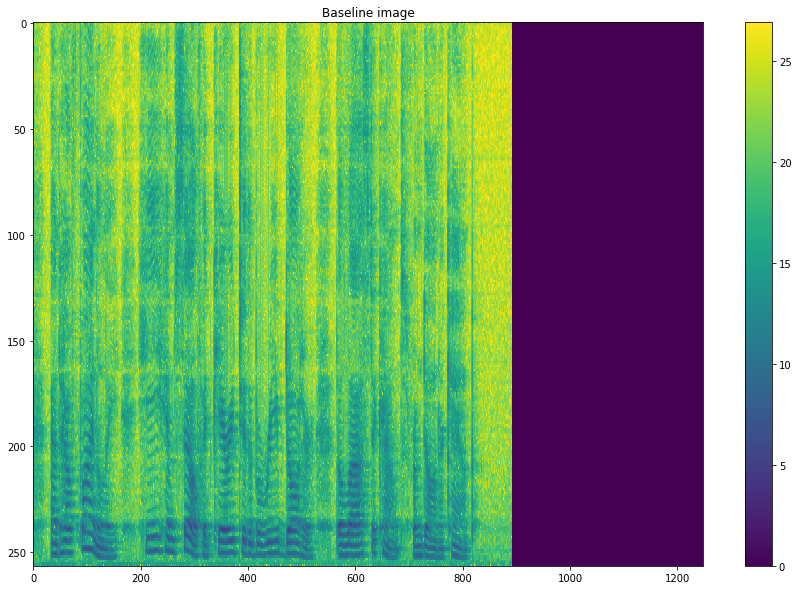

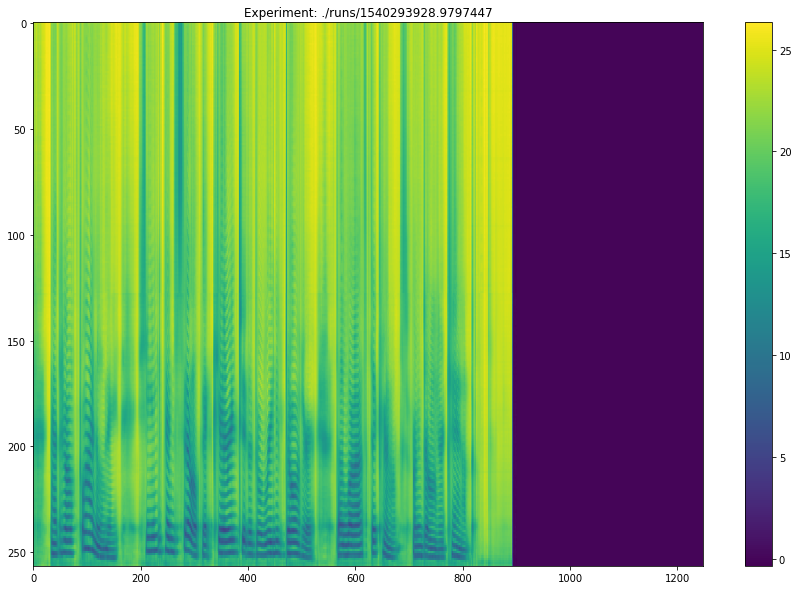

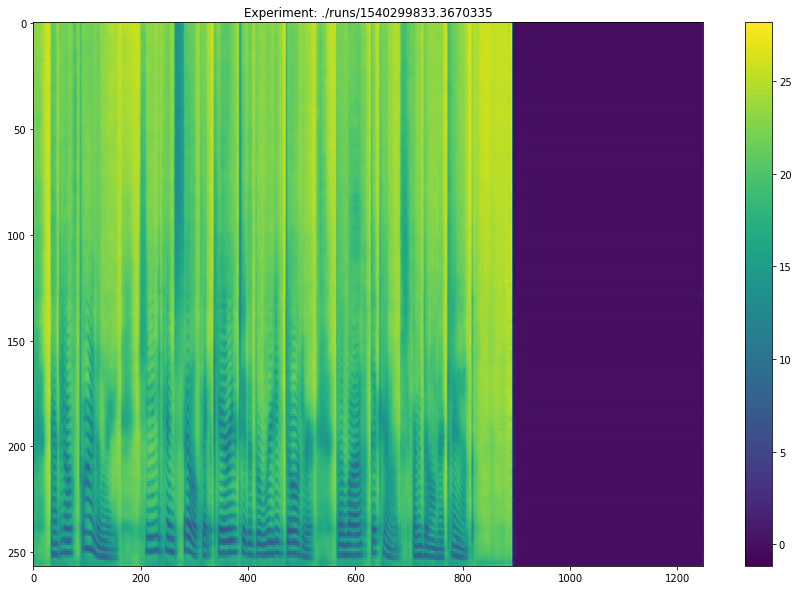

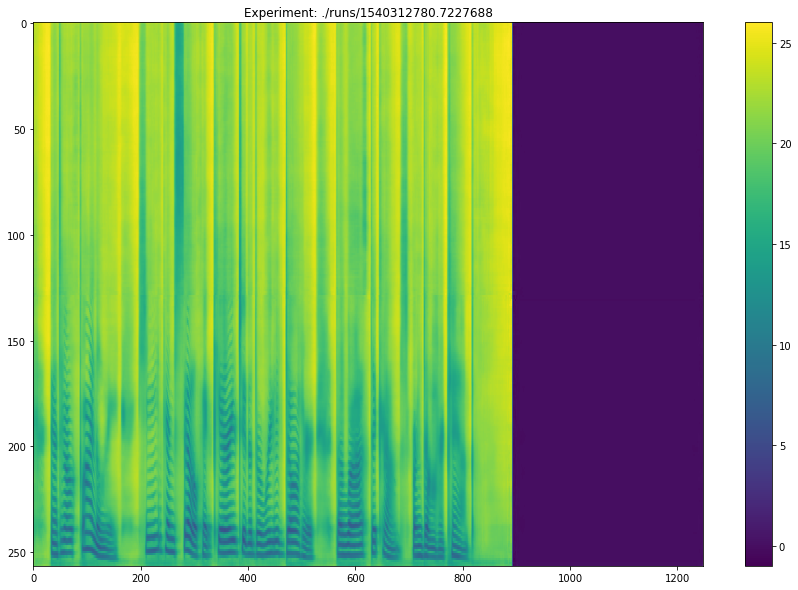

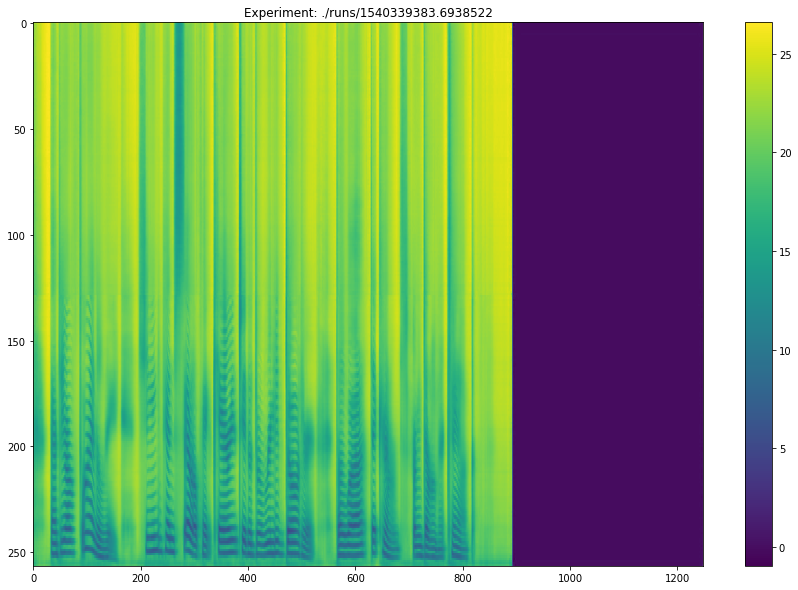

In [37]:
# visualisation

image, gt = test

plt.figure(figsize=(15,10))
plt.title("Baseline image")
plt.imshow(np.rot90(gt[0, :, :]) * STD + MEAN, aspect='auto')
plt.colorbar()
plt.show()

for name, mdl in zip(experiment_names, models):
    prediction = mdl.predict(image[:1]) * STD + MEAN
    plt.figure(figsize=(15,10))
    plt.title("Experiment: " + name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto')
    plt.colorbar()
    plt.show()

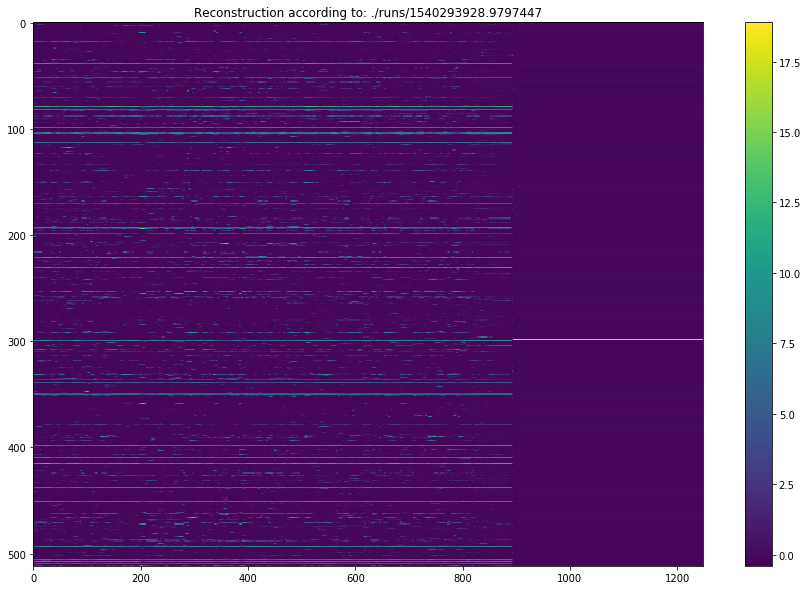

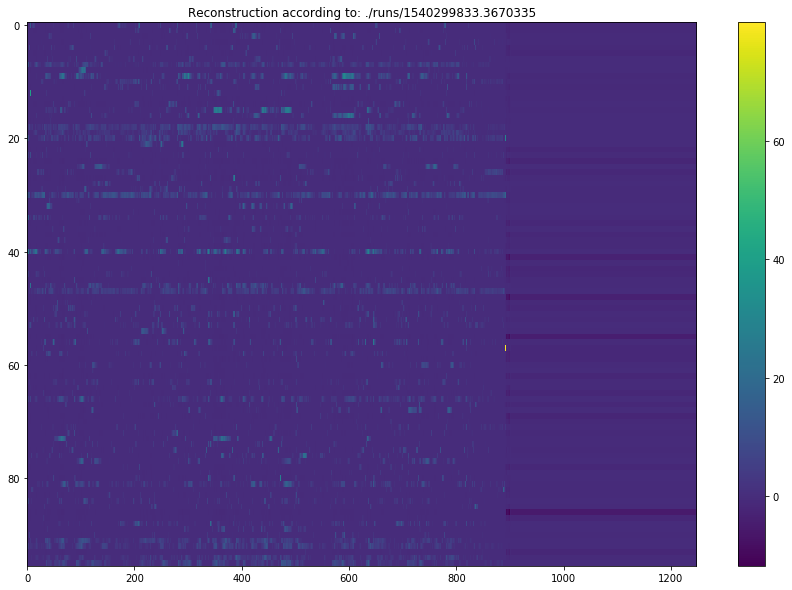

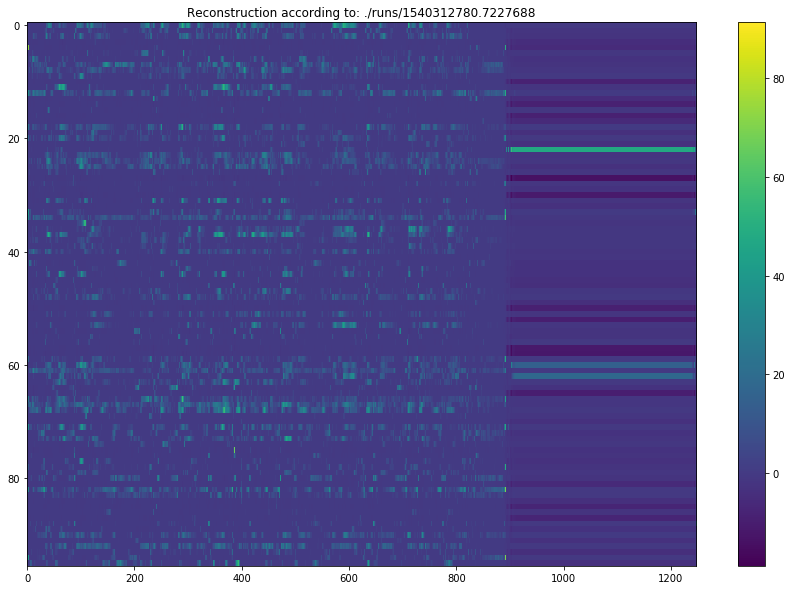

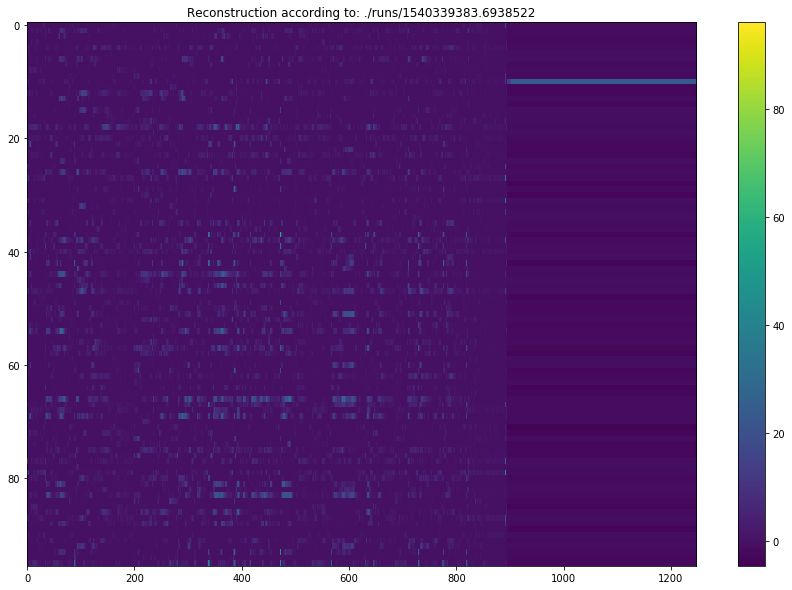

In [38]:
# hidden representation of each model - verify variability

image, gt = test

for name, mdl in zip(experiment_names, models):
    model = Model(mdl.input, [x.output for x in mdl.layers if x.name == "hidden"][0])
    prediction = model.predict(image[:1]) * STD + MEAN
    plt.figure(figsize=(15,10))
    plt.title("Reconstruction according to: " + name)
    plt.imshow(np.rot90(prediction[0, :, :]), aspect='auto')
    plt.colorbar()
    plt.show()

Groundtruth signal


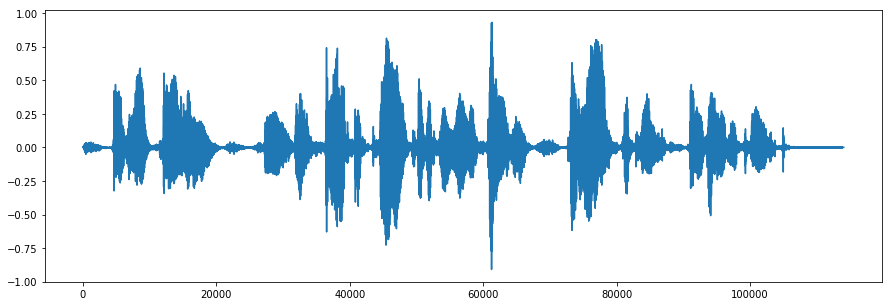

Input signal


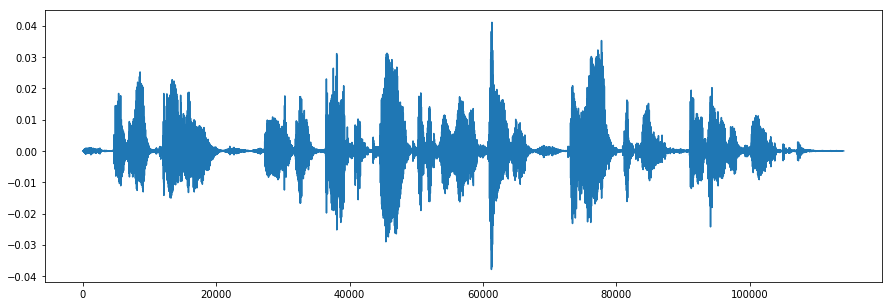

Prediction of ./runs/1540293928.9797447


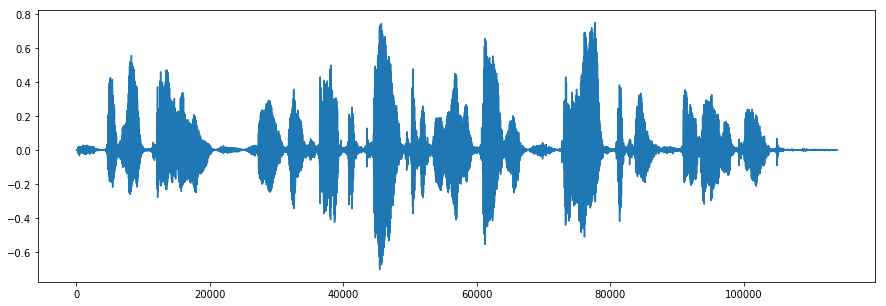

Prediction of ./runs/1540299833.3670335


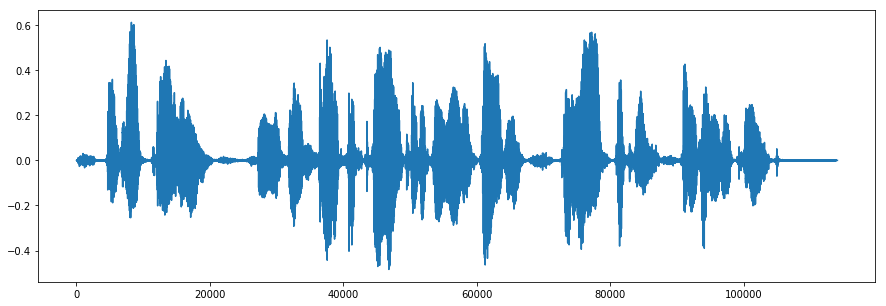

Prediction of ./runs/1540312780.7227688


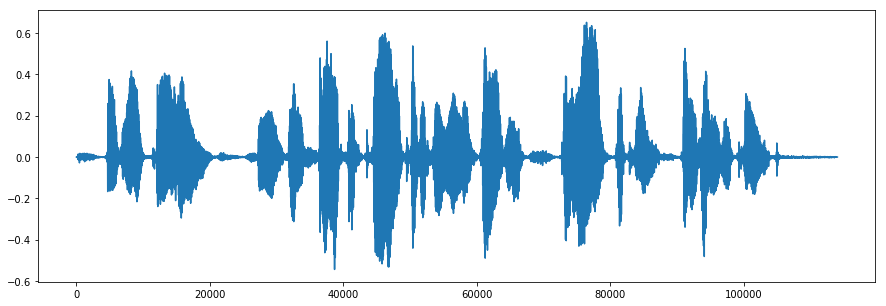

Prediction of ./runs/1540339383.6938522


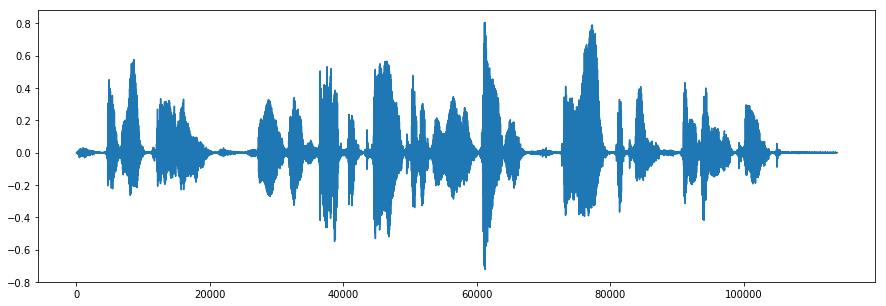

In [39]:
# predicted spectrograms

phase = np.zeros(gt.shape)
phase[:,:,:129] = old_phase
phase[:, :, 129:] = old_phase[:, :, :0:-1]

window = np.hamming(512)

print("Groundtruth signal")
sound = gt[0] * STD + MEAN
spec = (np.sqrt(np.exp(-sound)) * 512) * np.exp(phase[0, :, :] * 1j)

length = len(np.where((gt[0, :, :] != 0).sum(1))[0]) - 4
sound = np.zeros(length * 128 + 512 - 128)

for i in range(length):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += window * frame
plt.figure(figsize=(15,5))
plt.plot(sound)
plt.show()
display(Audio(sound, rate=16000))

print("Input signal")
sound = image[0]  * STD + MEAN
spec = np.zeros(gt[0].shape, np.complex)
spec[:,:129] = (np.sqrt(np.exp(-(sound)) * 512) * np.exp(phase[0, :, :129] * 1j))
sound = np.zeros(length * 128 + 512 - 128)
for i in range(length):
    frame = np.fft.irfft(spec[i,:])
    sound[128 * i : 128 * i + 512] += window * frame
plt.figure(figsize=(15,5))
plt.plot(sound)
plt.show()
display(Audio(sound, rate=16000))


for name, mdl in zip(experiment_names, models):
    print("Prediction of " + name)
    spec = mdl.predict(image[:1])[0]  * STD + MEAN
    sound = np.zeros(length * 128 + 512 - 128)
    spec = (np.sqrt(np.exp(-spec)) * 512) * np.exp(phase[0, :, :] * 1j)
    for i in range(length):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += window * frame
    plt.figure(figsize=(15,5))
    plt.plot(sound)
    plt.show()
    display(Audio(sound, rate=16000))


##### Metrics

In [34]:
import subprocess
import re

def pesq(gt, pred, phase):
    spec = (np.sqrt(np.exp(-gt)) * 512) * np.exp(phase * 1j)
    sound = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += frame
    spec = (np.sqrt(np.exp(-pred)) * 512) * np.exp(phase * 1j)
    sound2 = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound2[128 * i : 128 * i + 512] += frame
    fname_gt = tempfile.mktemp() + ".wav"
    fname_pred = tempfile.mktemp() + ".wav"
    # print(sound.shape, sound2.shape)
    sio.write(fname_gt, 16000, (2**15 * sound).astype(np.int16))
    sio.write(fname_pred, 16000, (2**15 * sound2).astype(np.int16))
    ot,e = subprocess.Popen(["PESQ", "+wb", "+16000", fname_gt, fname_pred], stdout = subprocess.PIPE, stderr = subprocess.PIPE).communicate()
    os.remove(fname_gt)
    os.remove(fname_pred)
    # print(ot)
    o = ot.decode("utf-8").split('\n')[-2]
    # print(o, len(o))
    # if not len(o):
    #     print(ot.decode("utf-8"))
    value = re.findall("= \d\.\d+", o)[0]
    # print(value)
    return float(value[2:])

inp, gtruth = test
n_phase = phase[:]
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
quality = []
print(gtruth.shape, preds.shape, n_phase.shape)
gtruth = STD * gtruth + MEAN
for i in range(gtruth.shape[0]):
    try:
        quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
    except IndexError:
        print("Failed getting PESQ value for recording {}".format(i))
print("No processing PESQ:", np.array(quality).mean())

quality_arrays = []

for name, mdl in zip(experiment_names, models):
    preds = mdl.predict(inp)
    preds[:, :, :129] = gt[:, :, :129]
    preds = STD * preds + MEAN
    quality = []
    for i in range(gtruth.shape[0]):
        try:
            quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
        except IndexError:
            print("Failed getting PESQ value for recording {}".format(i))
    print("Predicted by model {}:".format(name), np.array(quality).mean(), "+-", np.array(quality).std())
    quality_arrays.append(np.array(quality))

(80, 1248, 257) (80, 1248, 257) (80, 1248, 257)
No processing PESQ: 1.1416625
Predicted by model ./runs/1539361803.8221645: 3.6874875000000005 +- 0.6582269174409004
Predicted by model ./runs/1539369208.5706365: 3.6595874999999998 +- 0.6367960563192505
Predicted by model ./runs/1539393810.9876993: 3.6773625 +- 0.7313307091143856
Predicted by model ./runs/1539407892.840689: 3.707625 +- 0.6880477522490718
Predicted by model ./runs/1539428125.466498: 3.6823499999999996 +- 0.738389736182729
Predicted by model ./runs/1539466889.7781427: 3.6960375 +- 0.7155266494643998
Predicted by model ./runs/1539479433.8300025: 3.6897125 +- 0.6834556714548135
Predicted by model ./runs/1539492914.216426: 3.6797625 +- 0.6773801968567946


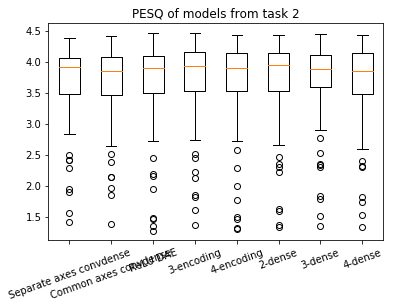

In [37]:
plot_model_names = ["Separate axes convdense", "Common axes convdense", "ReLU DAE", "3-encoding", "4-encoding", "2-dense", "3-dense", "4-dense"]
plt.boxplot(quality_arrays, labels=plot_model_names)
plt.xticks(rotation=20)
plt.title("PESQ of models from task 2 after subsitution")
plt.show()

[7, 9, 7, 12, 13, 12, 9, 11]


Text(0.5,1,'Percentage of preference across models, according to PESQ, task 2')

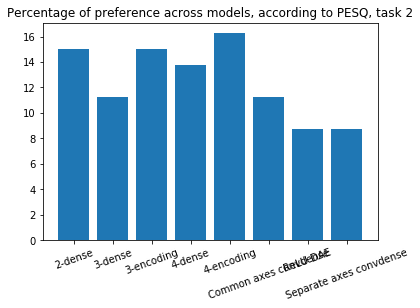

In [38]:
# old loaded data (seemingly ok): [7, 1, 7, 13, 15, 0, 7, 21, 9]

preferences = np.stack(quality_arrays).argmax(0)
from collections import Counter

c = Counter(preferences)
prefs = [c[x] for x in range(len(models))]
print(prefs)
plt.bar(plot_model_names, np.array(prefs) / 80 * 100)
plt.xticks(rotation=20)
plt.title("Percentage of preference across models, according to PESQ, task 2")

In [39]:
import subprocess
import re

def pesq(gt, pred, phase):
    spec = (np.sqrt(np.exp(-gt)) * 512) * np.exp(phase * 1j)
    sound = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound[128 * i : 128 * i + 512] += frame
    spec = (np.sqrt(np.exp(-pred)) * 512) * np.exp(phase * 1j)
    sound2 = np.zeros(spec.shape[0] * 128 + 512 - 128)
    for i in range(spec.shape[0]):
        frame = np.fft.irfft(spec[i,:])
        sound2[128 * i : 128 * i + 512] += frame
    fname_gt = tempfile.mktemp() + ".wav"
    fname_pred = tempfile.mktemp() + ".wav"
    # print(sound.shape, sound2.shape)
    sio.write(fname_gt, 16000, (2**15 * sound).astype(np.int16))
    sio.write(fname_pred, 16000, (2**15 * sound2).astype(np.int16))
    ot,e = subprocess.Popen(["PESQ", "+wb", "+16000", fname_gt, fname_pred], stdout = subprocess.PIPE, stderr = subprocess.PIPE).communicate()
    os.remove(fname_gt)
    os.remove(fname_pred)
    # print(ot)
    o = ot.decode("utf-8").split('\n')[-2]
    # print(o, len(o))
    # if not len(o):
    #     print(ot.decode("utf-8"))
    value = re.findall("= \d\.\d+", o)[0]
    # print(value)
    return float(value[2:])

inp, gtruth = test
n_phase = phase[:]
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
quality = []
print(gtruth.shape, preds.shape, n_phase.shape)
gtruth = STD * gtruth + MEAN
for i in range(gtruth.shape[0]):
    try:
        quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
    except IndexError:
        print("Failed getting PESQ value for recording {}".format(i))
print("No processing PESQ:", np.array(quality).mean())

quality_arrays = []

for name, mdl in zip(experiment_names, models):
    preds = mdl.predict(inp)
    preds = STD * preds + MEAN
    quality = []
    for i in range(gtruth.shape[0]):
        try:
            quality.append(pesq(gtruth[i], preds[i], n_phase[i]))
        except IndexError:
            print("Failed getting PESQ value for recording {}".format(i))
    print("Predicted by model {}:".format(name), np.array(quality).mean(), "+-", np.array(quality).std())
    quality_arrays.append(np.array(quality))

(80, 1248, 257) (80, 1248, 257) (80, 1248, 257)
No processing PESQ: 1.1416625
Predicted by model ./runs/1539361803.8221645: 2.8833 +- 0.6026530801381504
Predicted by model ./runs/1539369208.5706365: 2.7346874999999997 +- 0.5526679290892045
Predicted by model ./runs/1539393810.9876993: 2.7634 +- 0.7201778183198925
Predicted by model ./runs/1539407892.840689: 2.825775 +- 0.6726552046739845
Predicted by model ./runs/1539428125.466498: 2.8267375 +- 0.6637597408654353
Predicted by model ./runs/1539466889.7781427: 2.6616625000000003 +- 0.6266933050494077
Predicted by model ./runs/1539479433.8300025: 2.6596374999999997 +- 0.6152279301964029
Predicted by model ./runs/1539492914.216426: 2.5177875 +- 0.5813513286677429


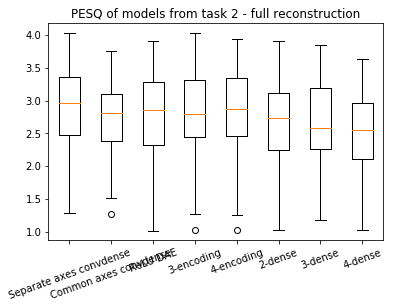

In [40]:
plot_model_names = ["Separate axes convdense", "Common axes convdense", "ReLU DAE", "3-encoding", "4-encoding", "2-dense", "3-dense", "4-dense"]
plt.boxplot(quality_arrays, labels=plot_model_names)
plt.xticks(rotation=20)
plt.title("PESQ of models from task 2 - full reconstruction")
plt.show()

[22, 9, 15, 19, 13, 1, 1, 0]


Text(0.5,1,'Percentage of preference across models, according to PESQ, task 2 - full reconstruction')

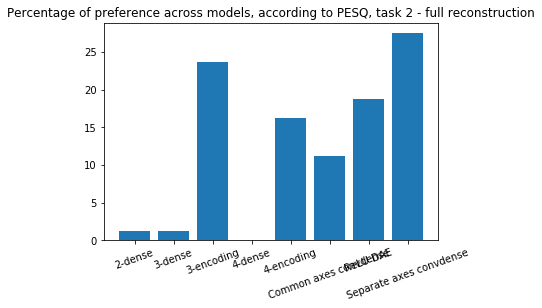

In [41]:
# old loaded data (seemingly ok): [7, 1, 7, 13, 15, 0, 7, 21, 9]

preferences = np.stack(quality_arrays).argmax(0)
from collections import Counter

c = Counter(preferences)
prefs = [c[x] for x in range(len(models))]
print(prefs)
plt.bar(plot_model_names, np.array(prefs) / 80 * 100)
plt.xticks(rotation=20)
plt.title("Percentage of preference across models, according to PESQ, task 2 - full reconstruction")

In [46]:
# log power MSE

inp, gtruth = test
preds = mdl.predict(inp)  * STD + MEAN
gtruth = gtruth * STD + MEAN

preds = gtruth * 0
preds[:, :, :129] = inp
logmse=[]
for i in range(gtruth.shape[0]):
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
print("Baseline log-power MSE:", np.array(logmse).mean())

for name, mdl in zip(experiment_names, models):
    logmse=[]
    preds = mdl.predict(inp) * STD + MEAN
    for i in range(gtruth.shape[0]):
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        logmse.append(((preds[i, :length, :] - gtruth[i, :length, :]) ** 2).mean())
    print("Log-power MSE of {}:".format(name), np.array(logmse).mean())



Baseline log-power MSE: 364.74432
Log-power MSE of ./runs/1539361803.8221645: 2.5553296
Log-power MSE of ./runs/1539369208.5706365: 2.718594
Log-power MSE of ./runs/1539393810.9876993: 2.5712264
Log-power MSE of ./runs/1539407892.840689: 2.5533364
Log-power MSE of ./runs/1539428125.466498: 2.5419588
Log-power MSE of ./runs/1539466889.7781427: 2.5900412
Log-power MSE of ./runs/1539479433.8300025: 2.6213522
Log-power MSE of ./runs/1539492914.216426: 2.649988


In [51]:
# log-spectral distance


inp, gtruth = test
gtruth = STD * gtruth + MEAN
preds = gtruth * 0
preds[:, :, :129] = STD * inp + MEAN
lsd = []
innermost = (10 * ((-preds) - (-gtruth)) / np.log(10)) ** 2
for i in range(gtruth.shape[0]):
    inner = innermost[i, :, :]
    length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
    inner = inner[:length]
    sublsd = []
    for t in range(length):
        step = 2 / 513
        frame = inner[t]
        integral = frame.sum()
        sublsd.append(np.sqrt(step * integral))
    lsd.append(np.array(sublsd).mean())
print("Log-spectral distance of baseline:", np.array(lsd).mean())

for name, mdl in zip(experiment_names, models):
    preds = STD * mdl.predict(inp) + MEAN
    lsd = []
    innermost = (10 * ((-preds) - (-gtruth)) / np.log(10)) ** 2
    for i in range(gtruth.shape[0]):
        inner = innermost[i, :, :]
        length = len(np.where((gtruth[i, :, :] != 0).sum(1))[0])
        inner = inner[:length]
        sublsd = []
        for t in range(length):
            step = 2 / 513
            frame = inner[t]
            integral = frame.sum()
            sublsd.append(np.sqrt(step * integral))
        lsd.append(np.array(sublsd).mean())
    print("Log-spectral distance of {}:".format(name), np.array(lsd).mean(), "+-", np.array(lsd).std())

Log-spectral distance of baseline: 66.62629716372612
Log-spectral distance of ./runs/1539361803.8221645: 6.62465146044797 +- 0.4762948177165432
Log-spectral distance of ./runs/1539369208.5706365: 6.841987410992887 +- 0.5197886265085474
Log-spectral distance of ./runs/1539393810.9876993: 6.662852381249398 +- 0.50288458602802
Log-spectral distance of ./runs/1539407892.840689: 6.638733811593414 +- 0.519654744515925
Log-spectral distance of ./runs/1539428125.466498: 6.611467637332576 +- 0.49503249960688916
Log-spectral distance of ./runs/1539466889.7781427: 6.676295148770305 +- 0.5121455497503821
Log-spectral distance of ./runs/1539479433.8300025: 6.721941309526157 +- 0.5150552223000678
Log-spectral distance of ./runs/1539492914.216426: 6.7616065621599635 +- 0.5083671457381828


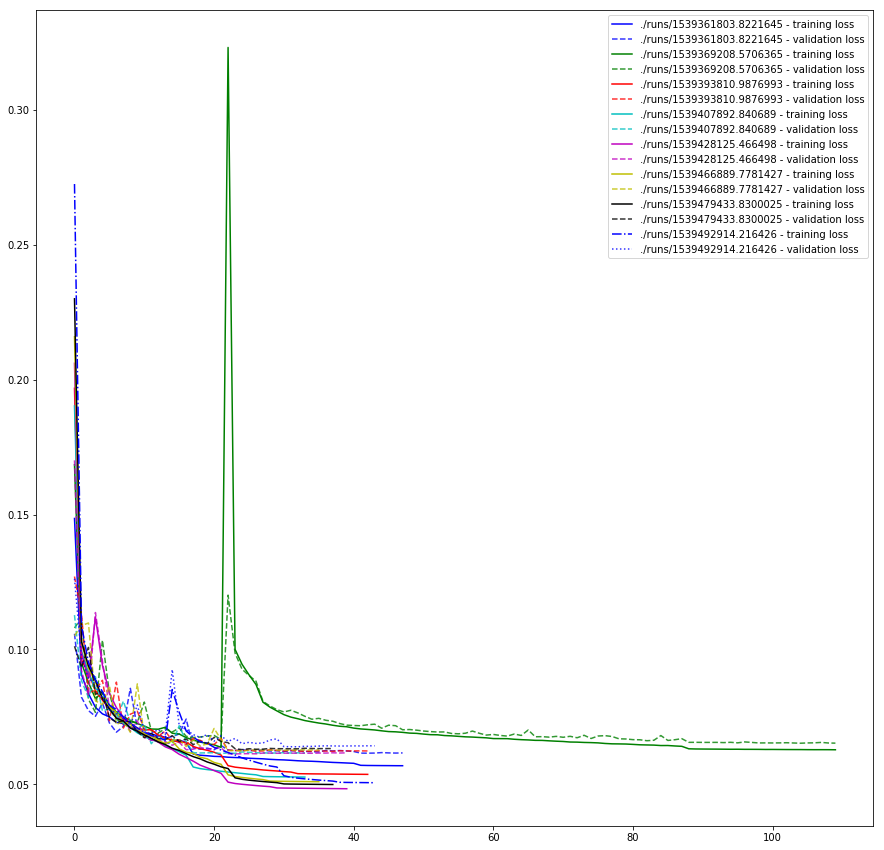

In [43]:
# Losses during training

legend_labels = []
colors = "bgrcmykbgrcmyk"
train_linestyles = ["-"] * 7 + ["-."] * 7
val_linestyles = ["--"] * 7 + ["dotted"] * 7
plt.figure(figsize=(15,15))
for color, tl, vl, model in zip(colors, train_linestyles, val_linestyles, experiment_names):
    with open(model + "/history.pkl", "rb") as f:
        hist = pickle.load(f)
    loss = hist['loss']
    val_loss = hist['val_loss']
    plt.plot(loss, linestyle=tl, color=color)
    plt.plot(val_loss, linestyle=vl, color=color, alpha=0.8)
    legend_labels.append(model + " - training loss")
    legend_labels.append(model + " - validation loss")
plt.legend(legend_labels)
plt.show()